In [22]:
import pandas as pd
import numpy as np
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [23]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    """
    image is a 80x80 pixel image that represents our reconstructed image
    coords is a list of u,v coordinates that we obtained from our data
    FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    """

    ft_image = np.fft.fftshift(np.fft.fft2(image))

    k_FOV = 1/FOV

    kx = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[0], d = 1/(k_FOV*ft_image.shape[0])))
    ky = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[1], d = 1/(k_FOV*ft_image.shape[1])))

    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)

    return real + imag * 1j

# Loss
The Loss function is trying to compare the data with the image and see if they agree with each other.

Let $I(x,y)$ be the image and we transform it into $\hat{I} (x,y)$ by using fourier transfroms described in the the interpolate section of the previous notebook. 

Next we compare each interpolated point with its data term counterpart and get the equation for loss to be:

$$J = \sum(\frac{|\hat{I} - D|^2}{\sigma^2})$$

$\sigma$ here is the error for each data point.

Finally, we add the regularizer to the loss using the method in the previous notebook.

## Data Term calculation
We have above that $\hat{I}$ is in the Fourier Domain. In order to compute the data term, we calculate the term as $D = \text{Amp} * e^{i*\text{phase}}$.

It is important to note that the phase in Z is in radians, not degrees


In [24]:
def loss(image, data_list, coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)):
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)
    
    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

## Furthermore into the data
What we are doing here is a simplified version of the loss function. In reality, the loss is more complicated due to other factors.

Because of the method of combining signal data from many telescopes, we get errors that may throw off the data terms. 

How would we change our loss function?

### Method One: Gain
We add a new function called the Gain which represents the telescoping errors. It is a smooth function in time that has a phase and amplitude. We multiply it with the data term to result in:

$$J = \sum_d \frac{|\hat{I} - G D|^2}{\sigma^2}$$

d is a data point

Now when we try to minimize the image, we are also trying to minimize G.

### Method Two: Closure Phase
The other way is to take into the account the Closure Phase.

Using three telescopes we get:

$$ \sum_{i,j,k} \frac{|\phi_{1,2} + \phi_{2,3} + \phi_{3,1} - \phi_{\hat{I}}|^2}{\sigma^2}$$

i, j, k here are pairs of data points

3 specifically

$\phi_{1,2} + \phi_{2,3} + \phi_{3,1}$ is called the Closure Phase $CP$ which is independent of the telescope error and is taken from the data. $\phi_{\hat{I}}$ is a Closure Phase computed from the image. 

In practice, these are the two major methods in order to fit the image to the data.

## Testing the function
Below we have a image that was generated for testing purposes. Sometimes we want to shift the image in someway so that the loss function can be optimized further. In EHT, they have tested with many variations and come up with the loss being the best with the ring centered in the middle. We will test this claim below.

(-0.5, 79.5, 79.5, -0.5)

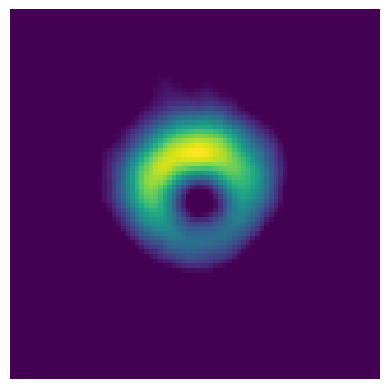

In [25]:
sample = np.loadtxt("data.csv", delimiter=",")
plt.figure()
plt.imshow(sample, vmin=0, vmax=np.max(sample))
plt.axis('off')

Here we generate a coords and data_list list by sampling data from the ring (not the noise around the ring). 

In [26]:
def do_sample():
    coords = []
    data_list = []
    ft_image = np.fft.fftshift(np.fft.fft2(sample))
    for i in range(25):
        coords.append((int(np.random.rand()*10-5), int(np.random.rand()*10-5)))
        data_list.append((coords[i],ft_image[coords[i][0]+40][coords[i][1]+40]))
    return coords, data_list

More points?
    Best?


In [27]:
coords, data_list = do_sample()
data_list

[((2, 4), (-11.797382443780851+1.8726152619466332j)),
 ((-1, 1), (81.50451703492507-27.925256574261823j)),
 ((-2, 4), (-11.158564582308404-2.58553536706419j)),
 ((3, -1), (-15.911270534406048+8.96334902375691j)),
 ((-2, -1), (-21.66480422721387+17.17123856655362j)),
 ((-3, 1), (-15.911270534406047-8.963349023756908j)),
 ((1, 1), (96.70324748013039+58.344348754272914j)),
 ((0, -1), (-105.60290049945763+15.907358258003203j)),
 ((-3, -4), (11.460839151005738+1.838650942483929j)),
 ((-3, -3), (-16.073815037740104+0.5318295817126559j)),
 ((-2, 3), (16.2317794885124-2.388125941699193j)),
 ((-3, -2), (18.59914527451261+7.6023610122723255j)),
 ((0, 0), (-130.7977532545254+0j)),
 ((-3, 0), (9.345246066663236+12.763088241472765j)),
 ((-2, 4), (-11.158564582308404-2.58553536706419j)),
 ((-1, -3), (-11.356134689784431-3.361553558377293j)),
 ((-1, 1), (81.50451703492507-27.925256574261823j)),
 ((-3, 4), (10.97997772948687+0.8737280514156963j)),
 ((-3, 0), (9.345246066663236+12.763088241472765j)),
 

It is important to note here that the data points in data_list is complex. Since we sampled from the fourier transform, we have no need to calcuate the data term like we do in the loss function above. Below is a altered version of the loss function above.

In [28]:
# Assumption image is 80px by 80px => 6400 variables
def simple_loss(image, data_list, coords, p = 2, reg_weight = 1, FOV = 1): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)

    for i in range(len(data_list)):
        vis_data = data_list[i][1]
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data)) ** 2
        error_sum += error
    
    return error_sum

Finally, below we calcuate the loss of the sample image we started with and then shift the image in all directions. Then we plot the array of losses that we obtained.

In [29]:
def calculate_losses():
    loss_arr = np.zeros((len(sample),len(sample[0])))
    for i in range(len(sample)):
        image_1 = np.roll(sample, i, axis=1) # Right shifts
        for j in range(len(sample[i])):
            image_2 = np.roll(image_1, j, axis = 0) # Up shifts
            loss_arr[i][j] = simple_loss(image_2, data_list, coords, reg_weight=0)

    # Note here for why we shift
    loss_arr1 = np.roll(loss_arr, 40, axis=1)
    loss_arr2 = np.roll(loss_arr1, 40, axis=0)

    plt.figure()
    plt.imshow(loss_arr2)
    plt.axis('off')
    return loss_arr

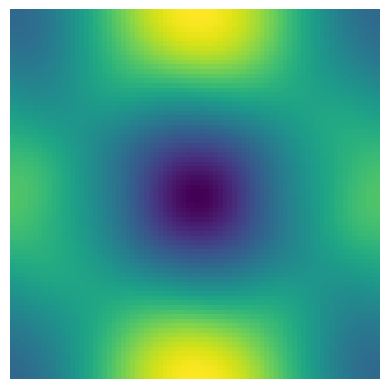

In [30]:
loss_arr = calculate_losses()

In [31]:
def gradient(data_list, coords, image, mode = 1): # 0 For central, -1 for backward, 1 for forward
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if (mode == 0): # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = simple_loss(image_copy, data_list, coords)
                image_copy[row,col] -= 1e-6
                lower_diff = simple_loss(image_copy, data_list, coords)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif (mode == -1): # Backward difference
        upper_diff = simple_loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8 # Check with Misha 
                lower_diff = simple_loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    elif (mode == 1) : # Forward difference is default
        lower_diff = simple_loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 # Check with Misha 
                upper_diff = simple_loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else:
        raise ValueError('Incorrect mode for finite differences')
    return gradient_arr
    #Return a Gradient 2d array?

In [32]:
def gradient_descent(image, data_list, coords, subset_percent = 10):
    image_copy = np.copy(image, subok=True)
    # coeffs = preprocess_gradient(data_list, coords, image_copy)
    # loss needs same subset as gradient_2
    i = 0
    grad = None
    while grad is None or np.min(np.abs(grad) > 0.0000001): # Didn't finish before so never negative?
        plt.figure()
        plt.imshow(image_copy, vmin=0, vmax=np.max(sample))
        plt.axis('off')
        plt.savefig('images/'+str(i)+'.png')

        t = 10000000

        #selection = np.random.choice(np.arange(len(data_list)), size=len(coords)*subset_percent//100, replace=False) # selection is full of indicies
        #subset = [data_list[index] for index in selection]
        prev_loss = simple_loss(image_copy, data_list, coords)

        grad = gradient(data_list, coords, image_copy)
        new_image = image_copy - t * grad.real
        new_loss = simple_loss(new_image, data_list, coords)
        
        while new_loss > prev_loss: # Only run when new_loss > prev_loss
            new_image = image_copy - t * grad.real
            new_loss = simple_loss(new_image, data_list, coords)
            t /= 2

        loss_file = open("known_sample/losses2.txt","a")
        loss_file.write("--------------------------")
        loss_file.write("t-val" + str(t) + "\n")
        loss_file.write("prev_loss:" + str(prev_loss) + "\n")
        loss_file.write("new_loss:" + str(new_loss) + "\n")
        loss_file.write("grad:" + str(np.min(np.max(grad))) + "\n")
        loss_file.close()

        image_copy -= t * 2 * grad.real
        i += 1
        if i == 1000:
            return image_copy

In [33]:
emp = np.zeros((80,80))
x = gradient(data_list, coords, emp)
np.savetxt("known_sample/gradient_sample.txt", np.real(x), delimiter=",")

/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_24354/111911019.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


array([[ 0.00204195,  0.00263944,  0.00299243, ..., -0.00077965,
         0.0002701 ,  0.00123376],
       [ 0.00084737,  0.00121881,  0.00136548, ..., -0.00126297,
        -0.0004468 ,  0.00027682],
       [-0.00052228, -0.0004008 , -0.00048572, ..., -0.00186862,
        -0.00129772, -0.00083256],
       ...,
       [ 0.00497395,  0.00582335,  0.00637156, ...,  0.00112093,
         0.00255284,  0.00386296],
       [ 0.00409589,  0.00495554,  0.0055306 , ...,  0.00033292,
         0.00171285,  0.00299357],
       [ 0.00311644,  0.00388558,  0.00438965, ..., -0.0002815 ,
         0.00096384,  0.00212217]])

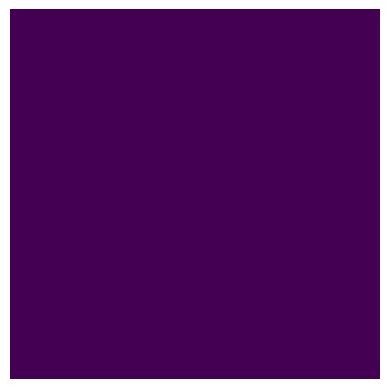

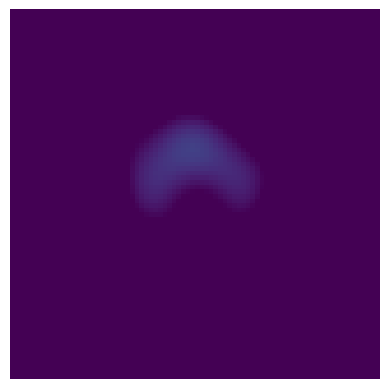

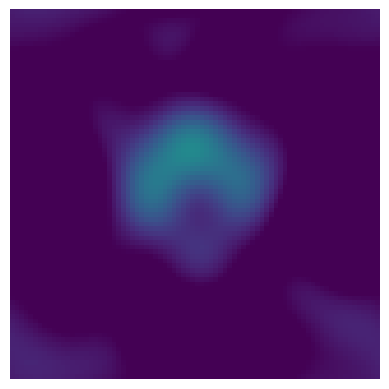

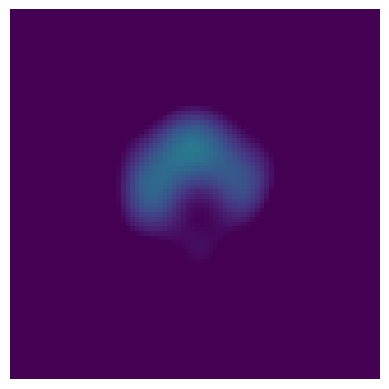

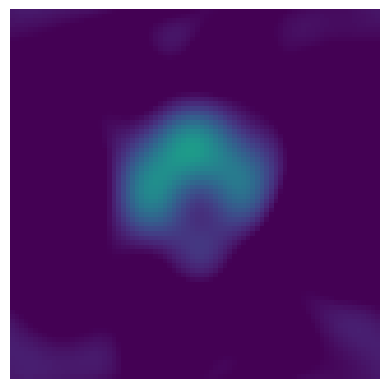

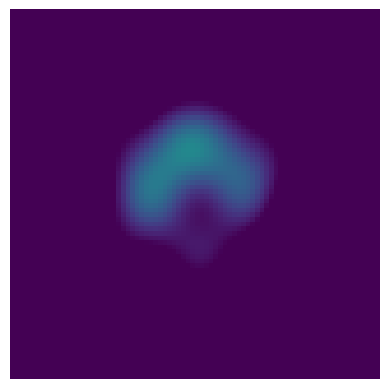

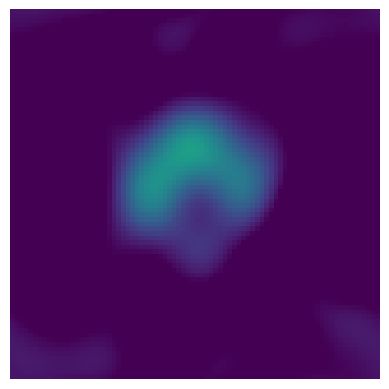

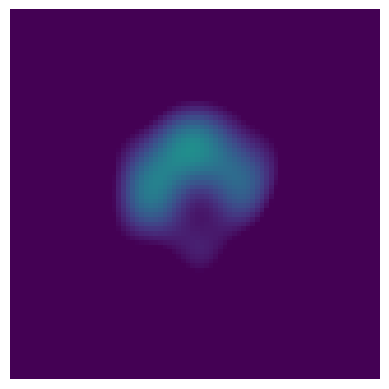

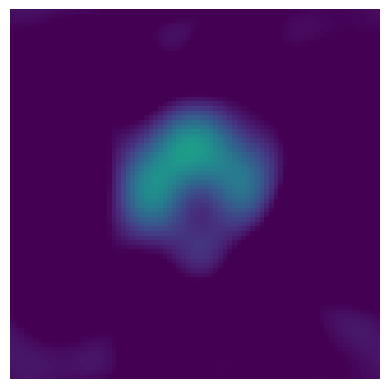

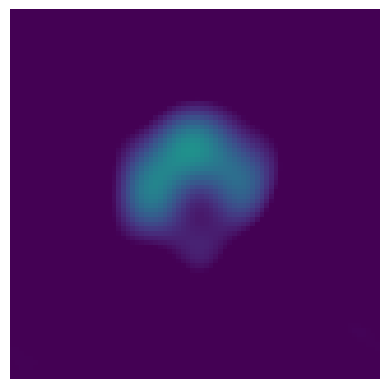

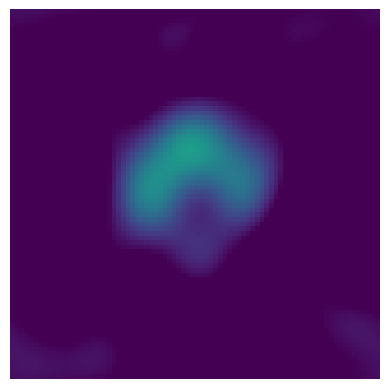

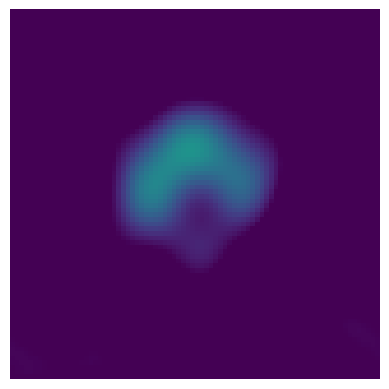

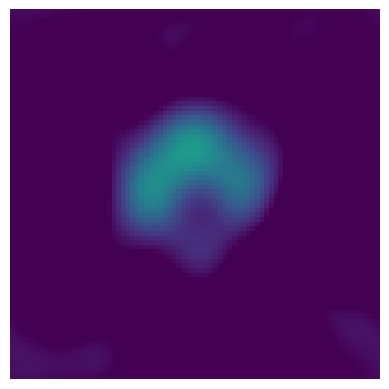

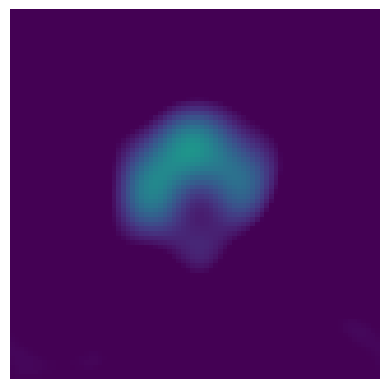

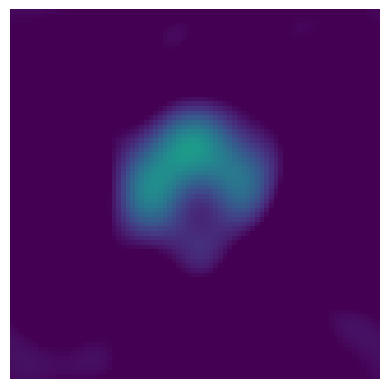

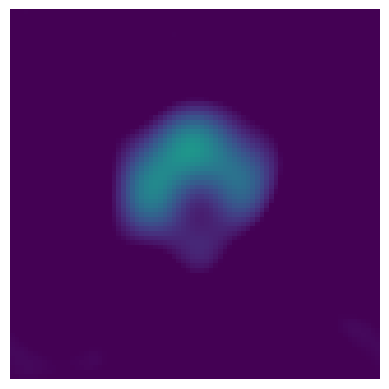

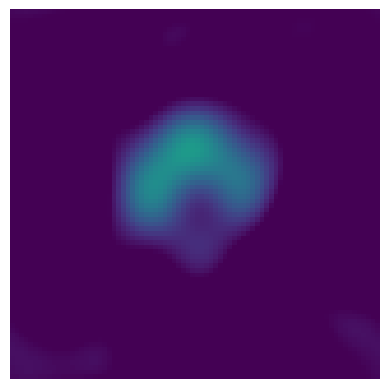

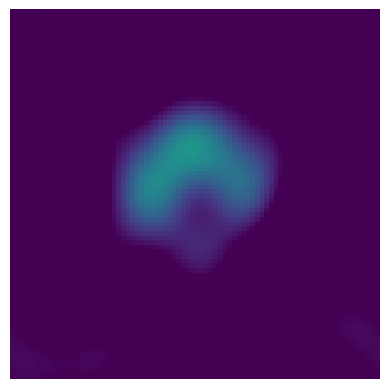

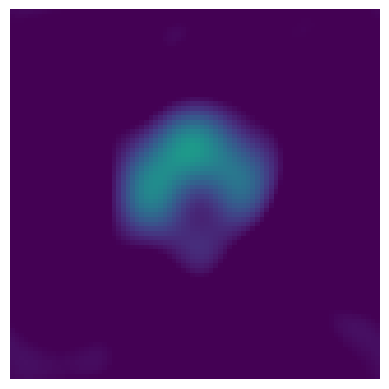

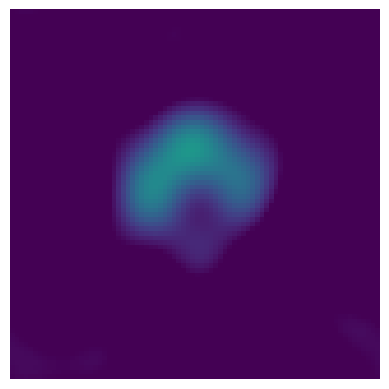

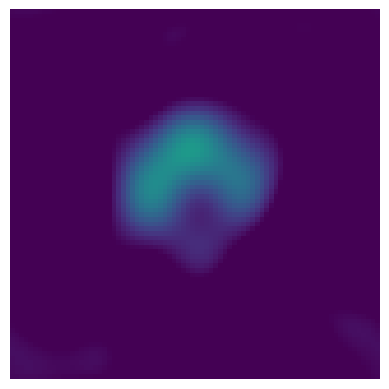

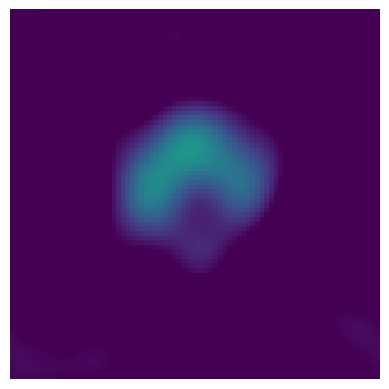

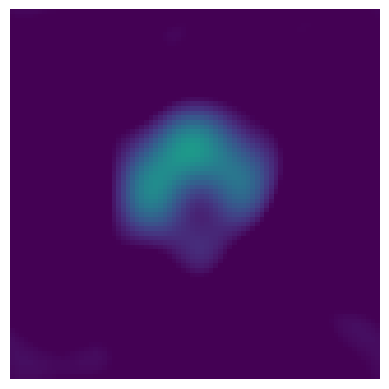

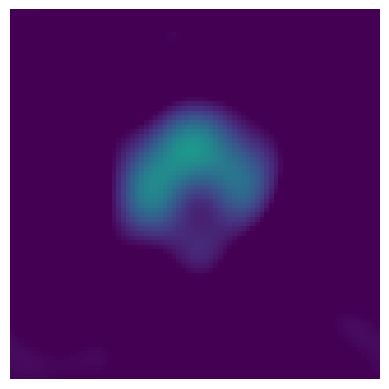

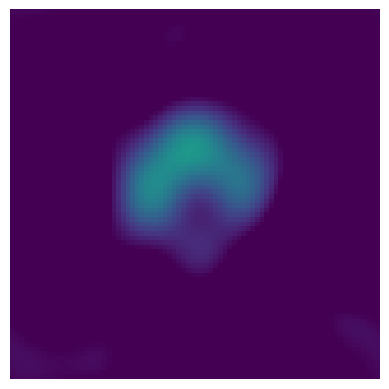

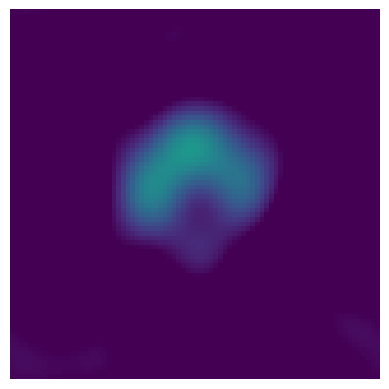

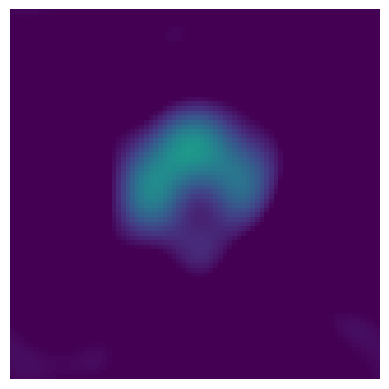

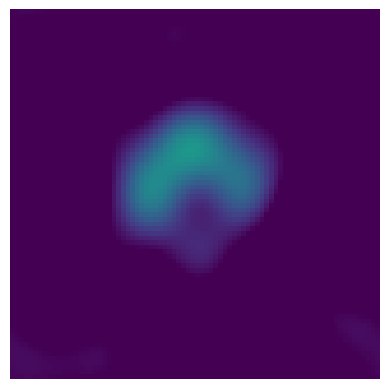

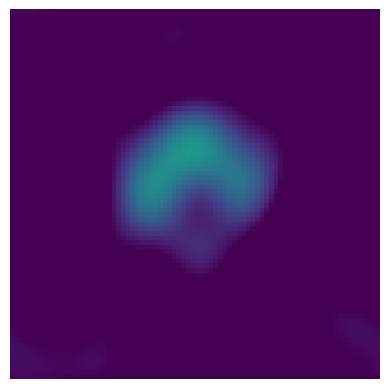

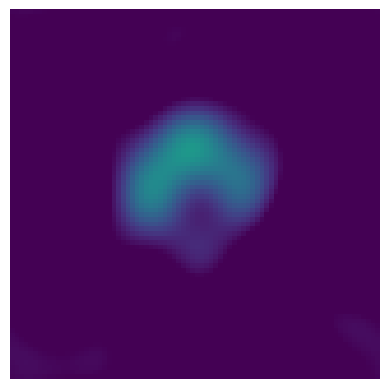

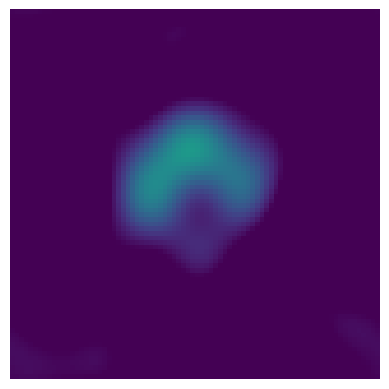

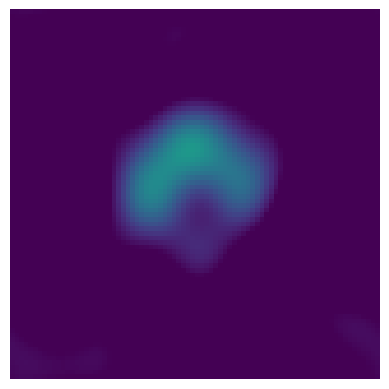

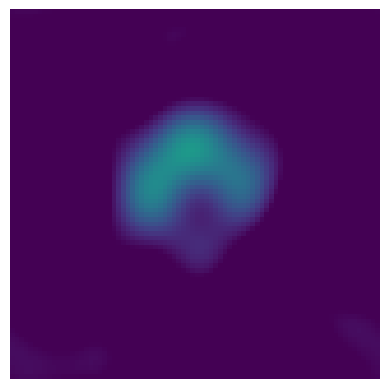

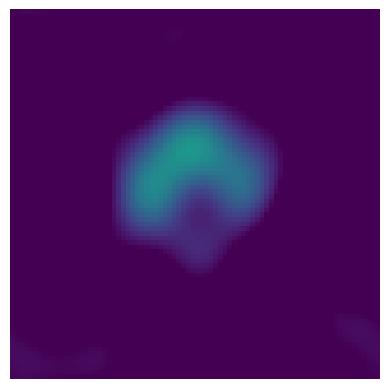

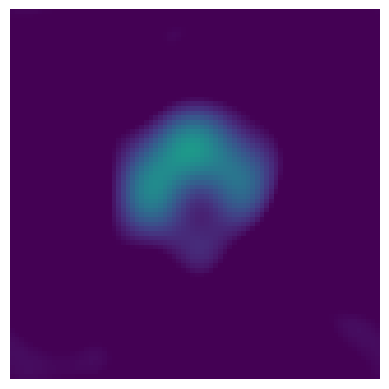

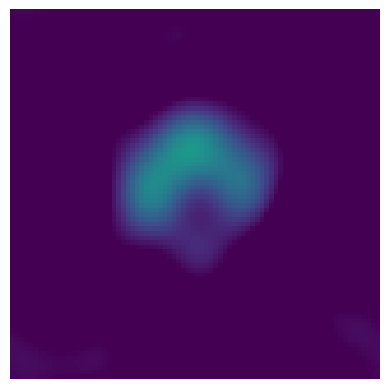

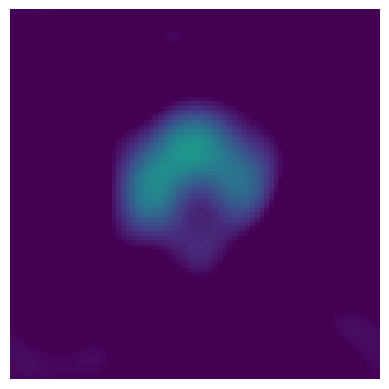

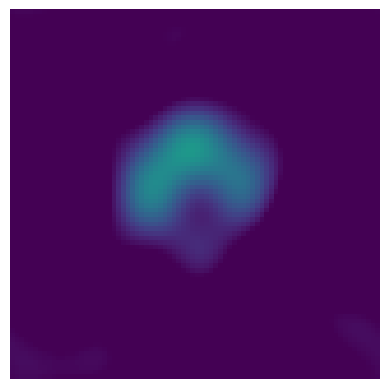

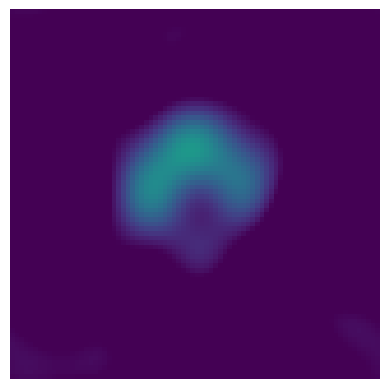

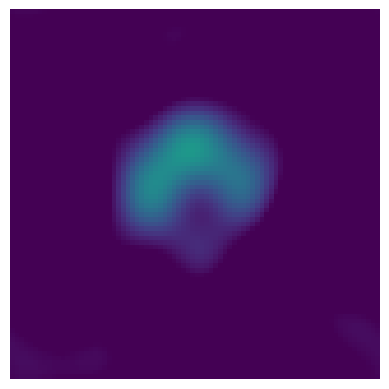

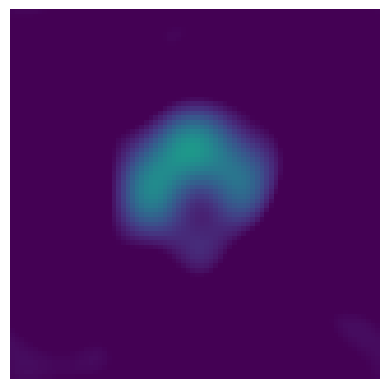

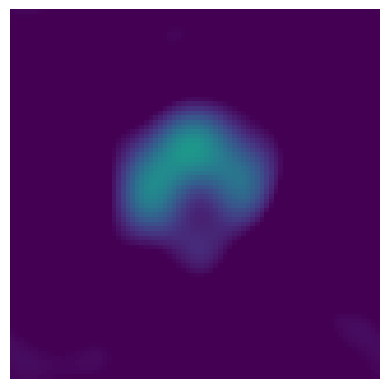

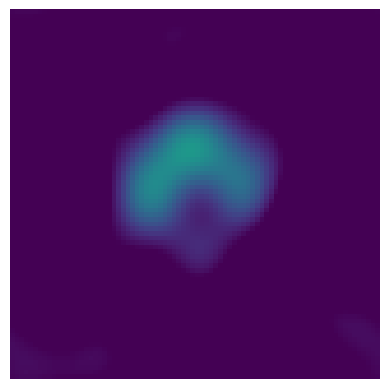

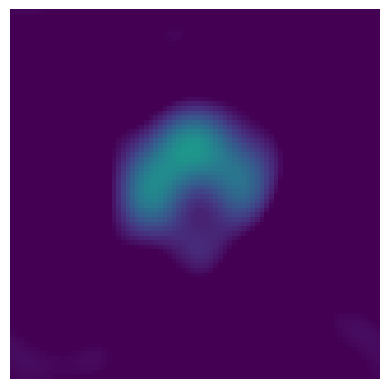

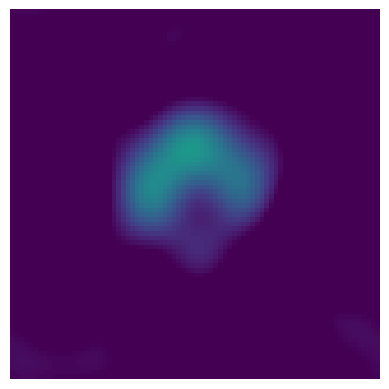

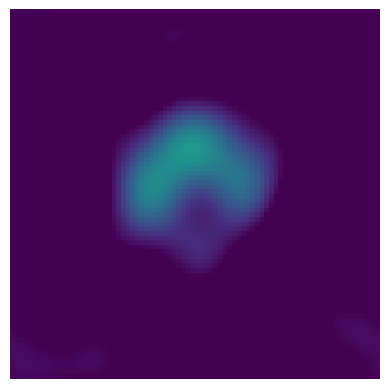

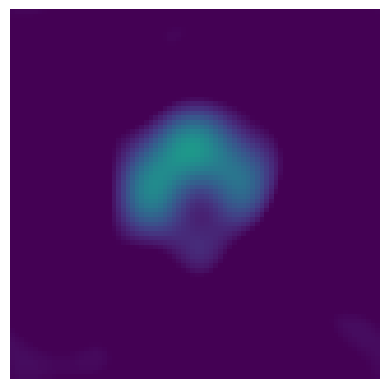

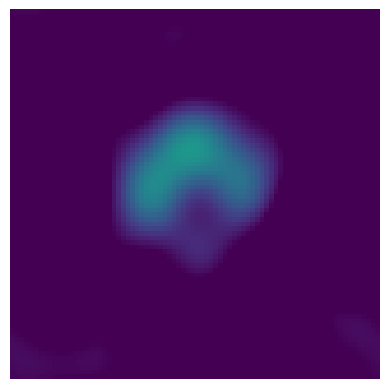

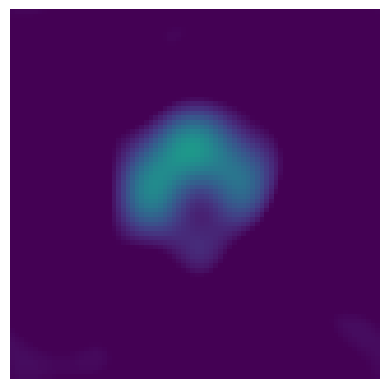

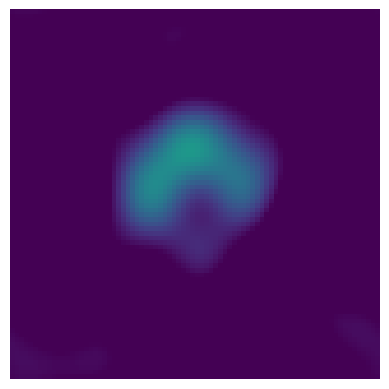

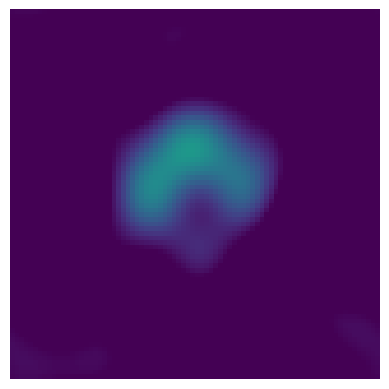

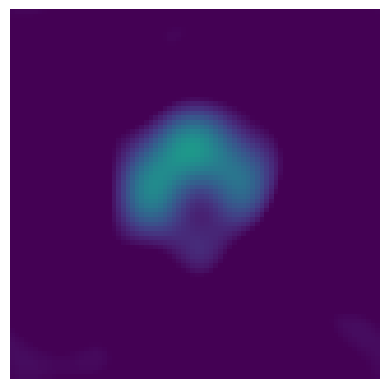

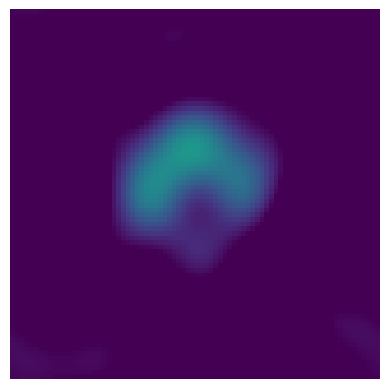

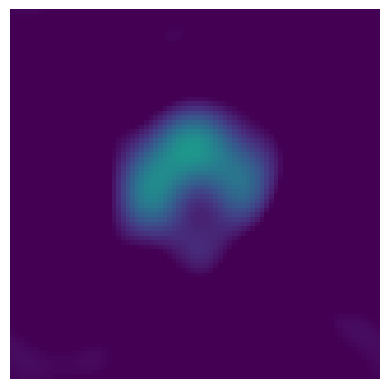

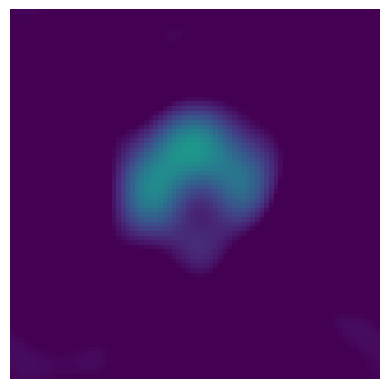

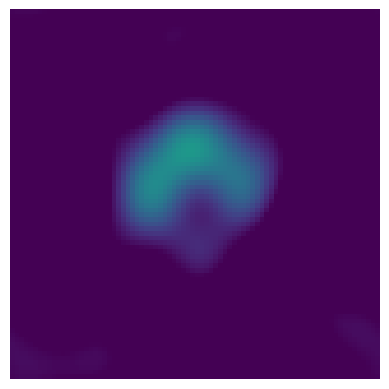

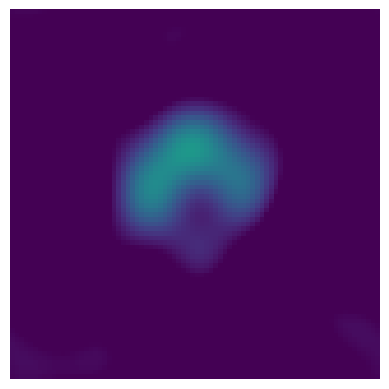

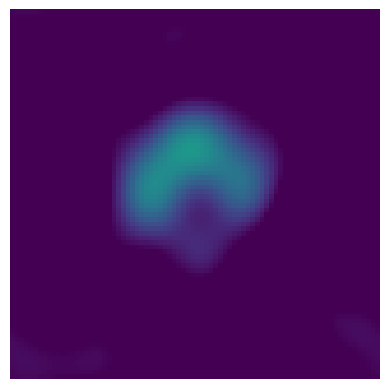

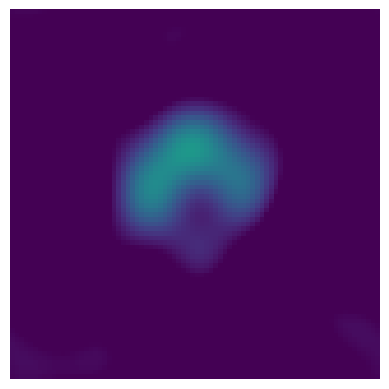

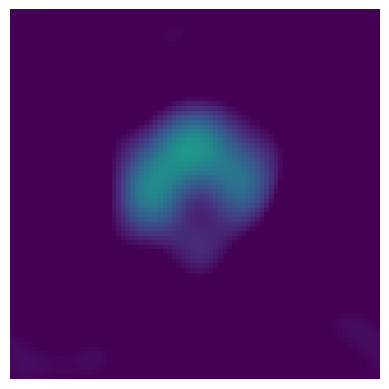

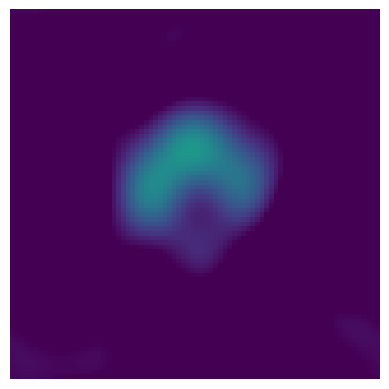

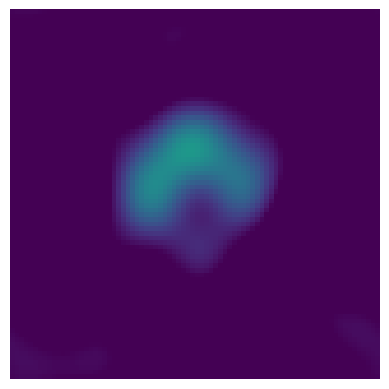

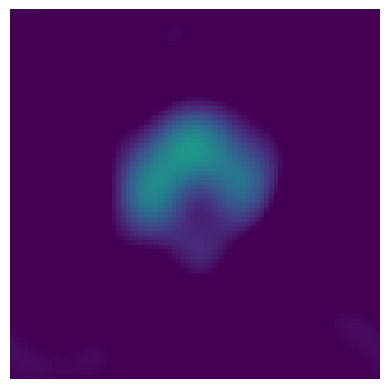

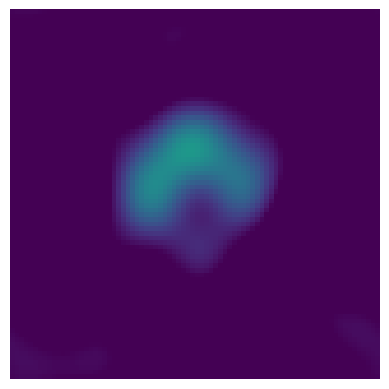

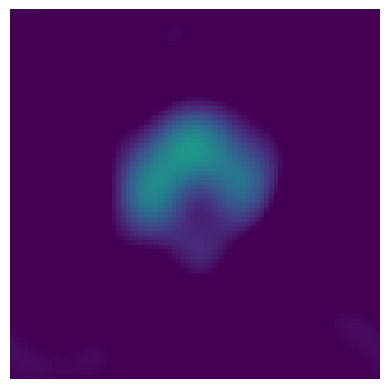

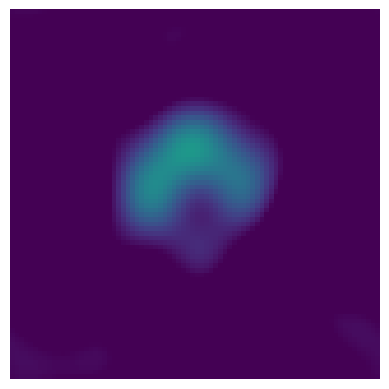

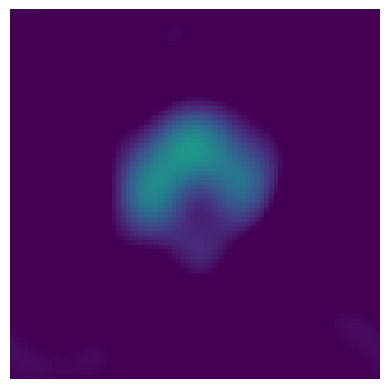

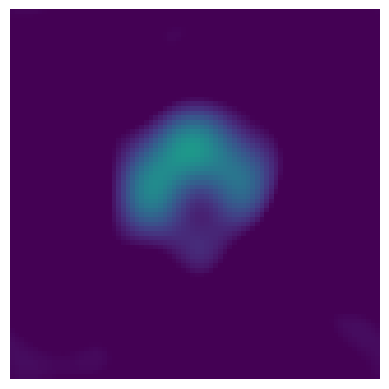

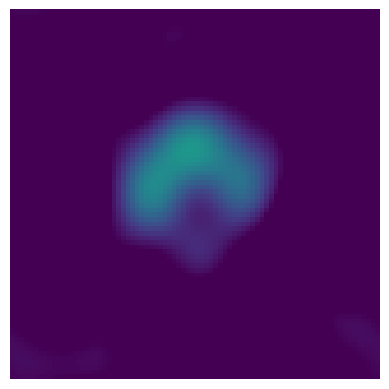

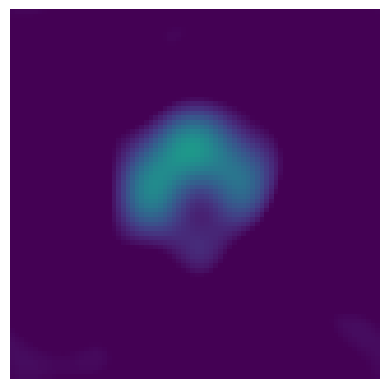

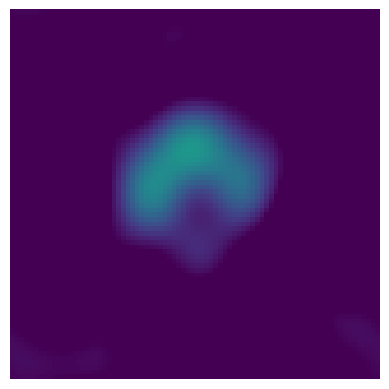

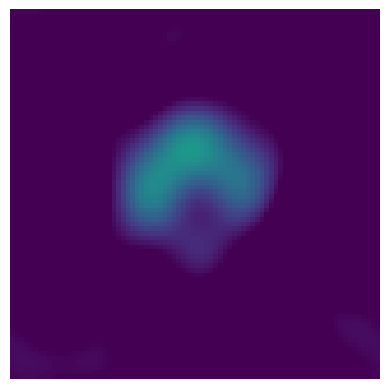

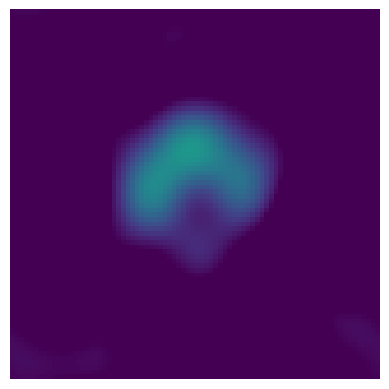

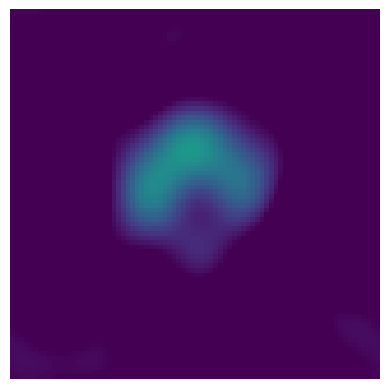

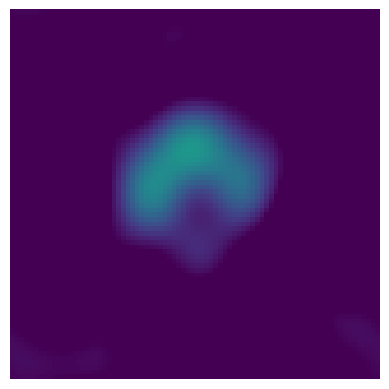

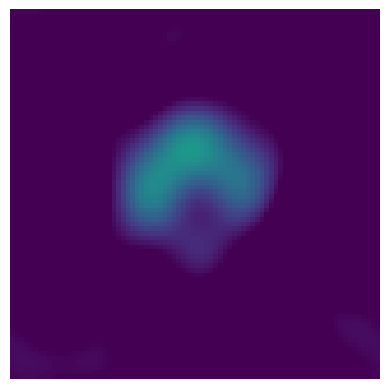

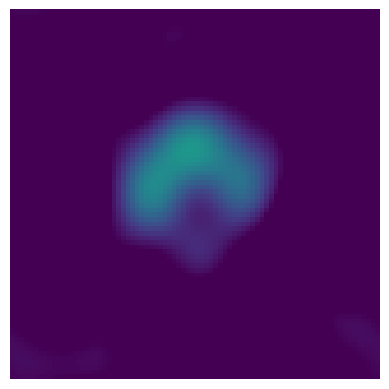

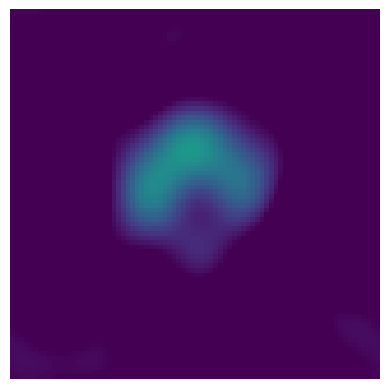

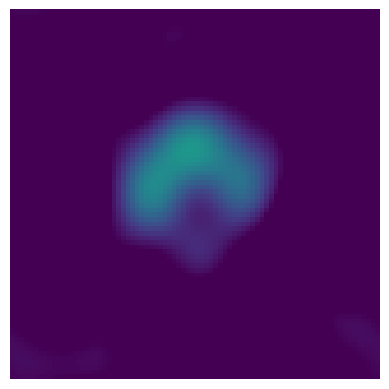

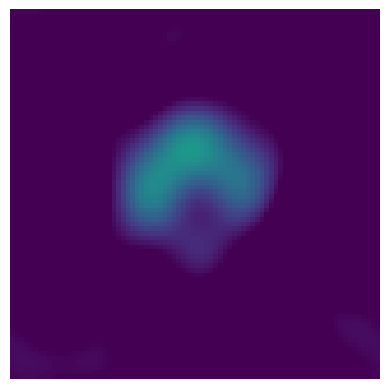

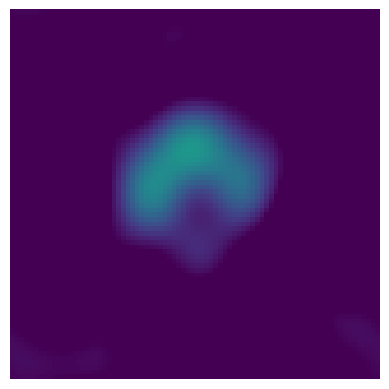

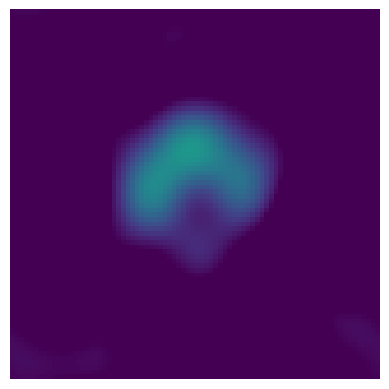

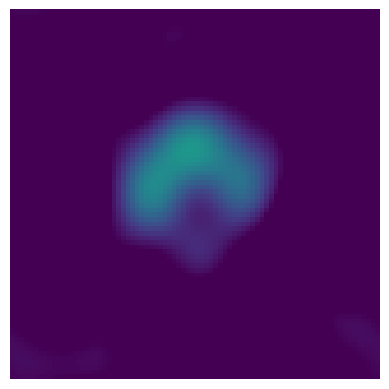

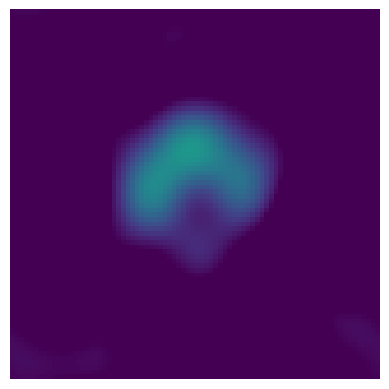

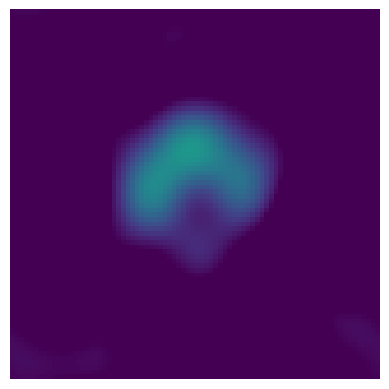

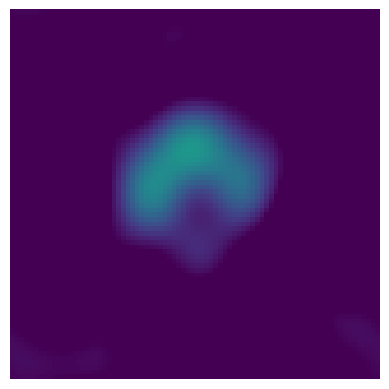

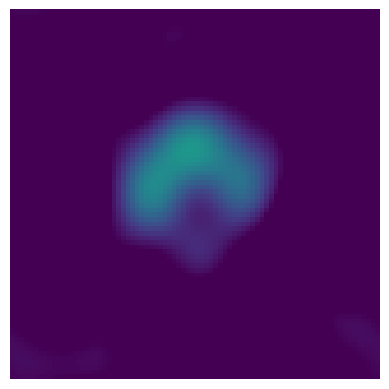

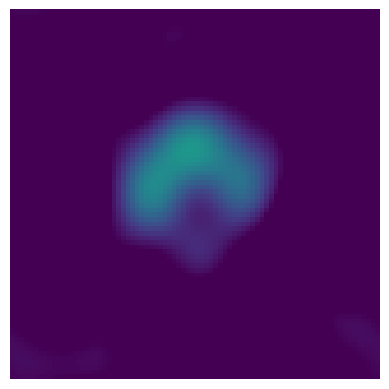

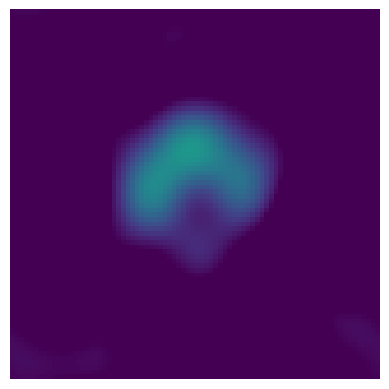

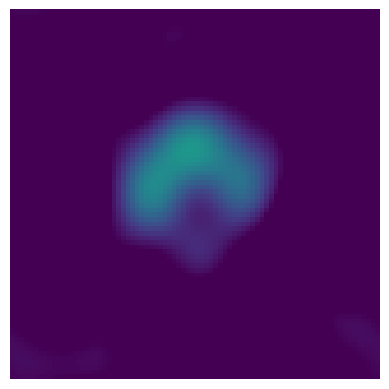

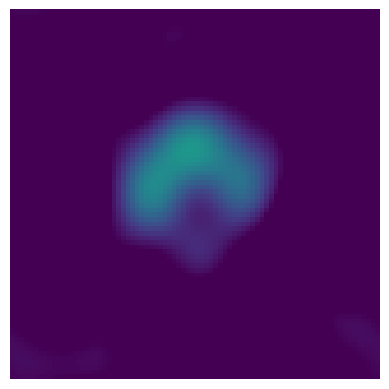

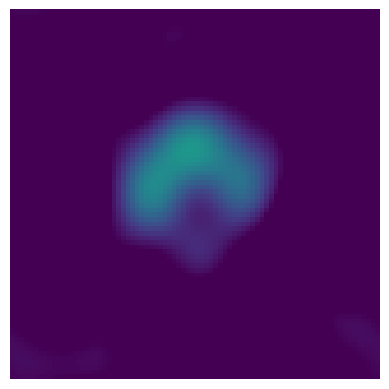

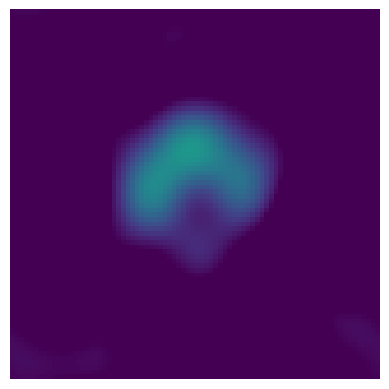

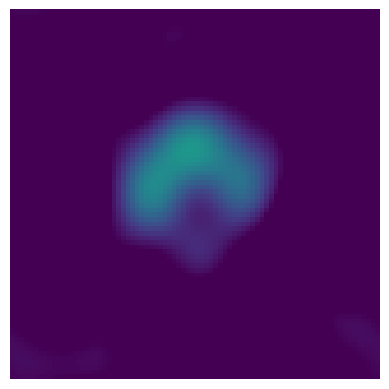

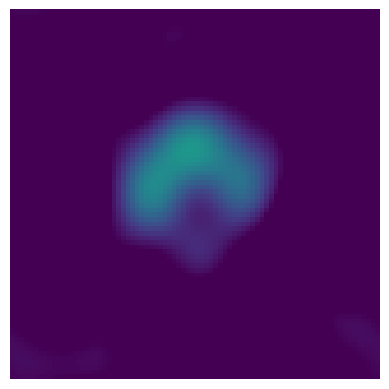

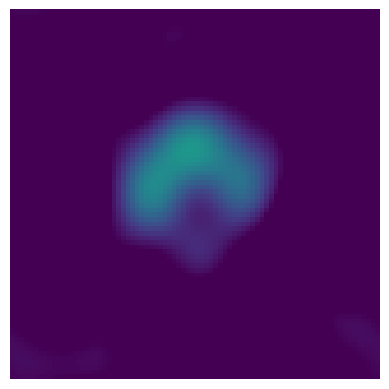

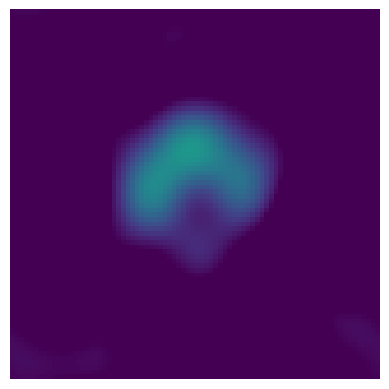

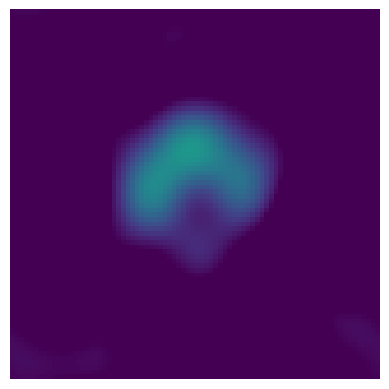

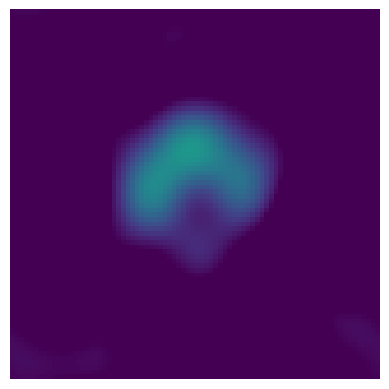

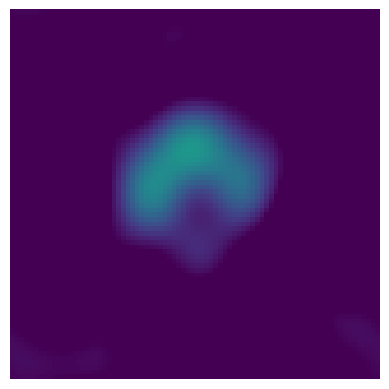

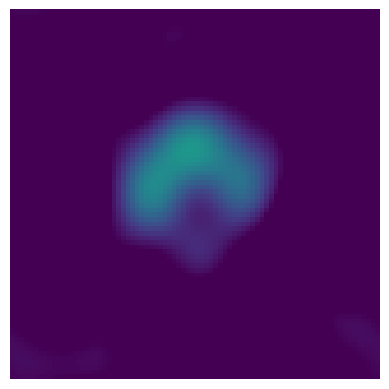

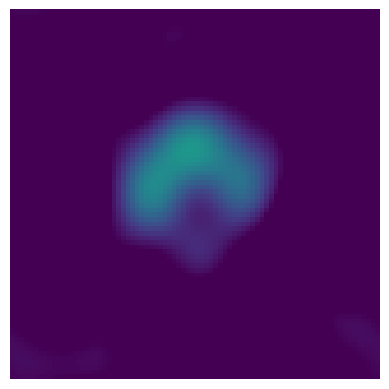

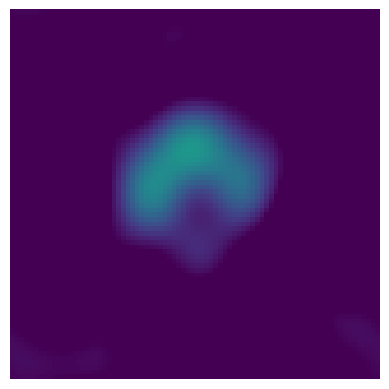

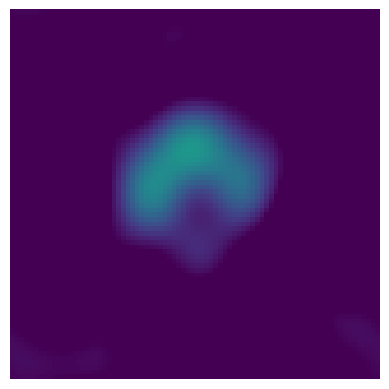

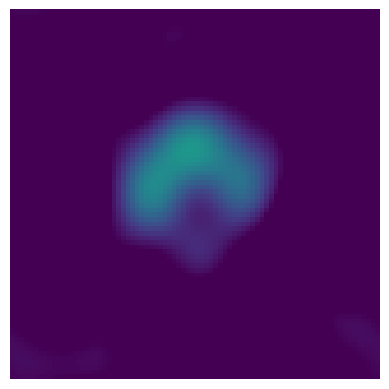

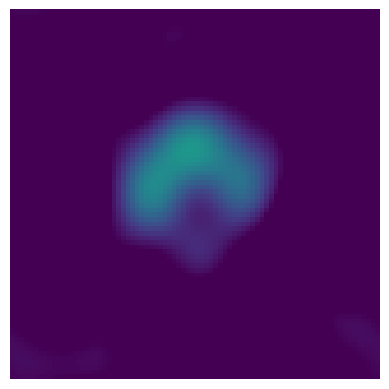

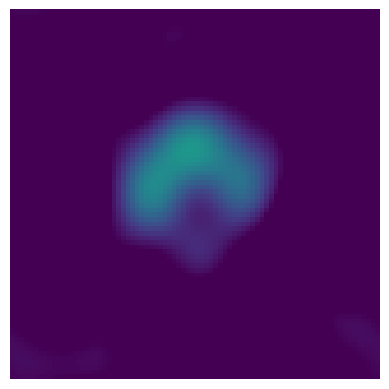

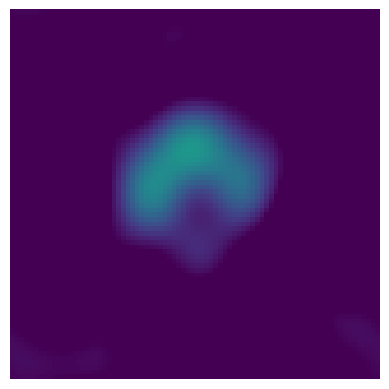

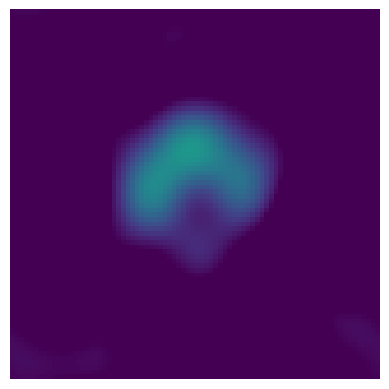

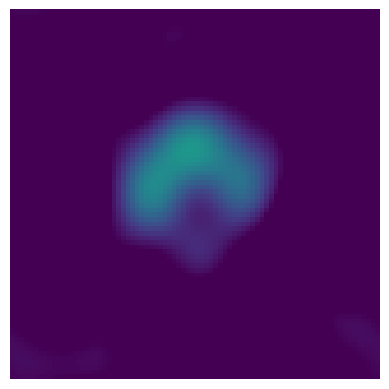

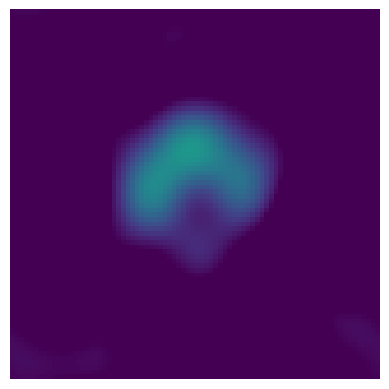

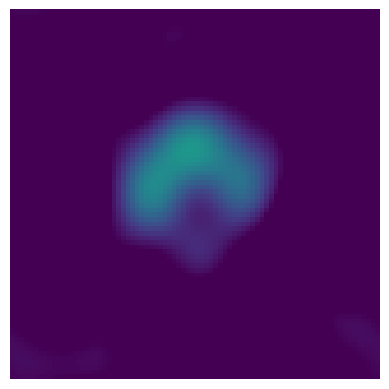

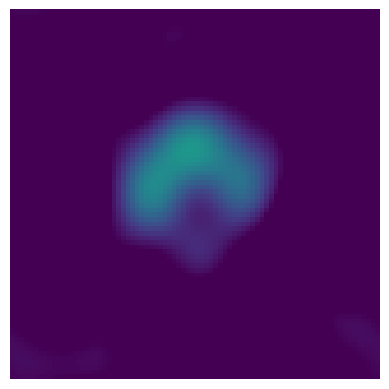

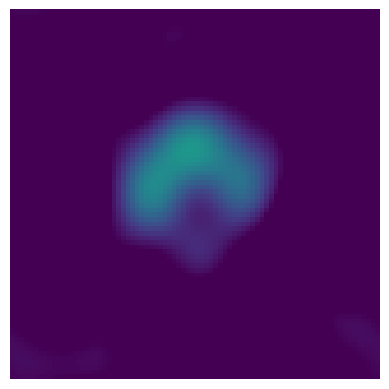

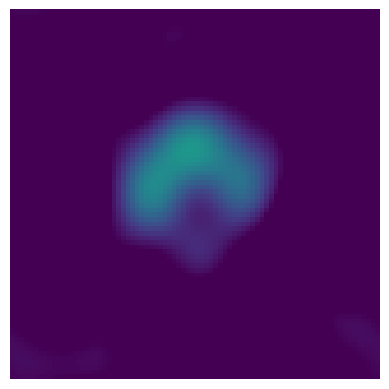

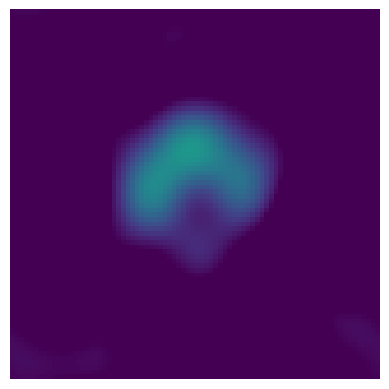

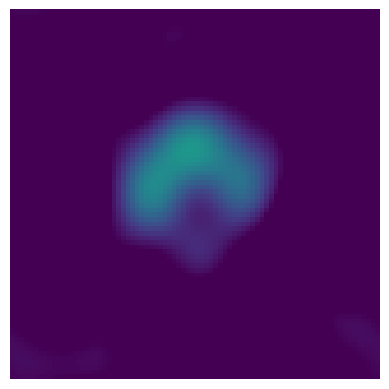

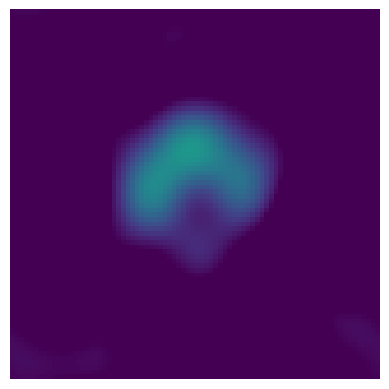

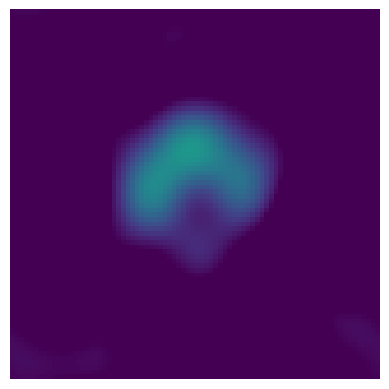

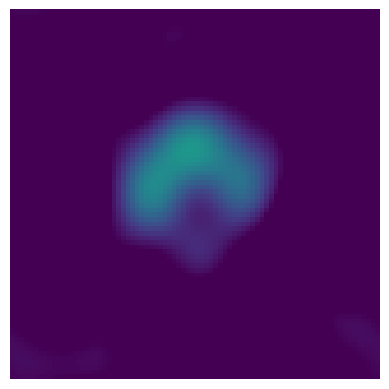

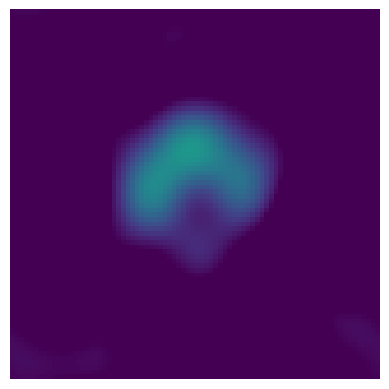

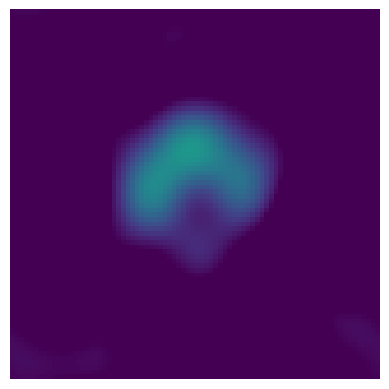

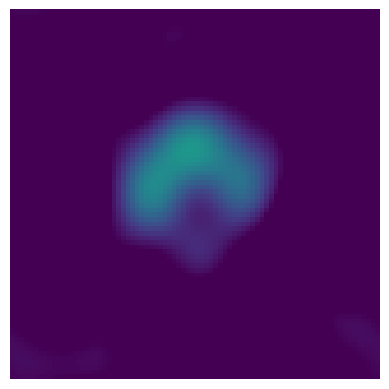

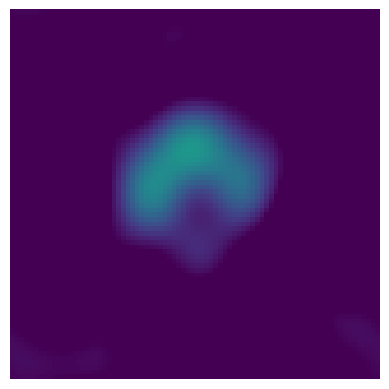

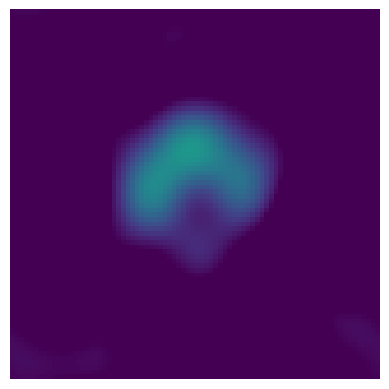

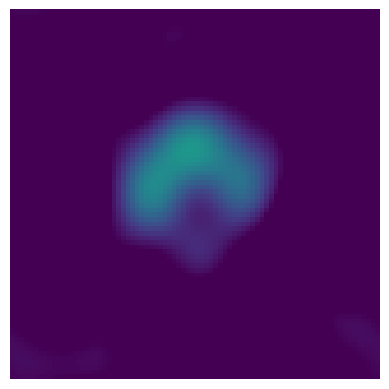

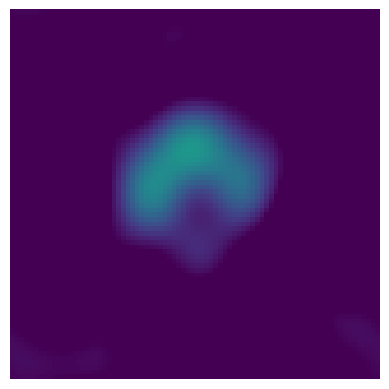

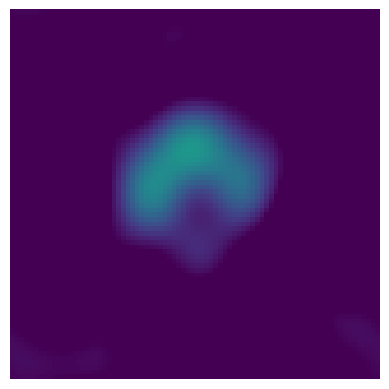

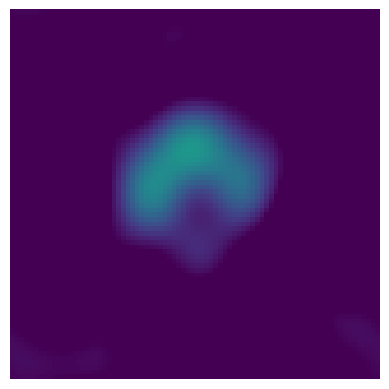

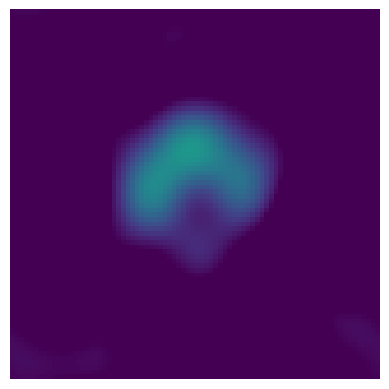

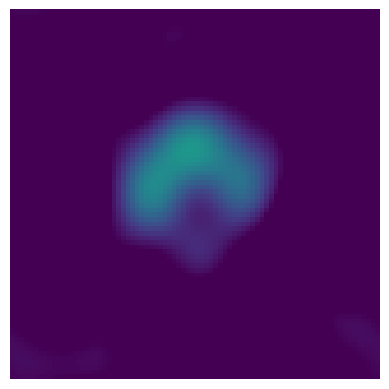

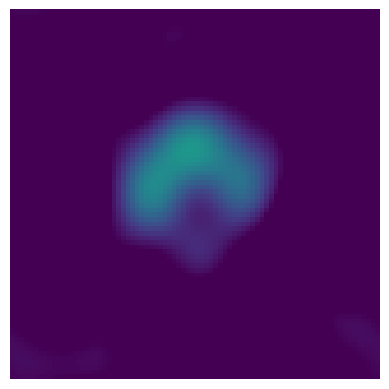

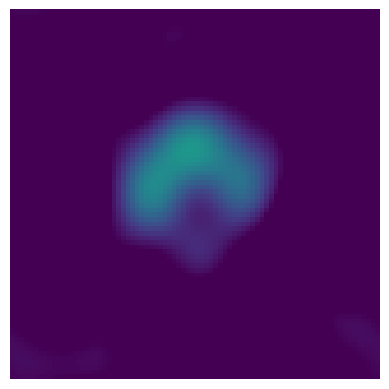

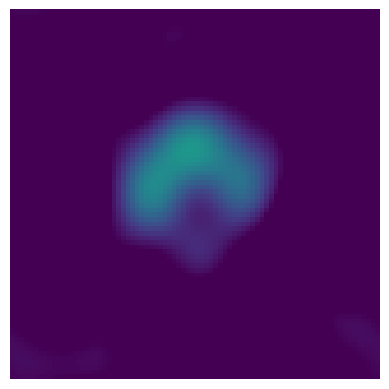

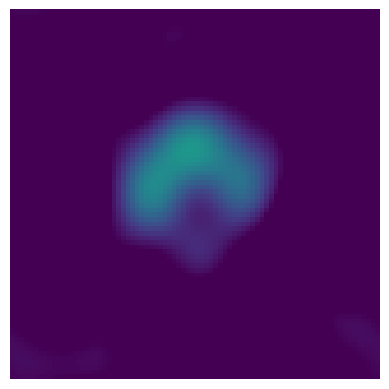

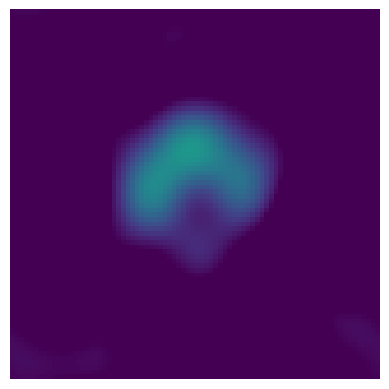

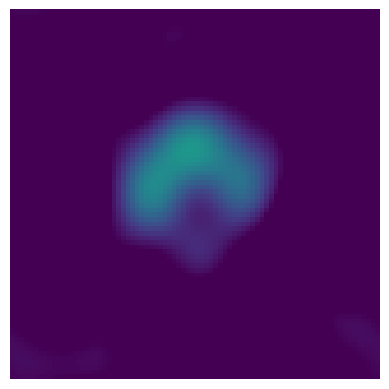

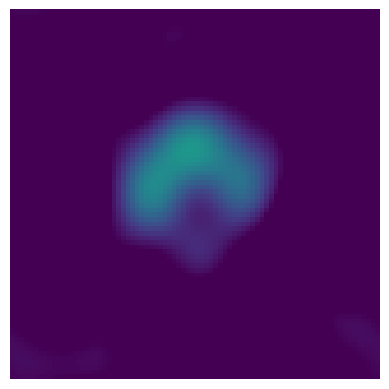

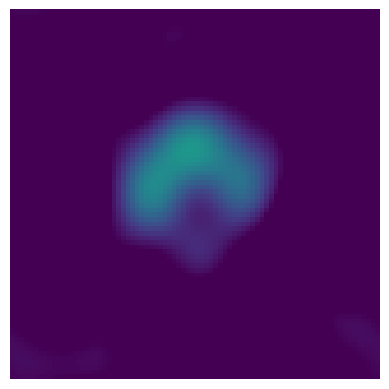

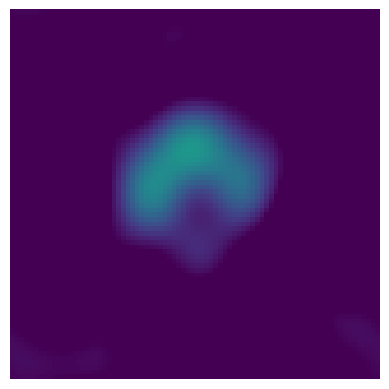

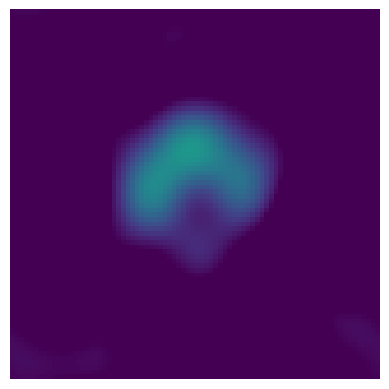

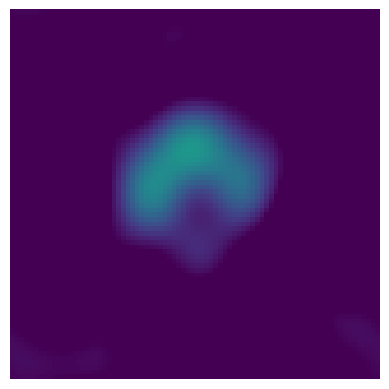

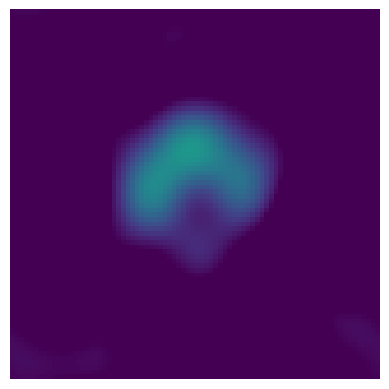

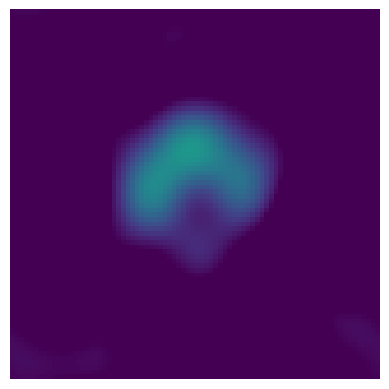

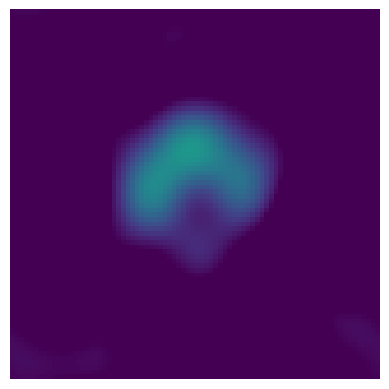

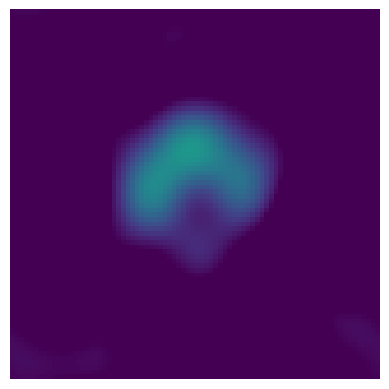

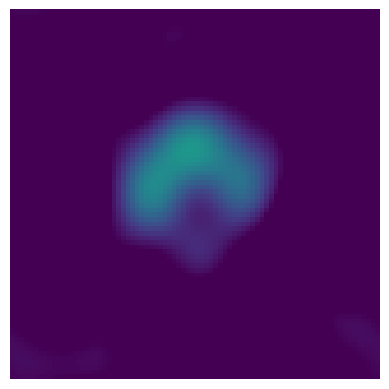

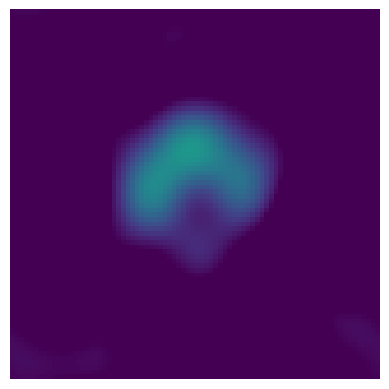

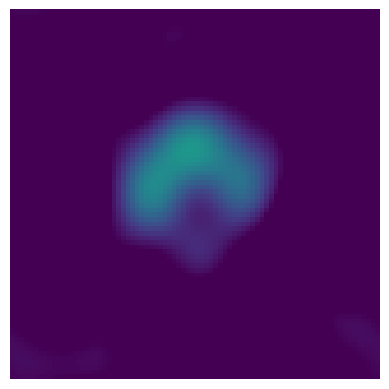

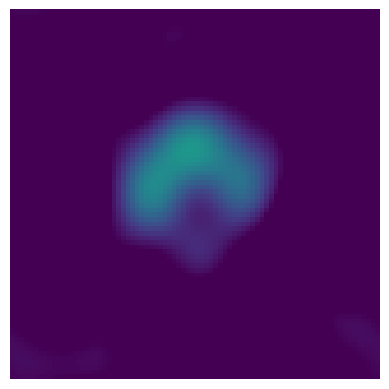

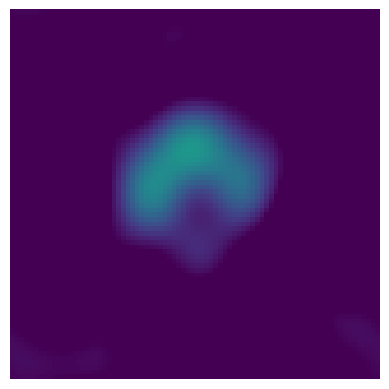

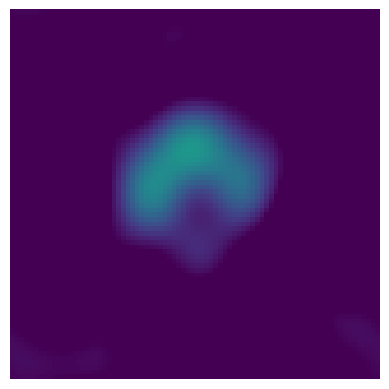

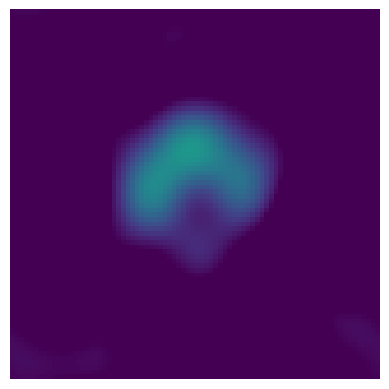

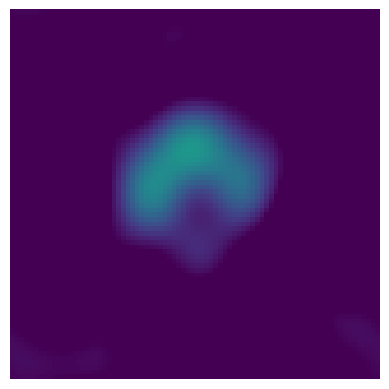

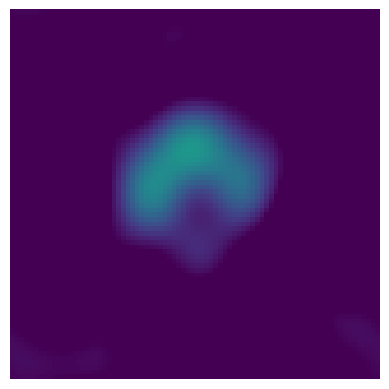

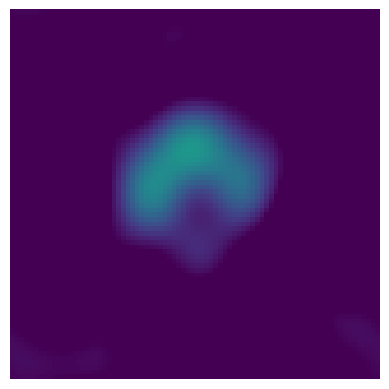

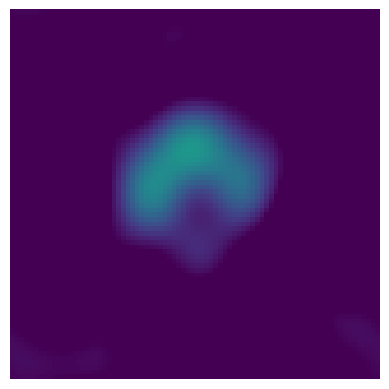

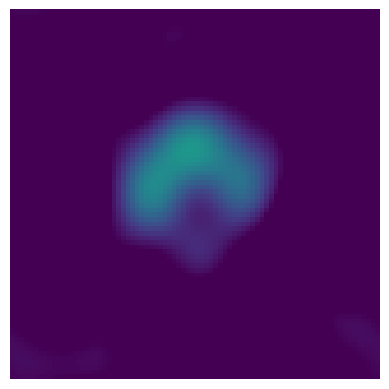

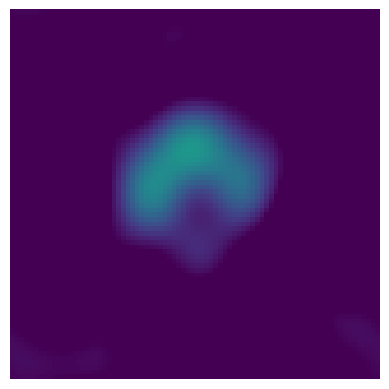

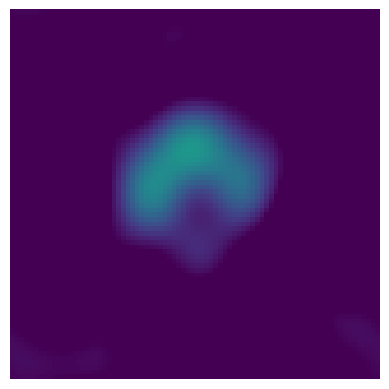

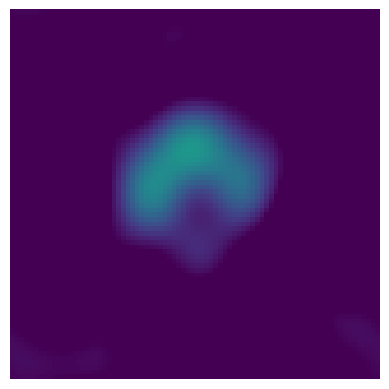

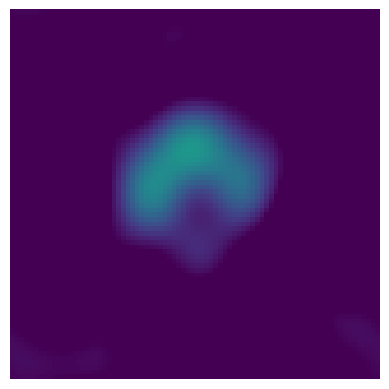

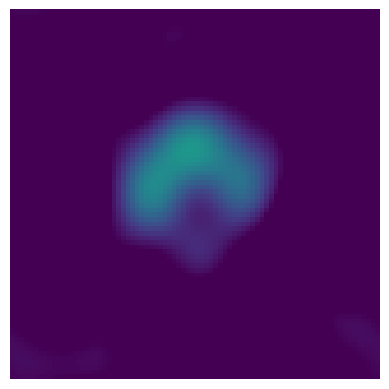

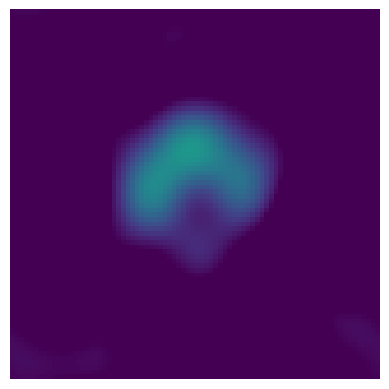

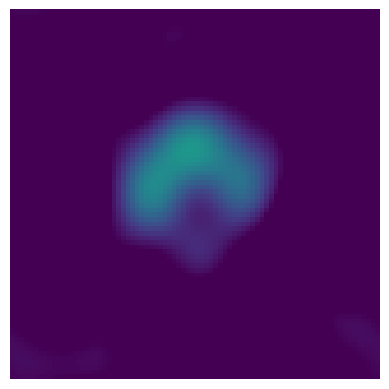

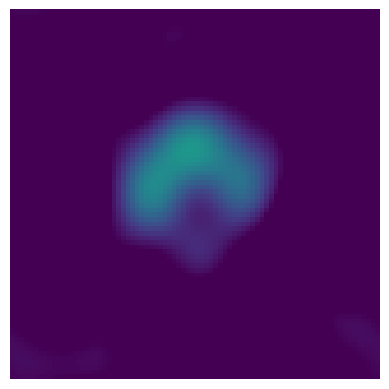

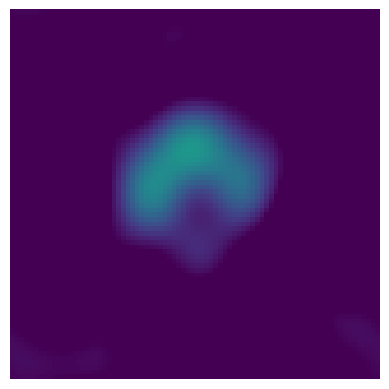

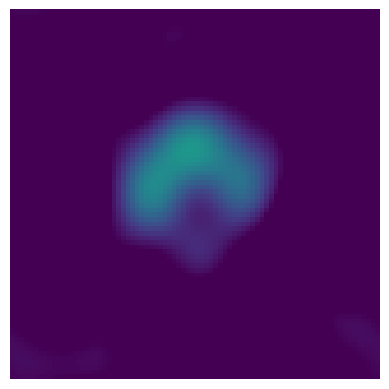

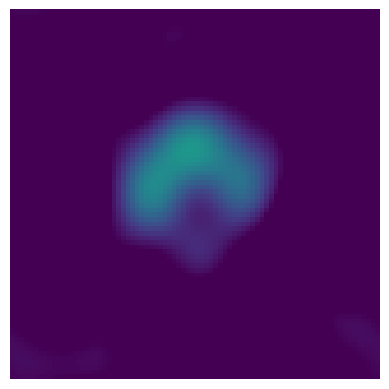

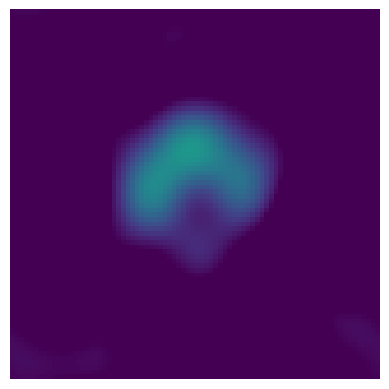

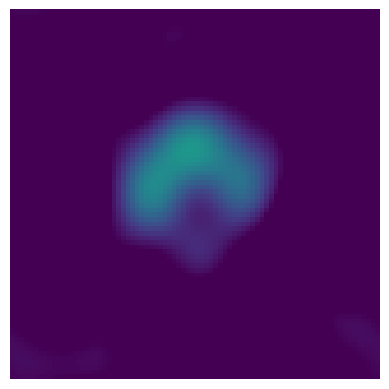

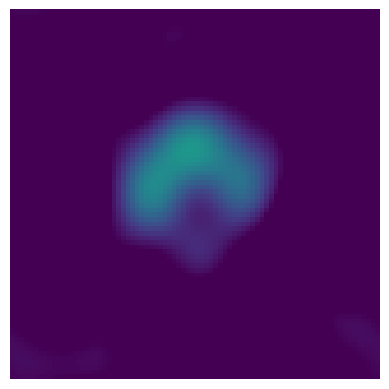

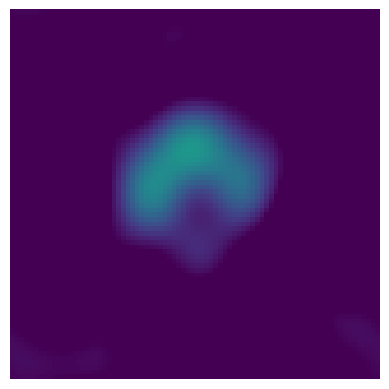

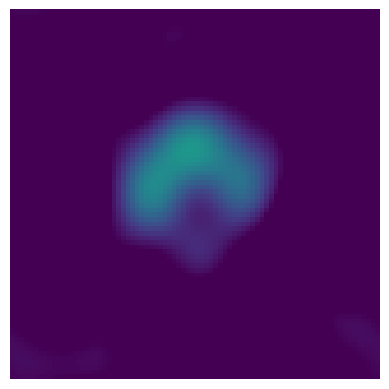

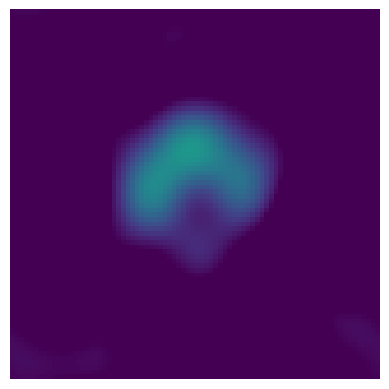

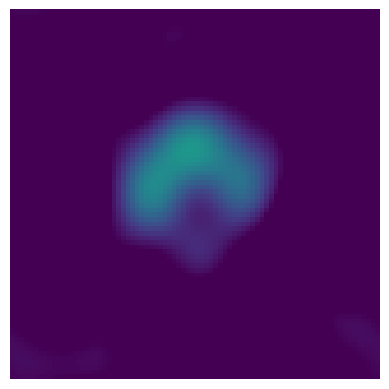

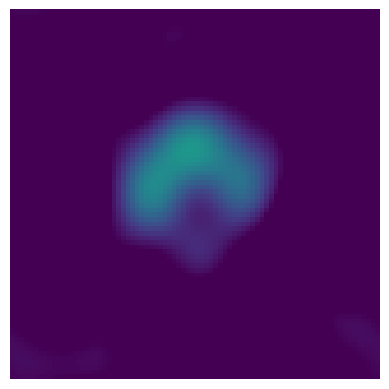

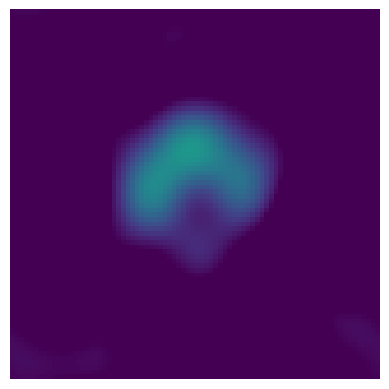

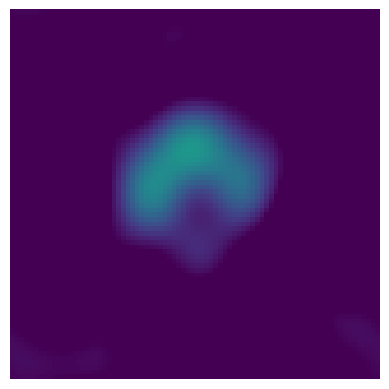

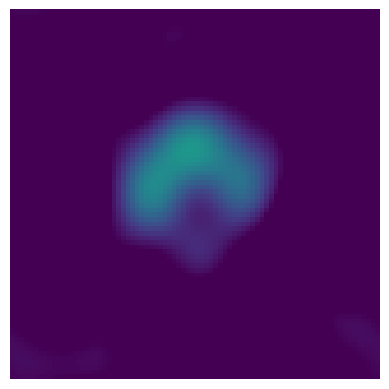

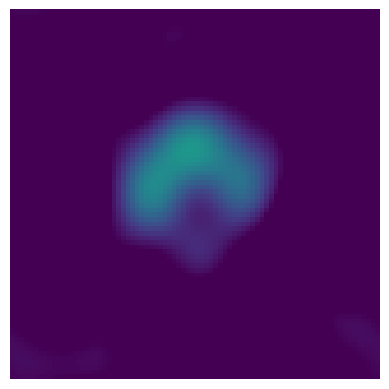

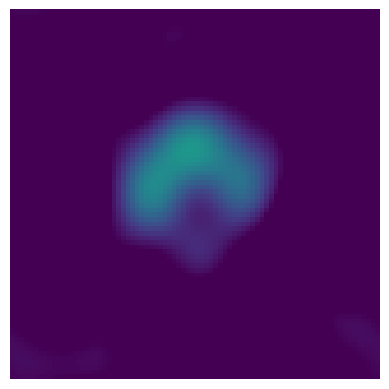

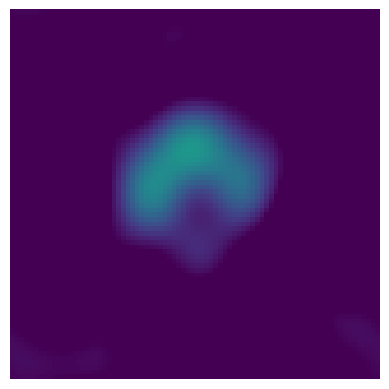

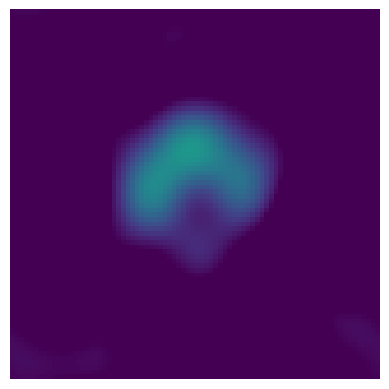

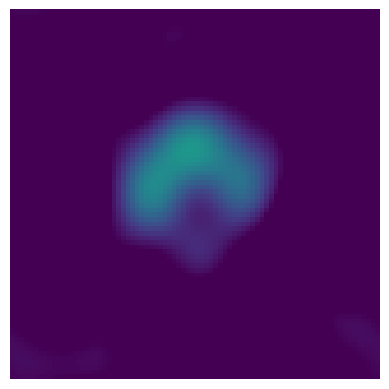

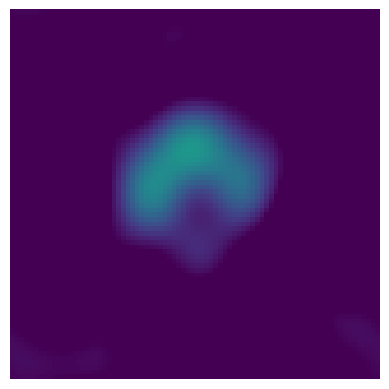

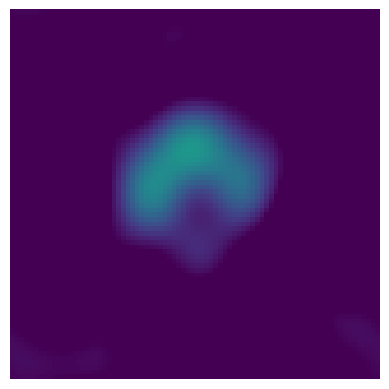

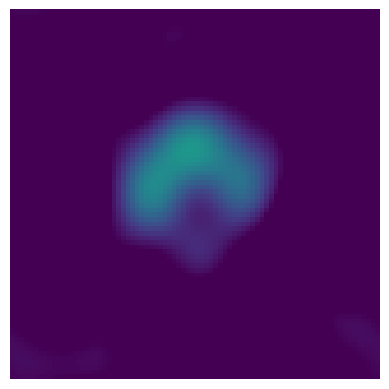

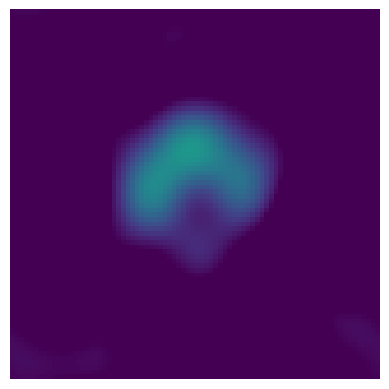

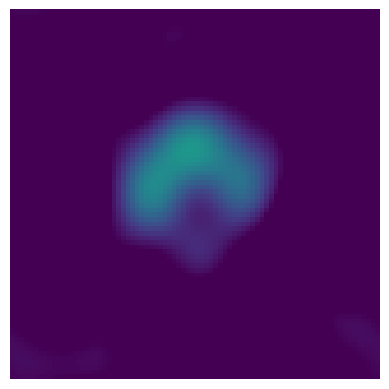

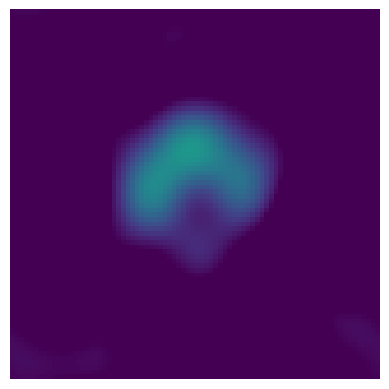

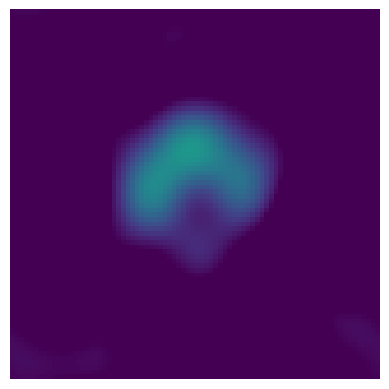

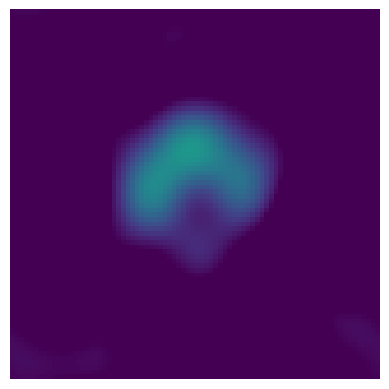

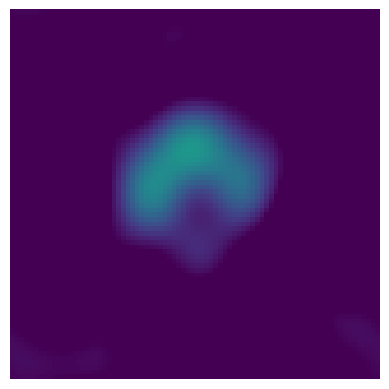

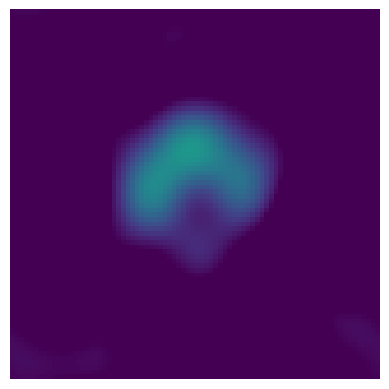

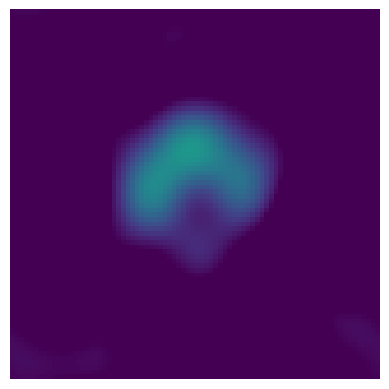

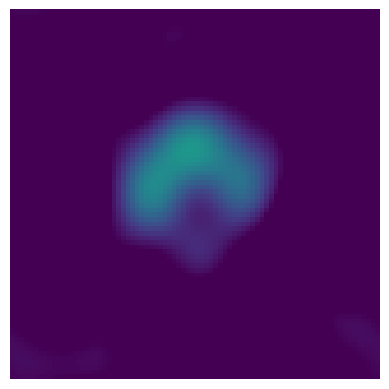

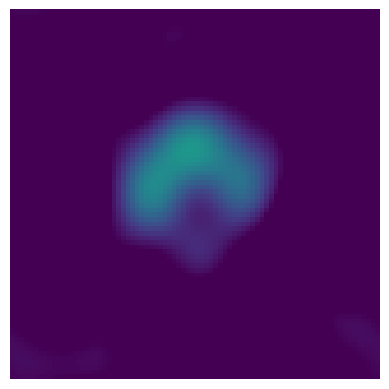

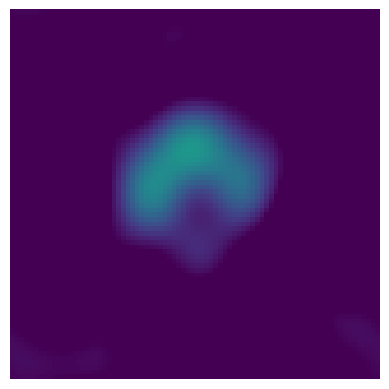

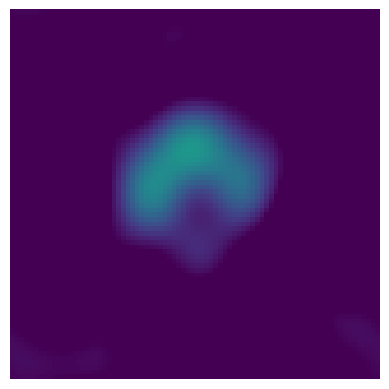

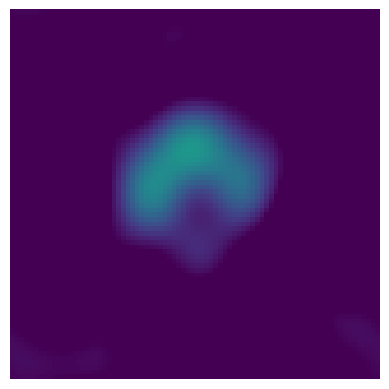

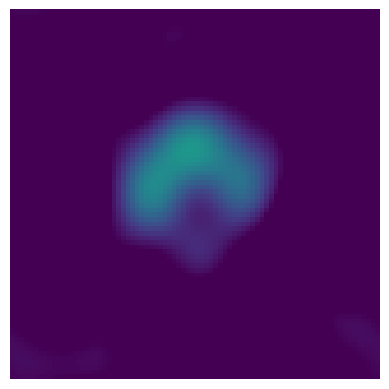

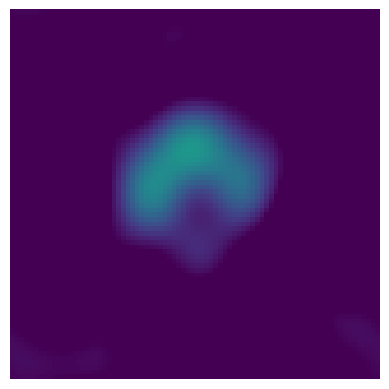

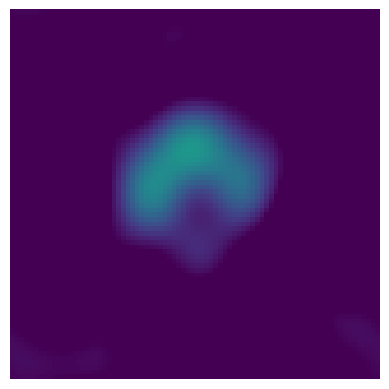

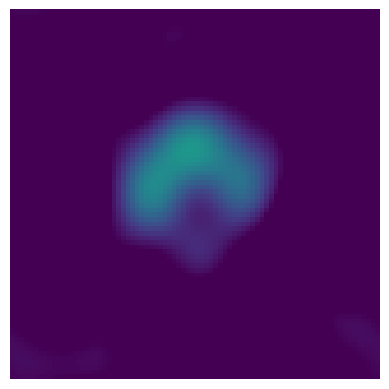

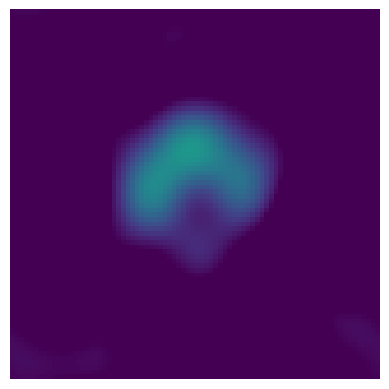

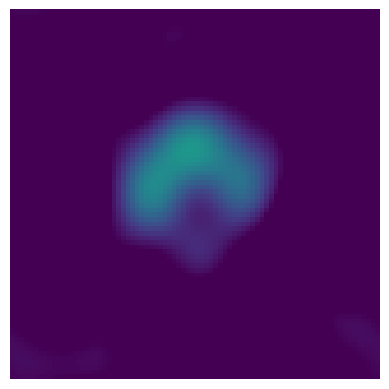

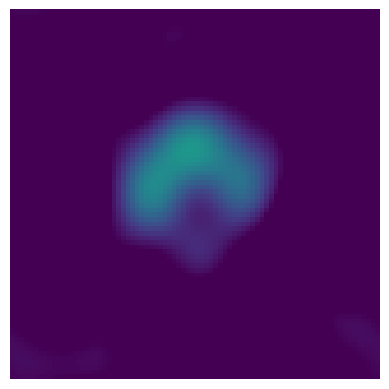

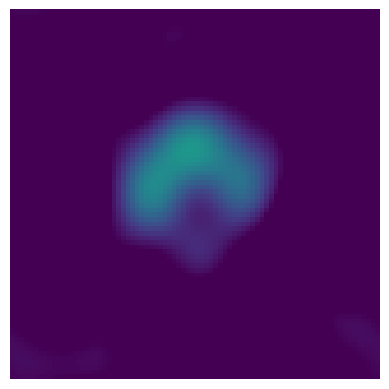

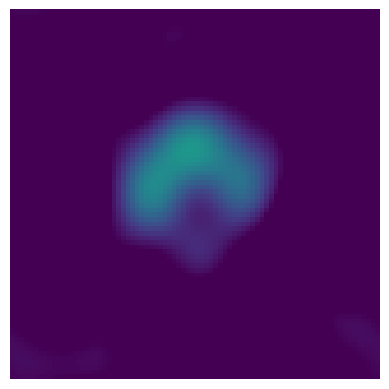

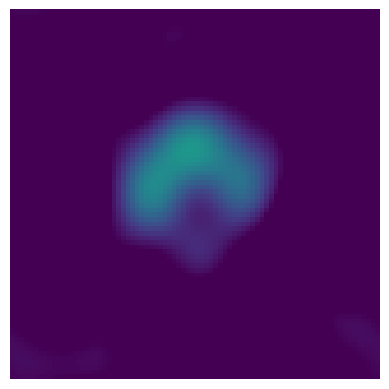

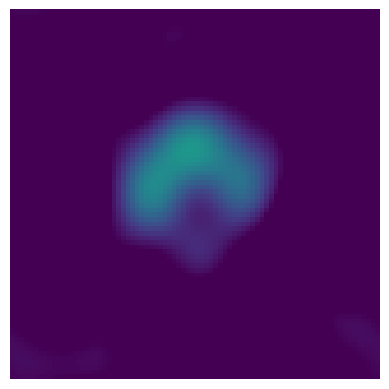

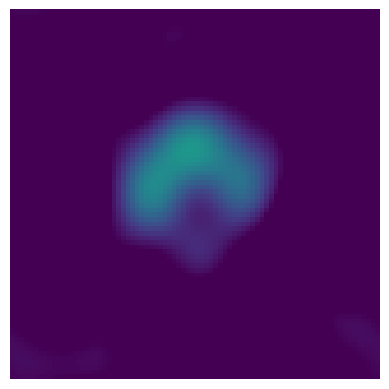

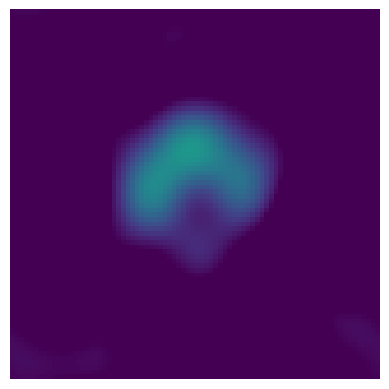

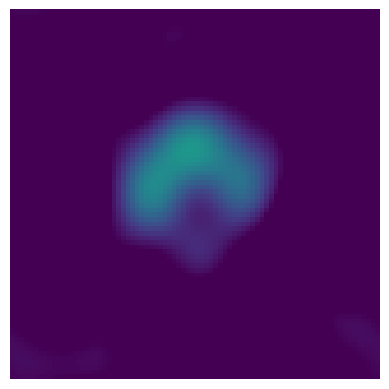

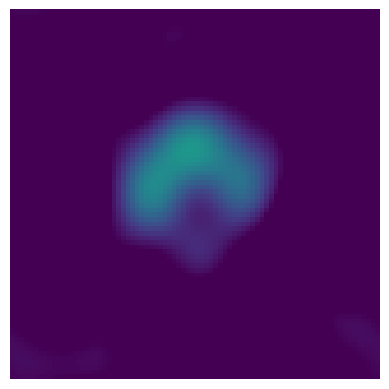

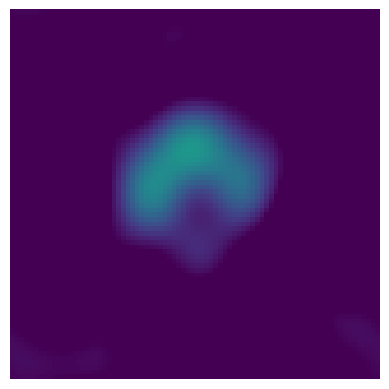

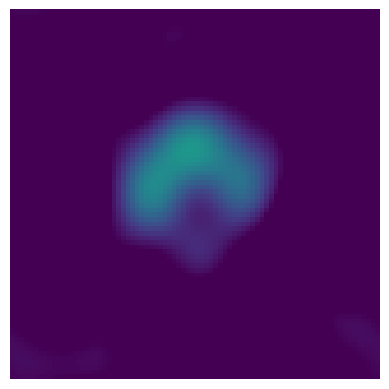

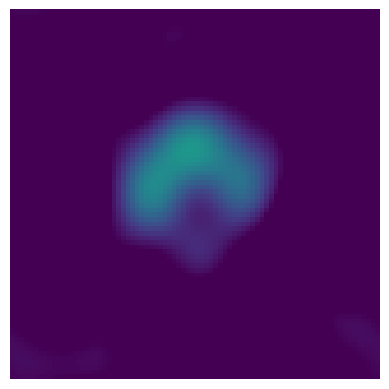

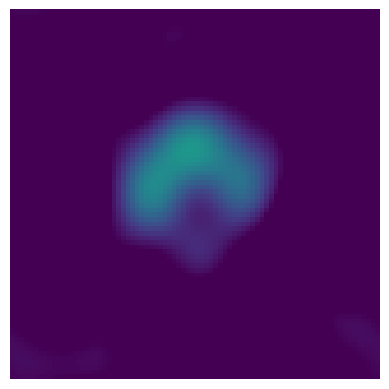

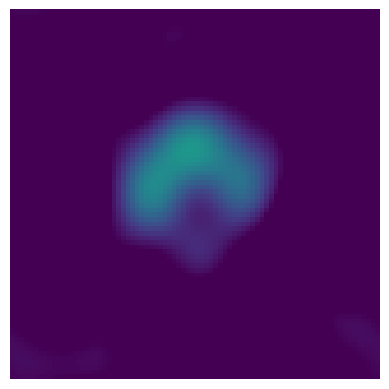

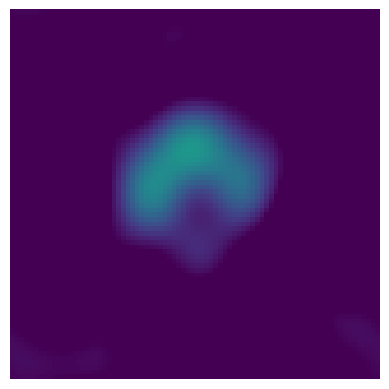

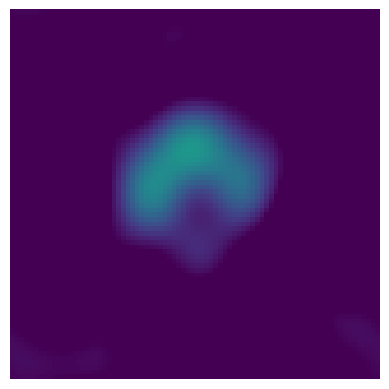

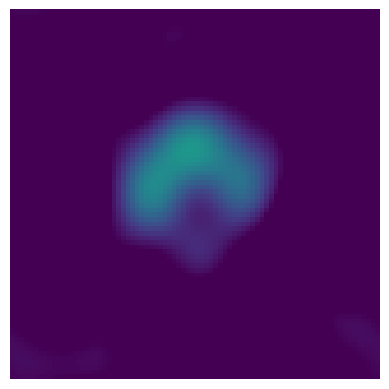

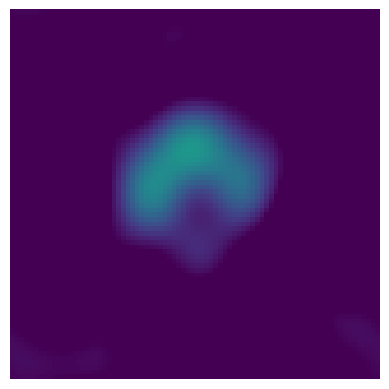

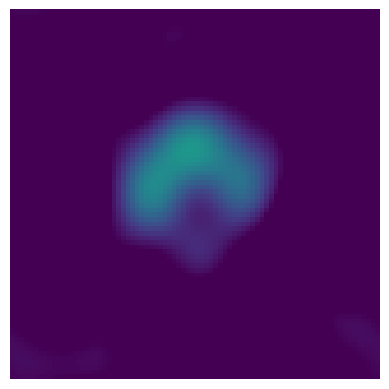

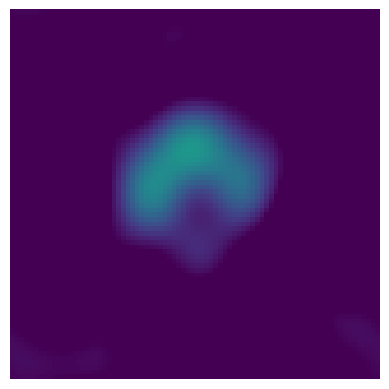

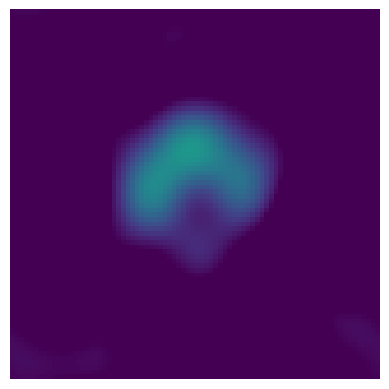

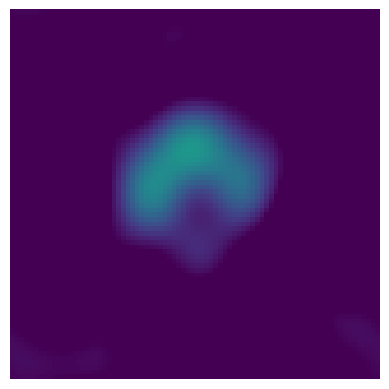

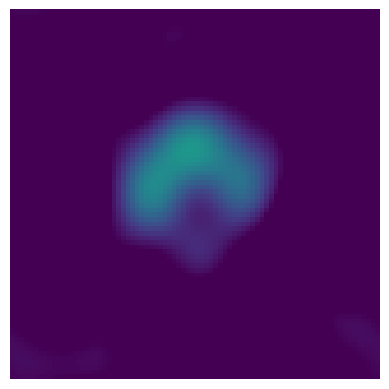

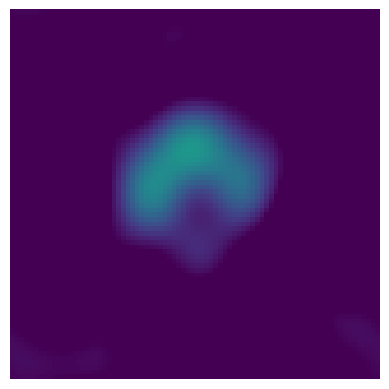

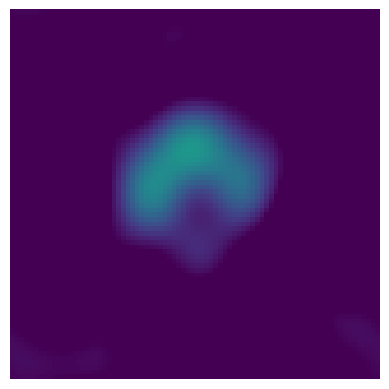

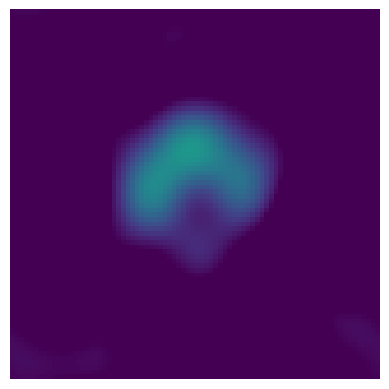

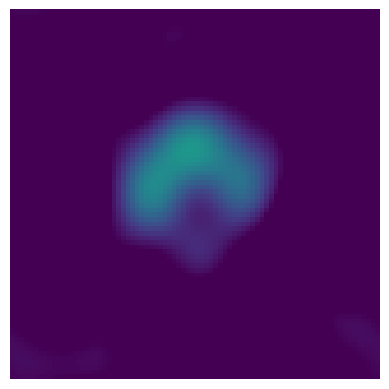

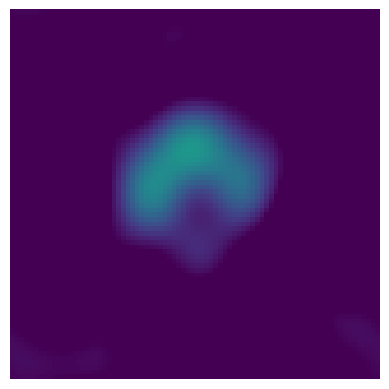

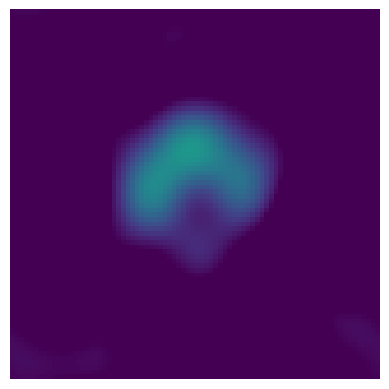

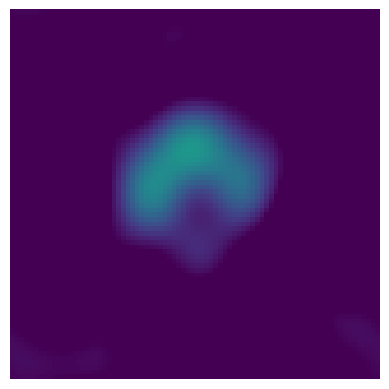

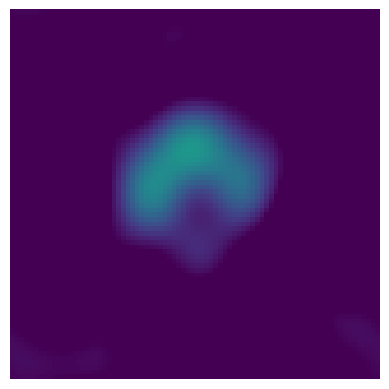

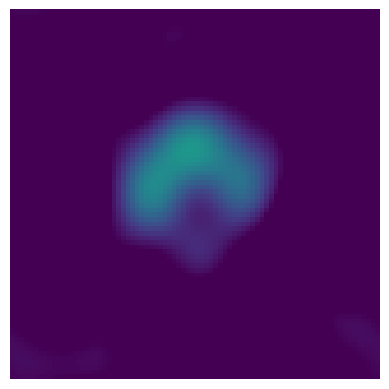

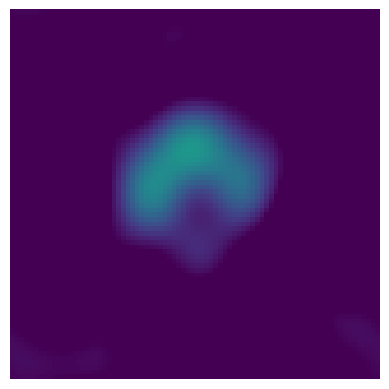

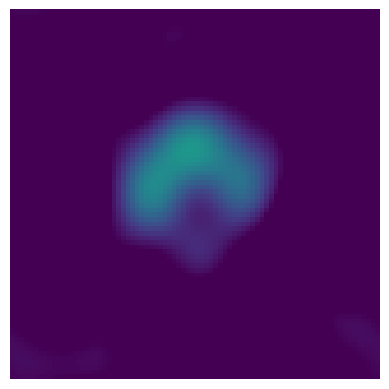

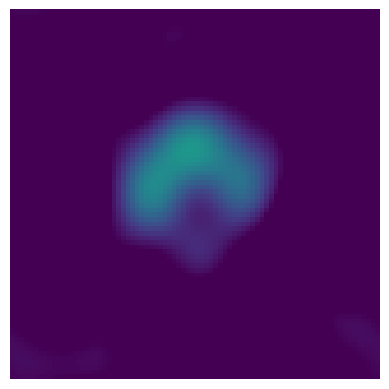

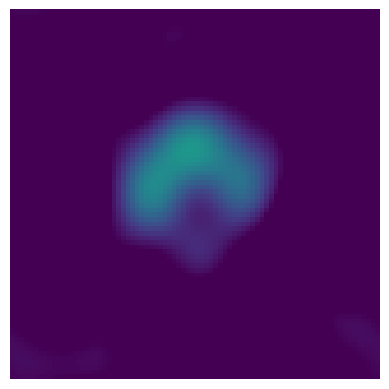

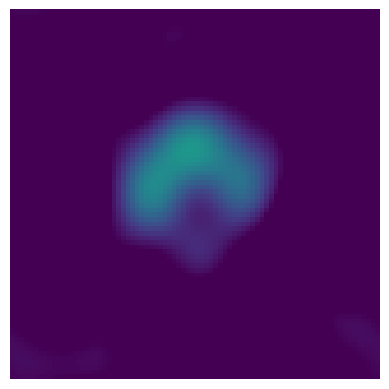

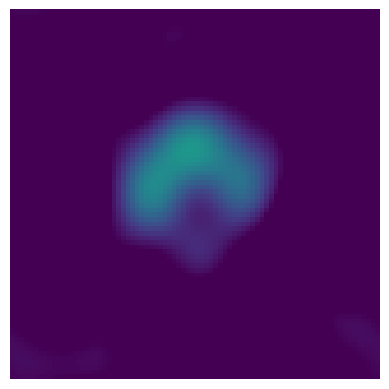

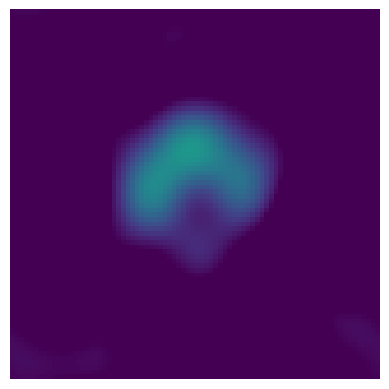

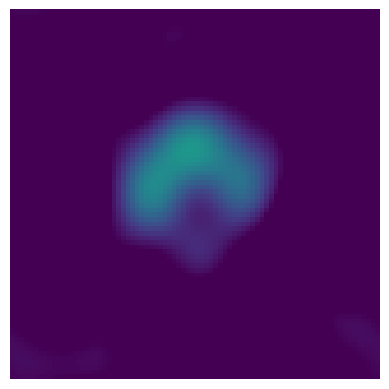

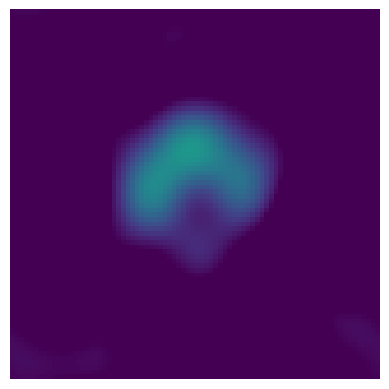

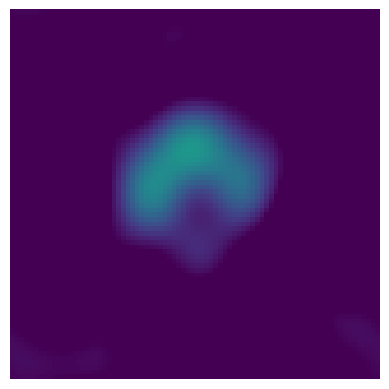

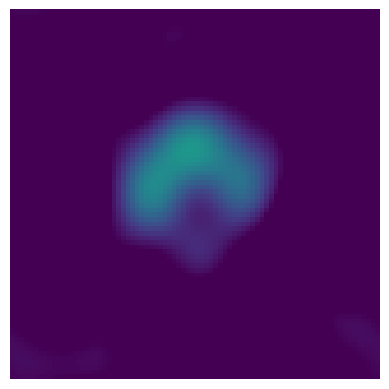

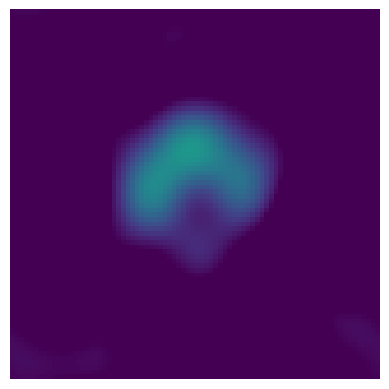

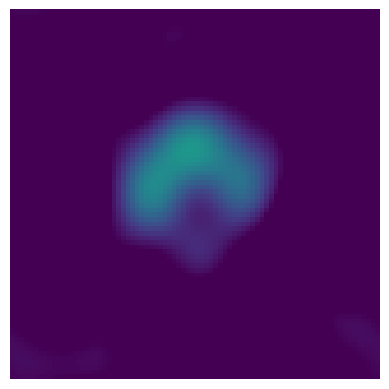

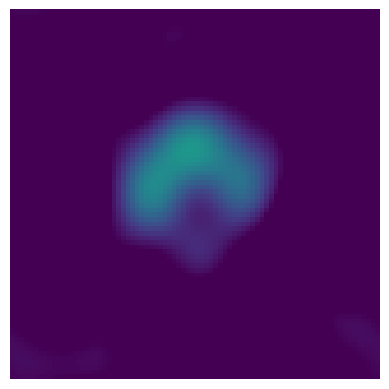

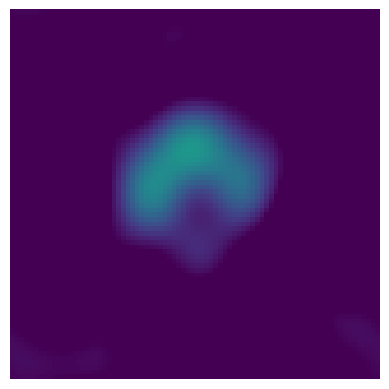

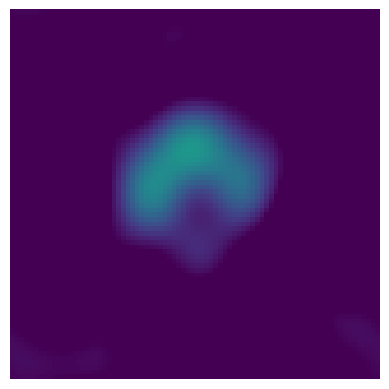

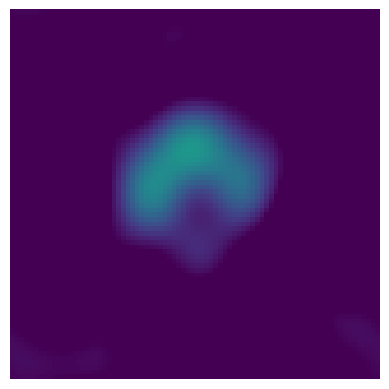

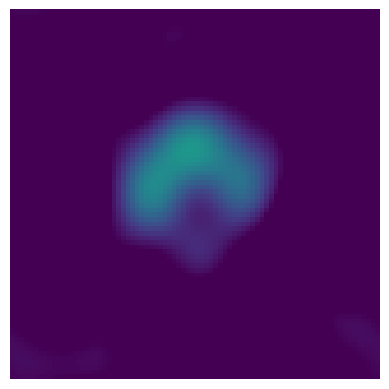

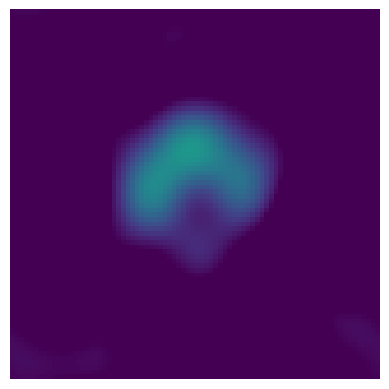

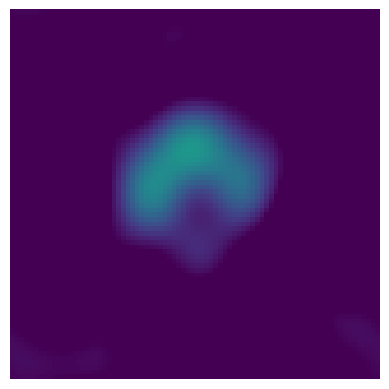

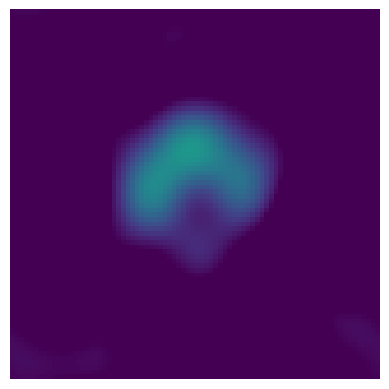

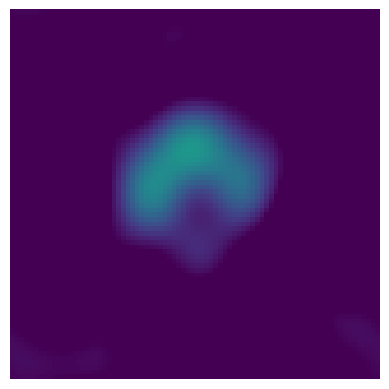

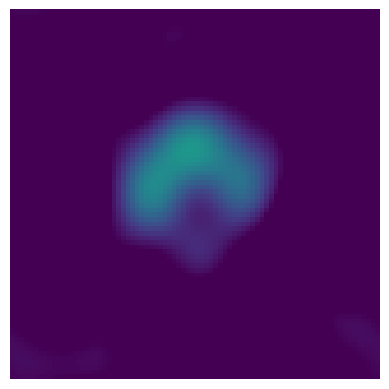

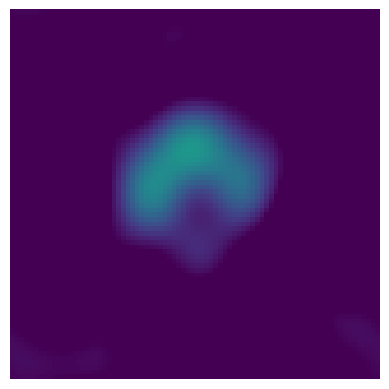

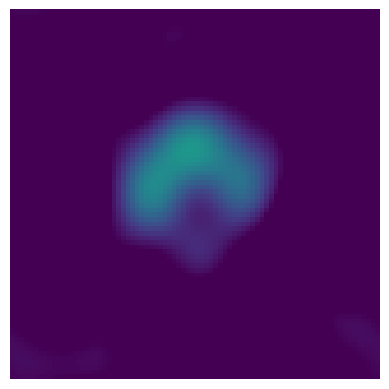

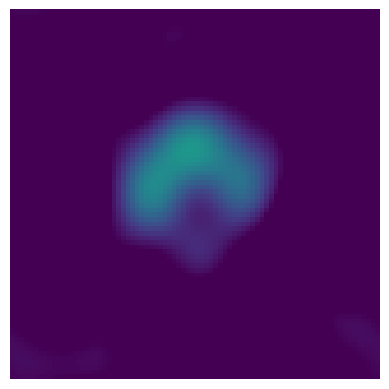

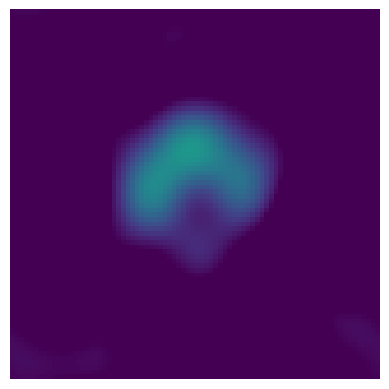

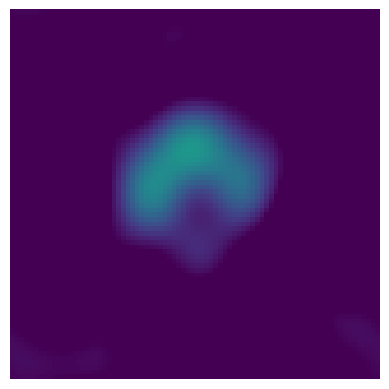

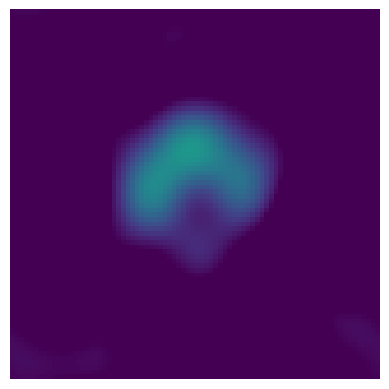

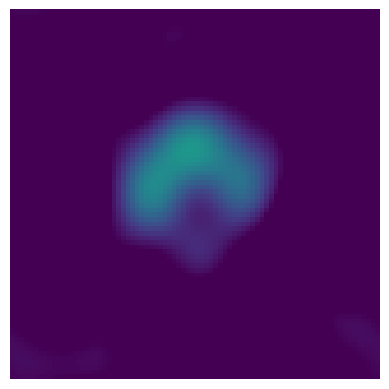

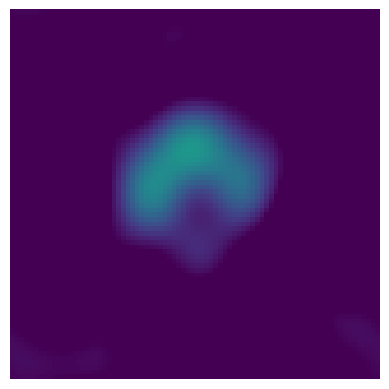

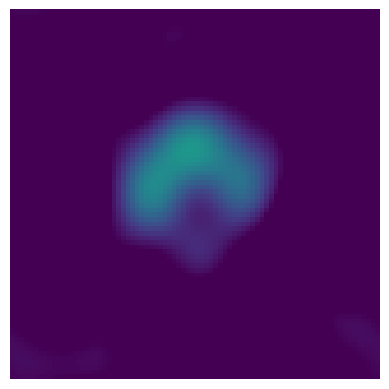

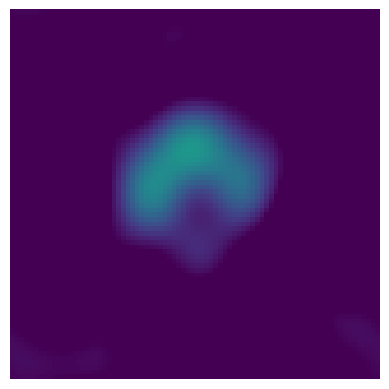

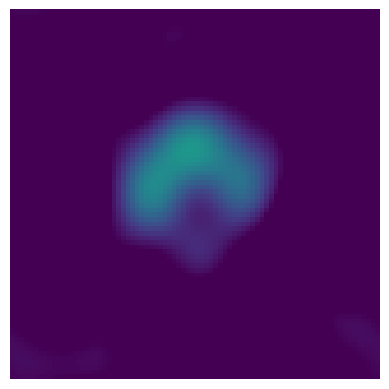

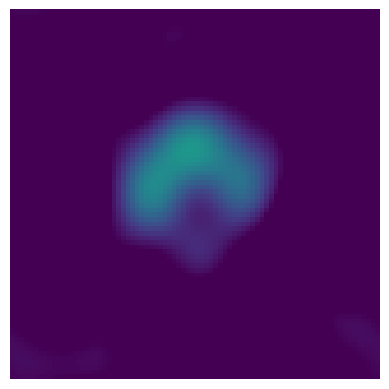

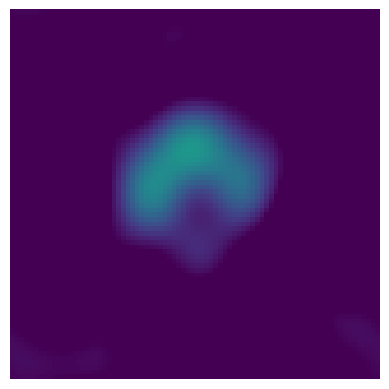

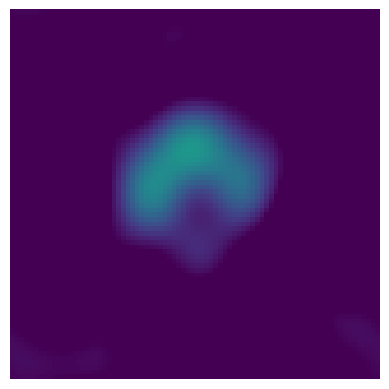

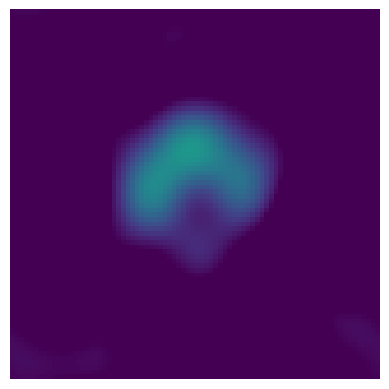

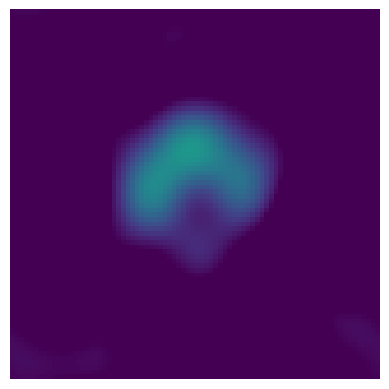

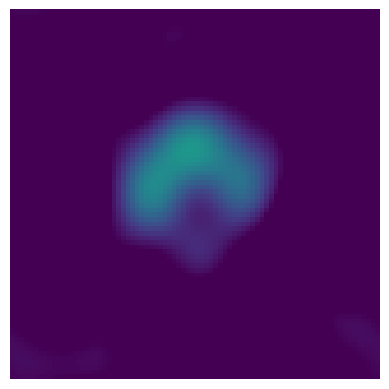

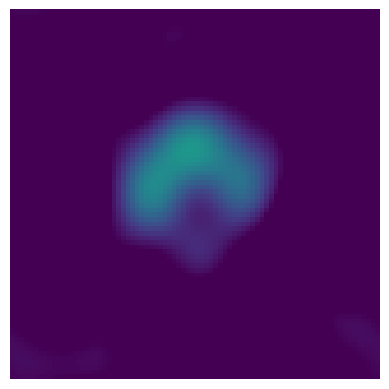

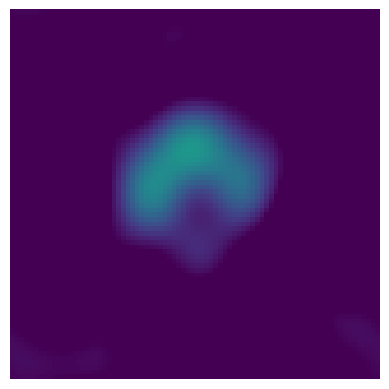

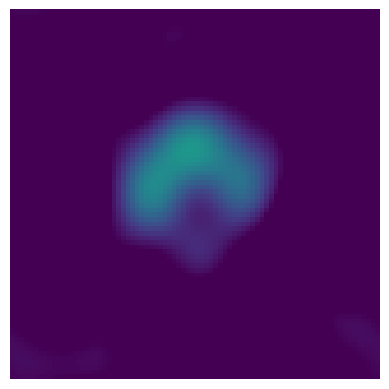

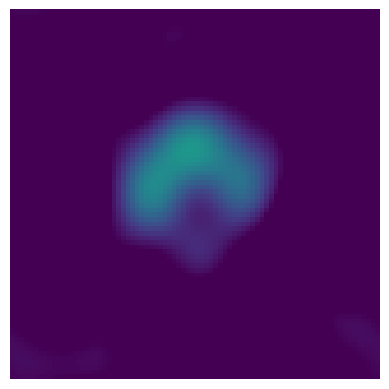

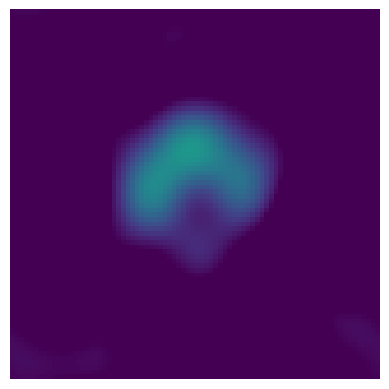

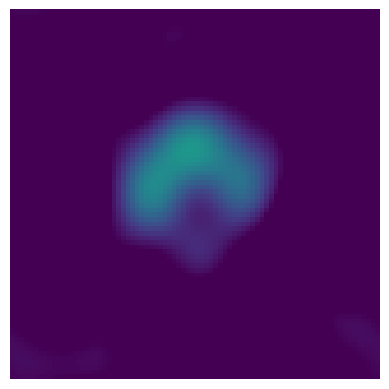

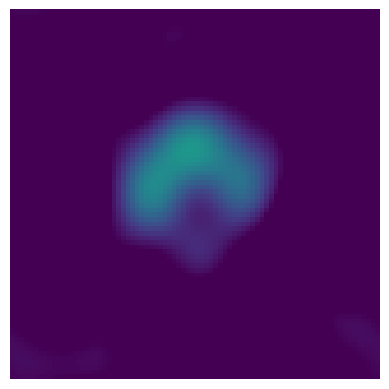

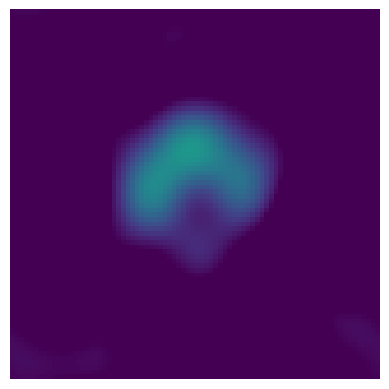

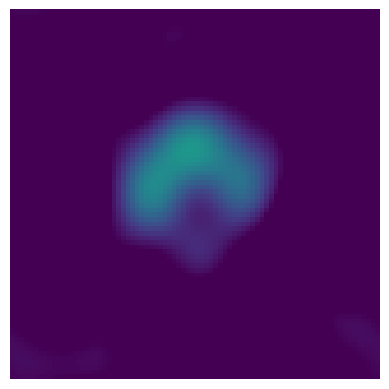

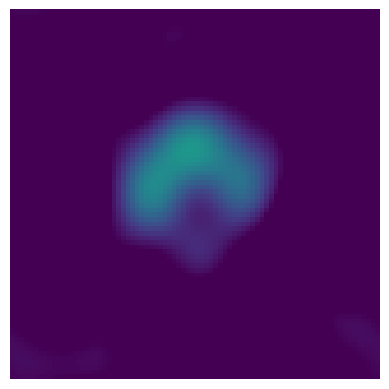

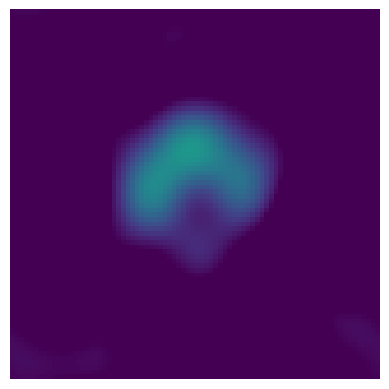

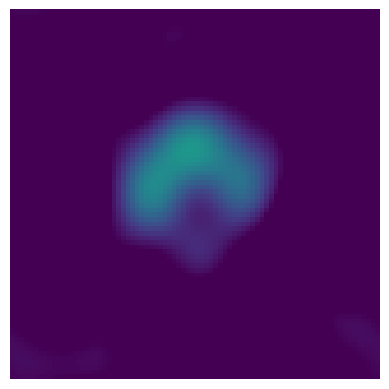

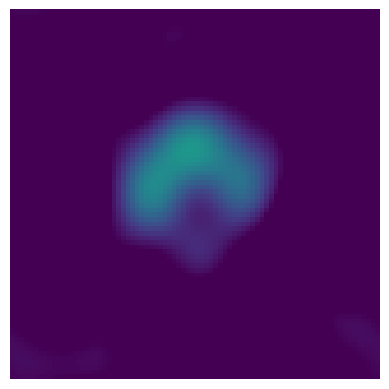

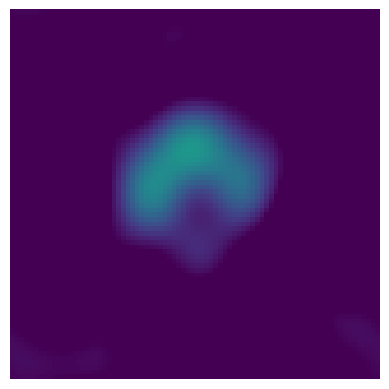

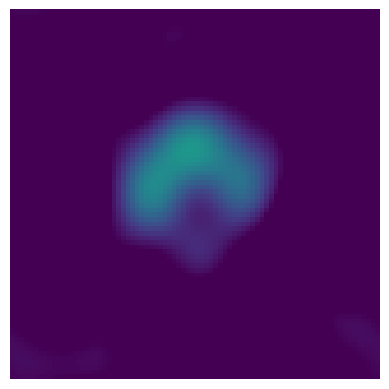

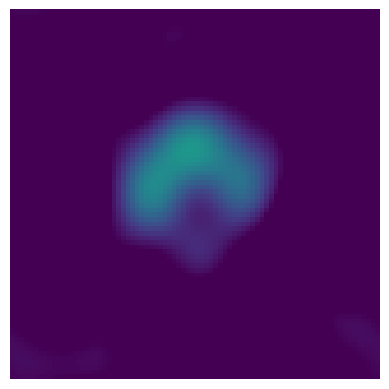

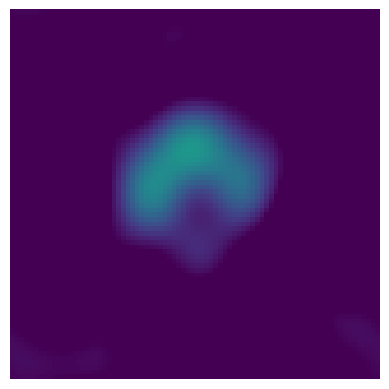

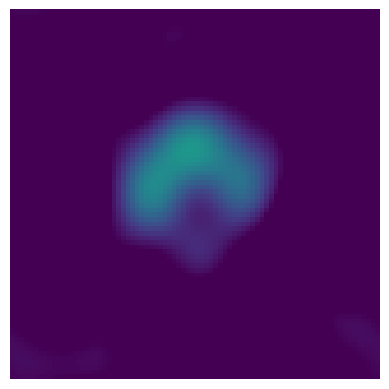

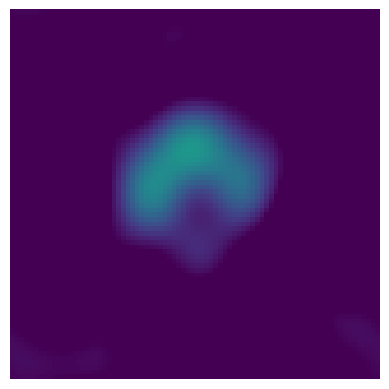

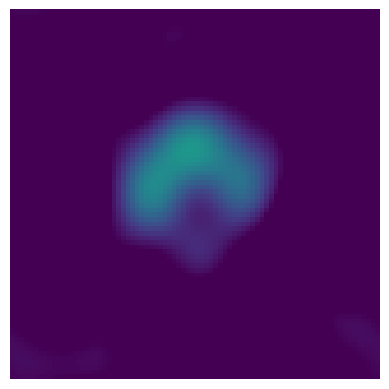

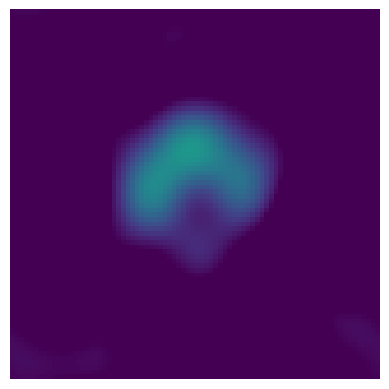

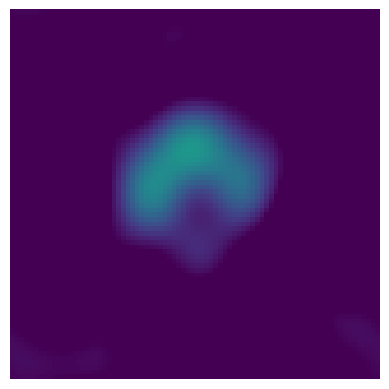

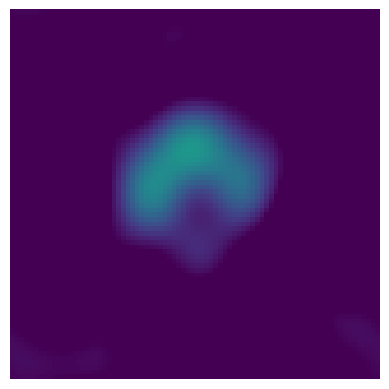

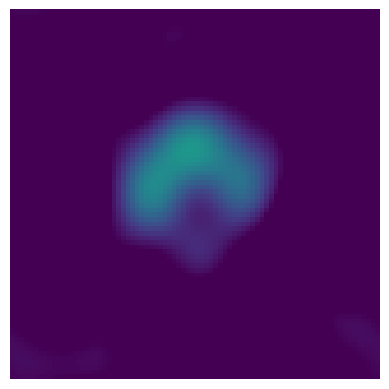

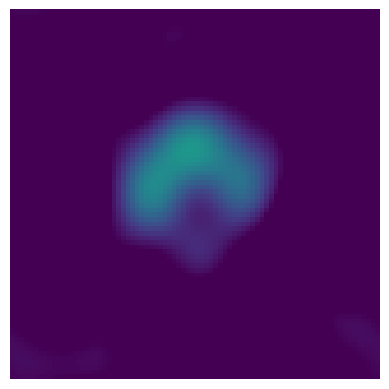

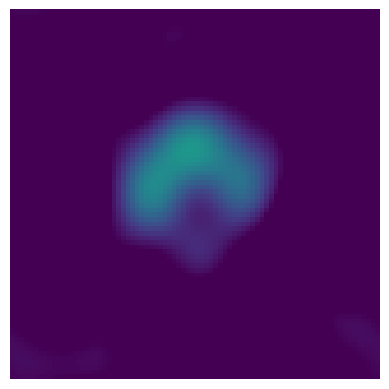

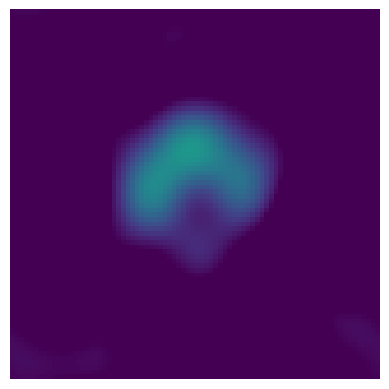

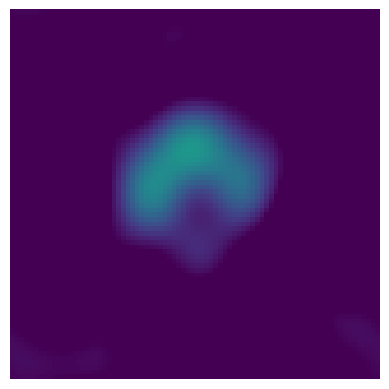

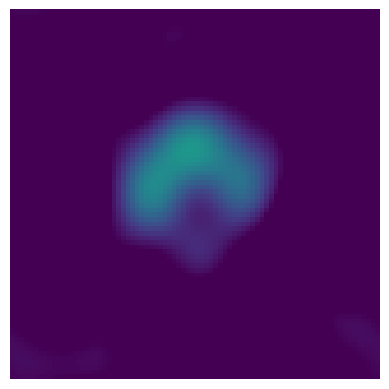

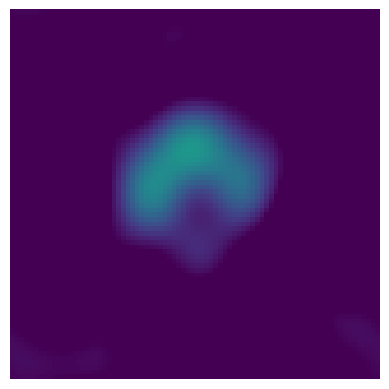

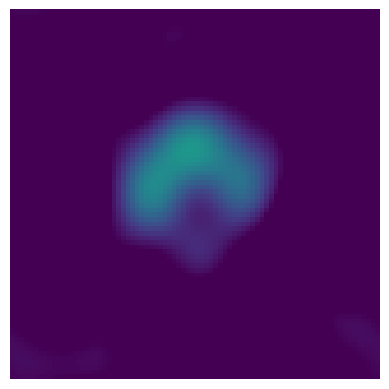

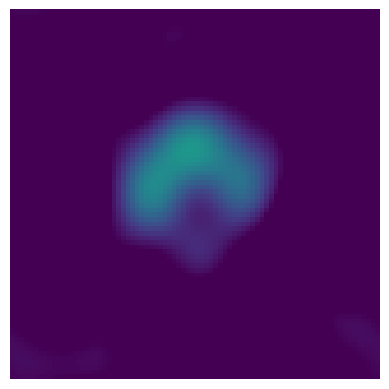

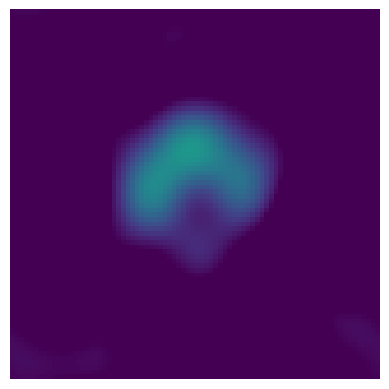

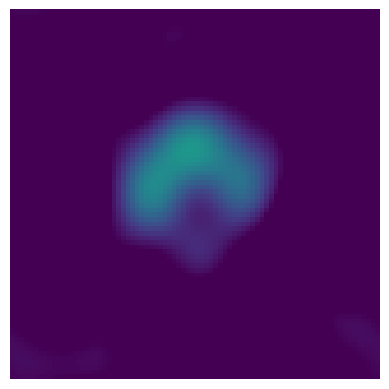

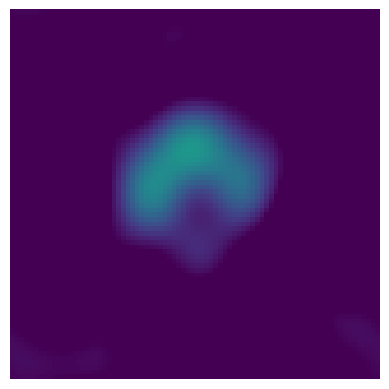

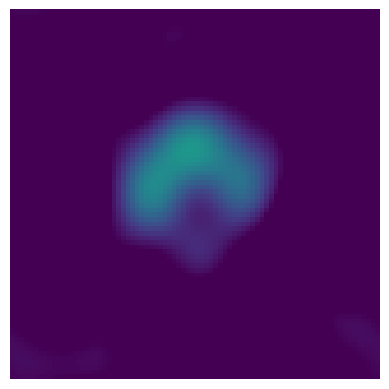

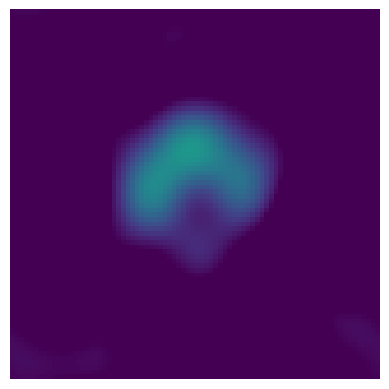

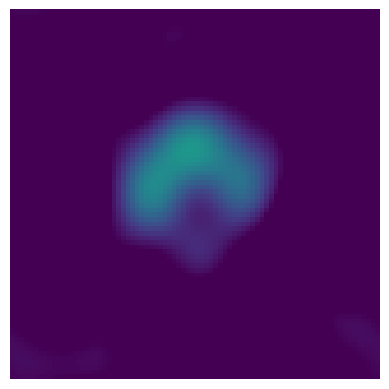

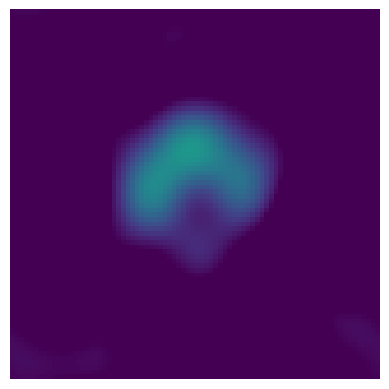

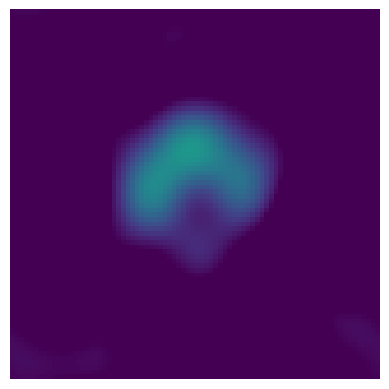

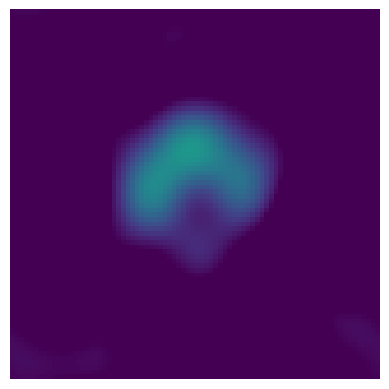

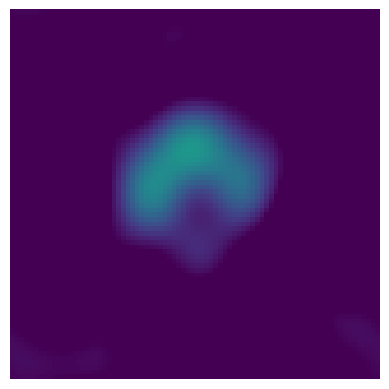

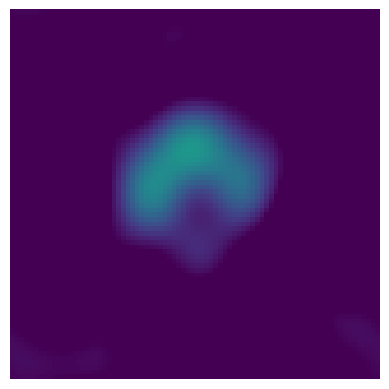

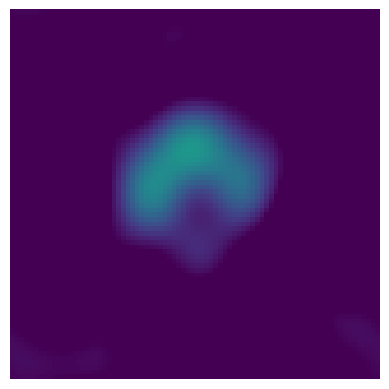

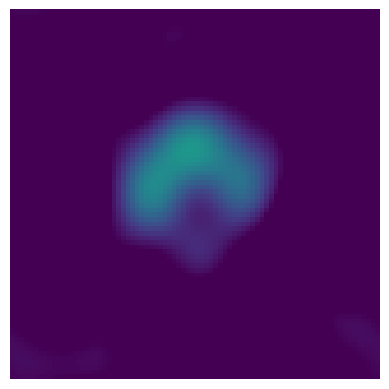

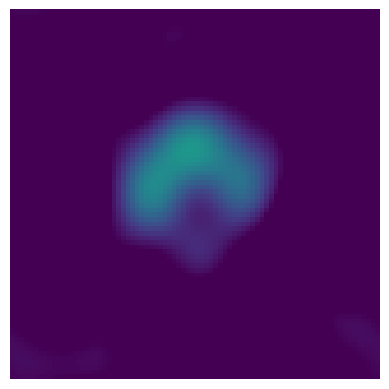

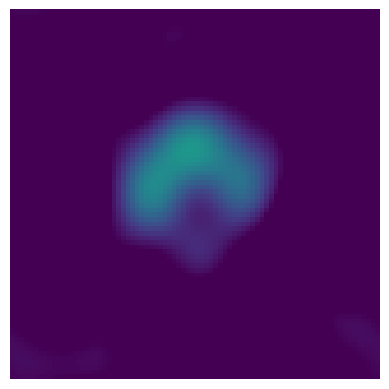

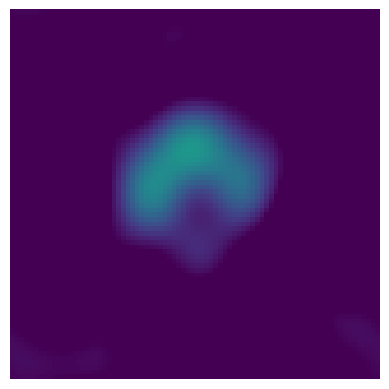

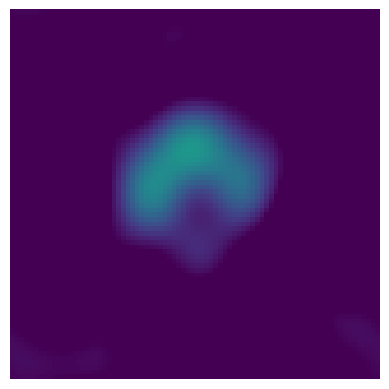

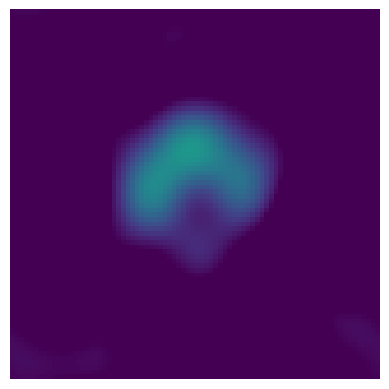

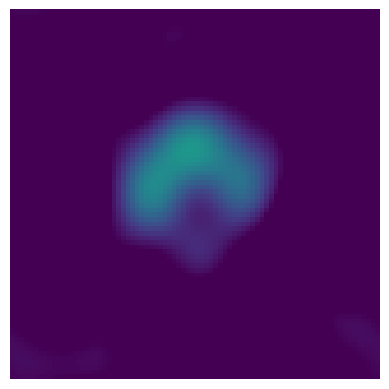

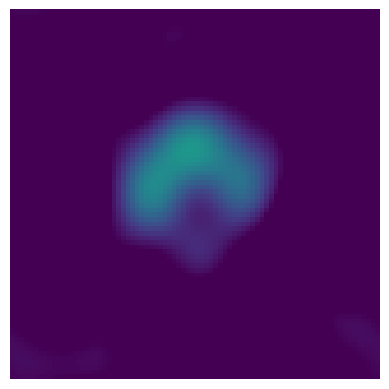

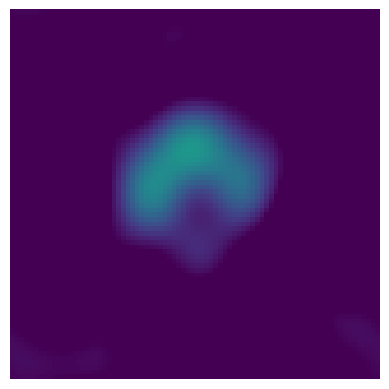

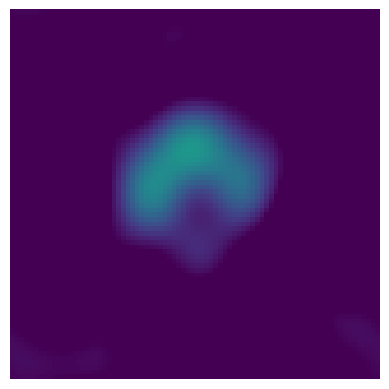

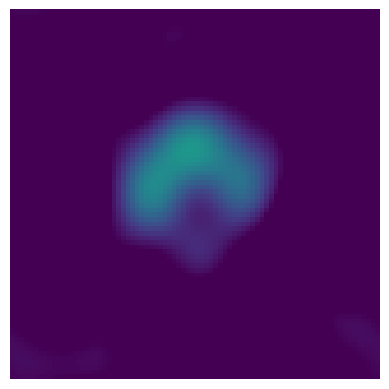

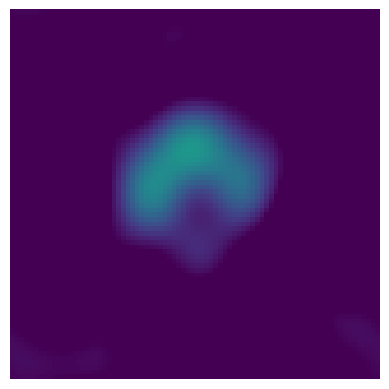

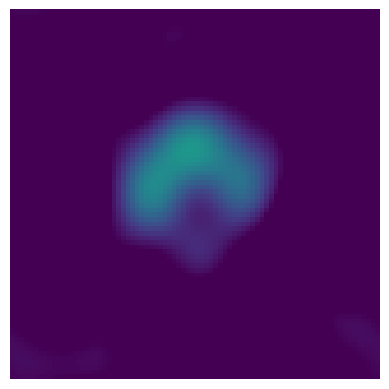

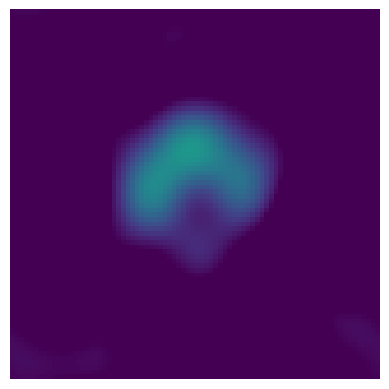

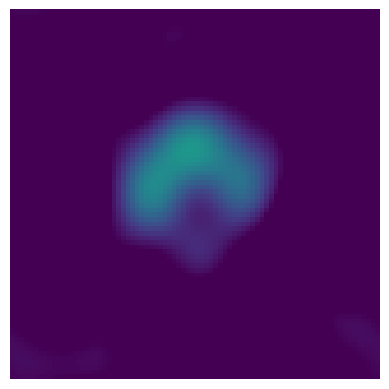

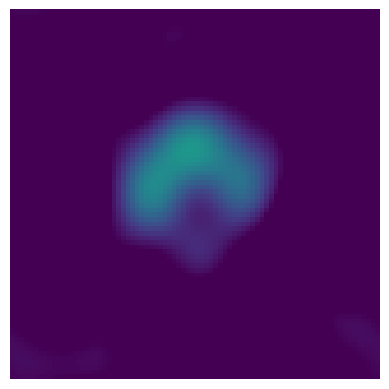

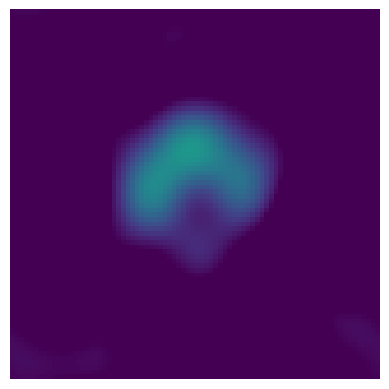

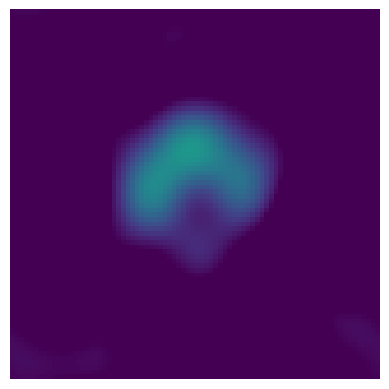

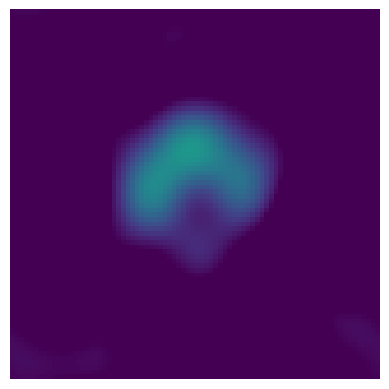

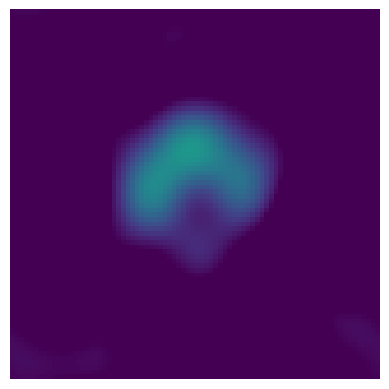

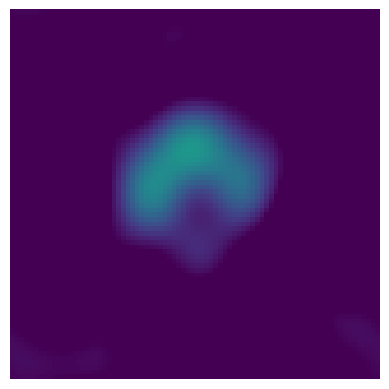

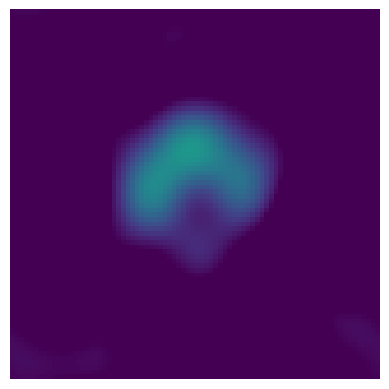

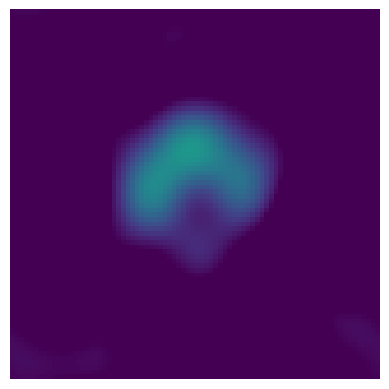

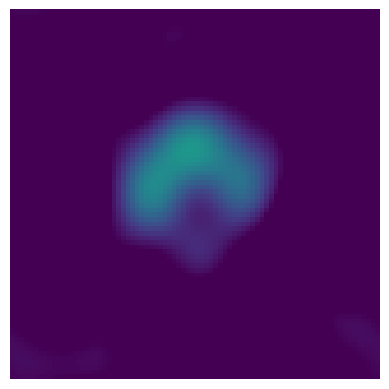

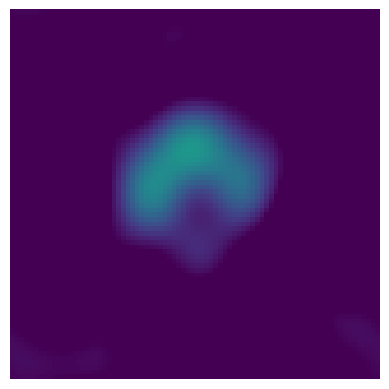

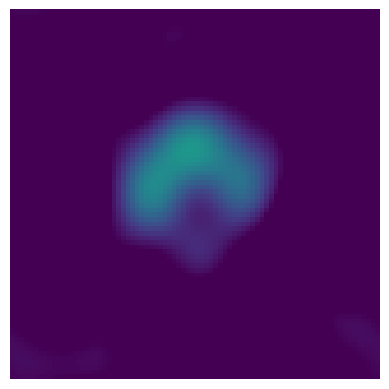

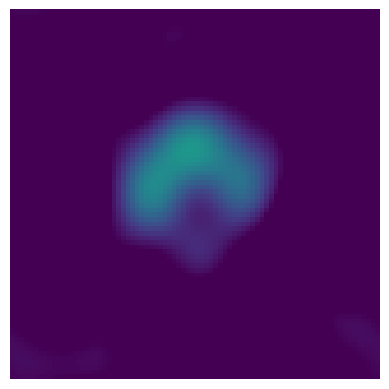

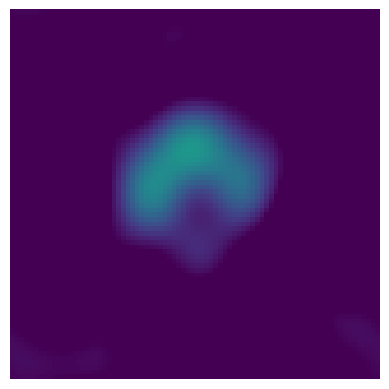

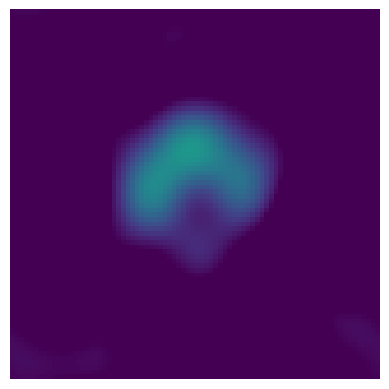

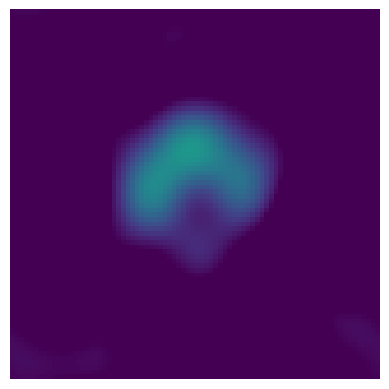

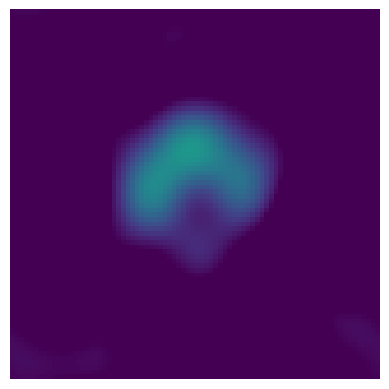

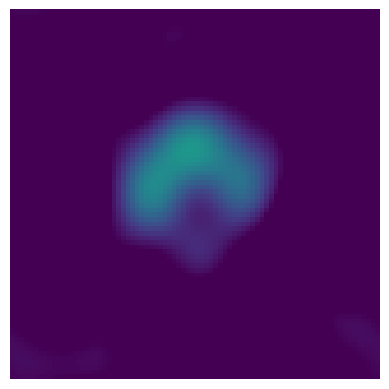

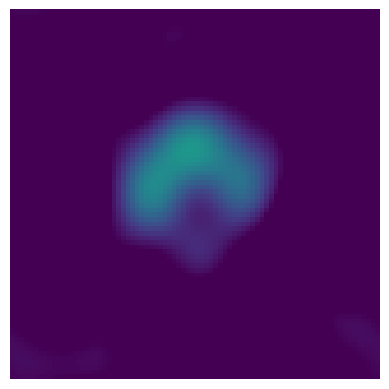

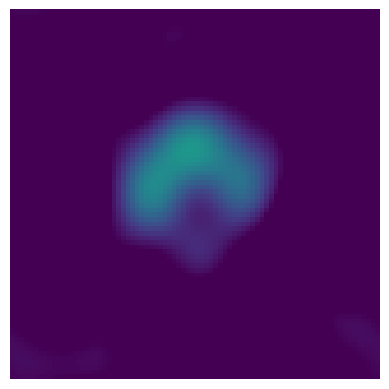

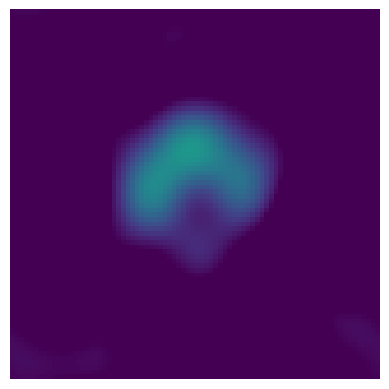

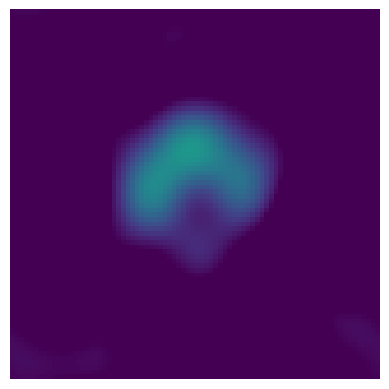

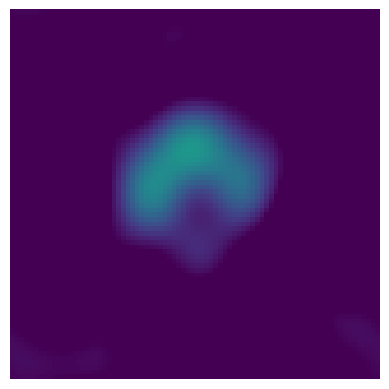

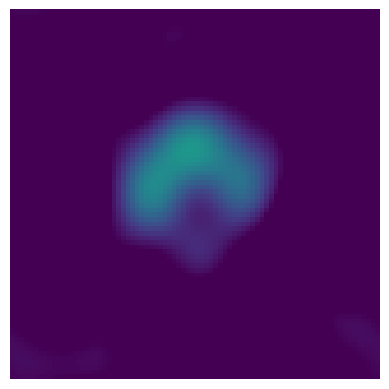

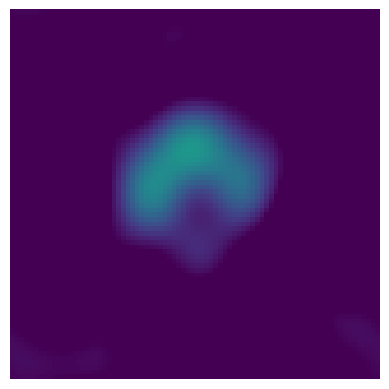

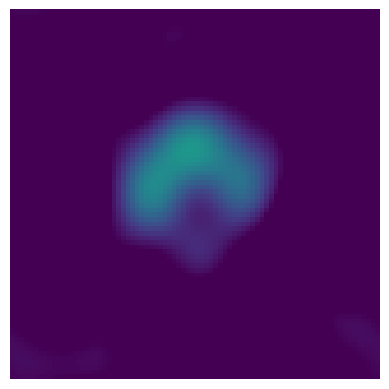

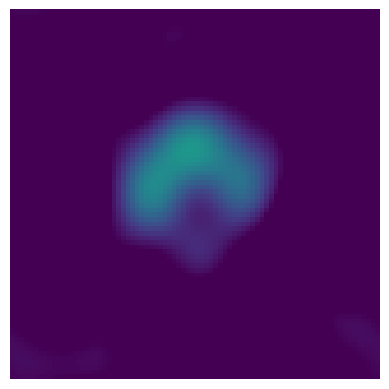

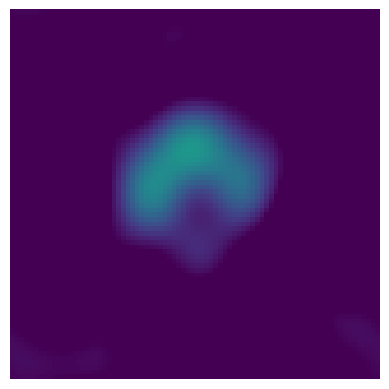

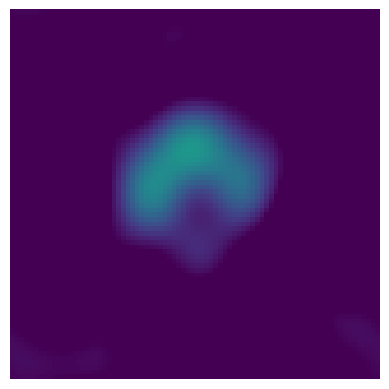

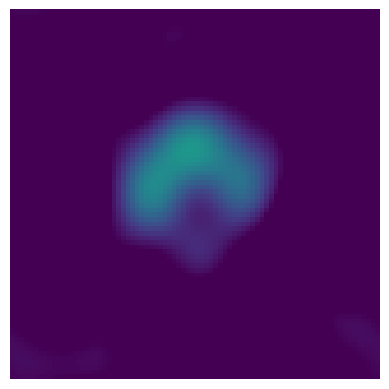

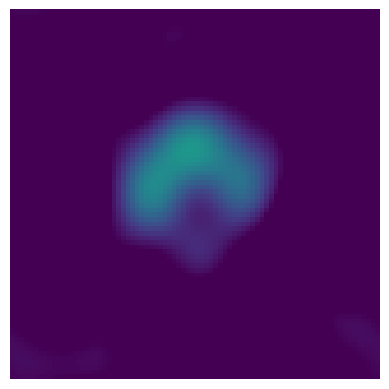

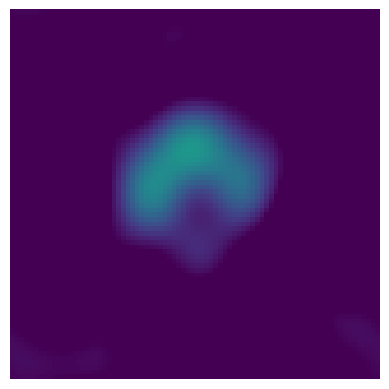

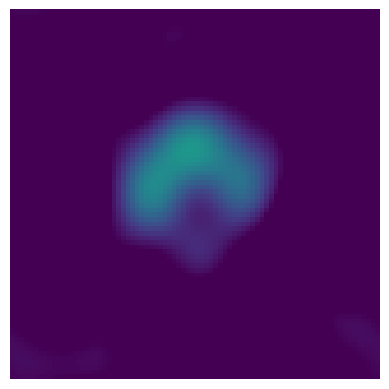

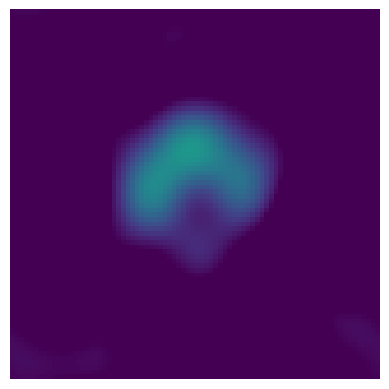

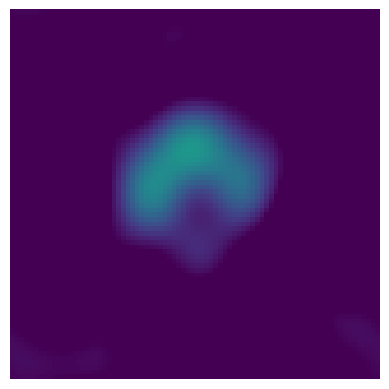

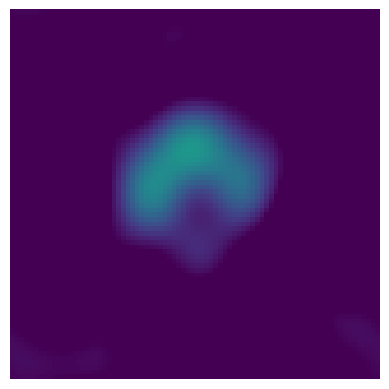

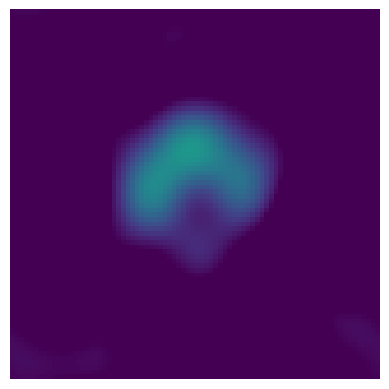

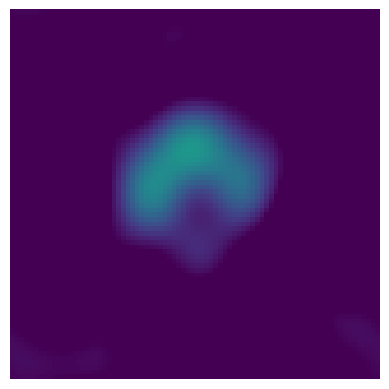

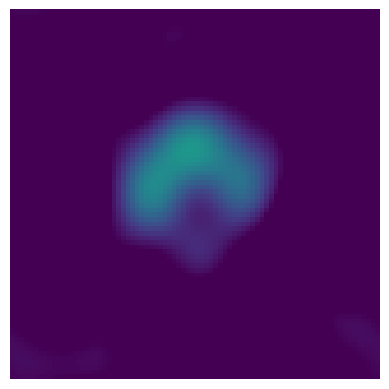

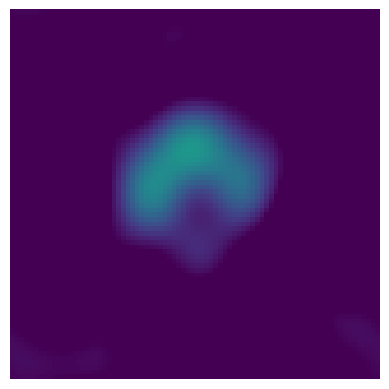

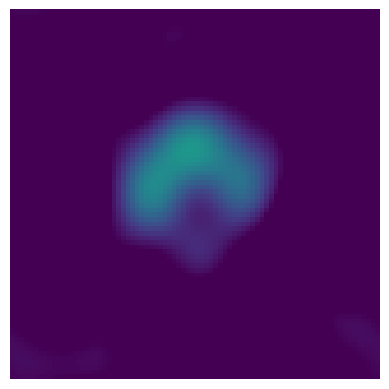

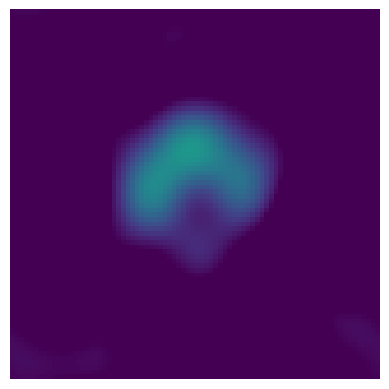

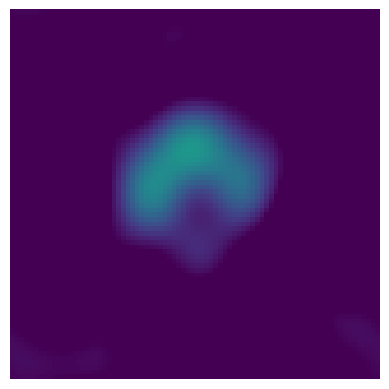

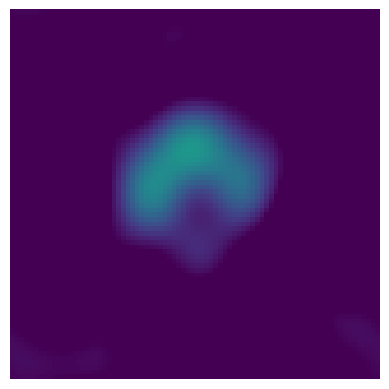

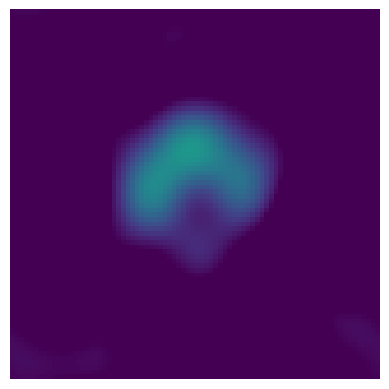

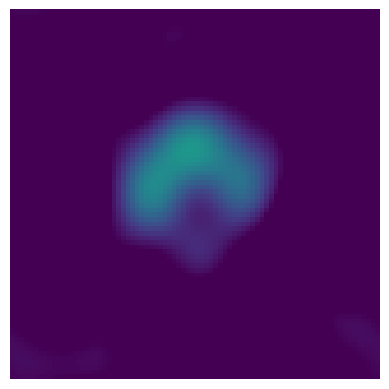

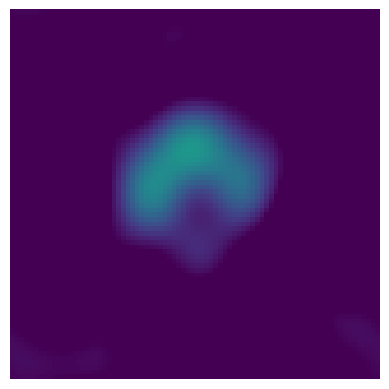

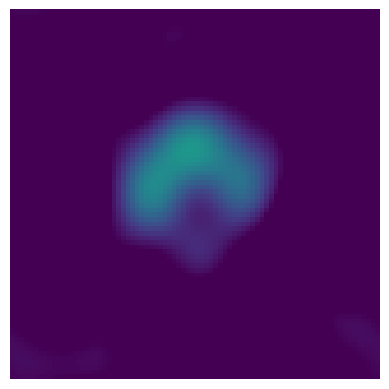

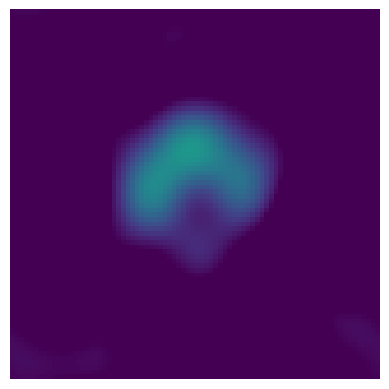

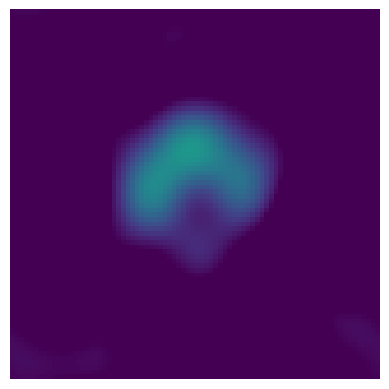

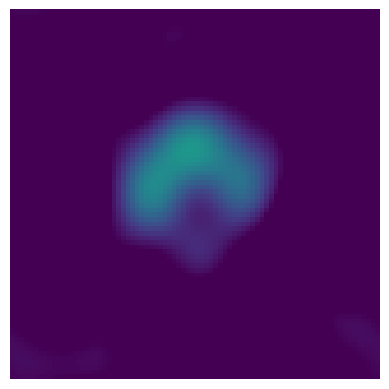

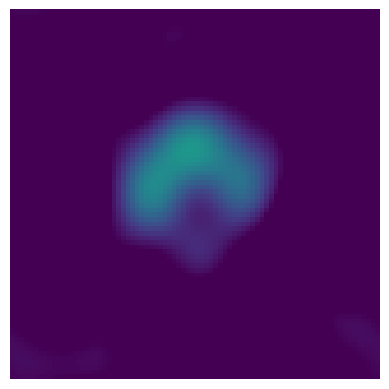

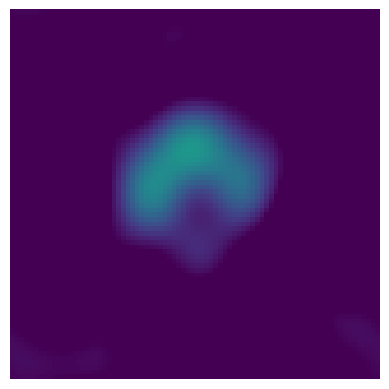

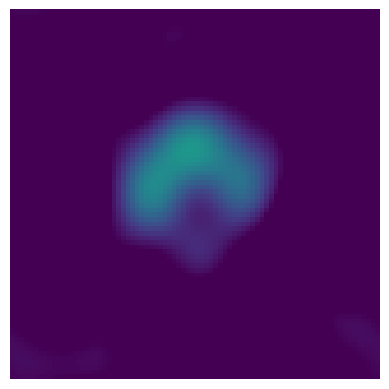

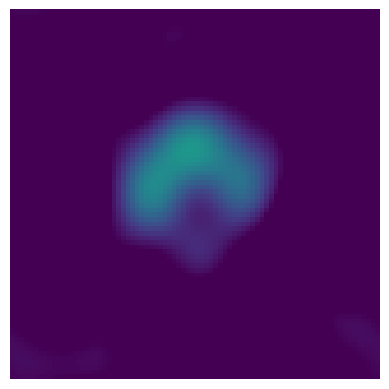

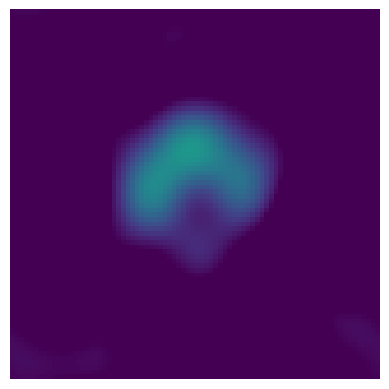

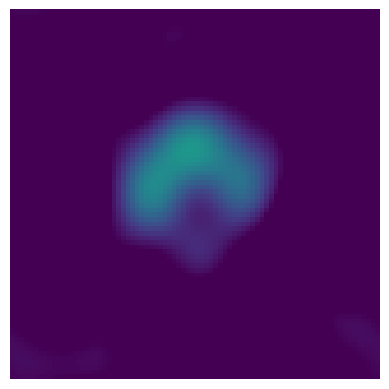

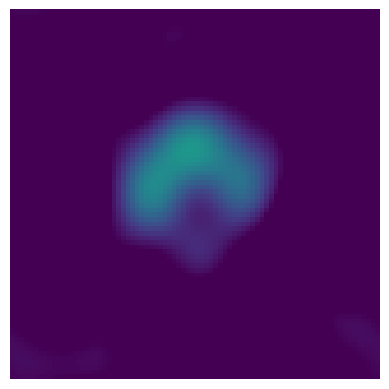

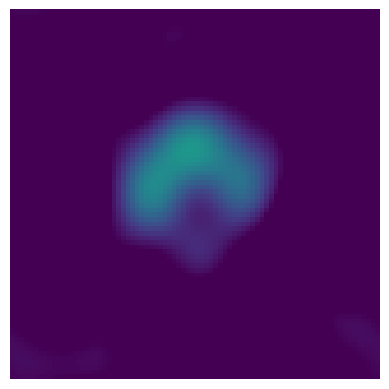

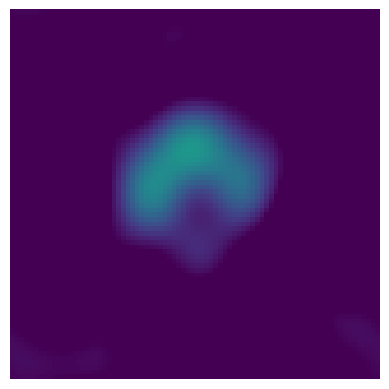

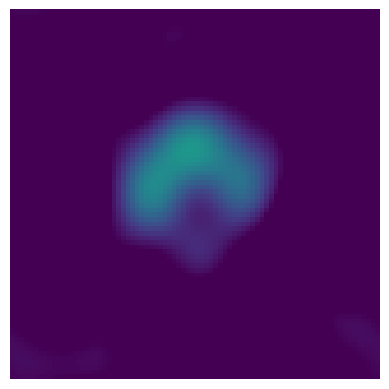

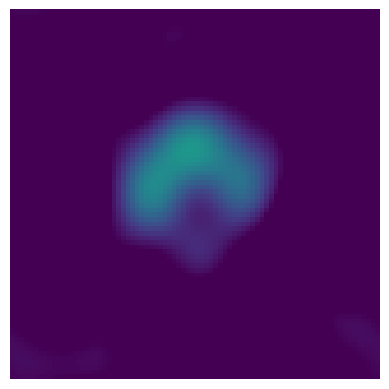

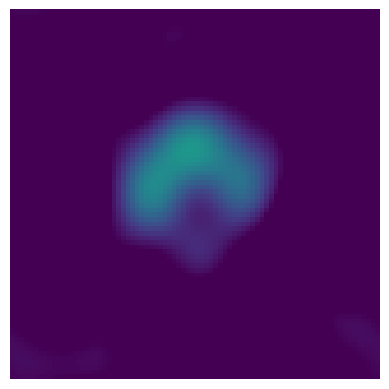

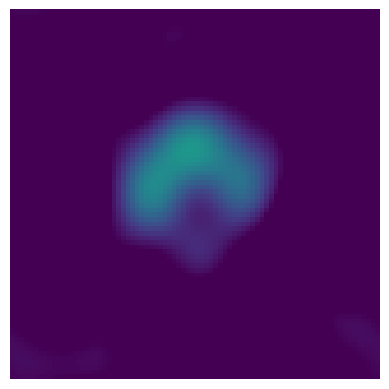

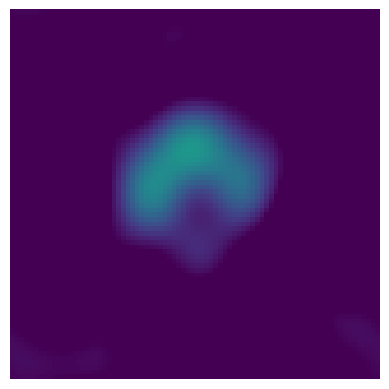

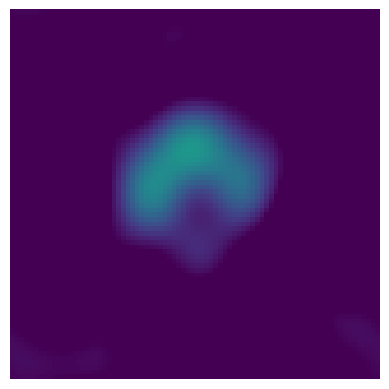

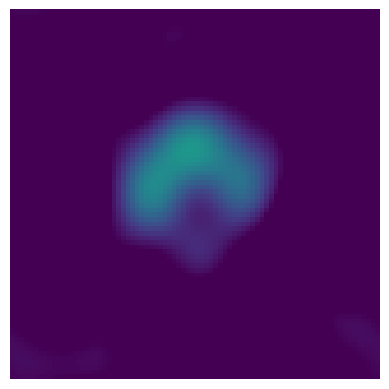

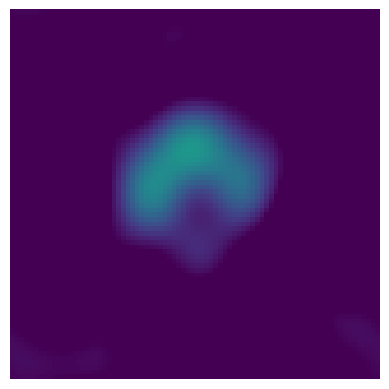

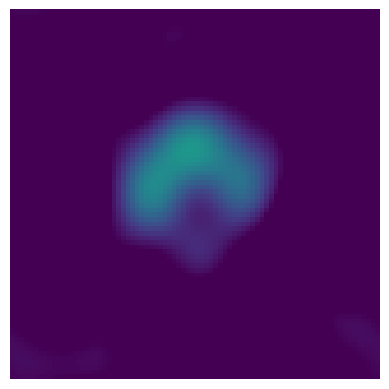

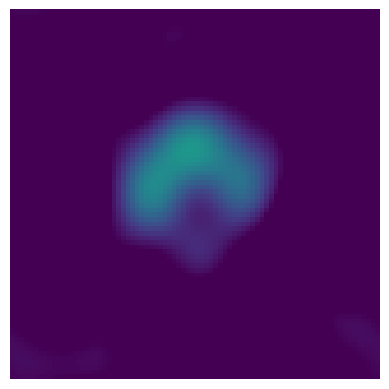

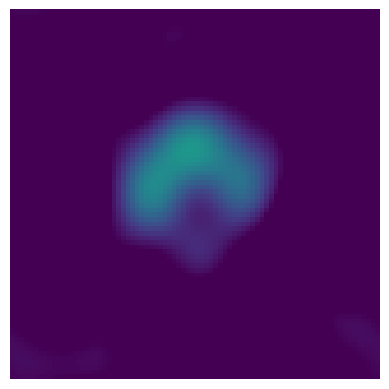

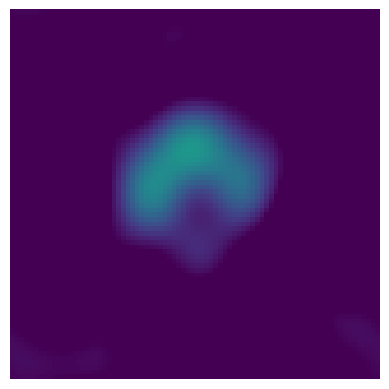

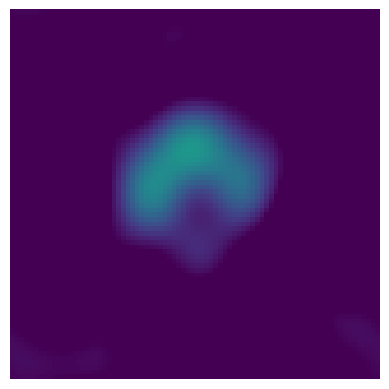

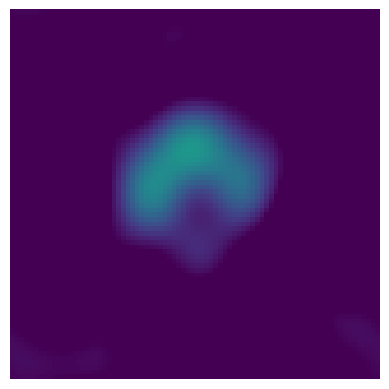

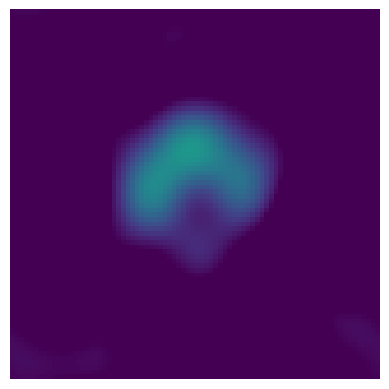

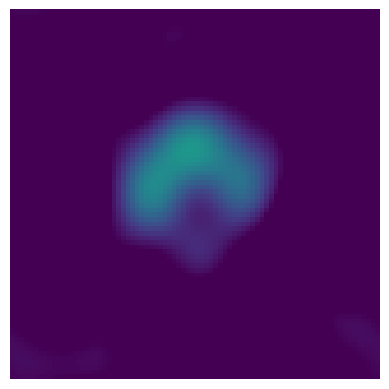

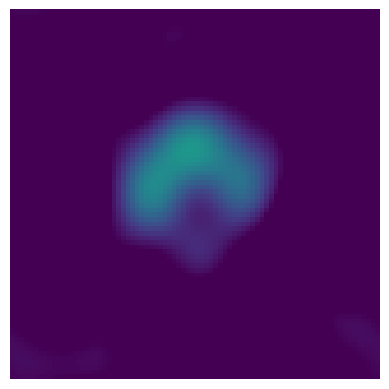

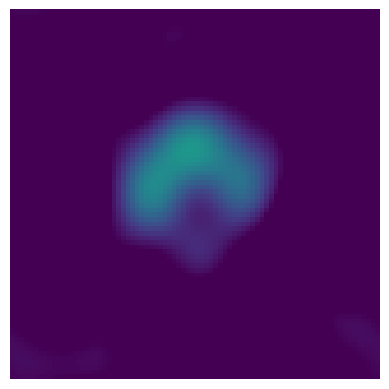

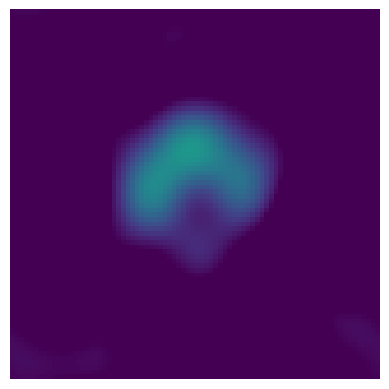

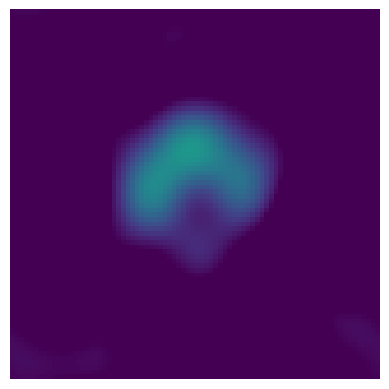

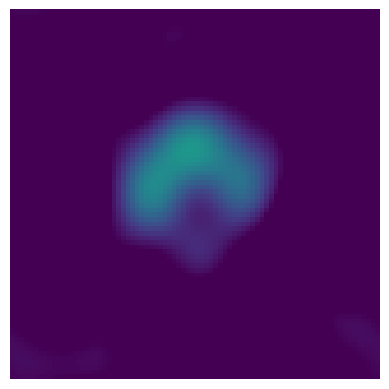

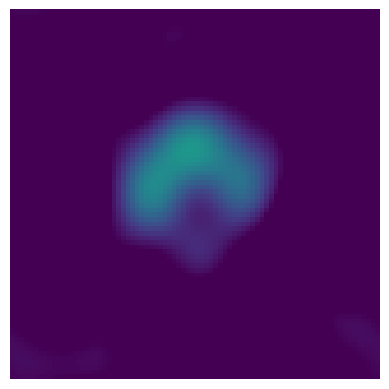

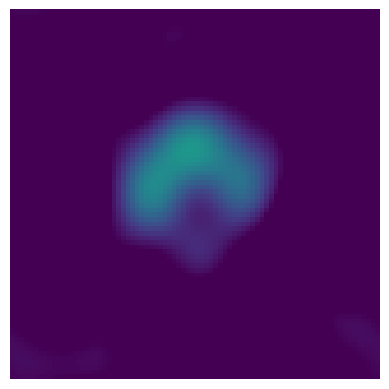

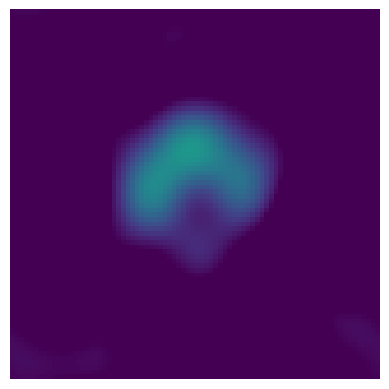

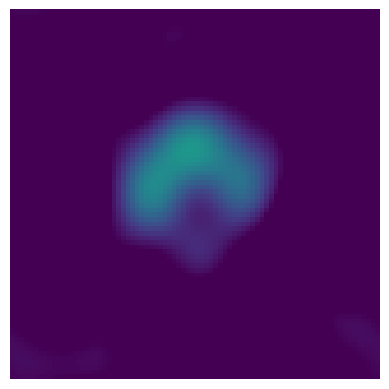

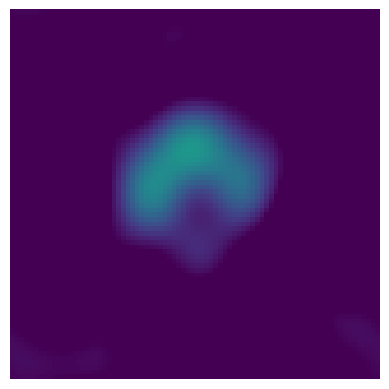

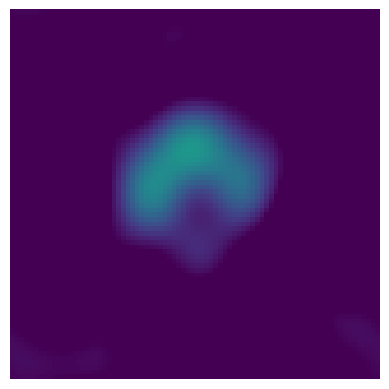

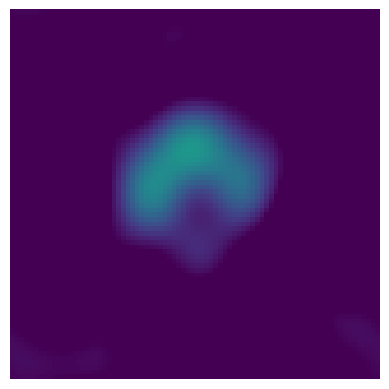

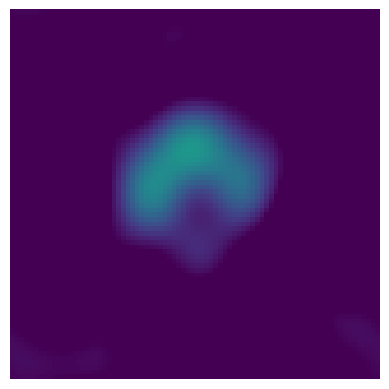

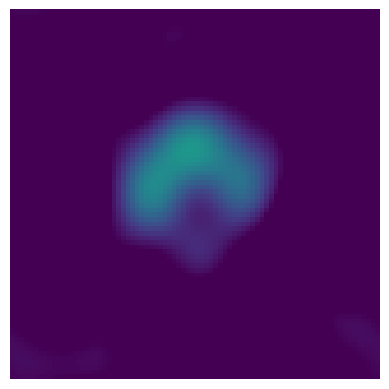

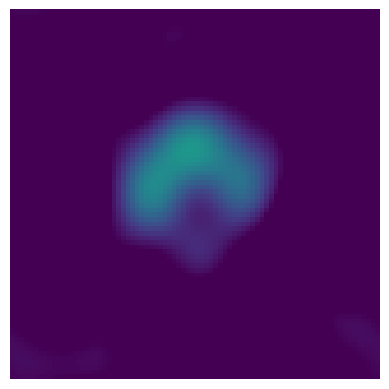

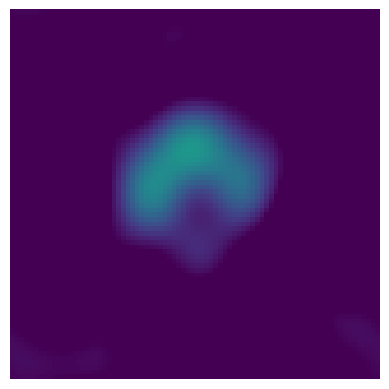

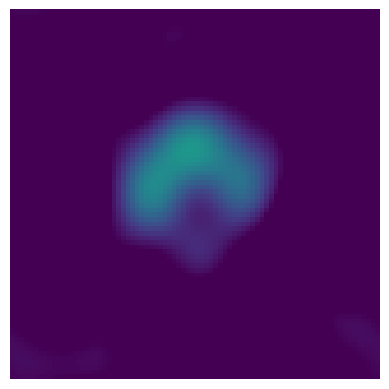

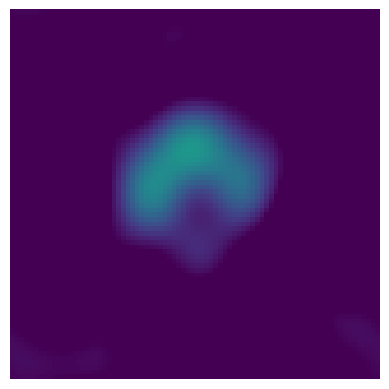

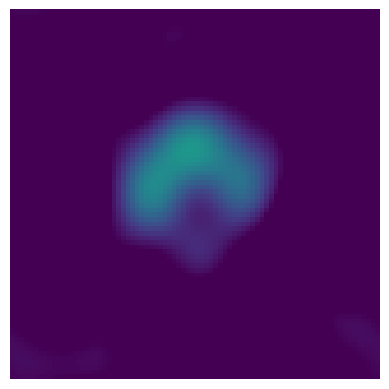

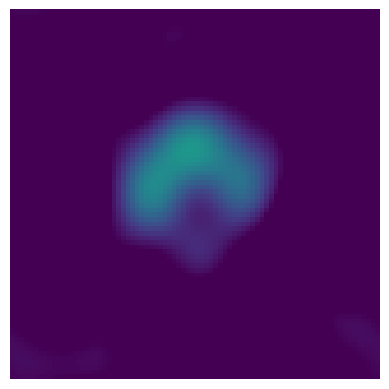

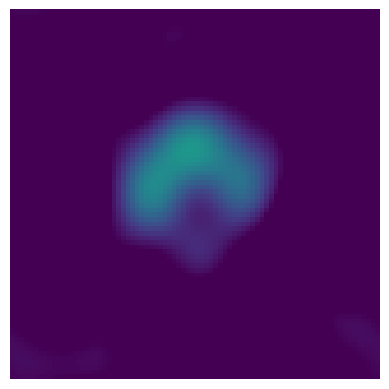

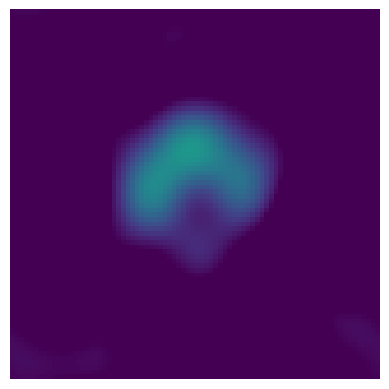

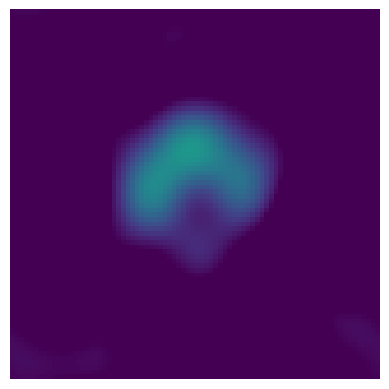

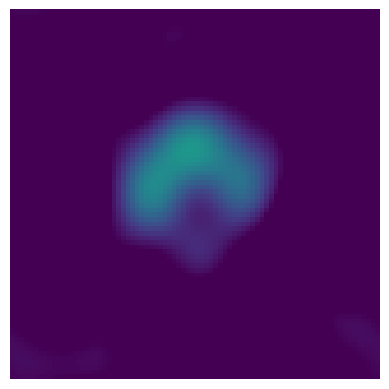

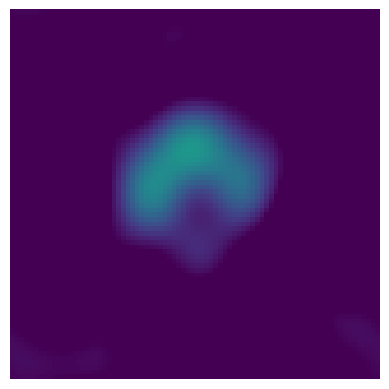

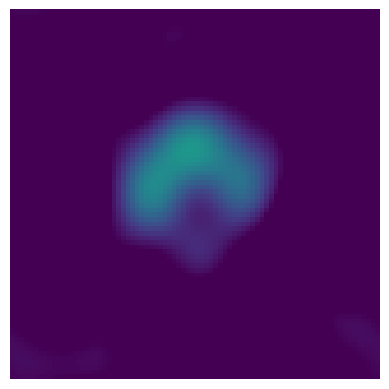

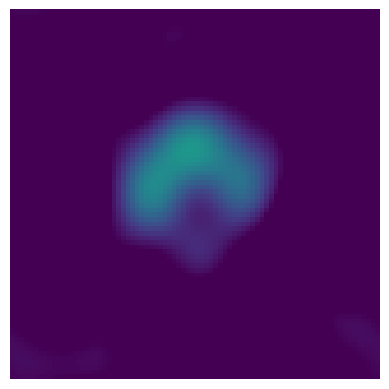

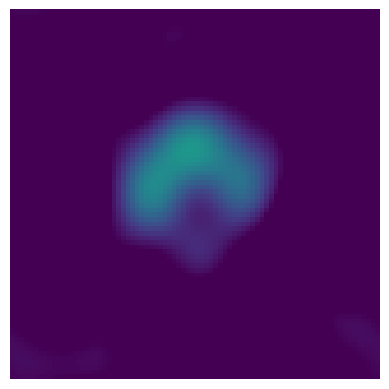

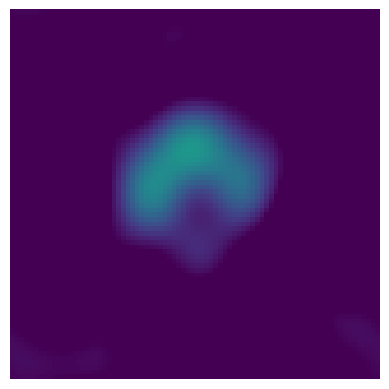

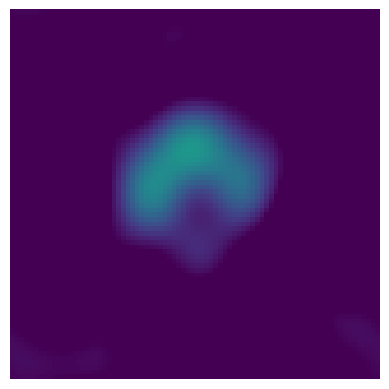

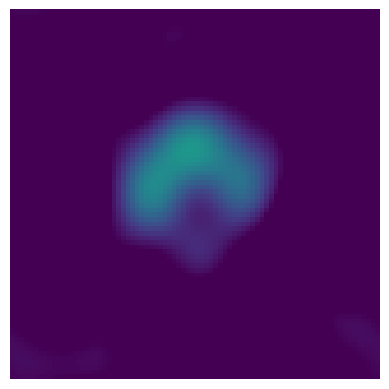

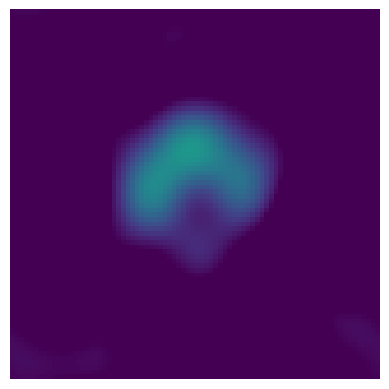

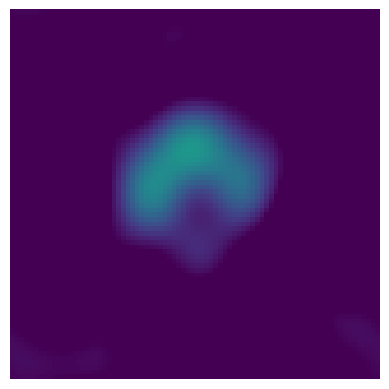

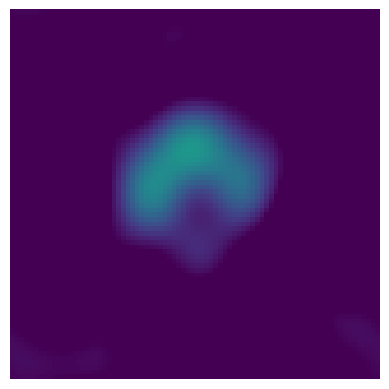

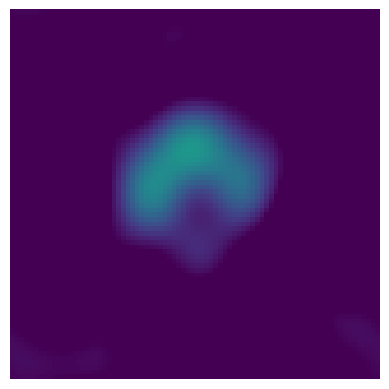

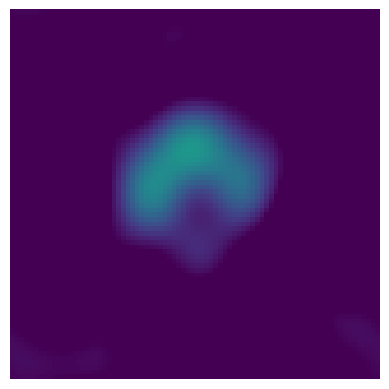

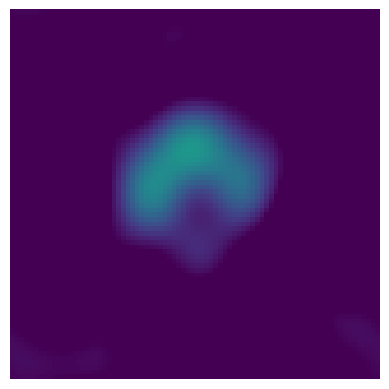

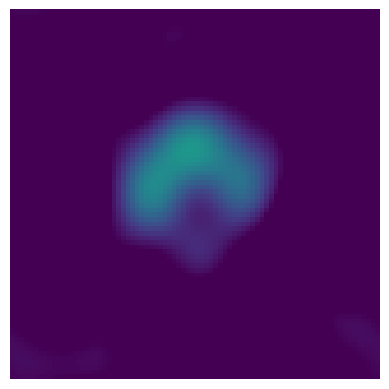

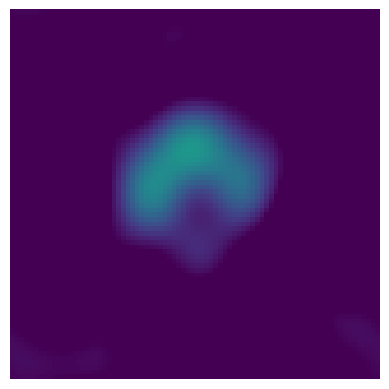

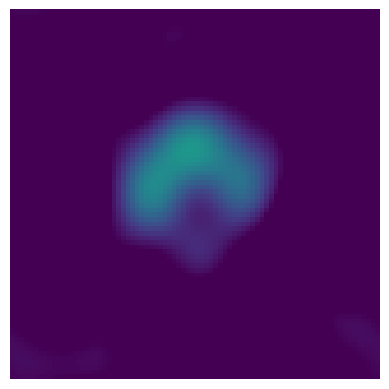

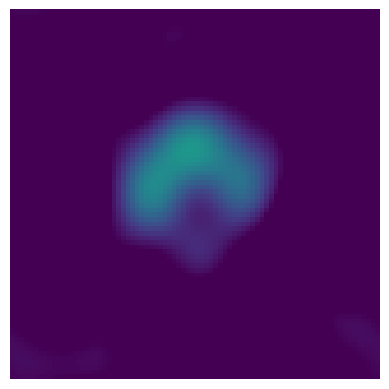

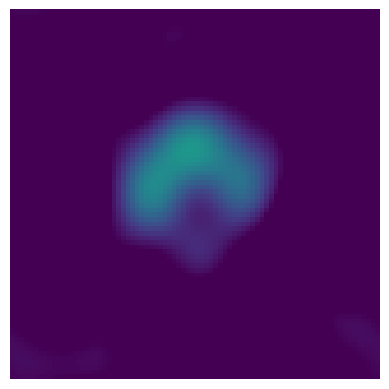

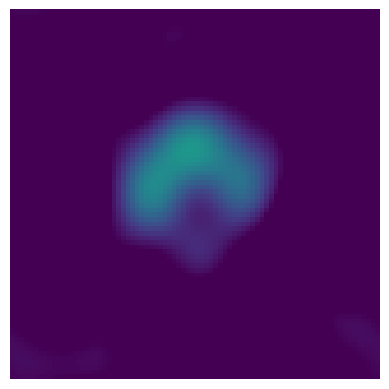

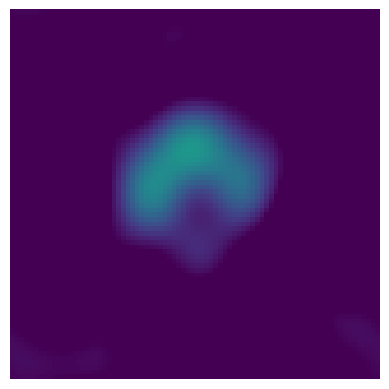

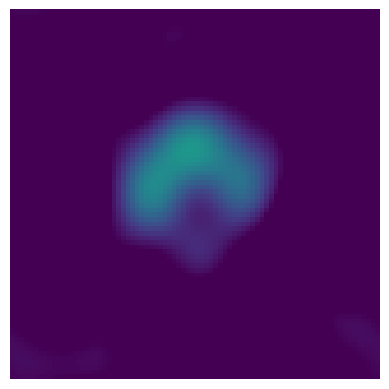

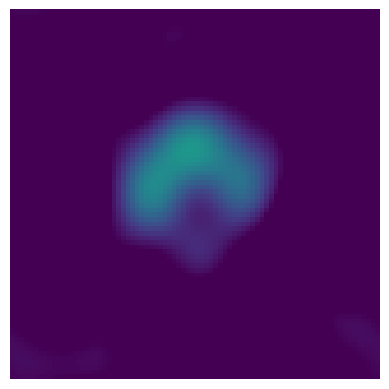

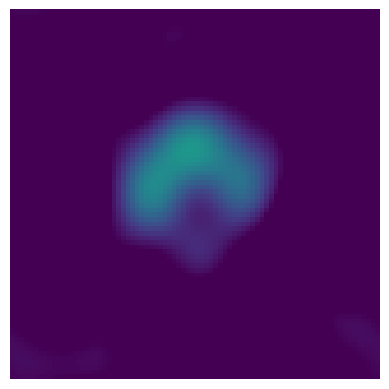

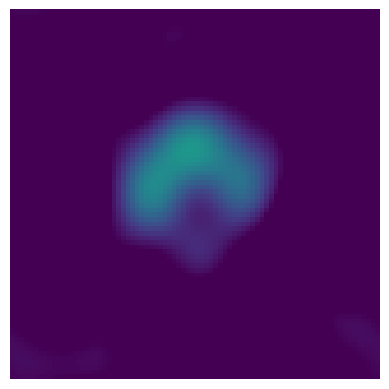

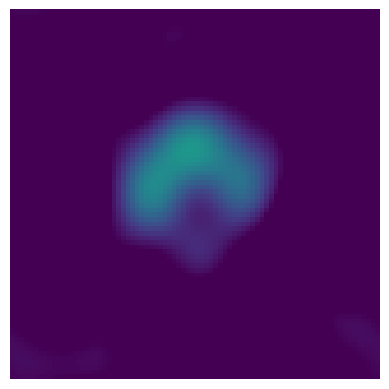

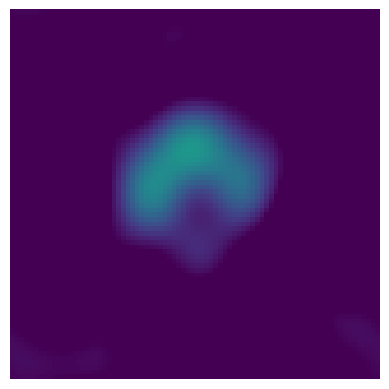

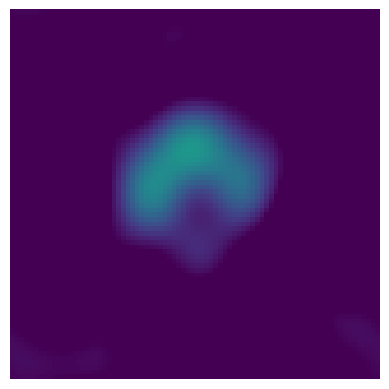

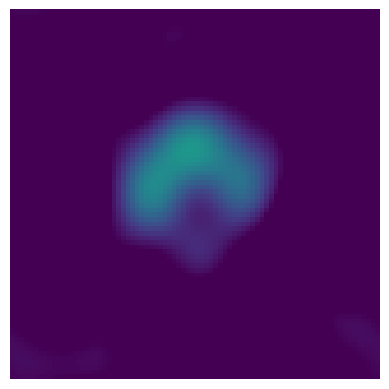

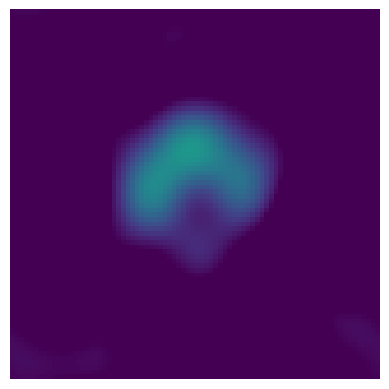

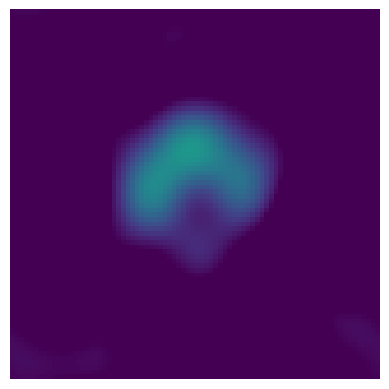

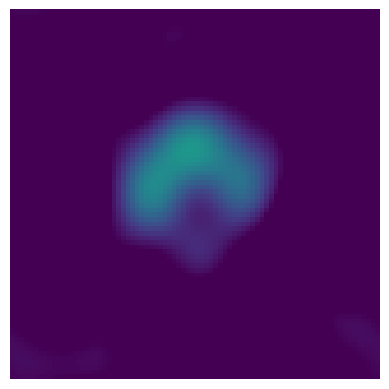

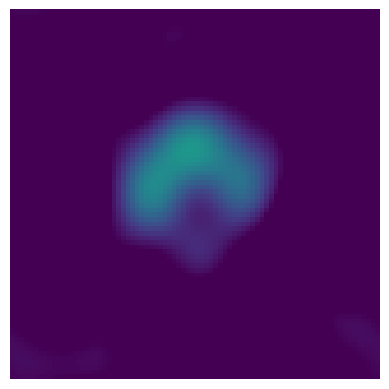

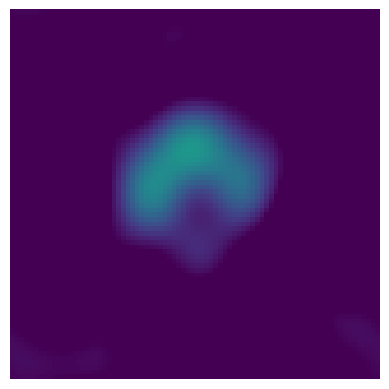

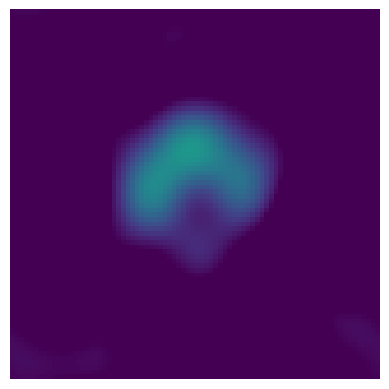

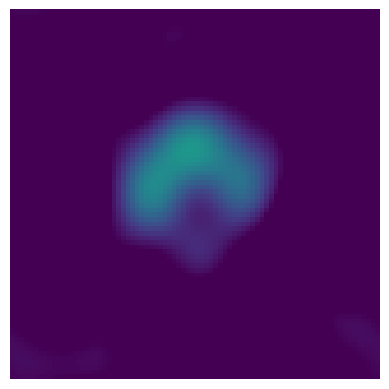

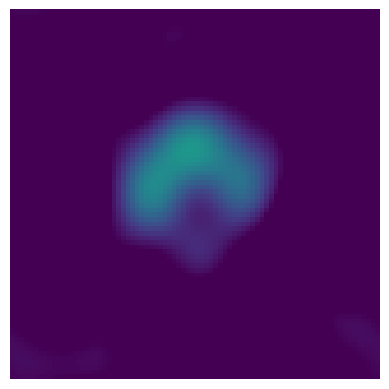

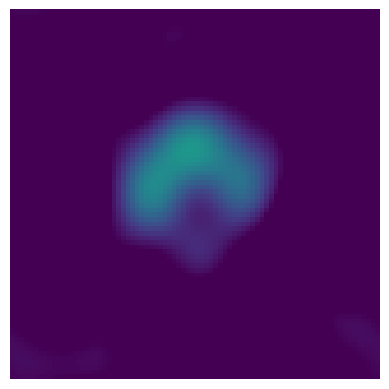

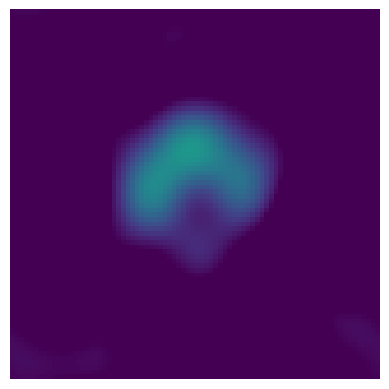

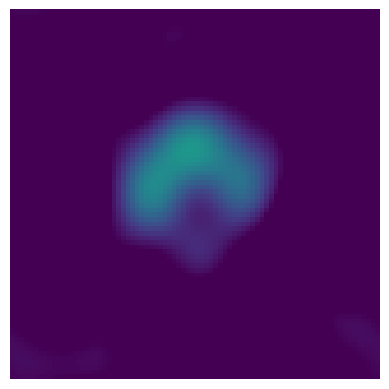

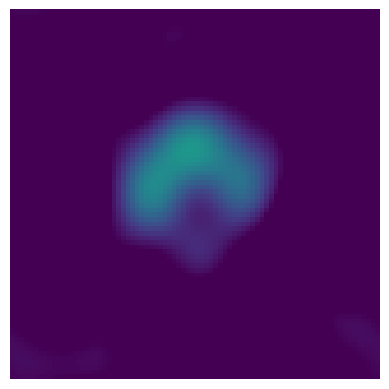

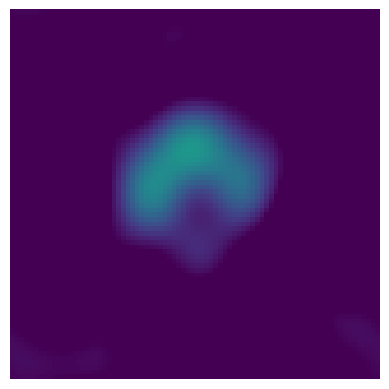

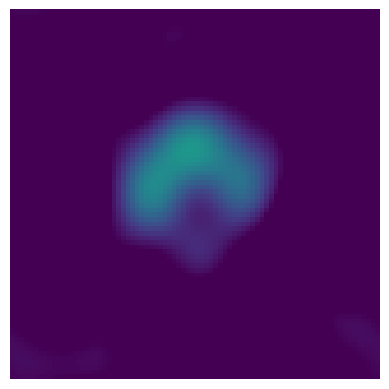

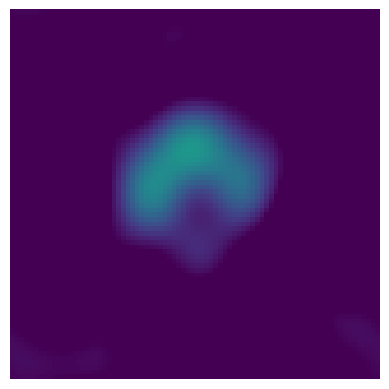

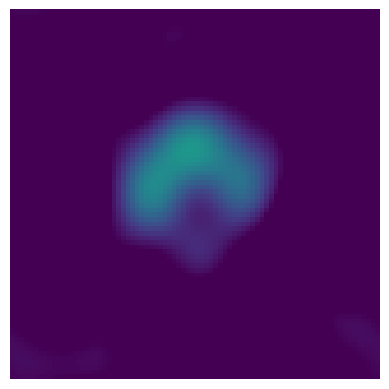

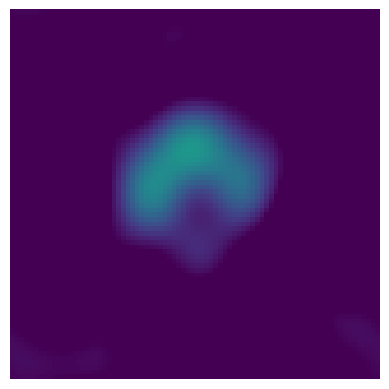

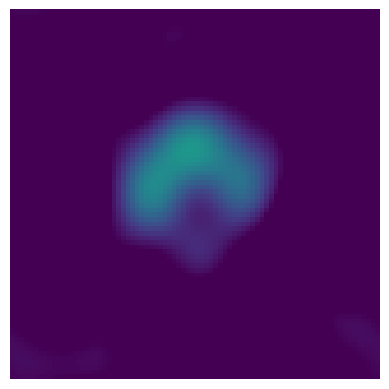

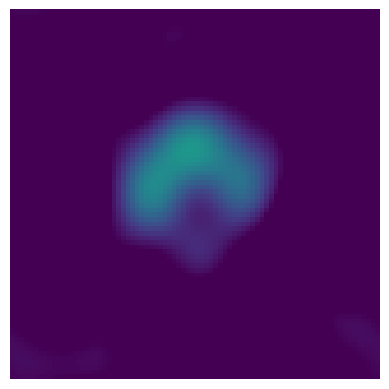

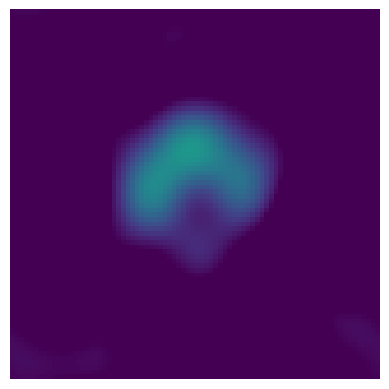

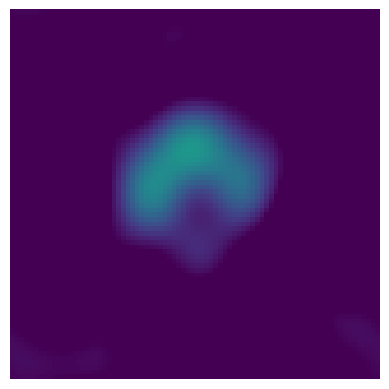

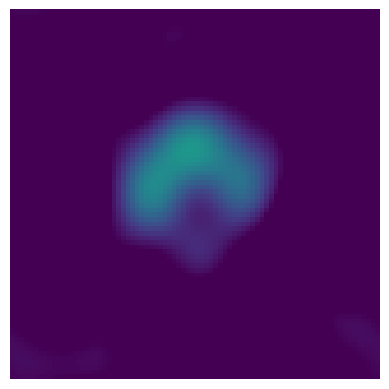

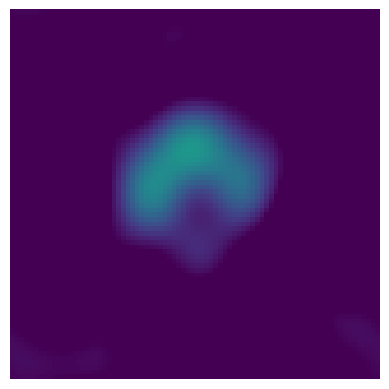

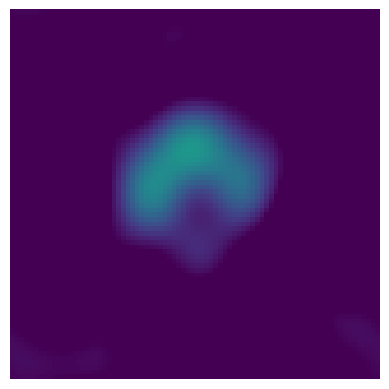

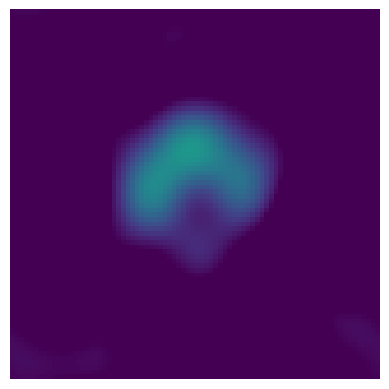

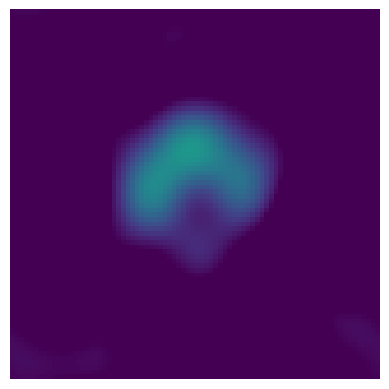

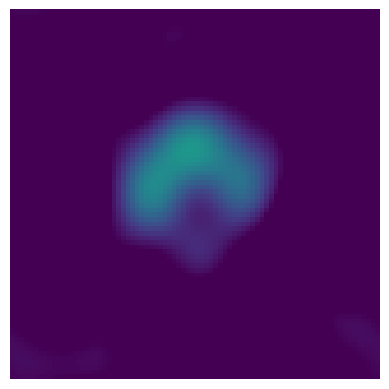

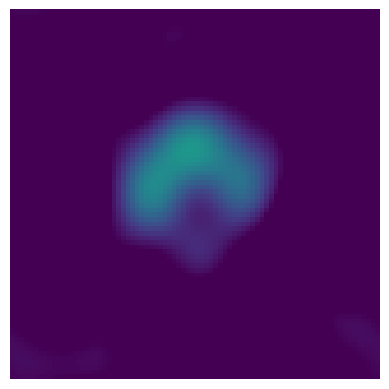

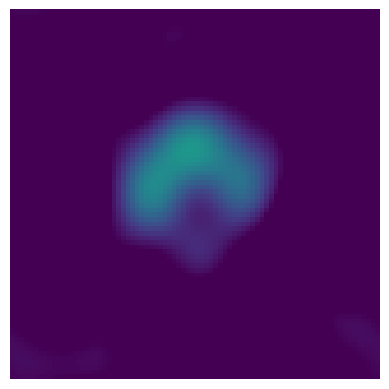

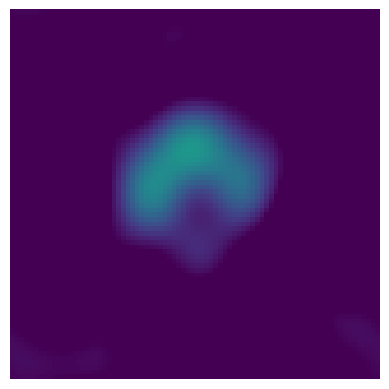

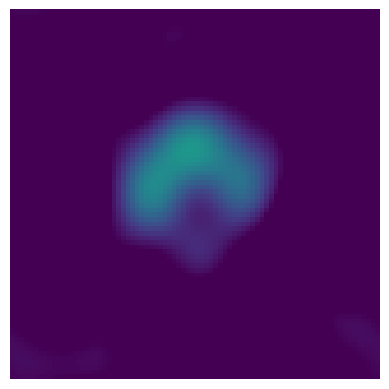

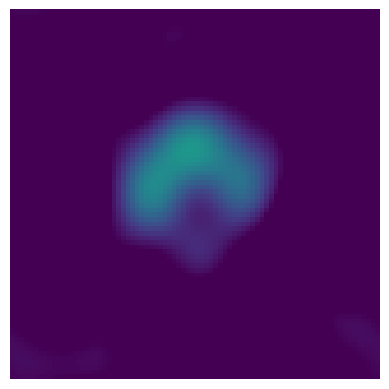

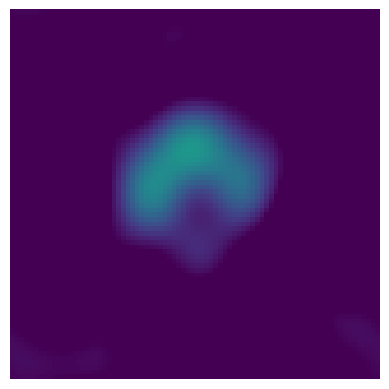

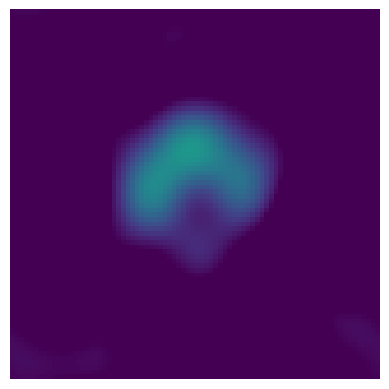

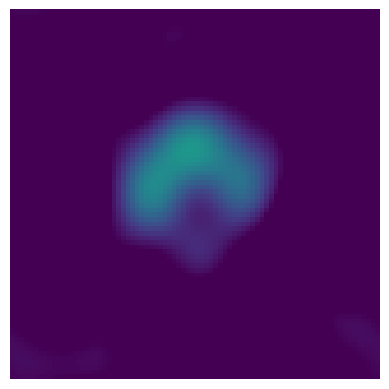

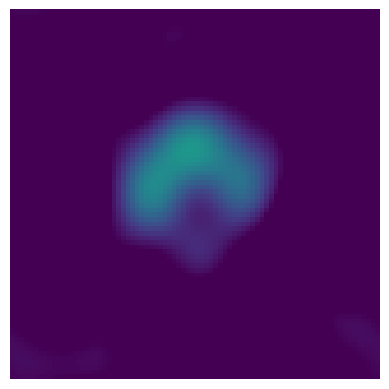

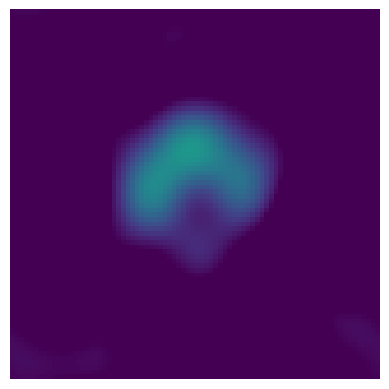

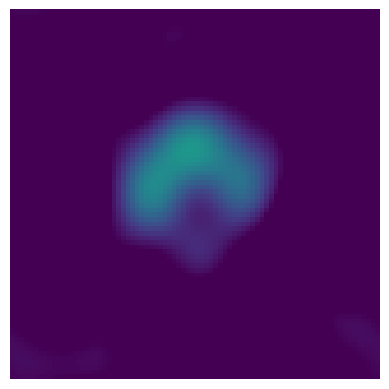

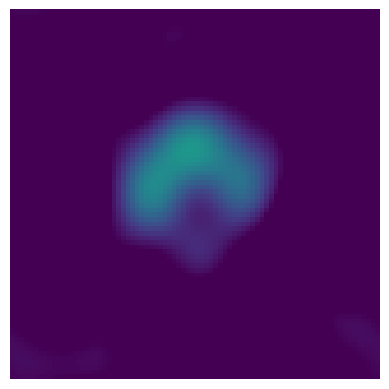

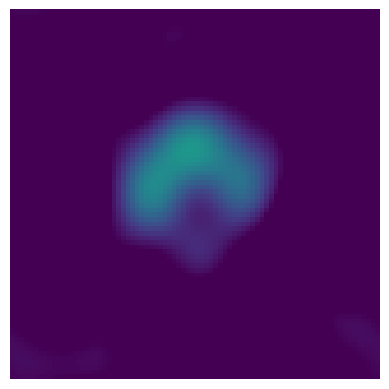

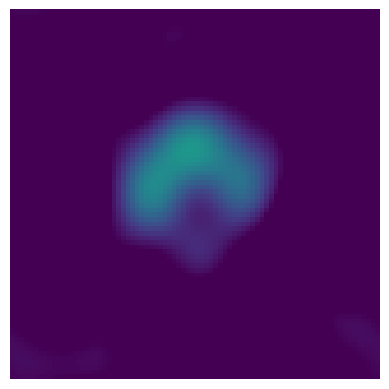

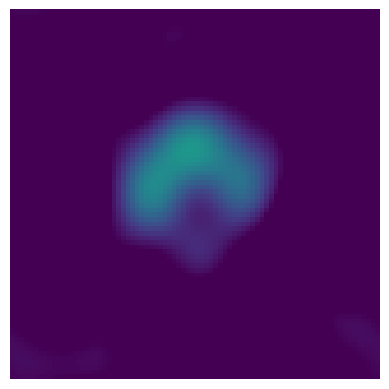

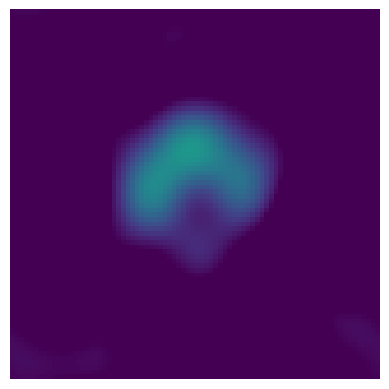

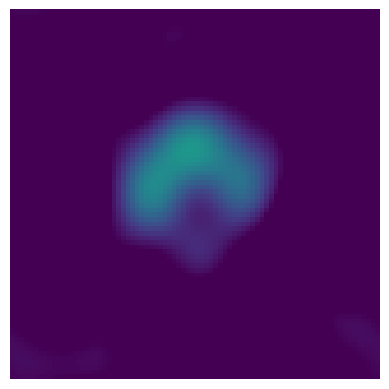

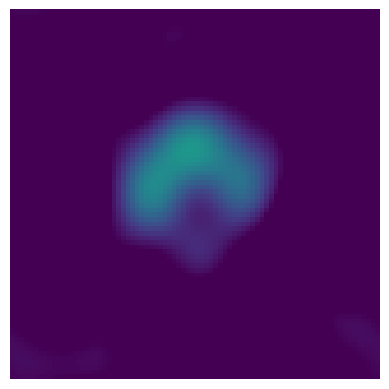

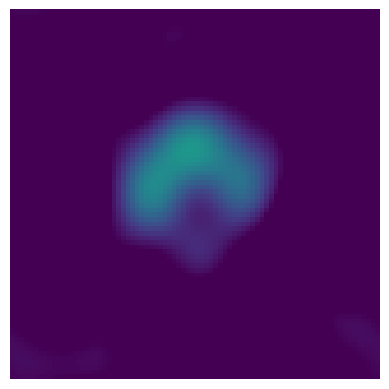

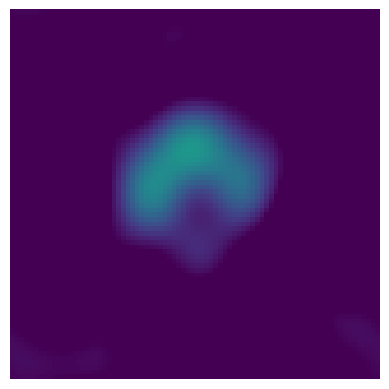

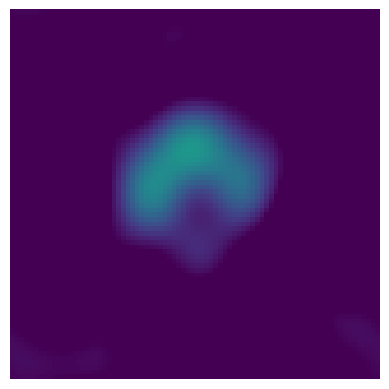

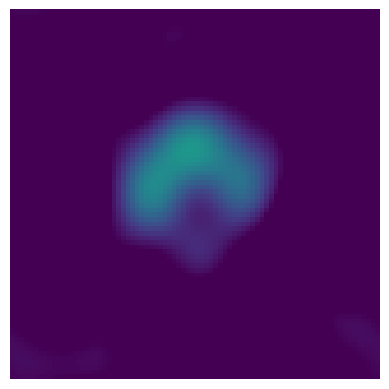

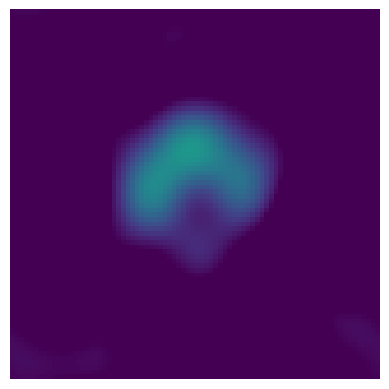

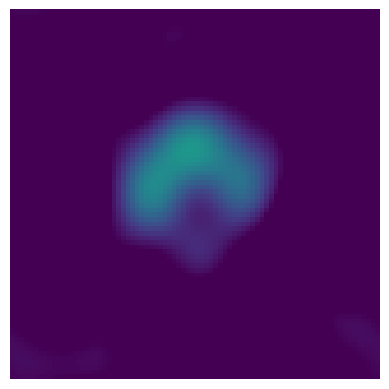

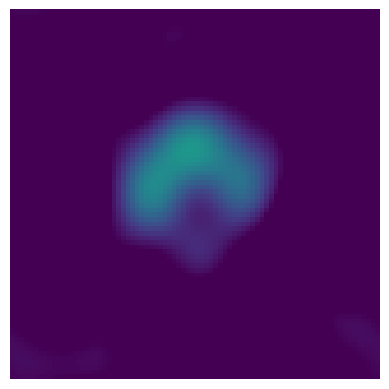

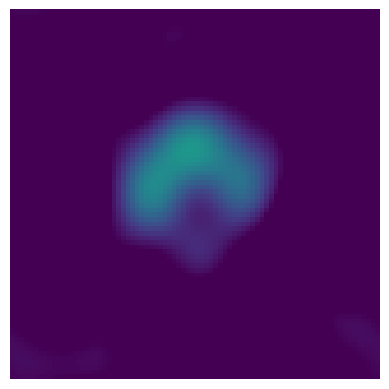

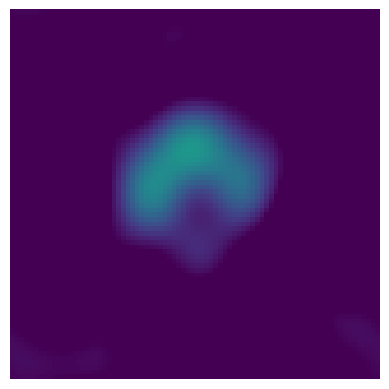

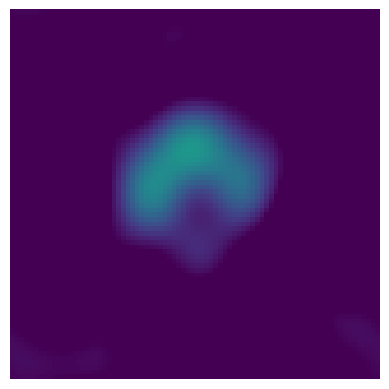

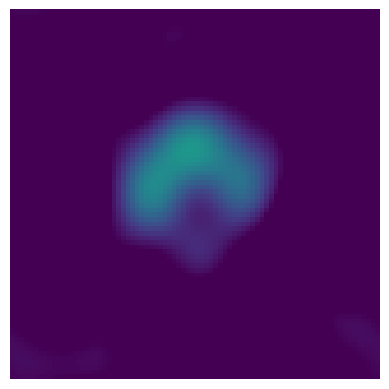

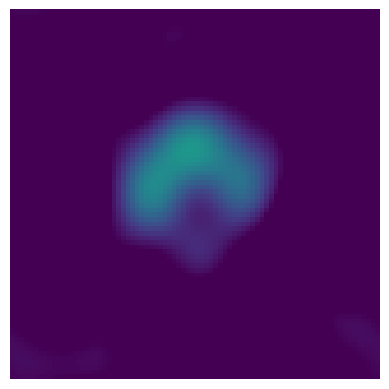

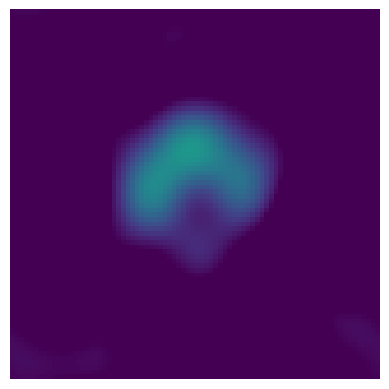

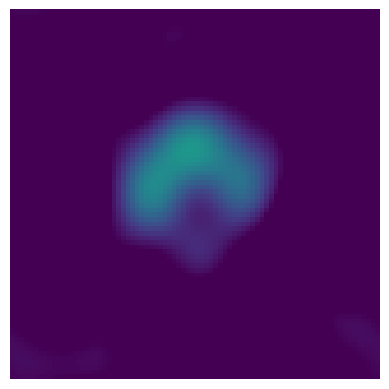

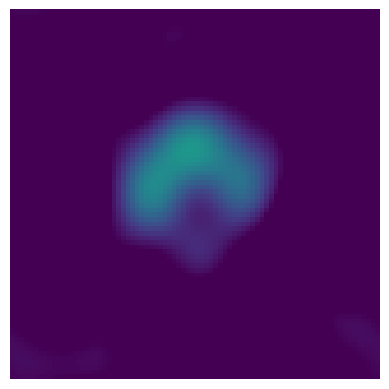

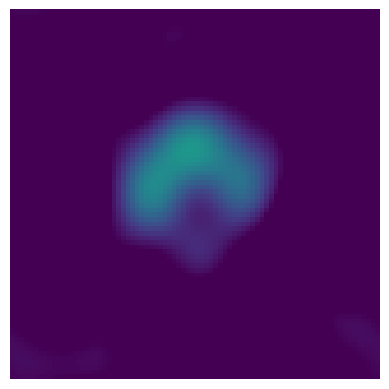

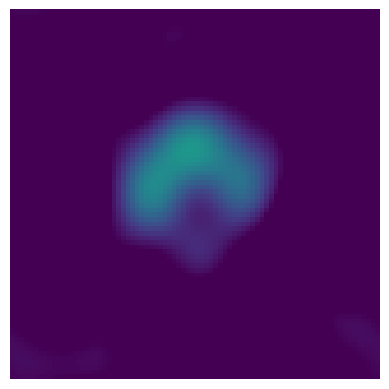

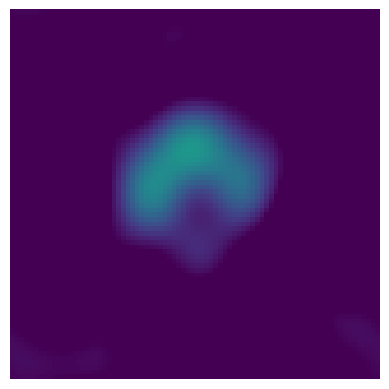

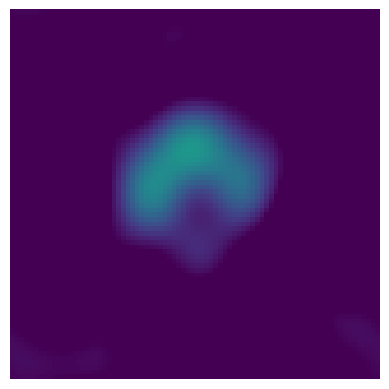

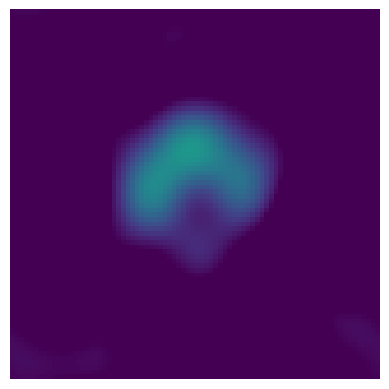

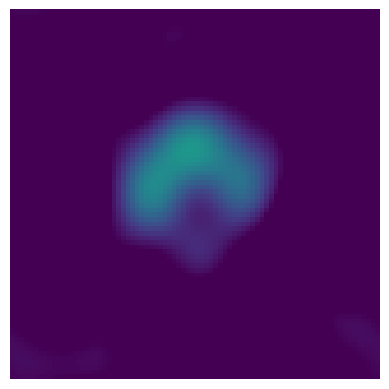

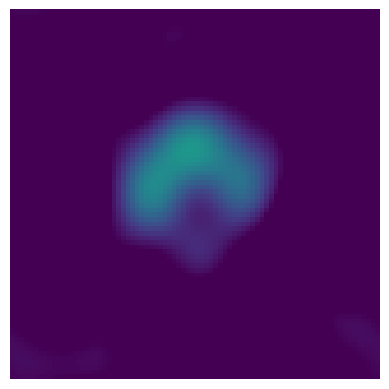

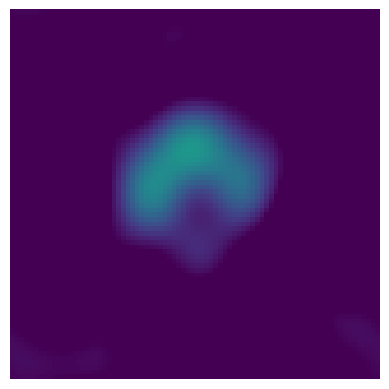

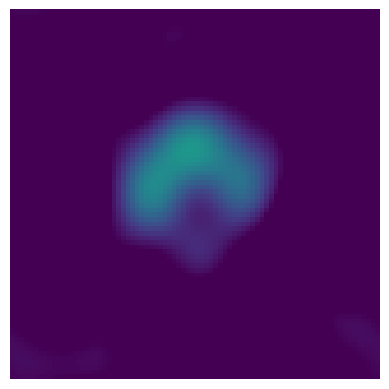

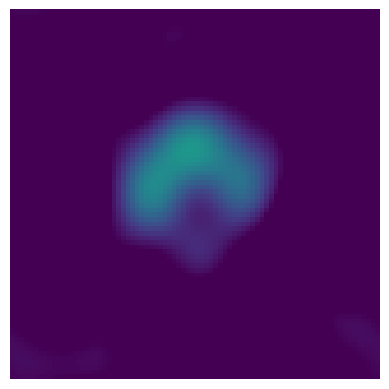

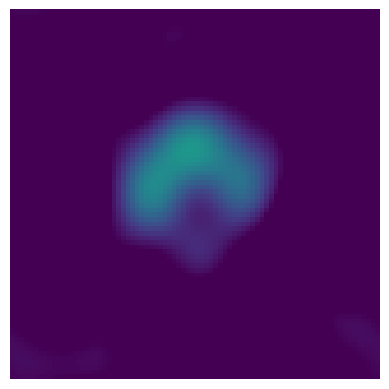

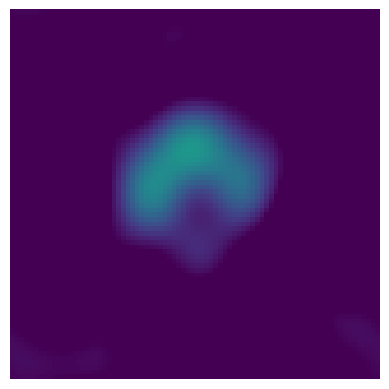

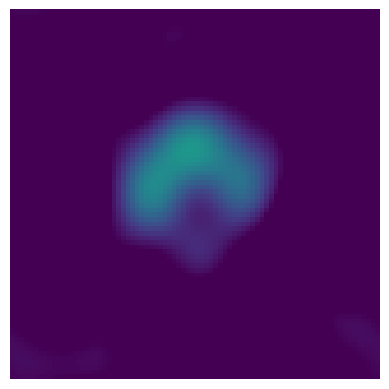

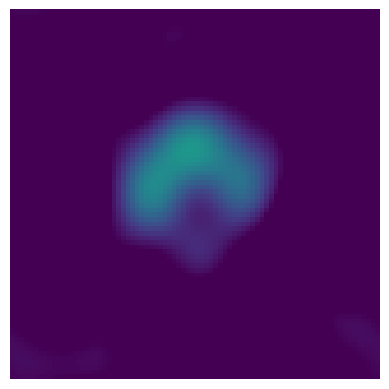

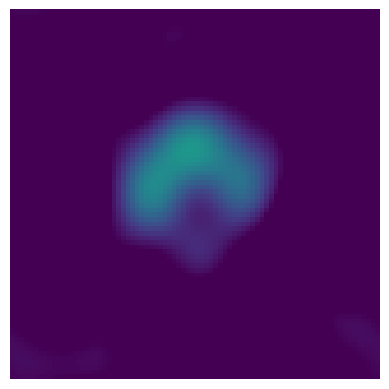

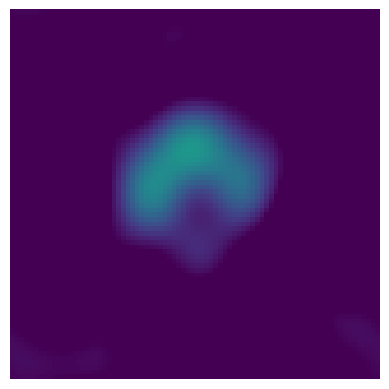

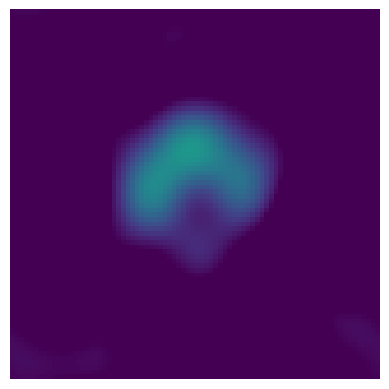

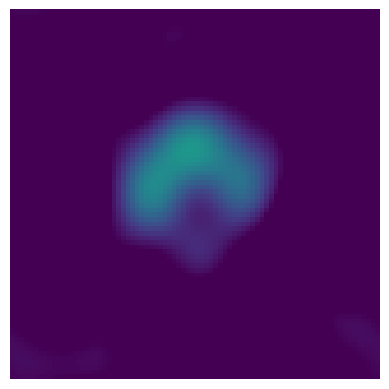

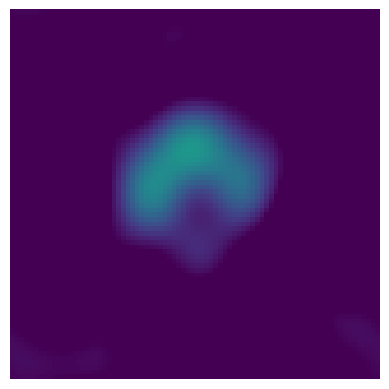

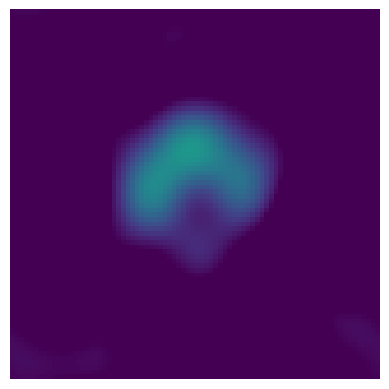

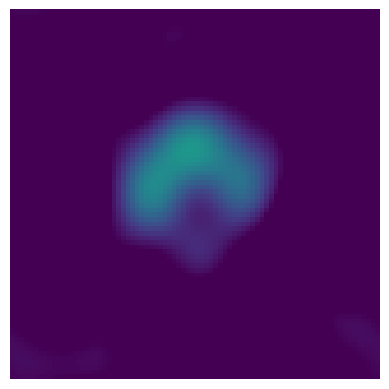

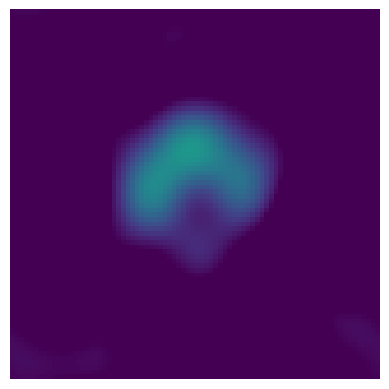

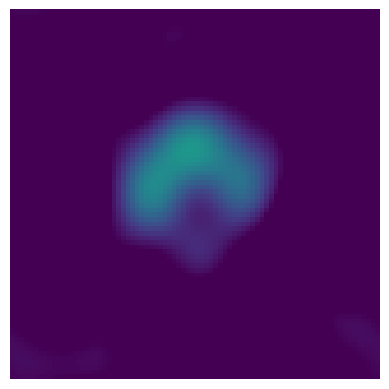

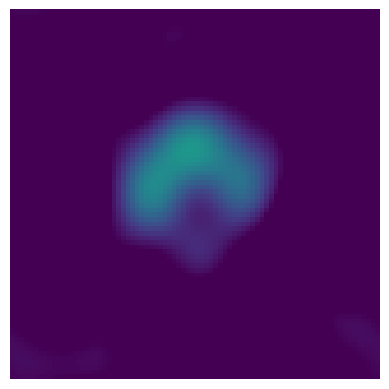

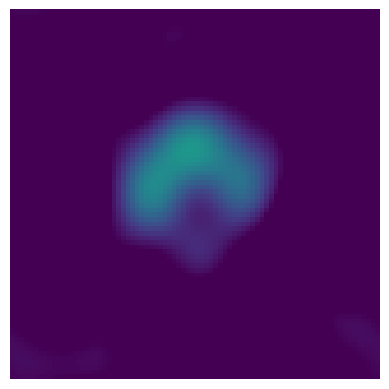

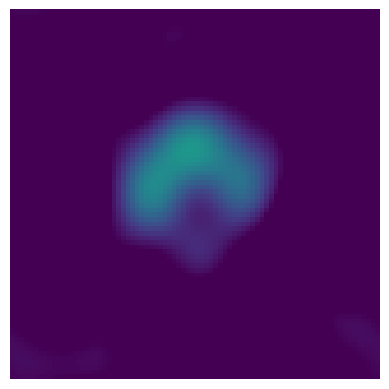

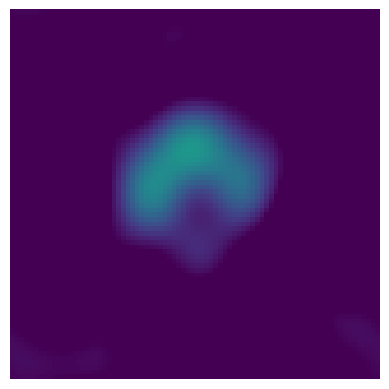

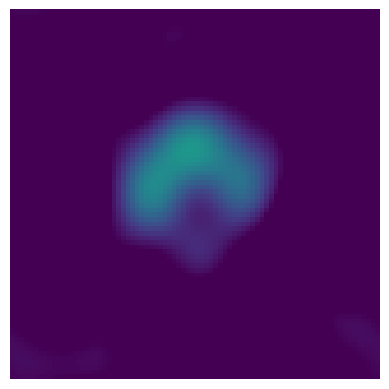

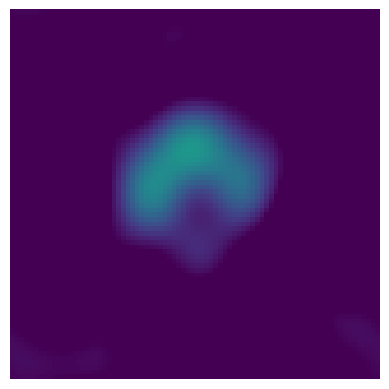

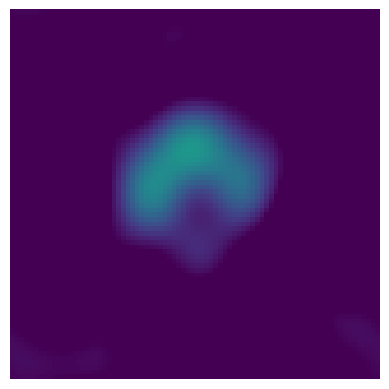

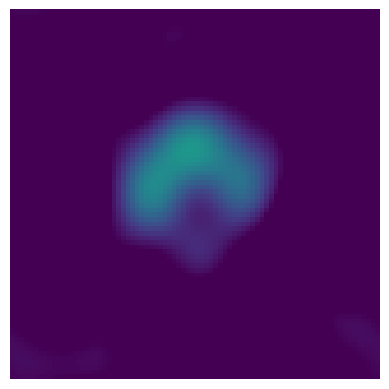

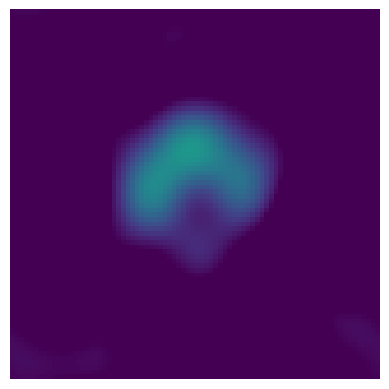

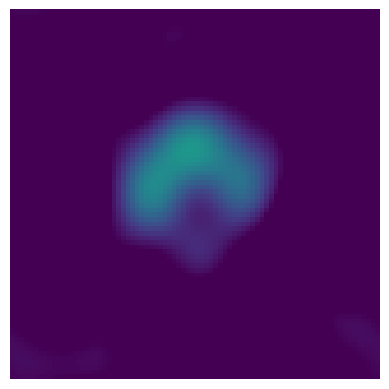

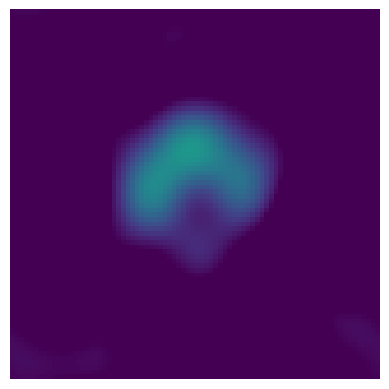

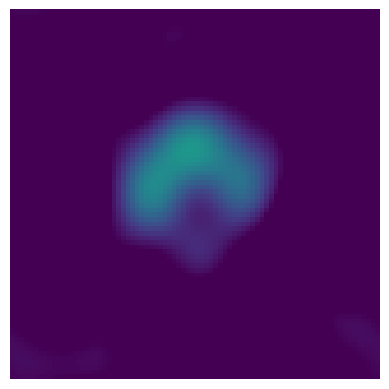

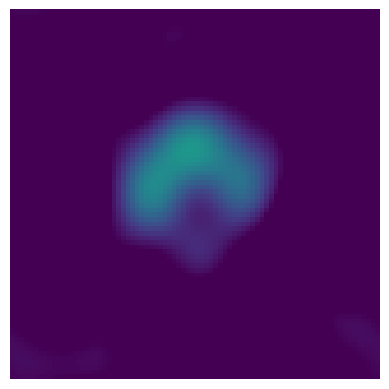

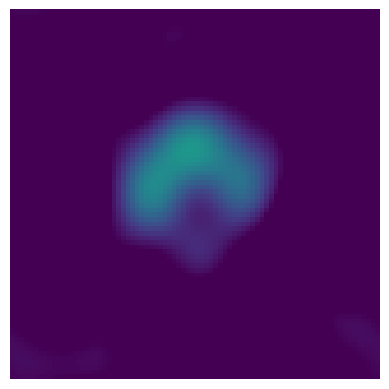

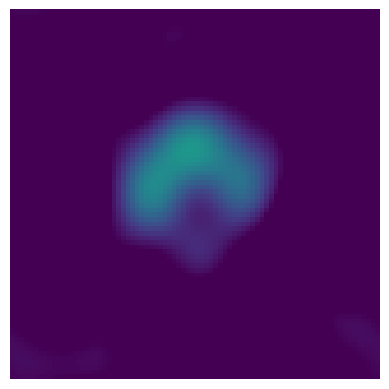

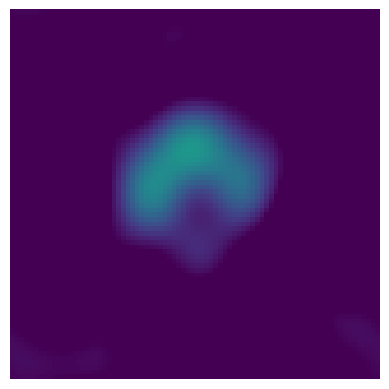

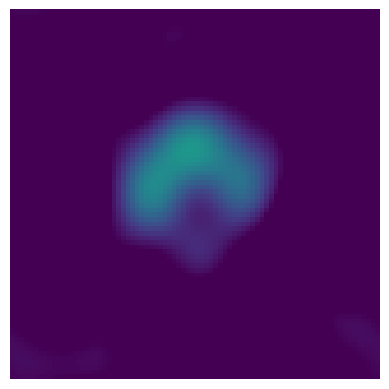

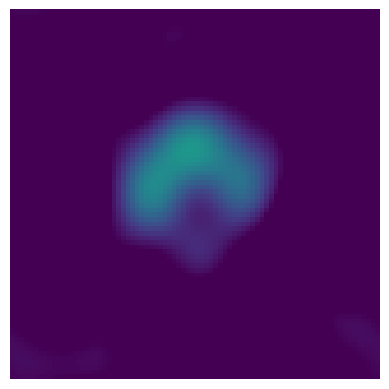

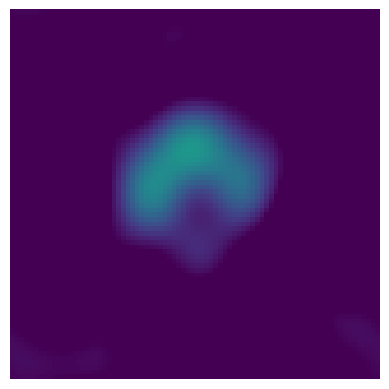

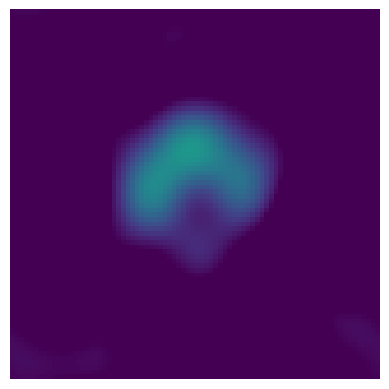

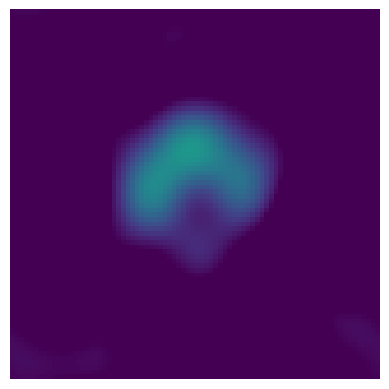

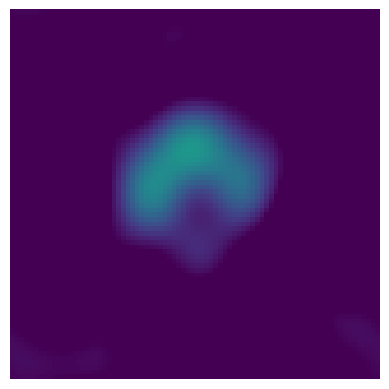

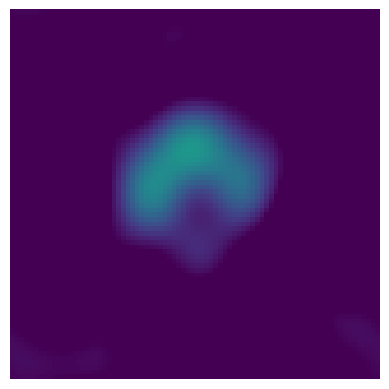

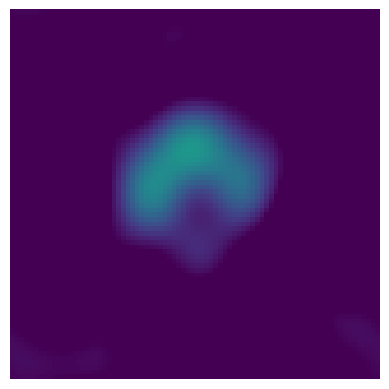

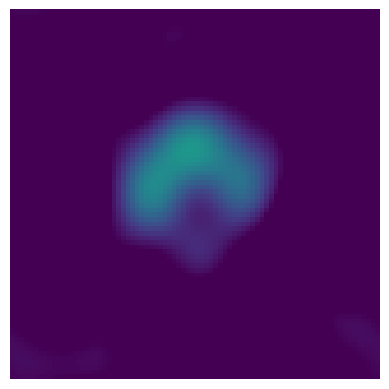

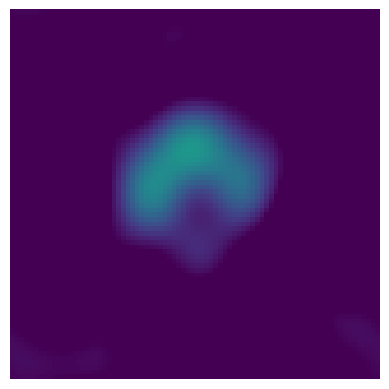

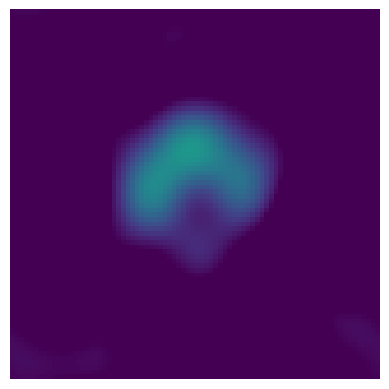

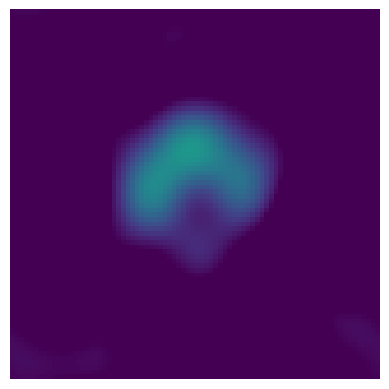

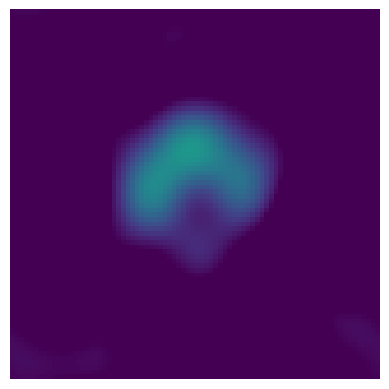

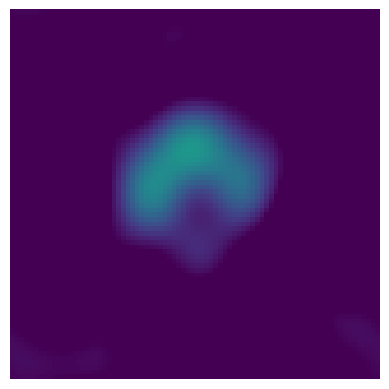

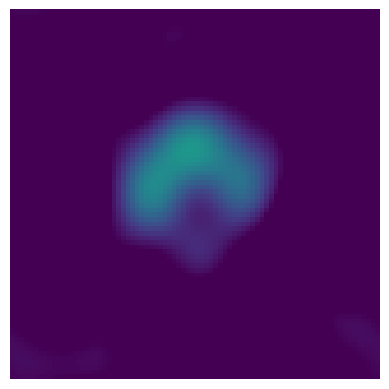

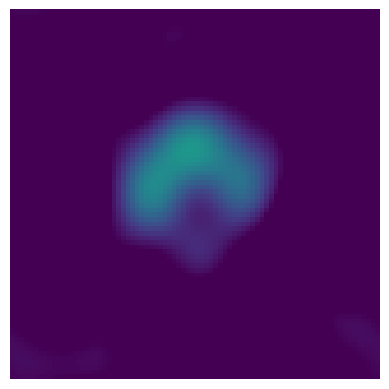

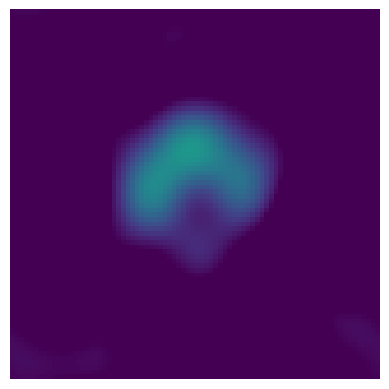

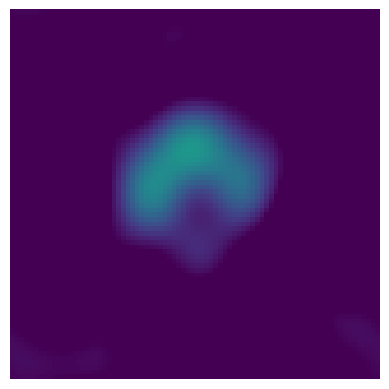

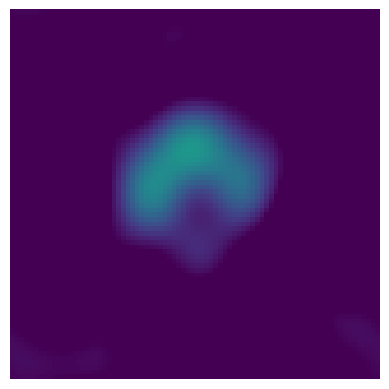

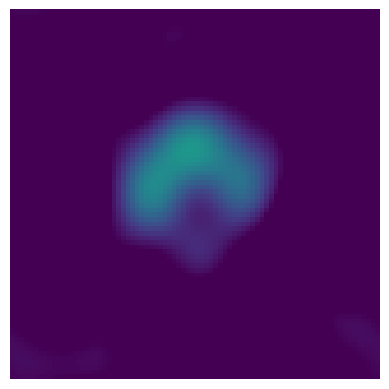

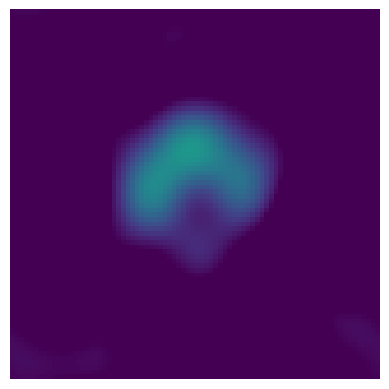

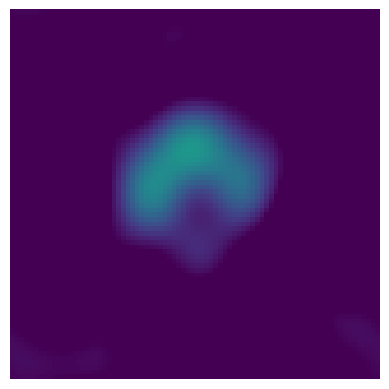

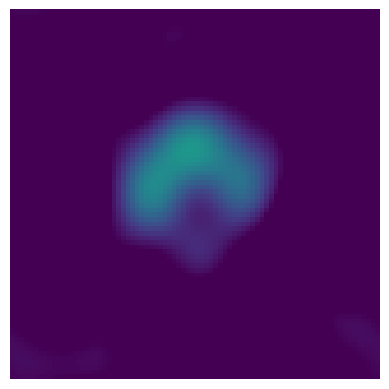

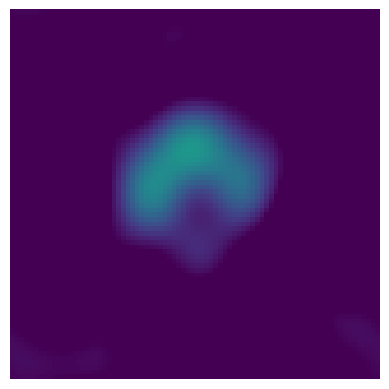

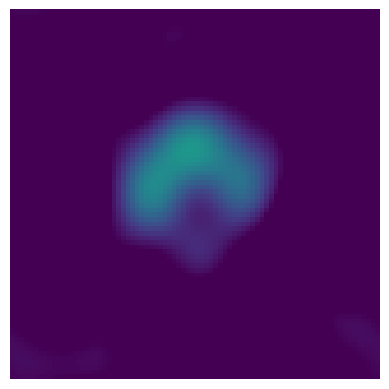

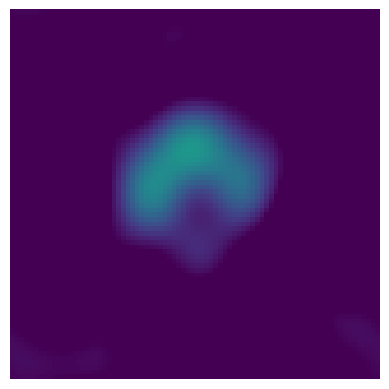

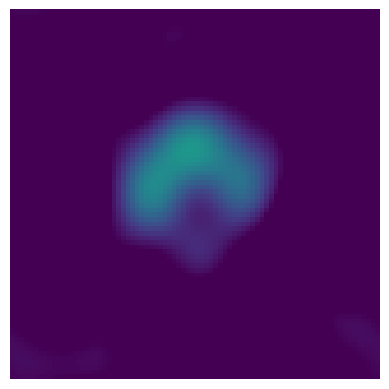

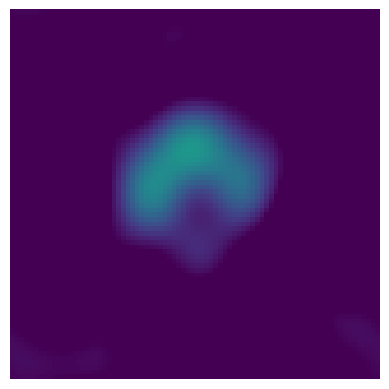

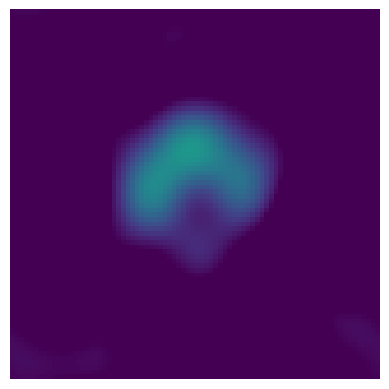

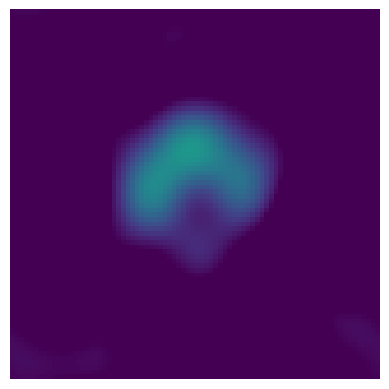

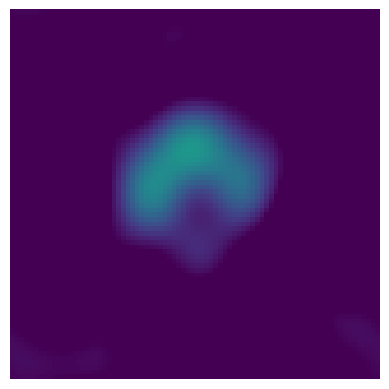

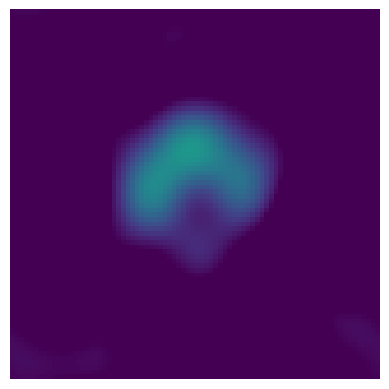

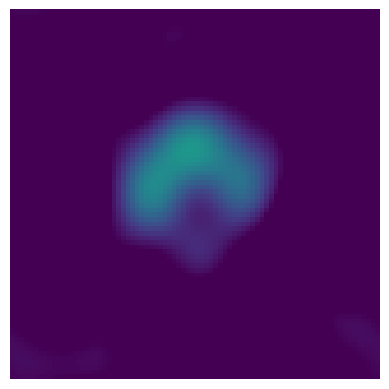

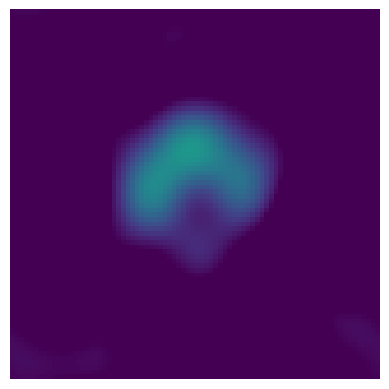

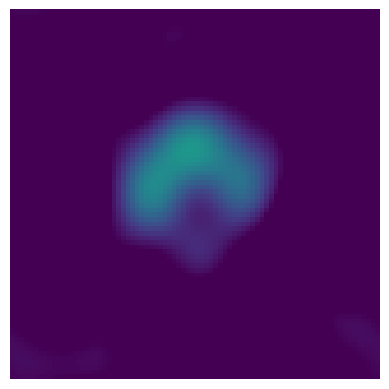

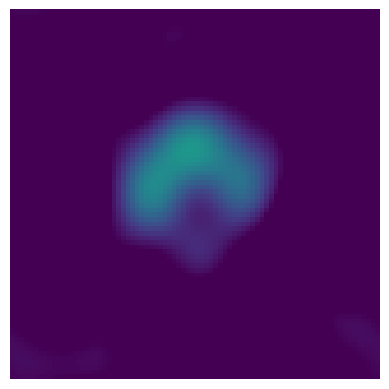

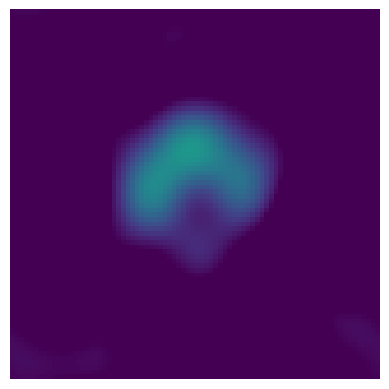

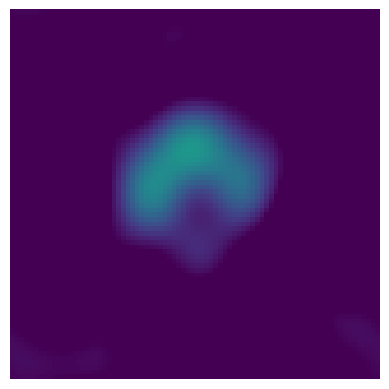

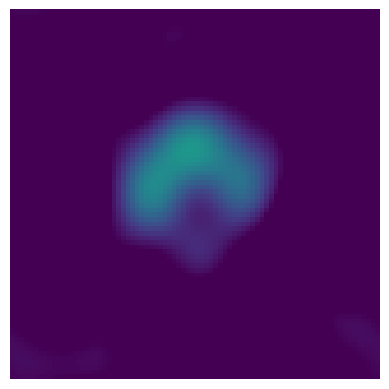

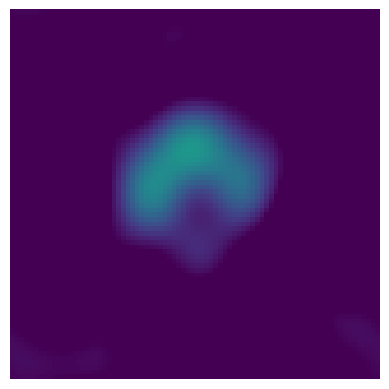

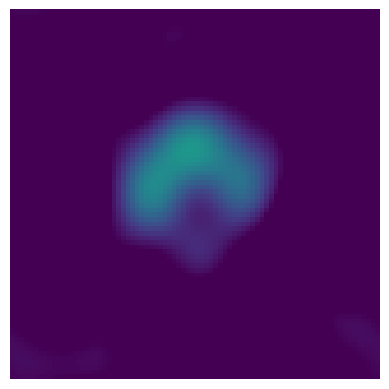

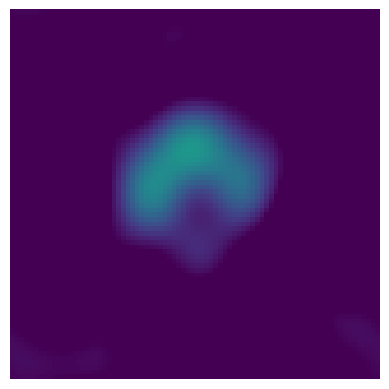

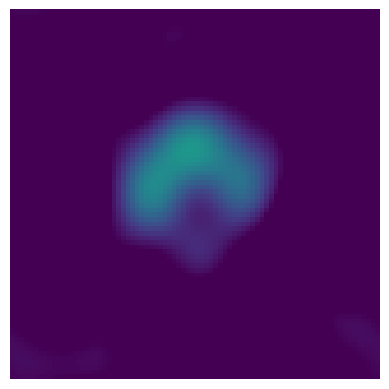

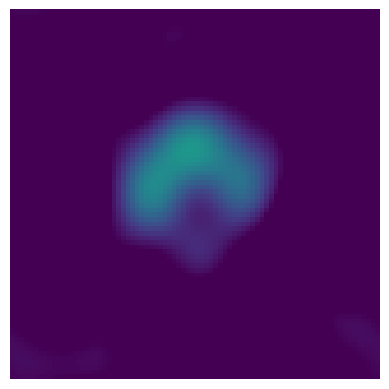

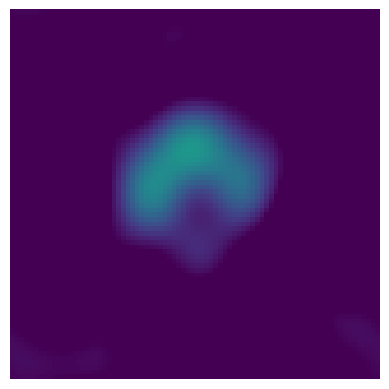

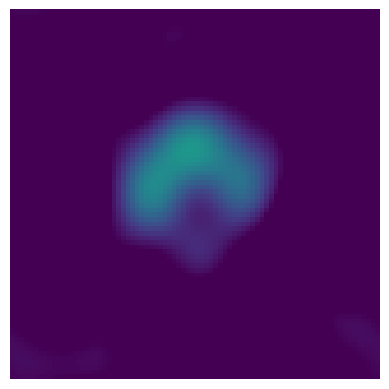

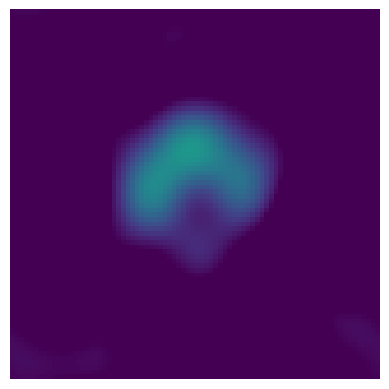

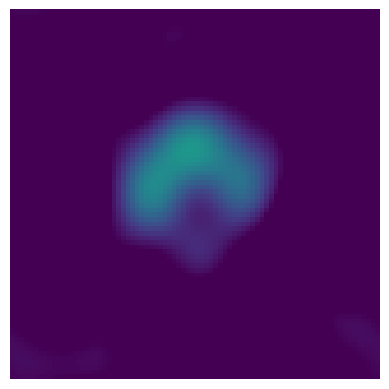

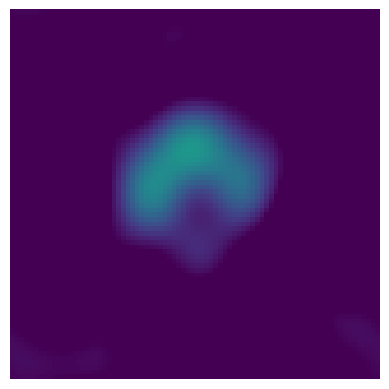

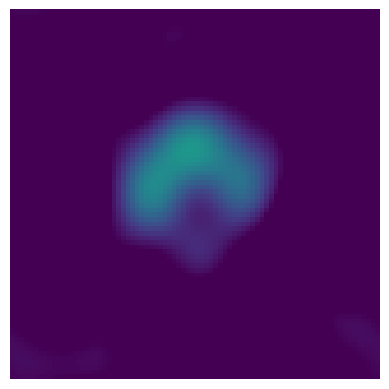

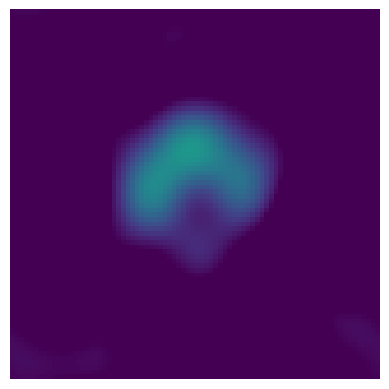

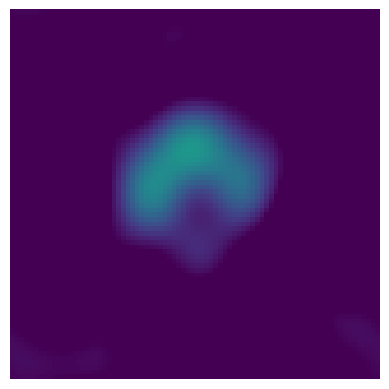

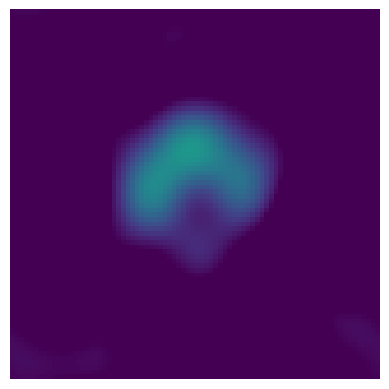

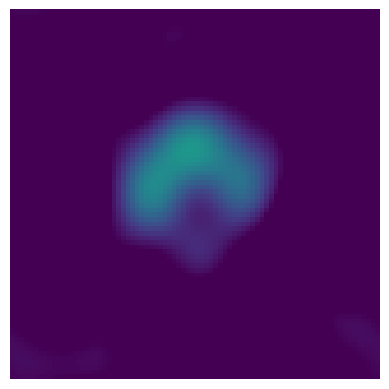

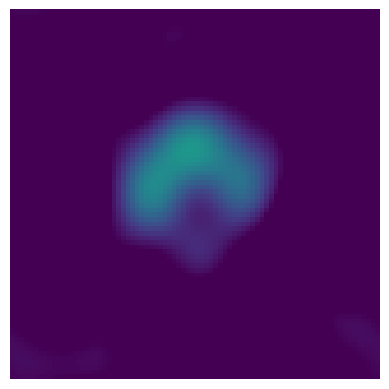

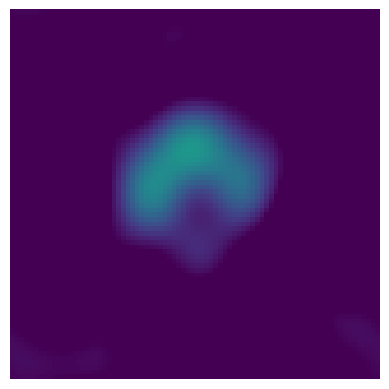

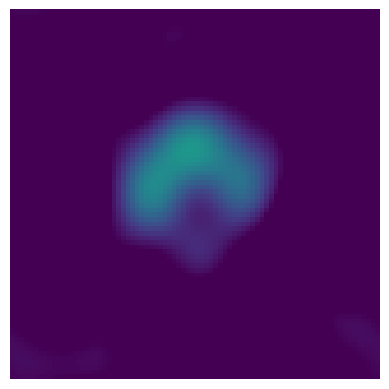

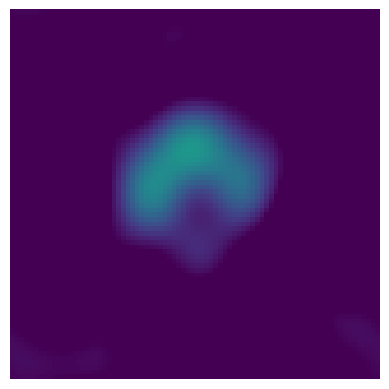

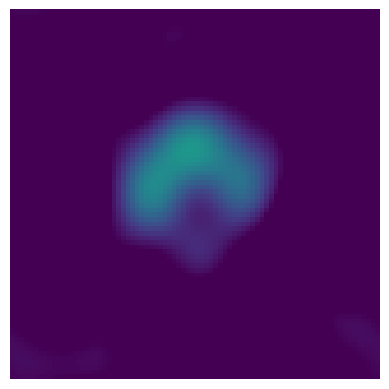

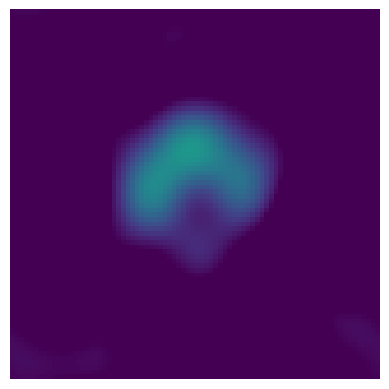

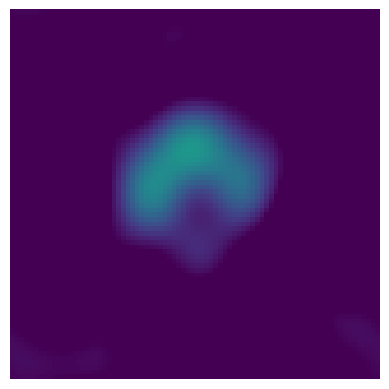

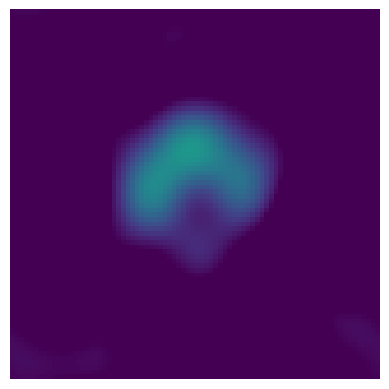

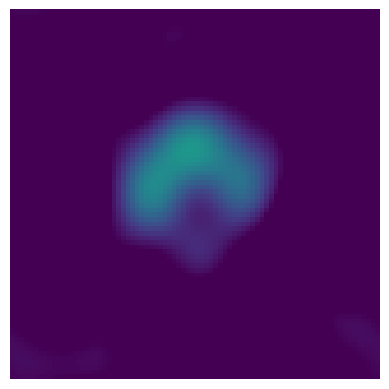

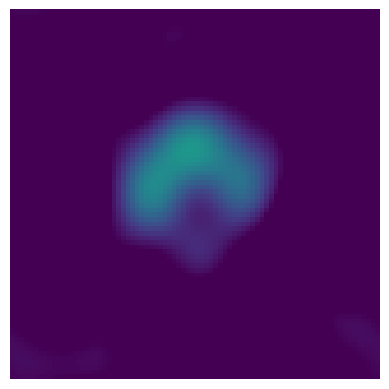

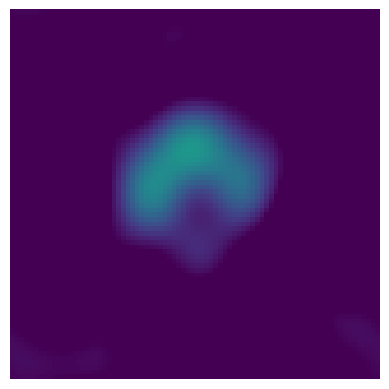

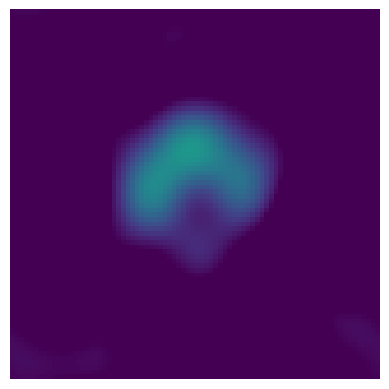

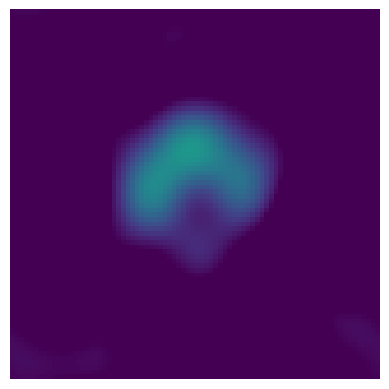

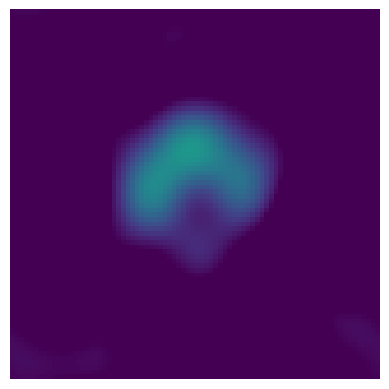

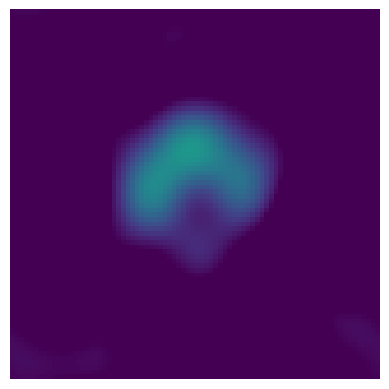

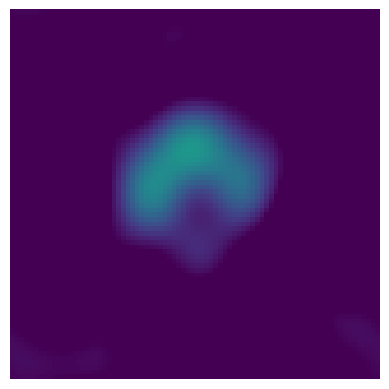

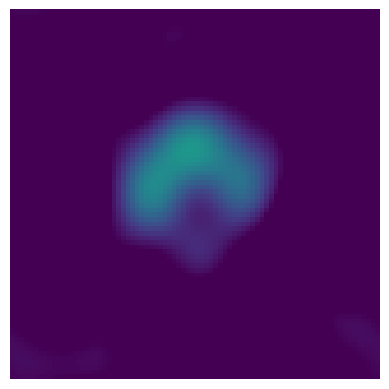

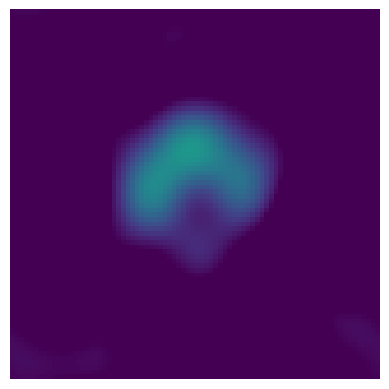

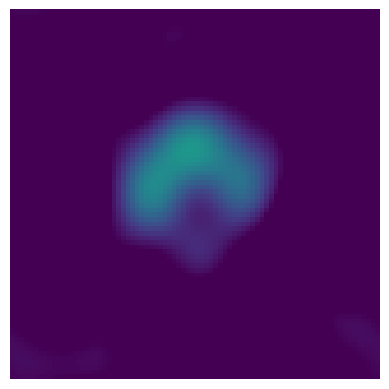

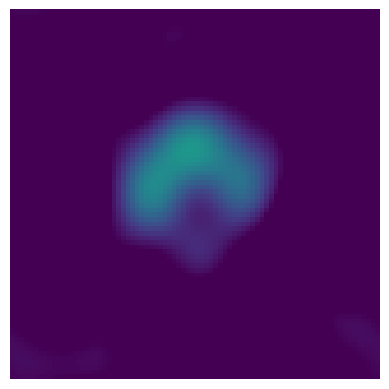

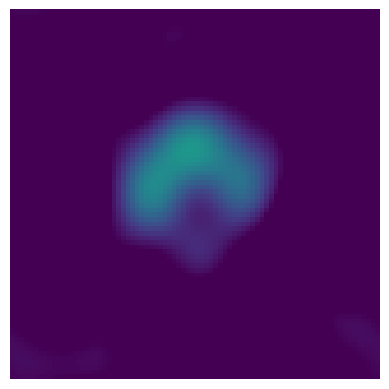

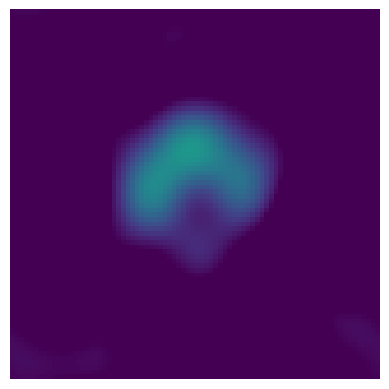

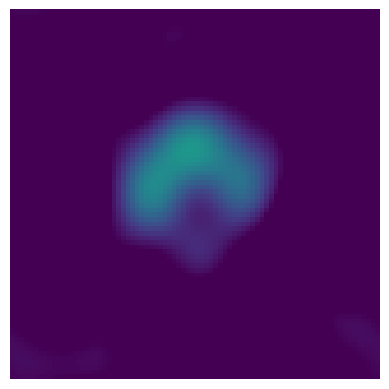

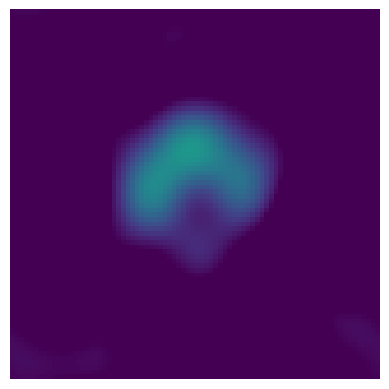

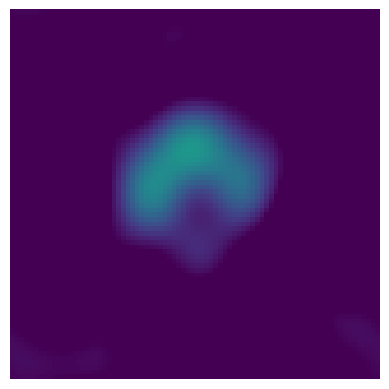

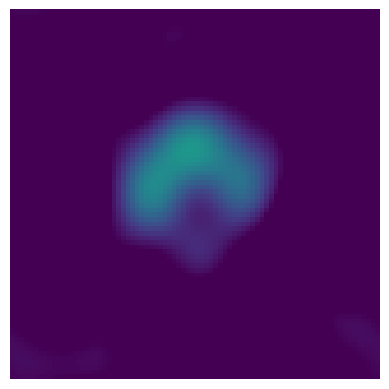

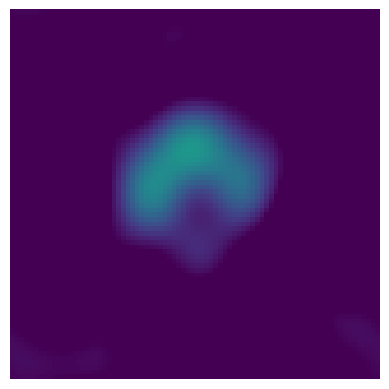

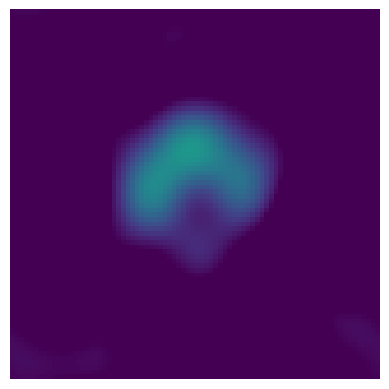

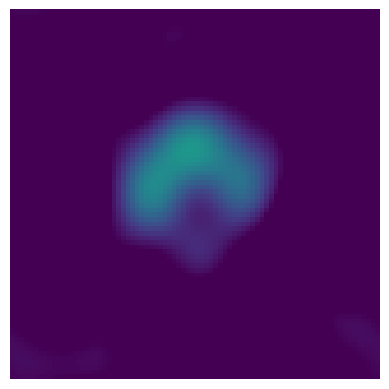

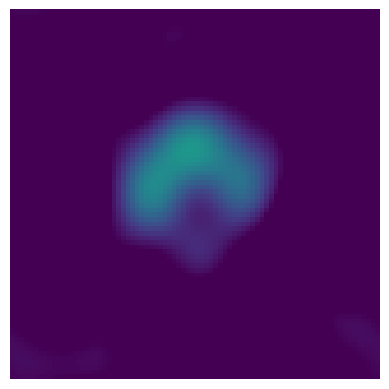

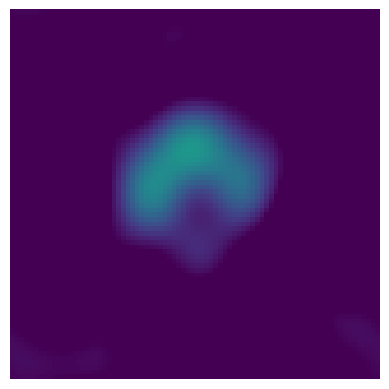

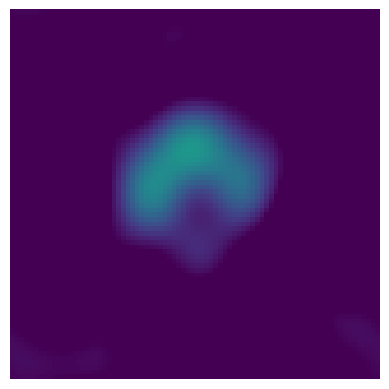

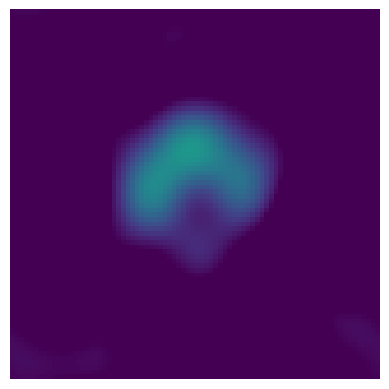

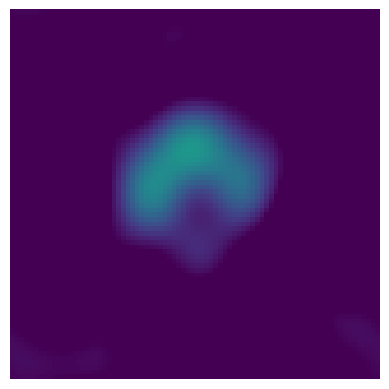

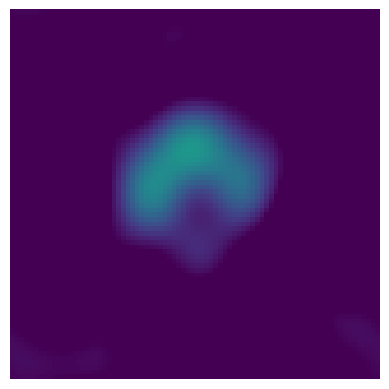

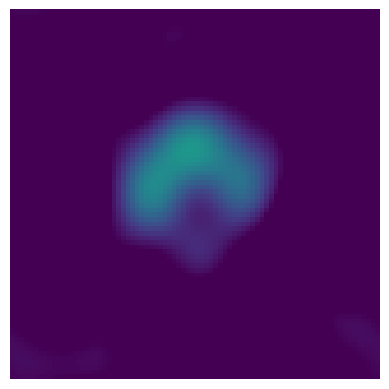

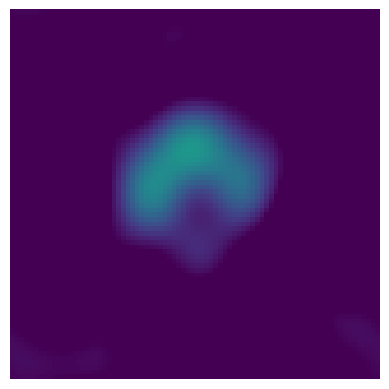

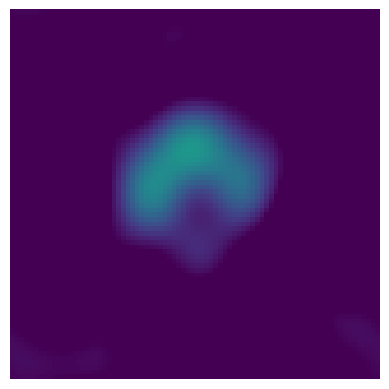

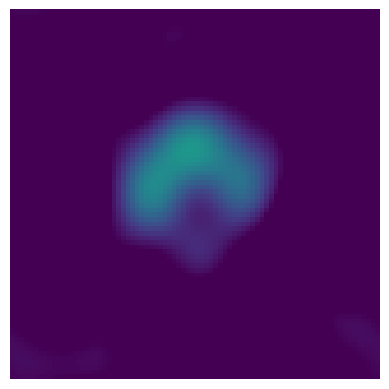

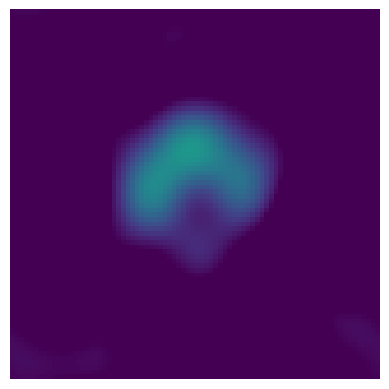

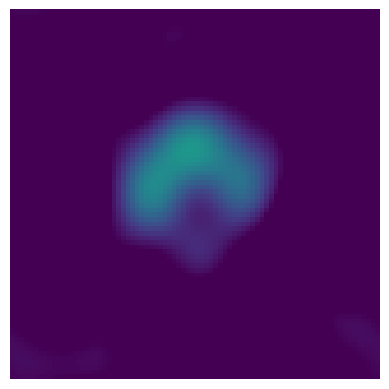

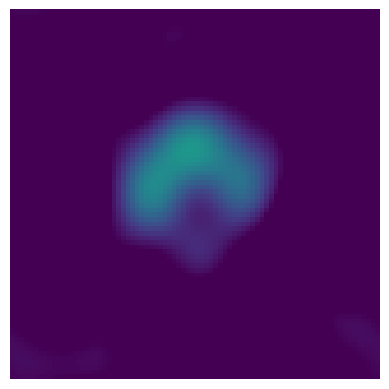

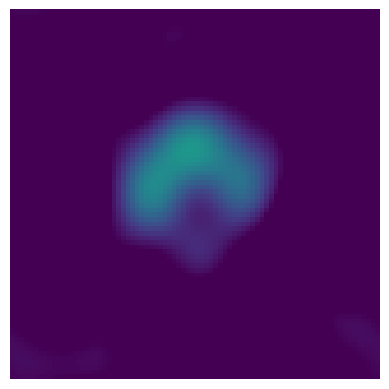

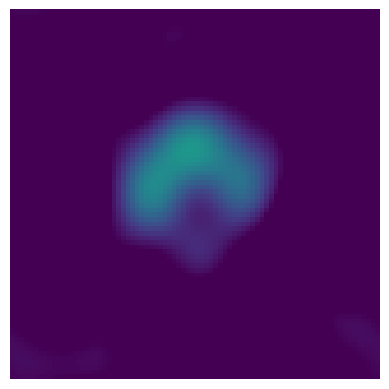

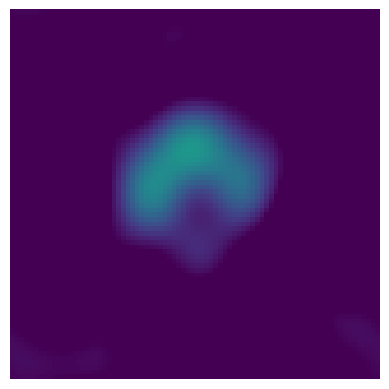

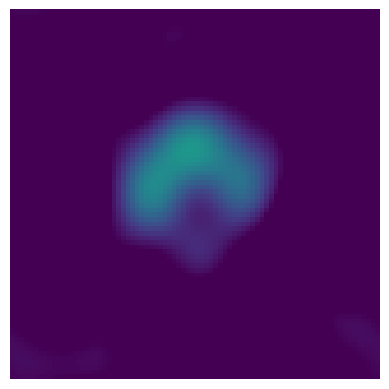

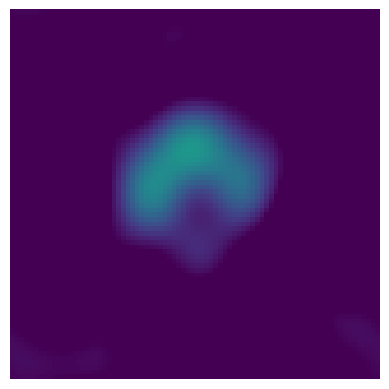

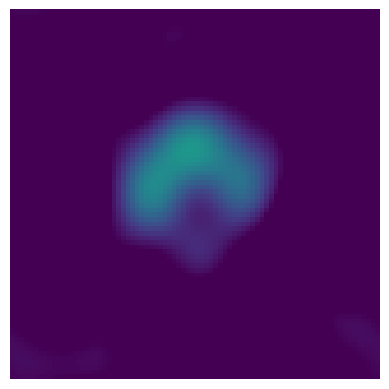

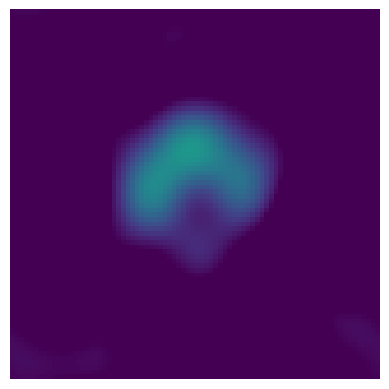

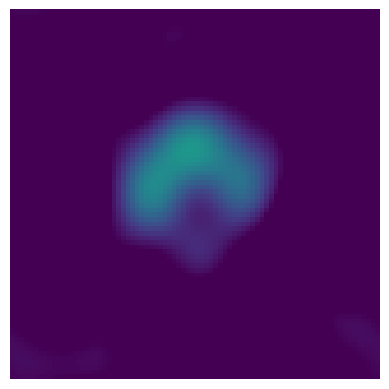

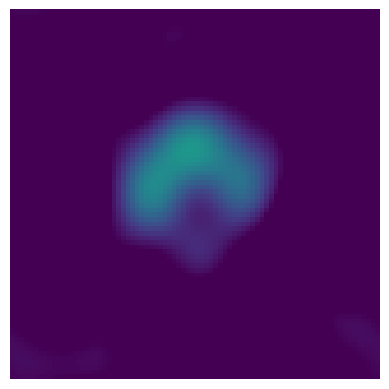

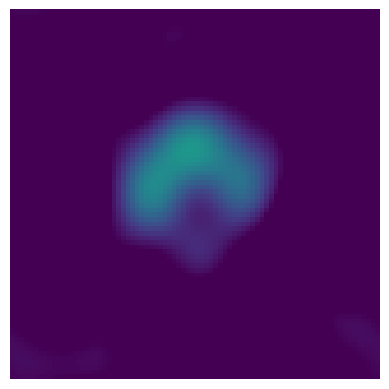

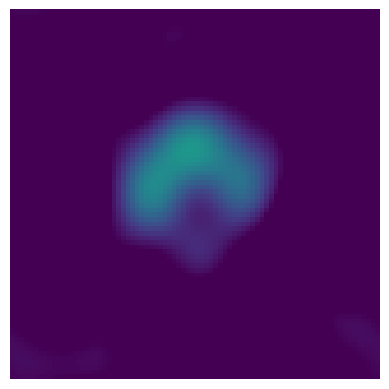

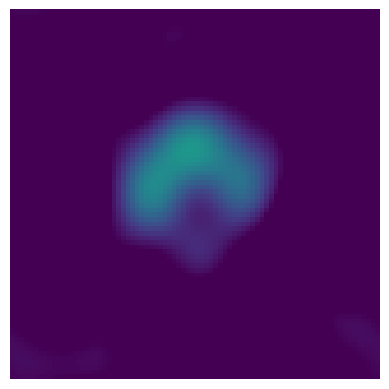

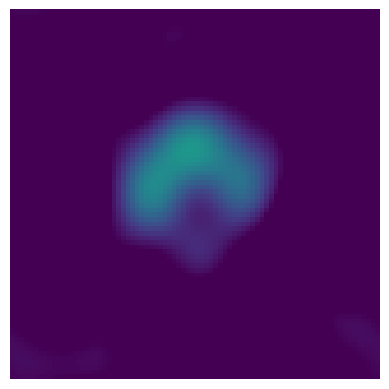

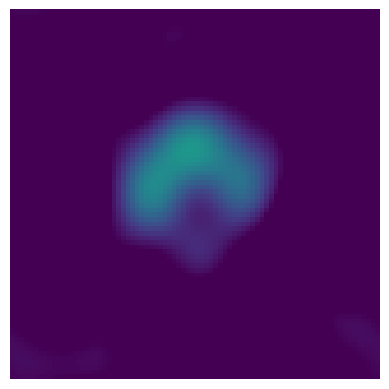

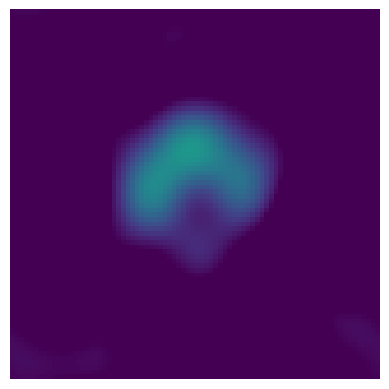

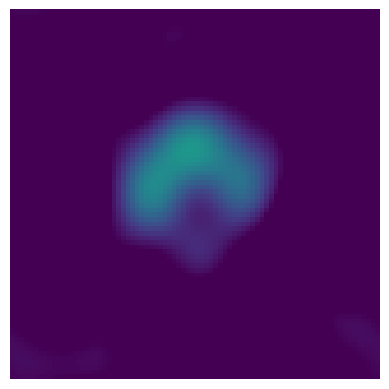

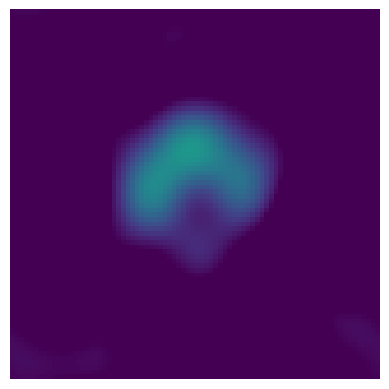

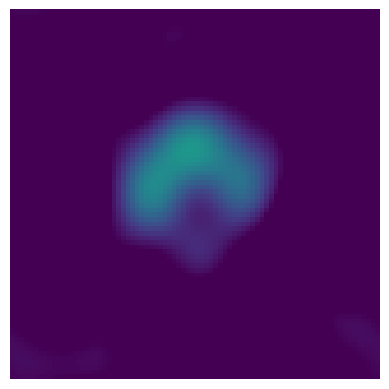

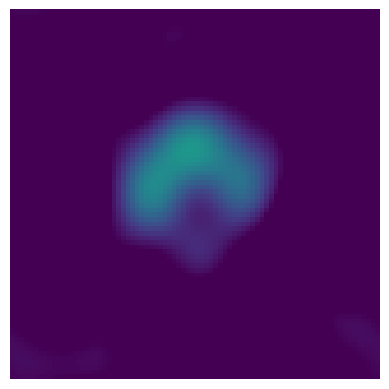

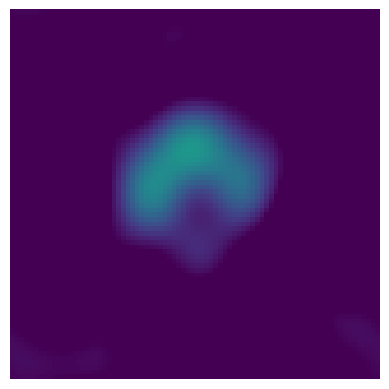

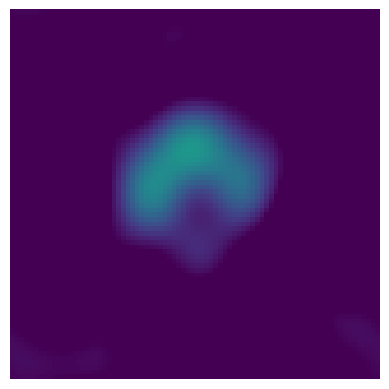

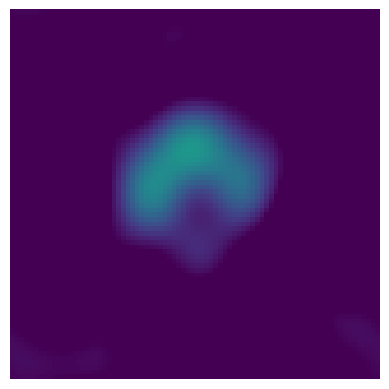

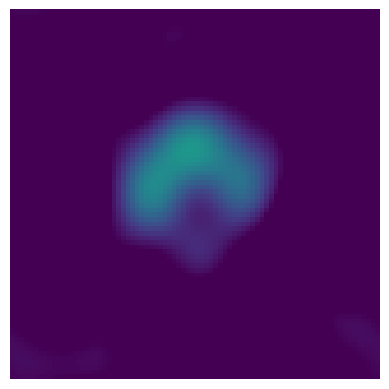

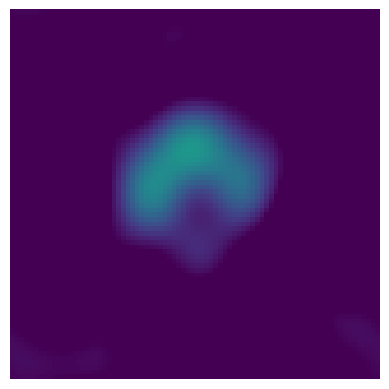

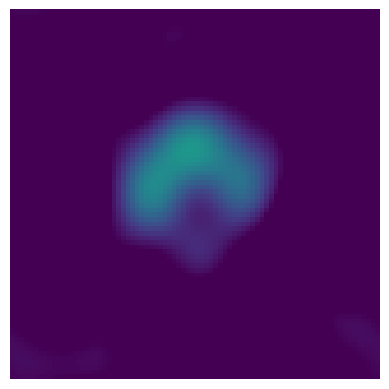

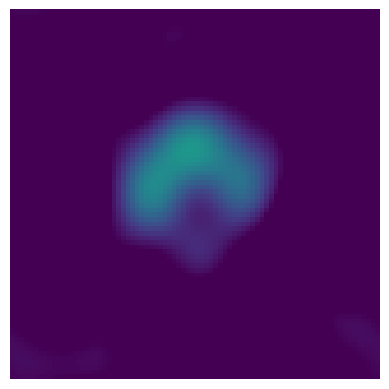

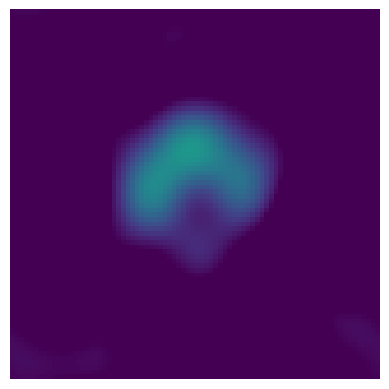

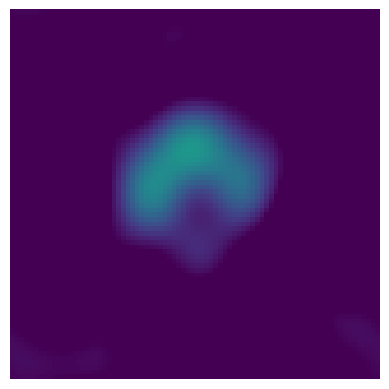

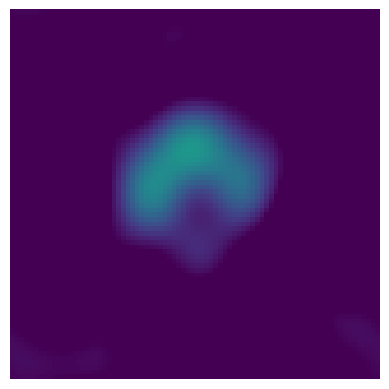

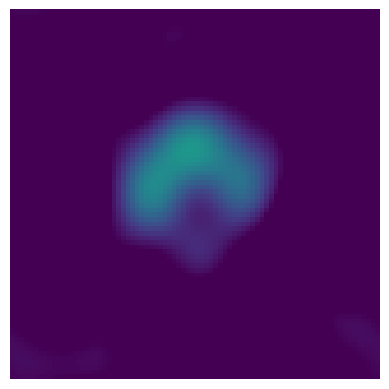

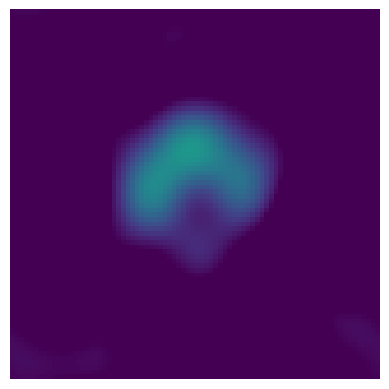

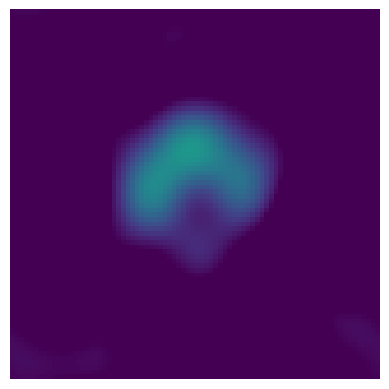

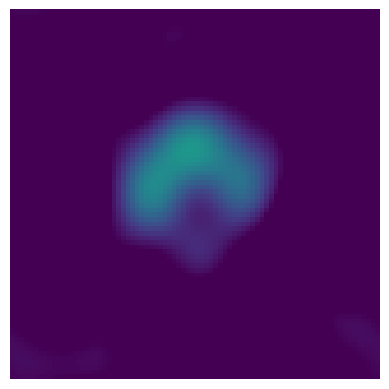

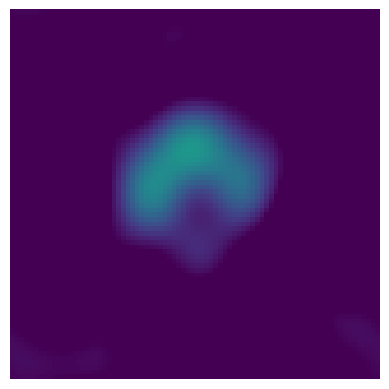

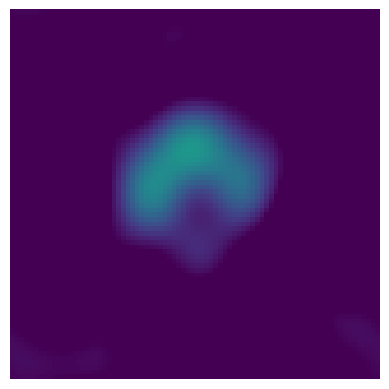

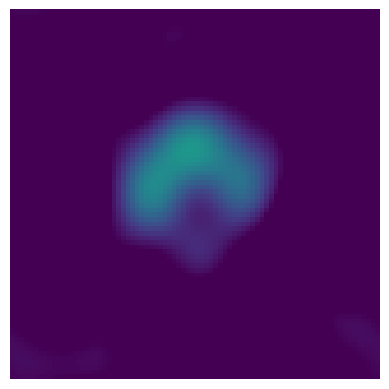

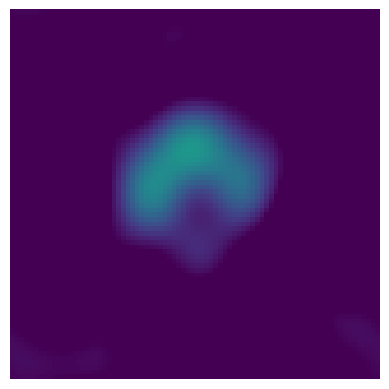

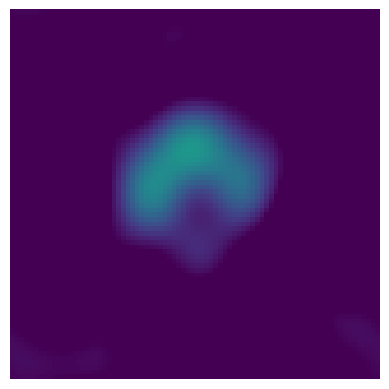

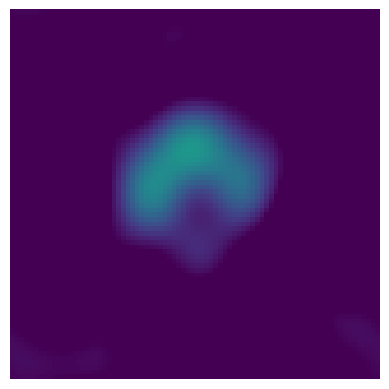

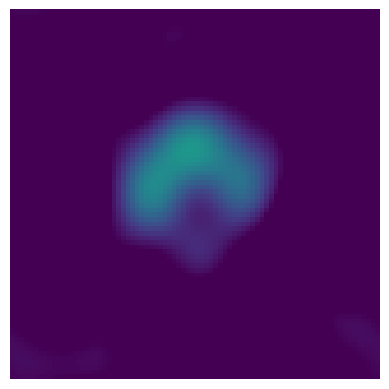

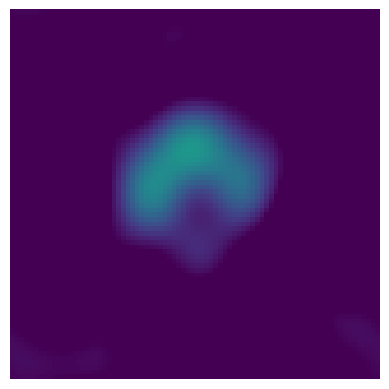

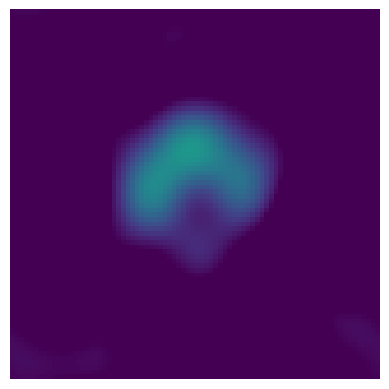

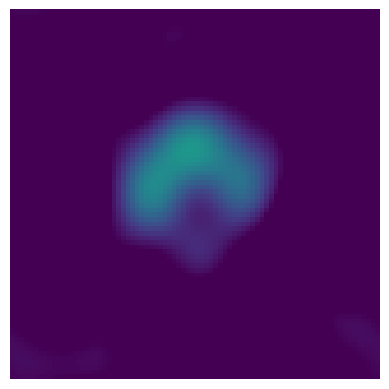

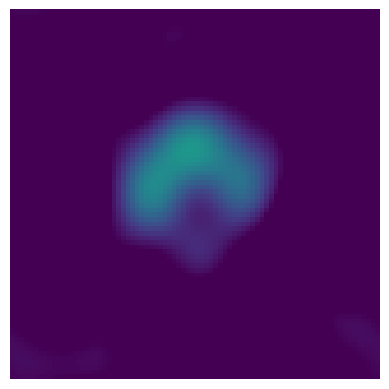

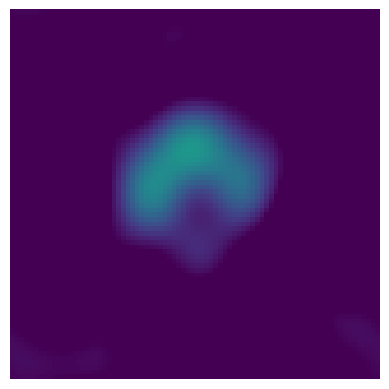

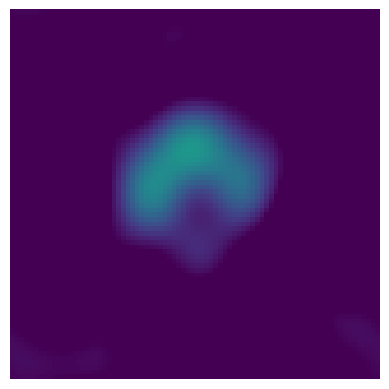

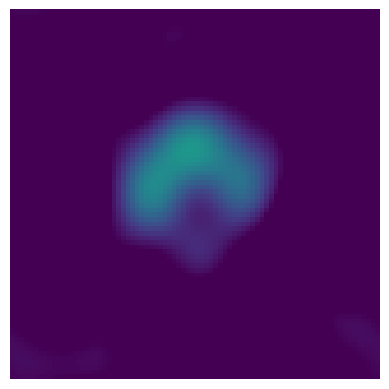

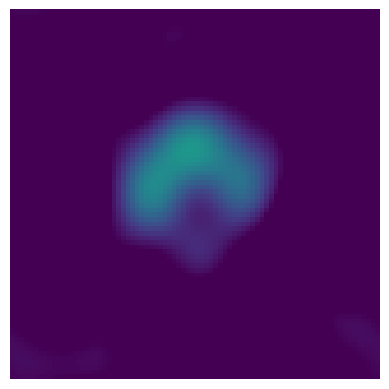

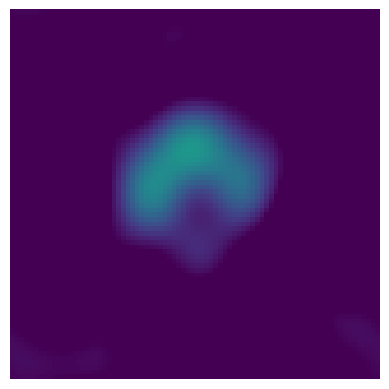

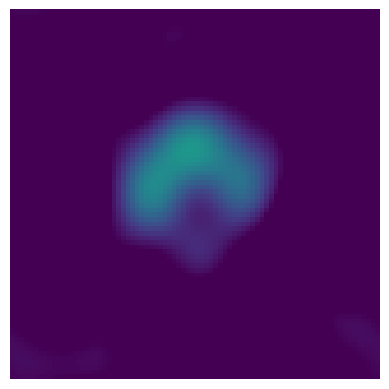

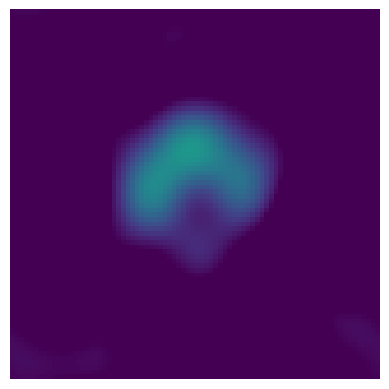

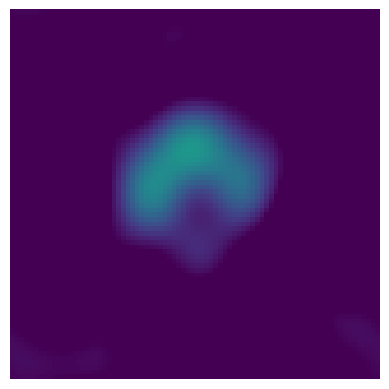

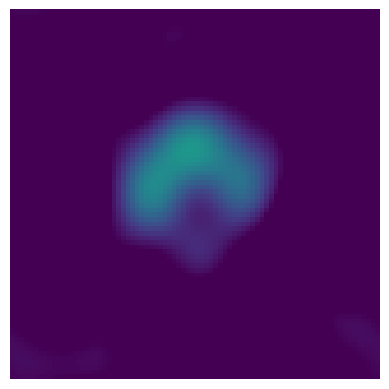

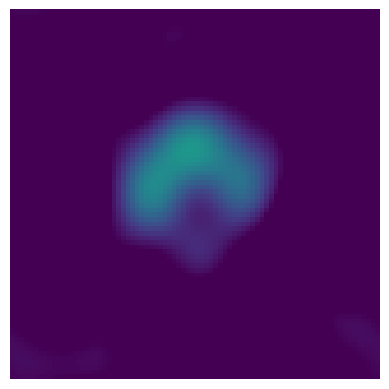

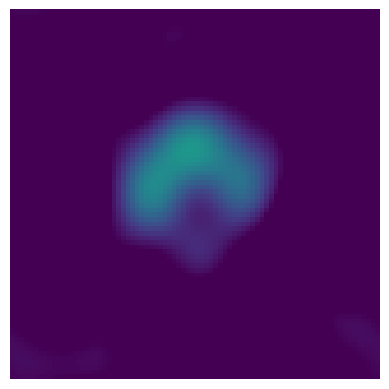

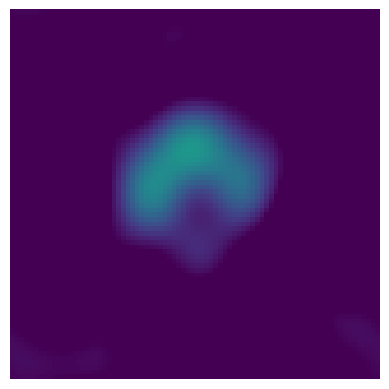

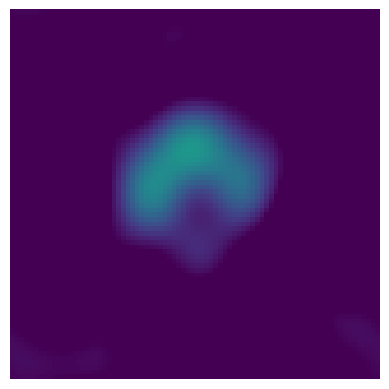

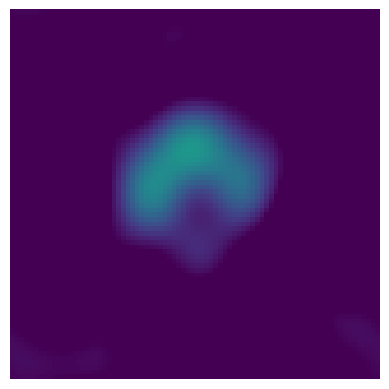

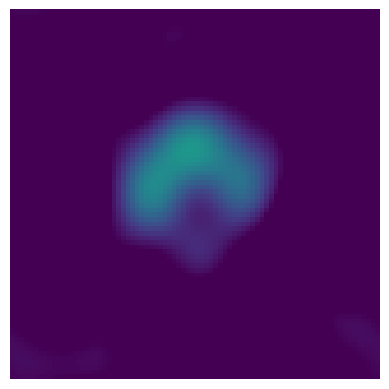

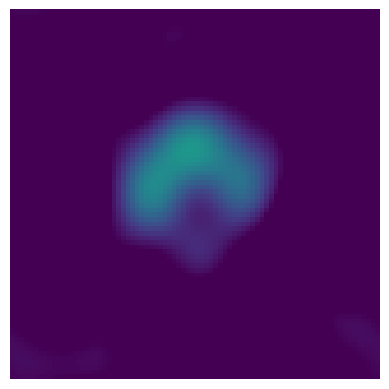

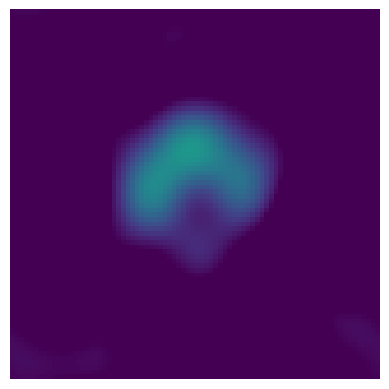

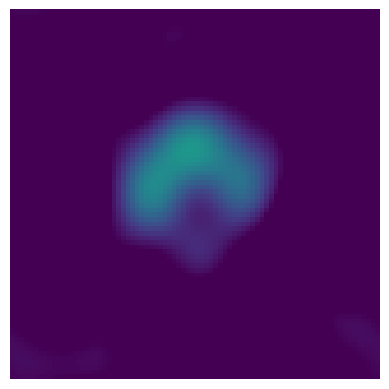

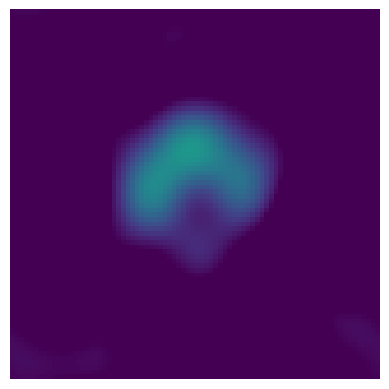

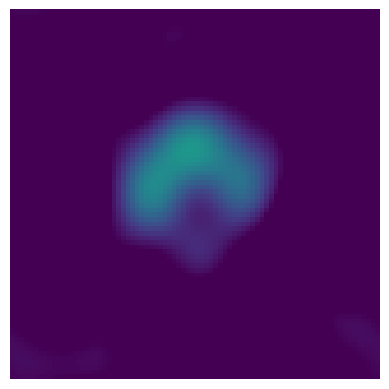

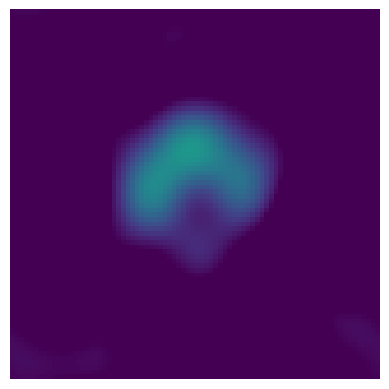

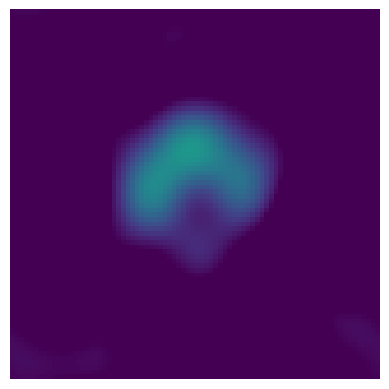

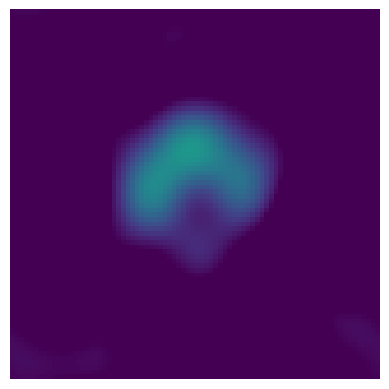

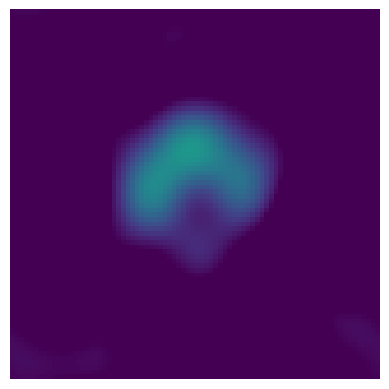

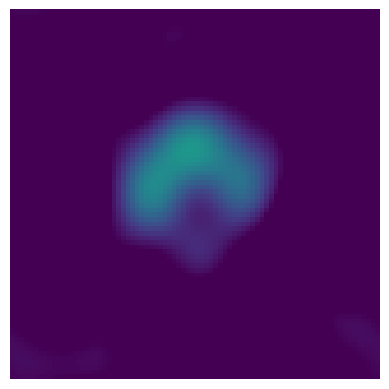

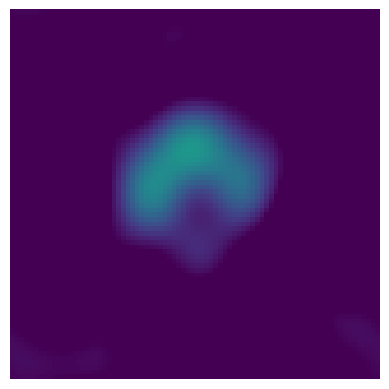

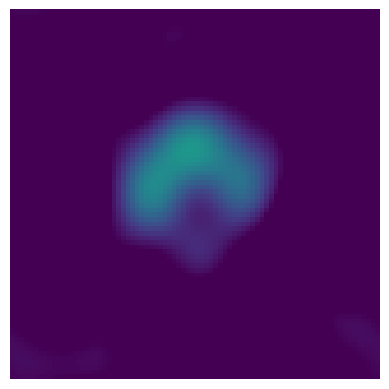

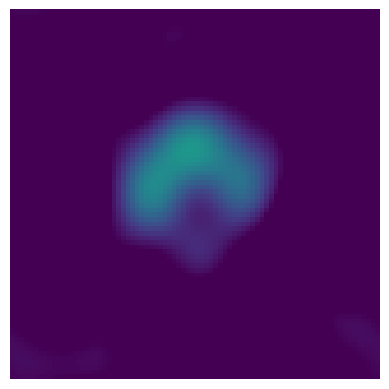

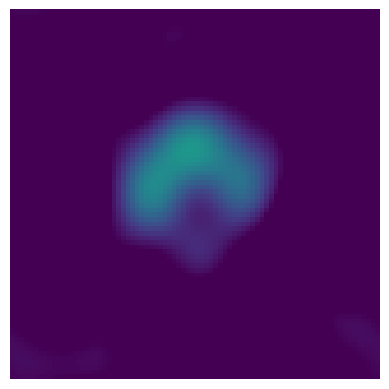

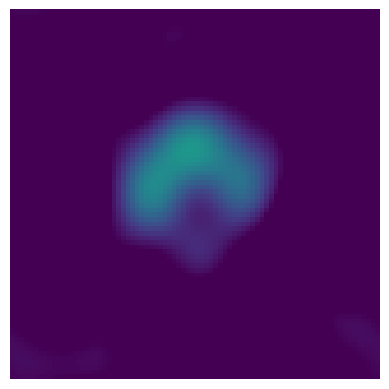

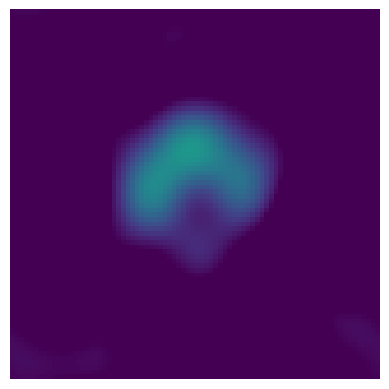

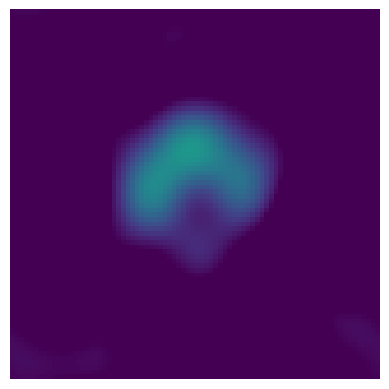

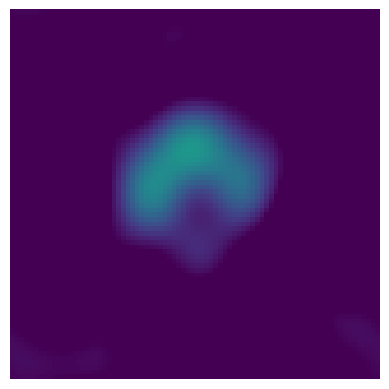

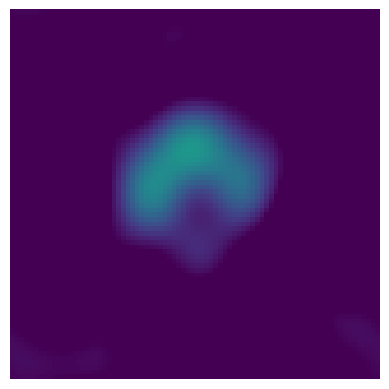

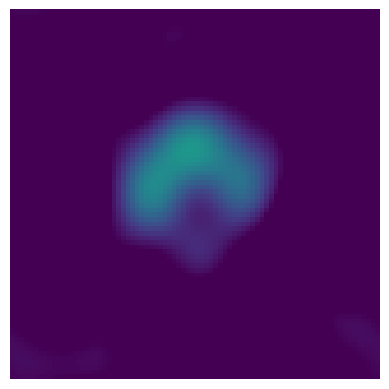

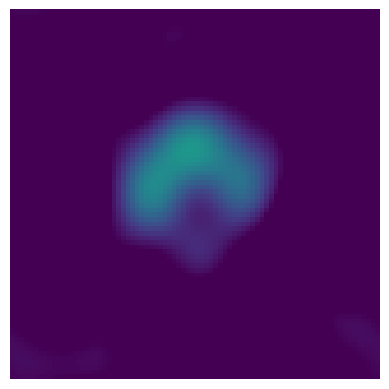

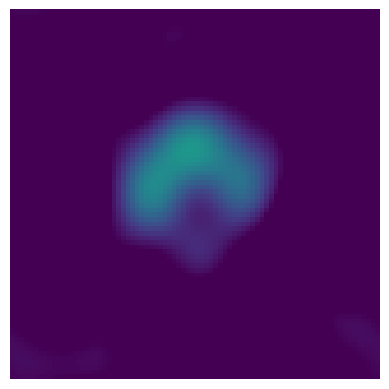

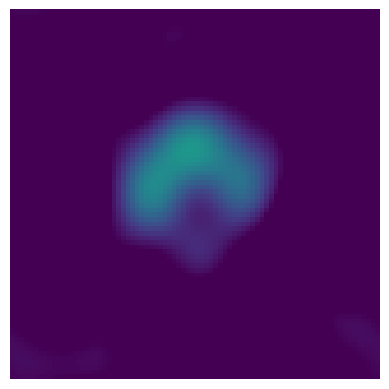

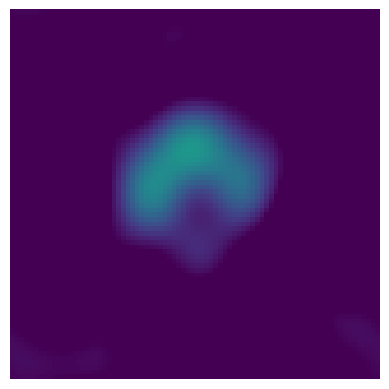

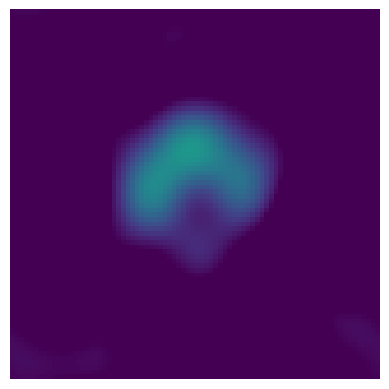

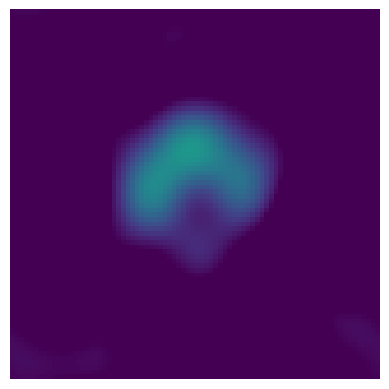

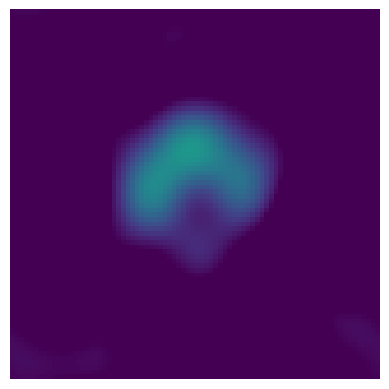

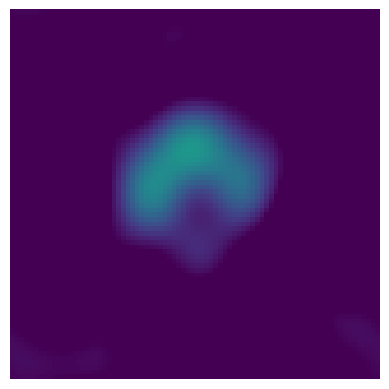

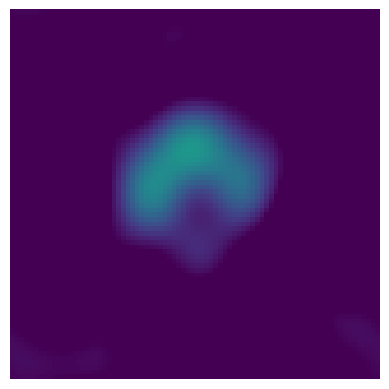

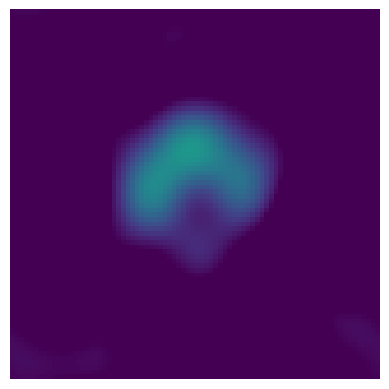

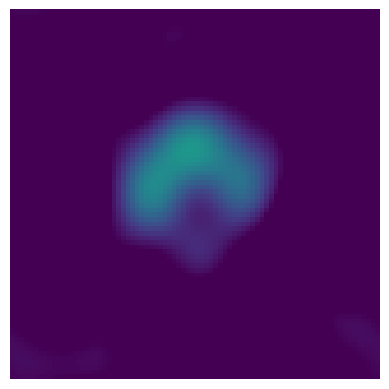

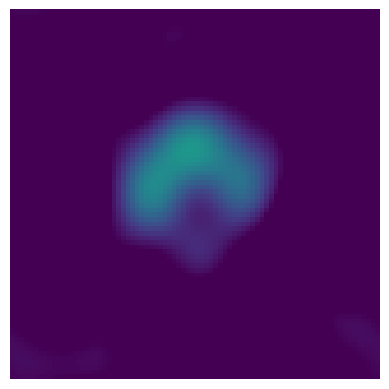

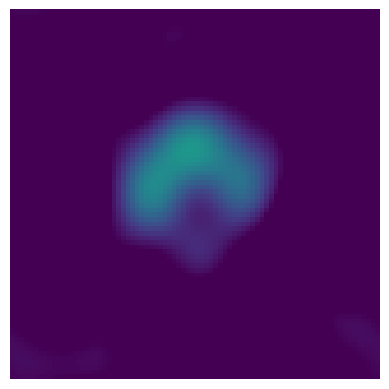

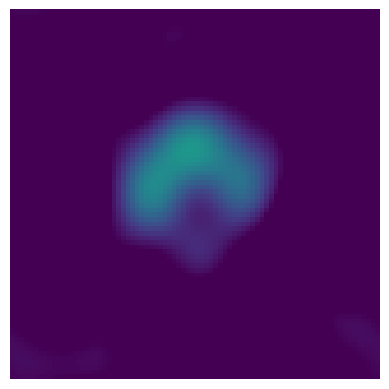

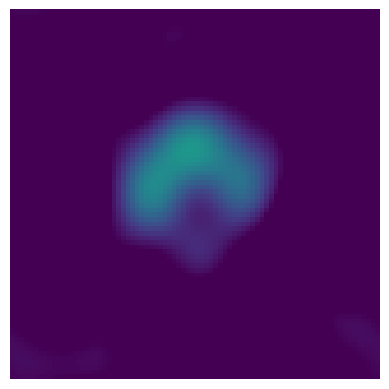

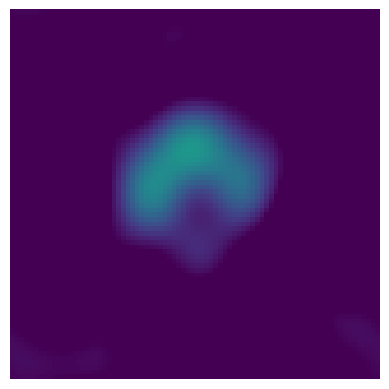

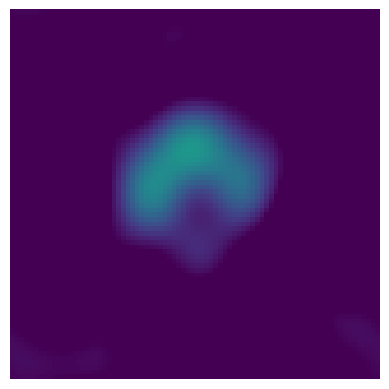

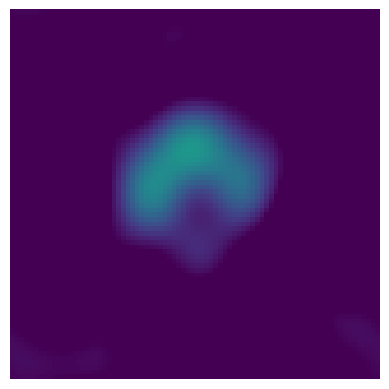

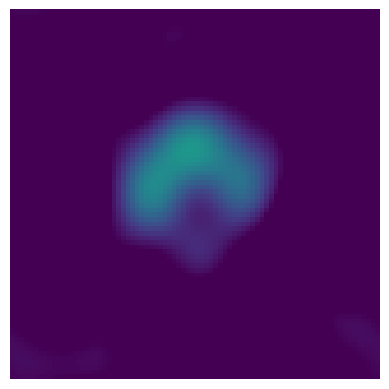

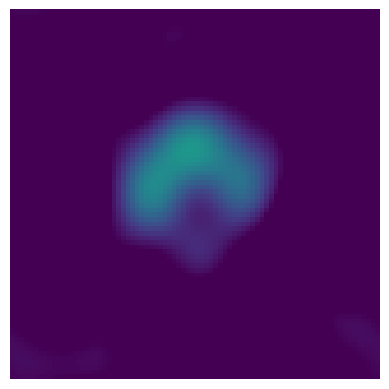

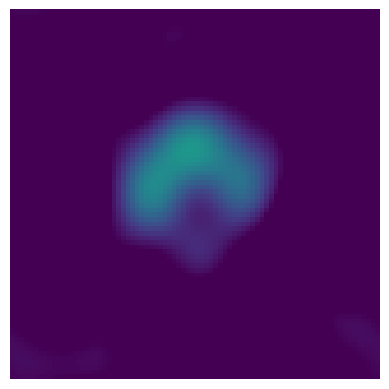

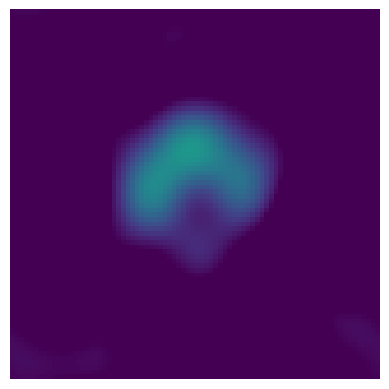

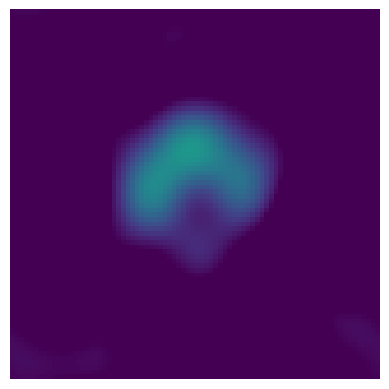

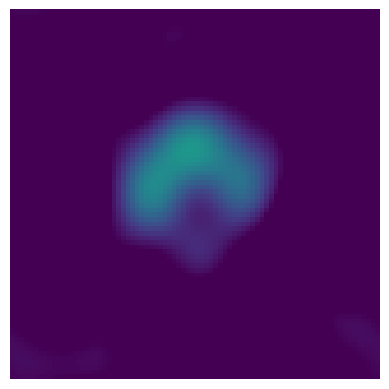

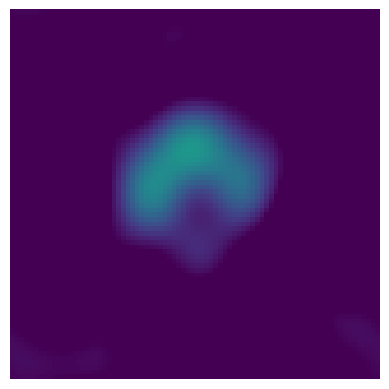

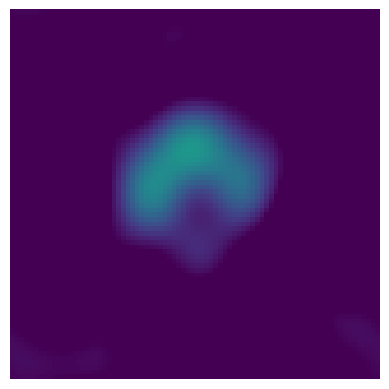

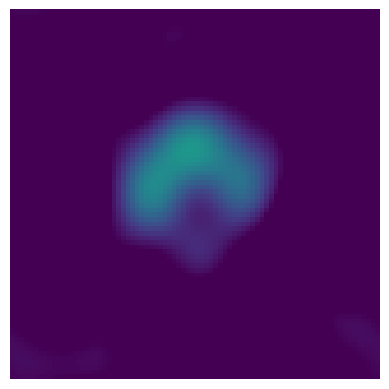

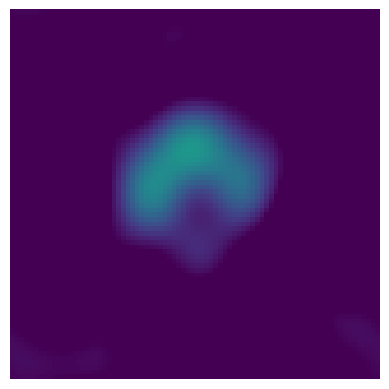

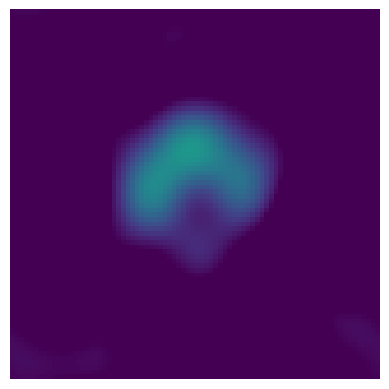

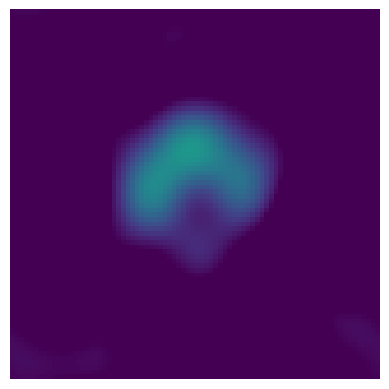

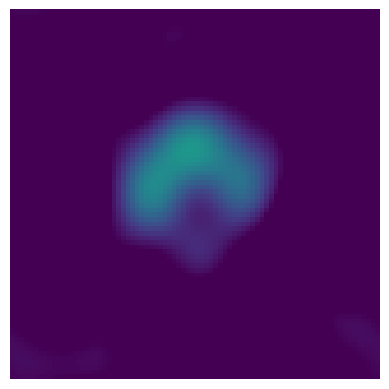

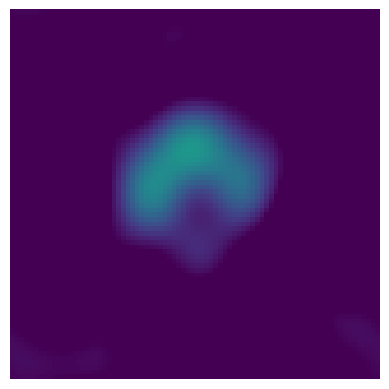

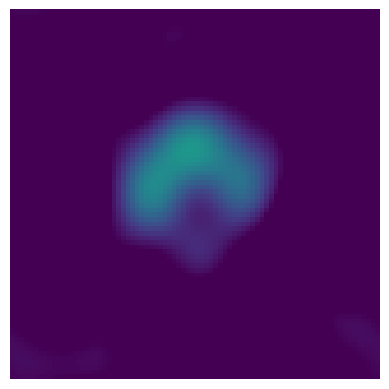

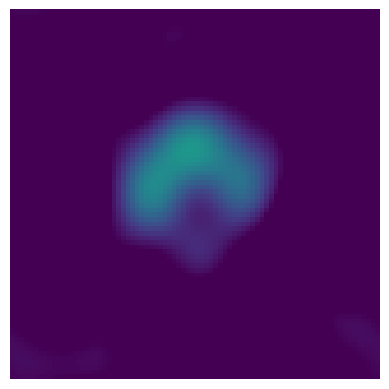

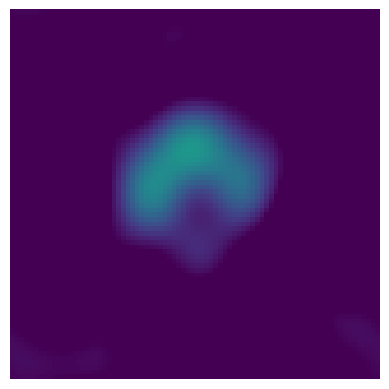

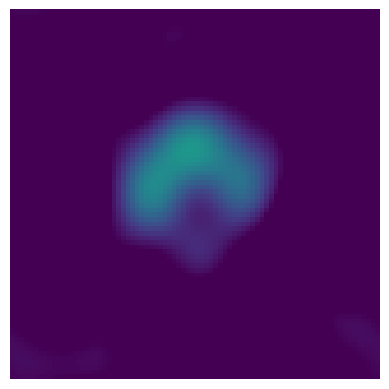

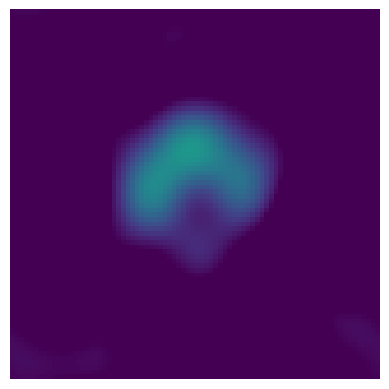

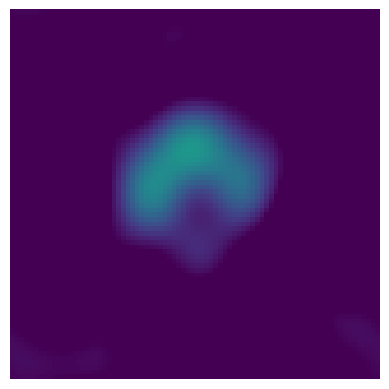

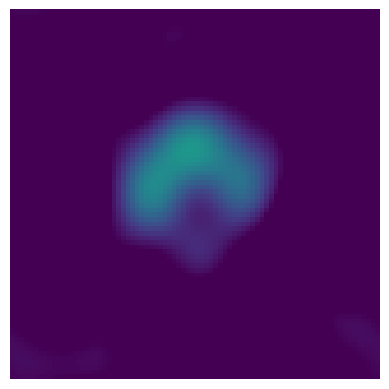

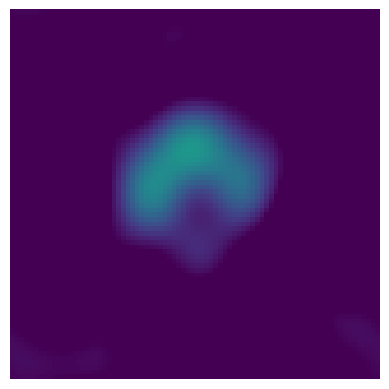

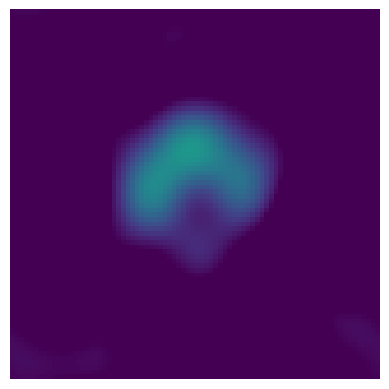

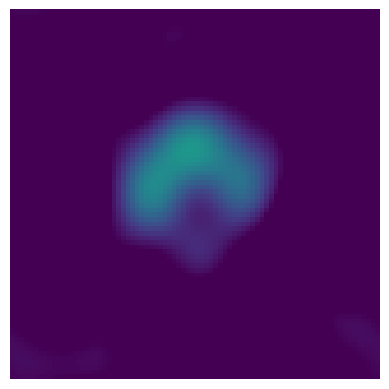

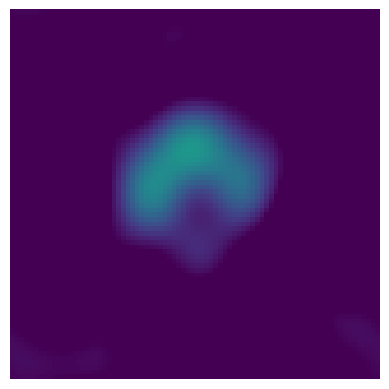

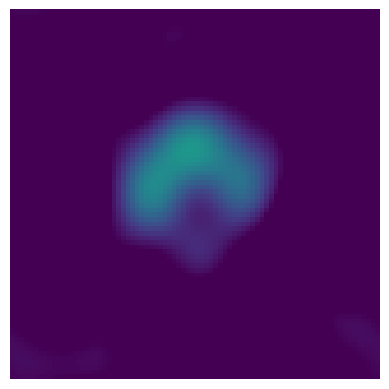

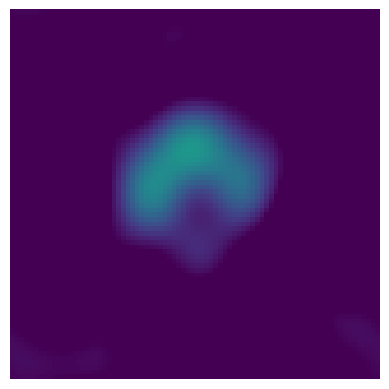

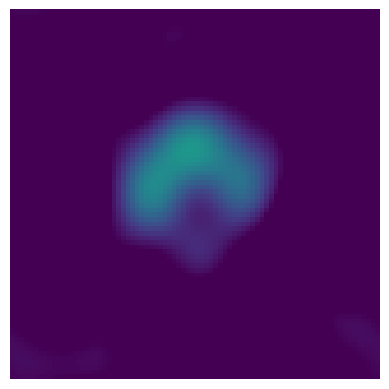

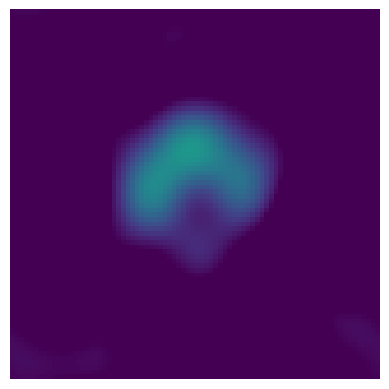

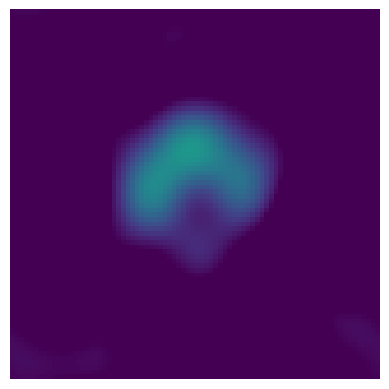

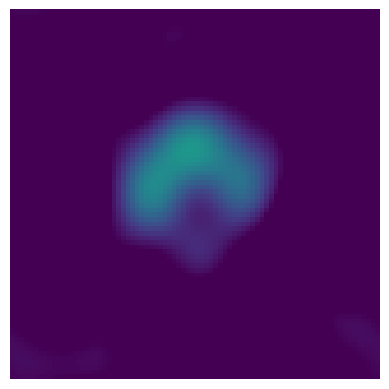

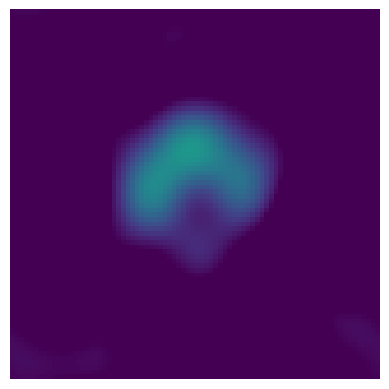

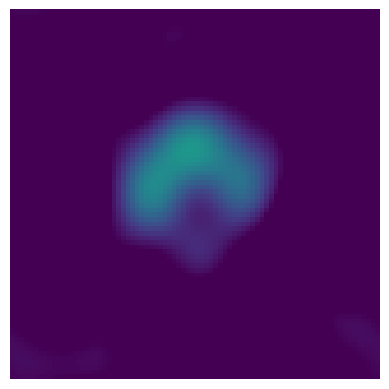

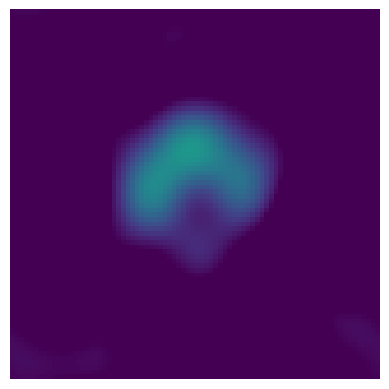

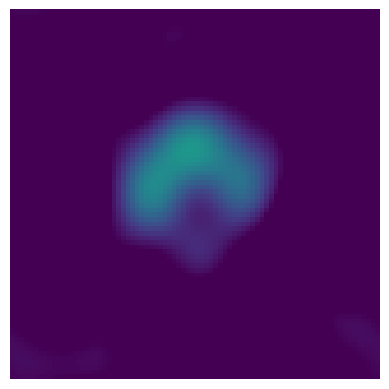

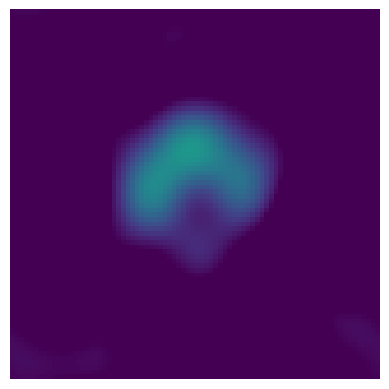

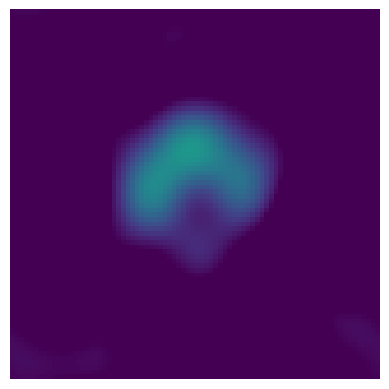

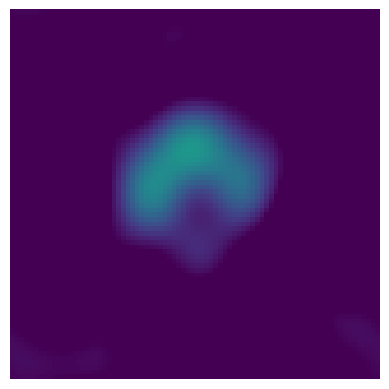

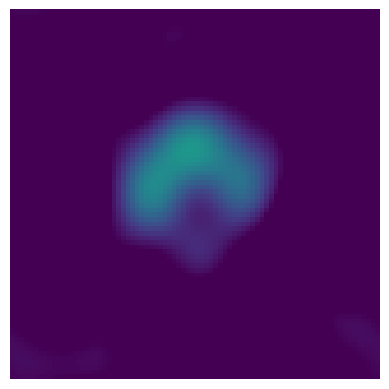

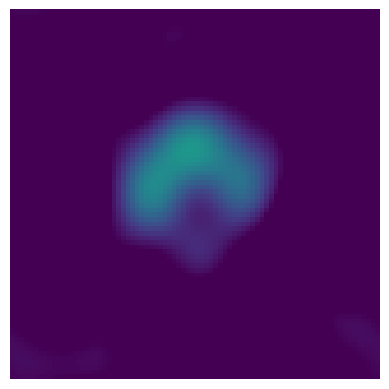

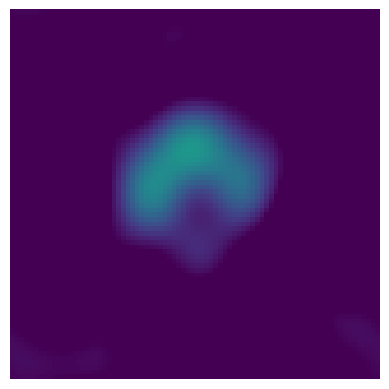

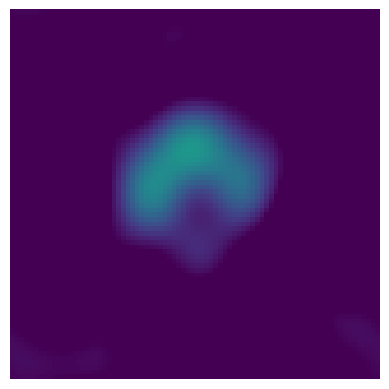

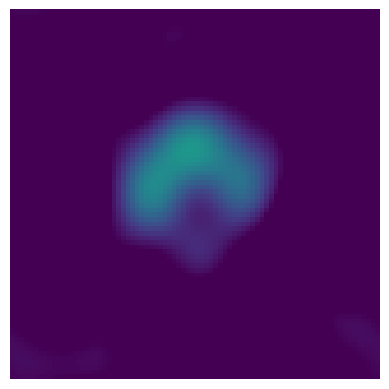

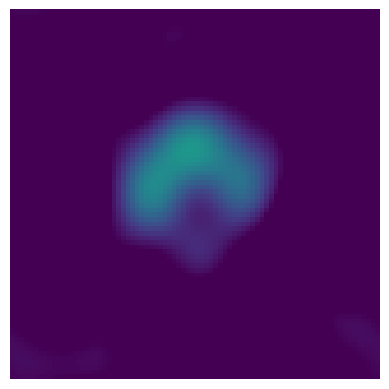

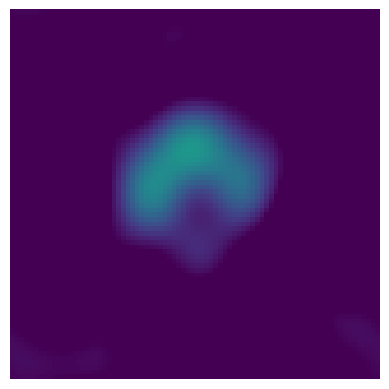

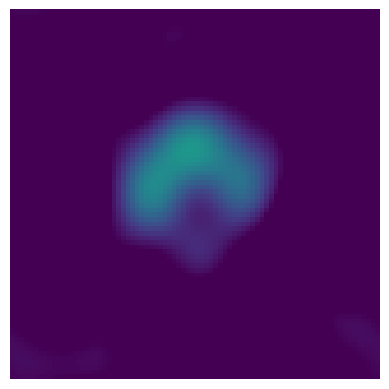

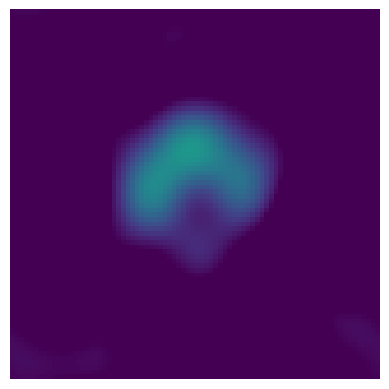

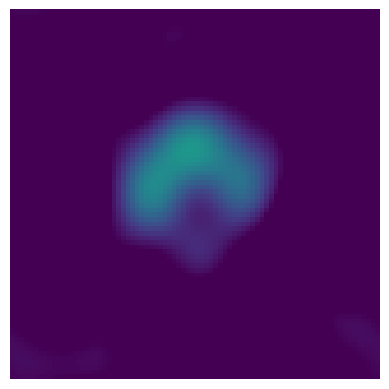

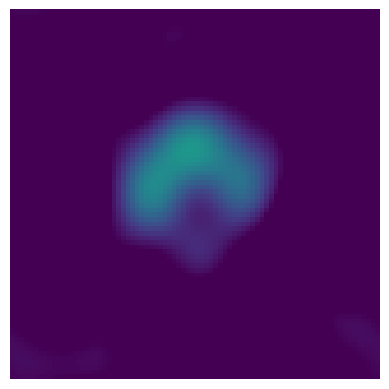

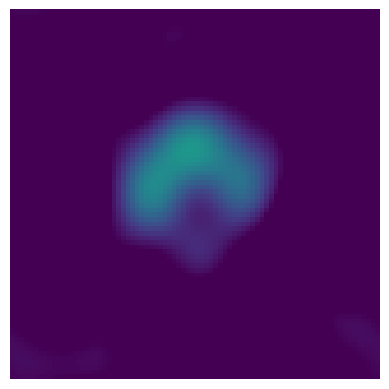

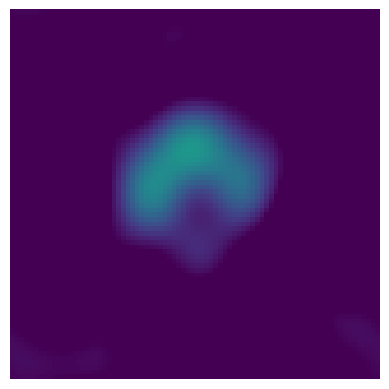

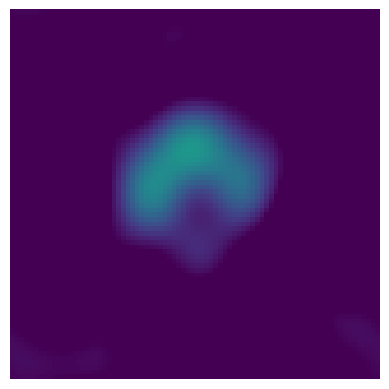

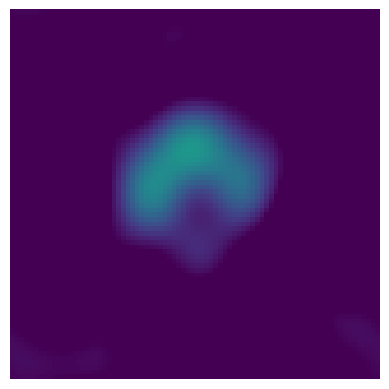

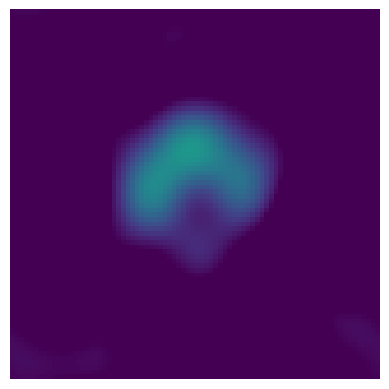

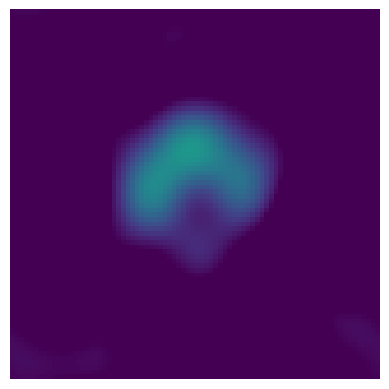

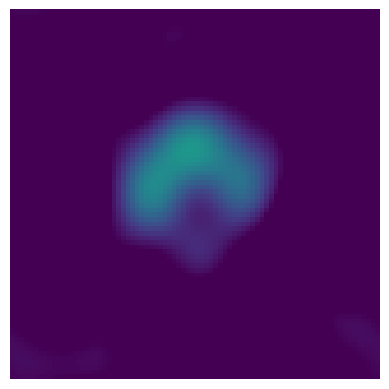

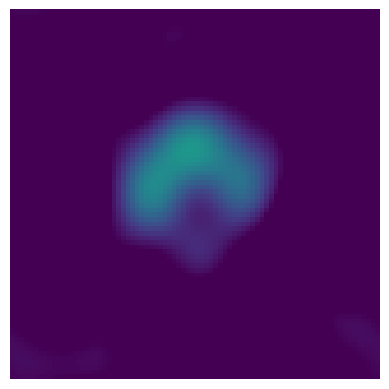

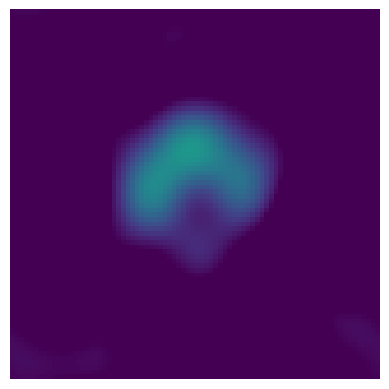

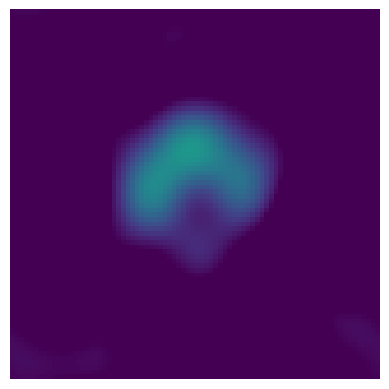

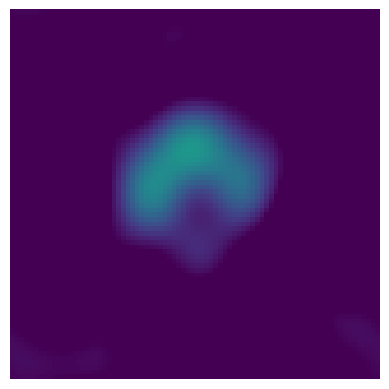

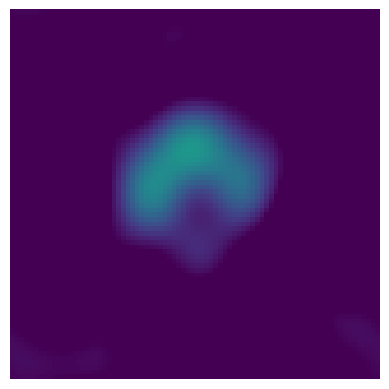

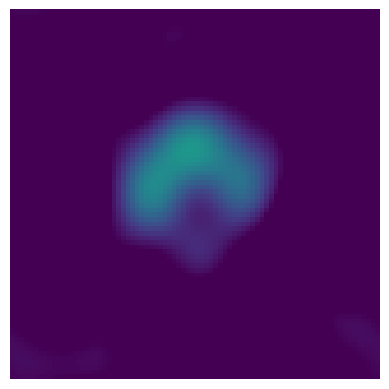

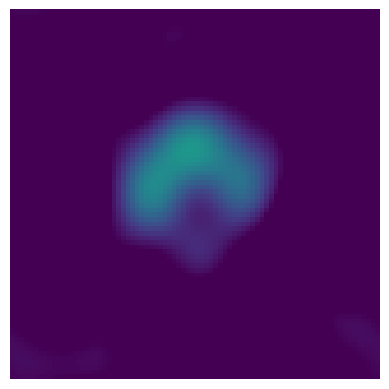

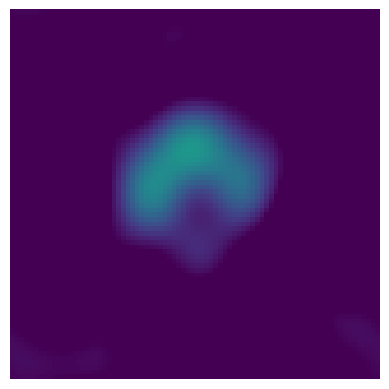

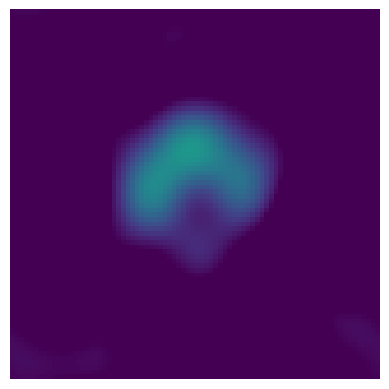

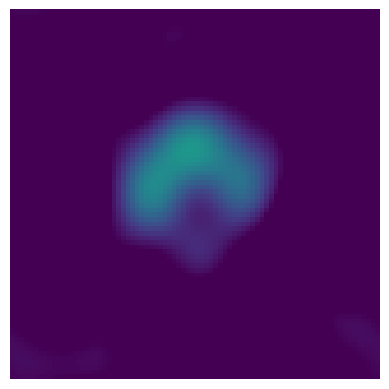

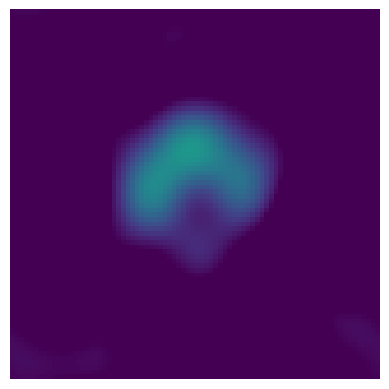

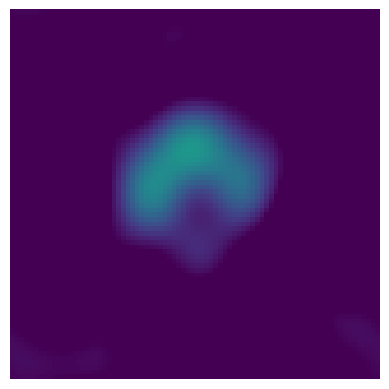

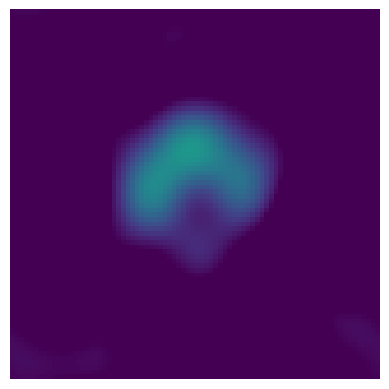

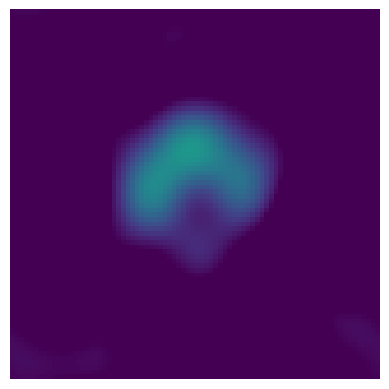

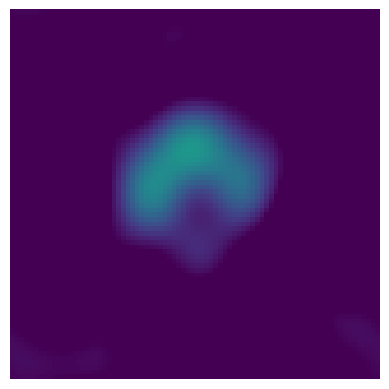

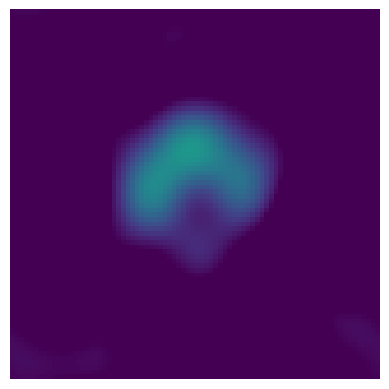

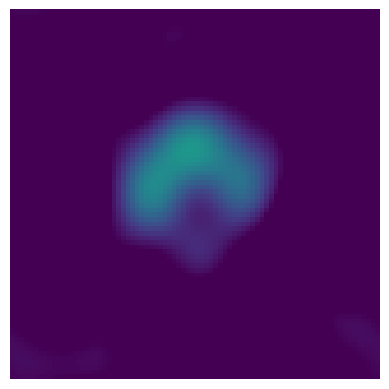

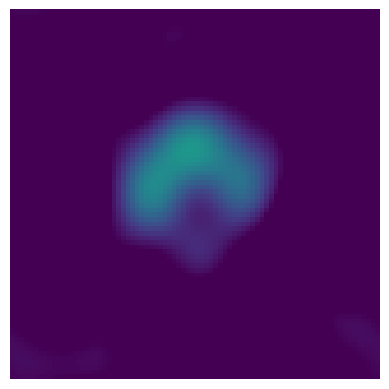

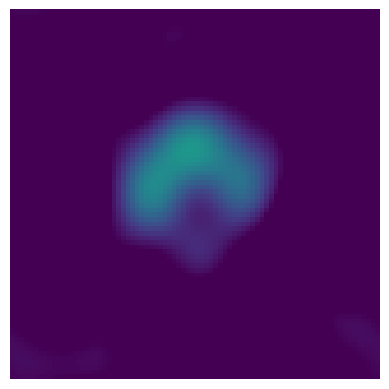

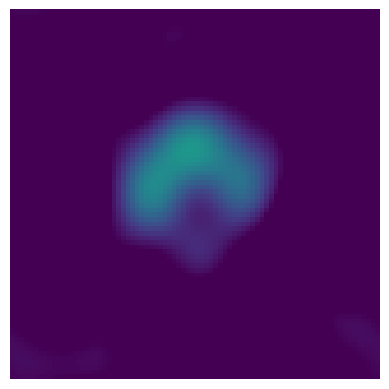

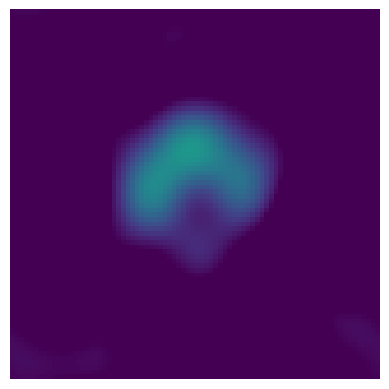

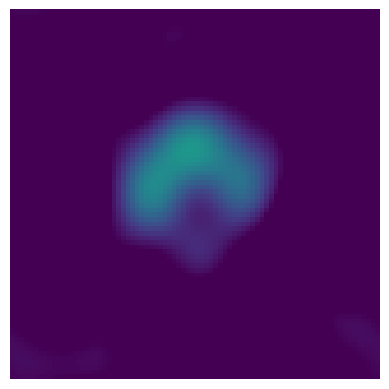

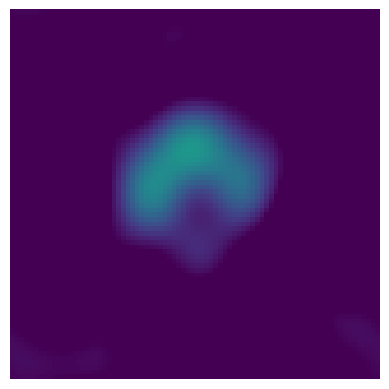

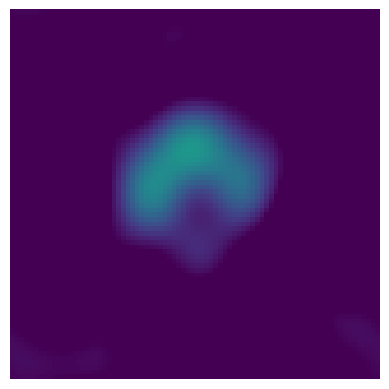

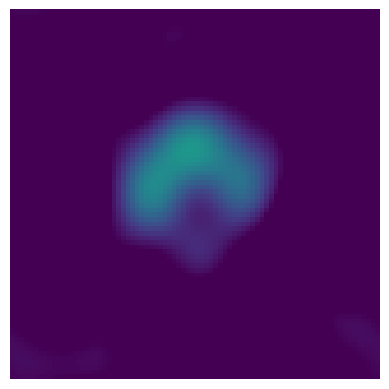

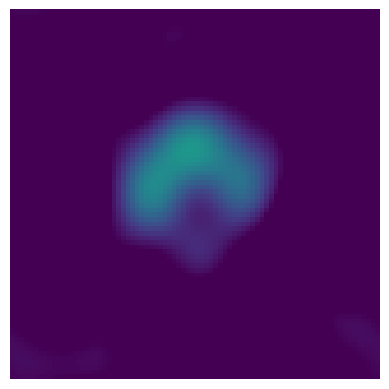

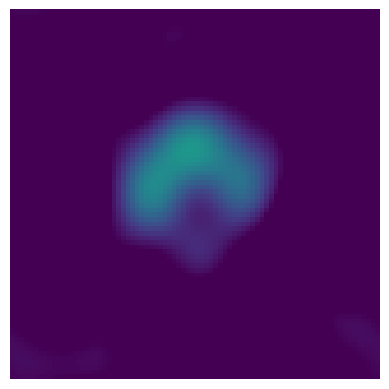

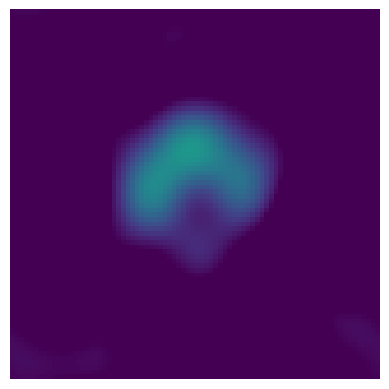

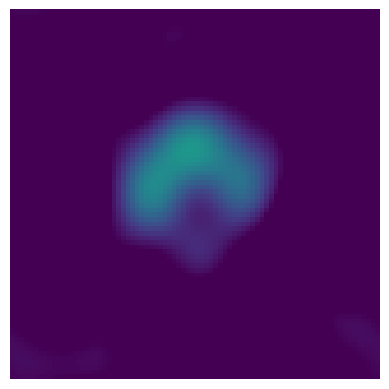

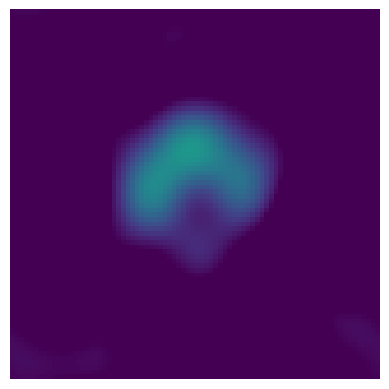

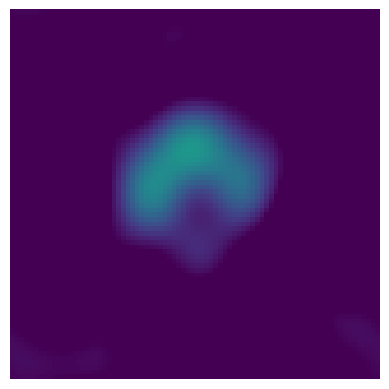

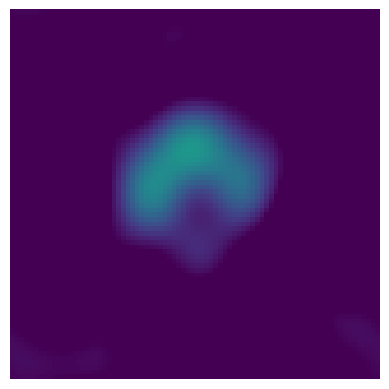

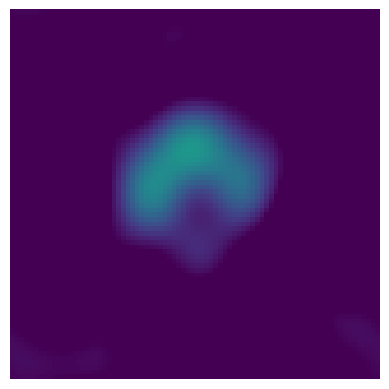

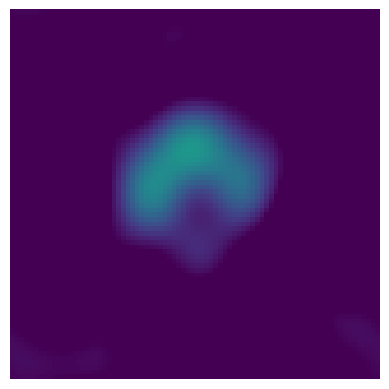

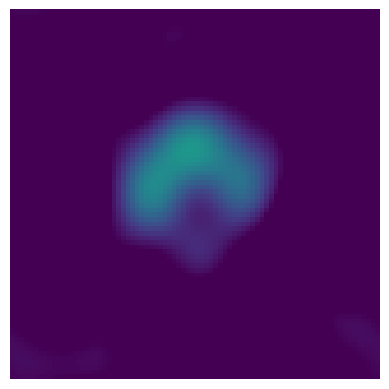

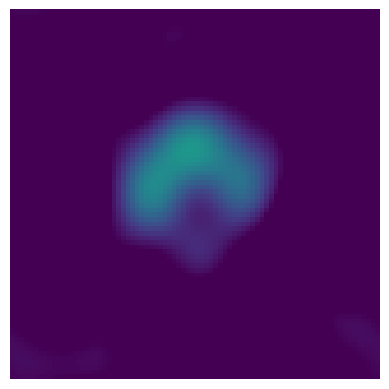

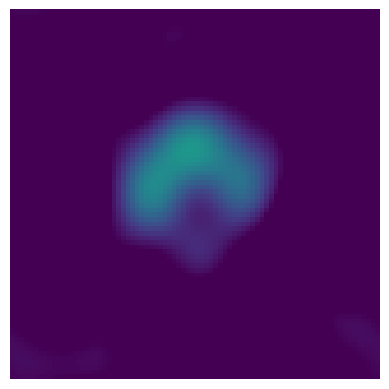

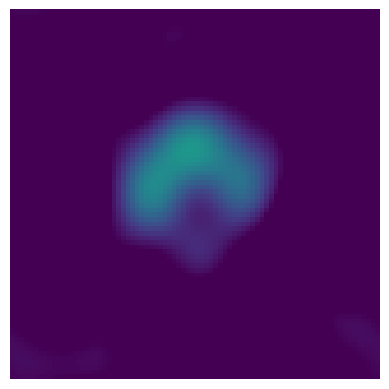

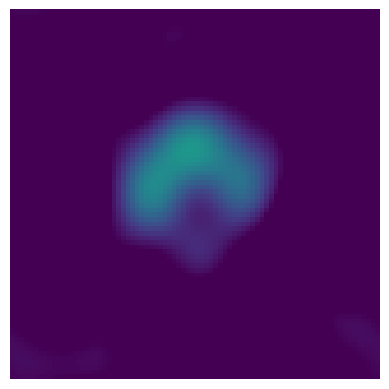

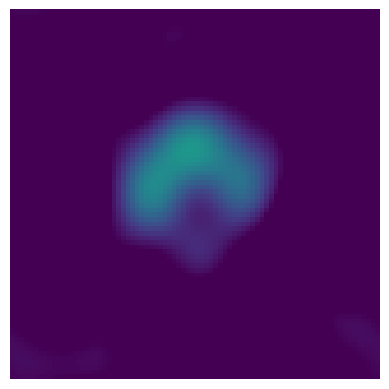

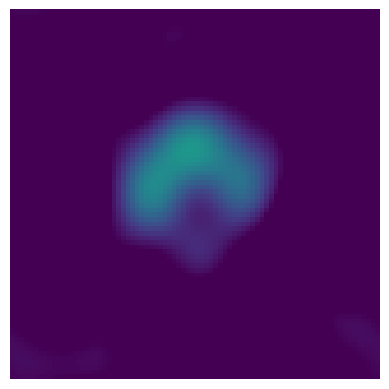

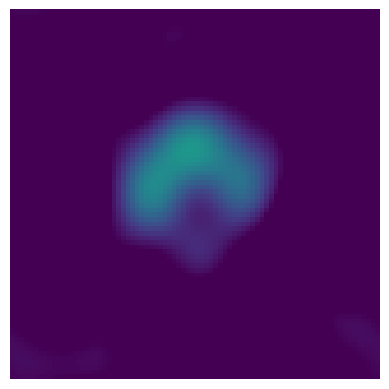

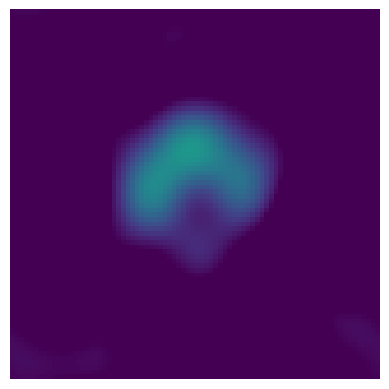

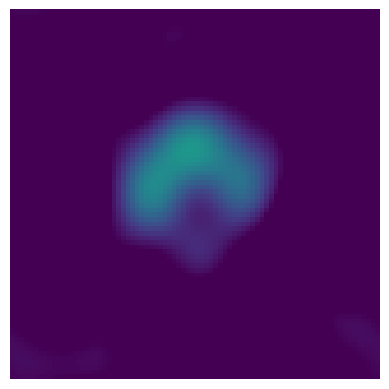

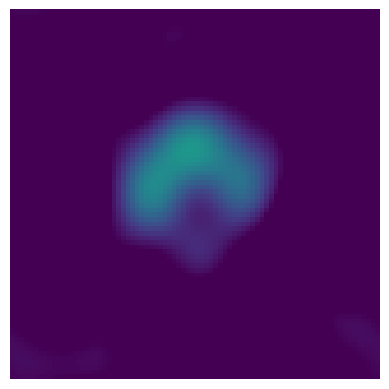

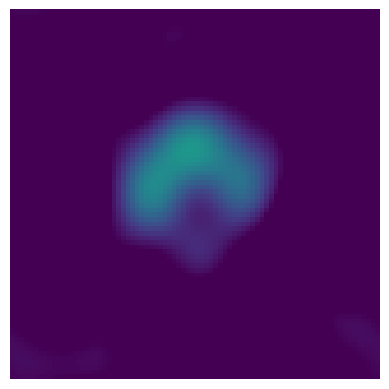

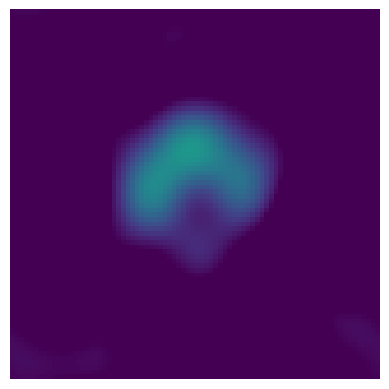

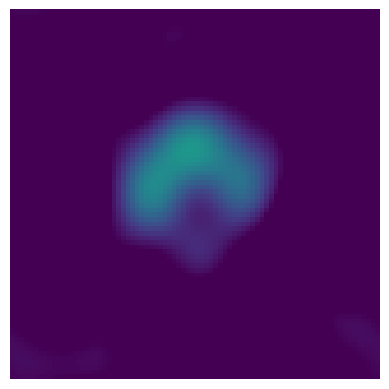

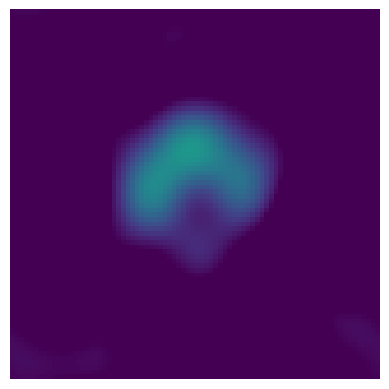

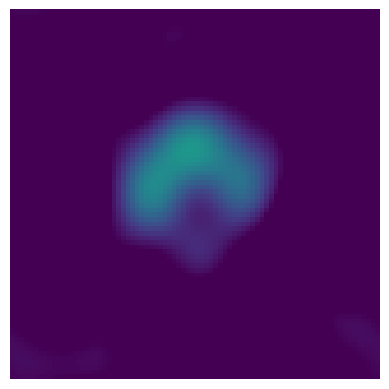

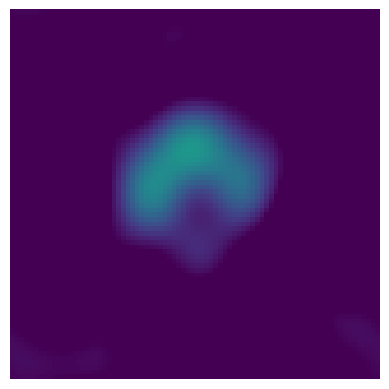

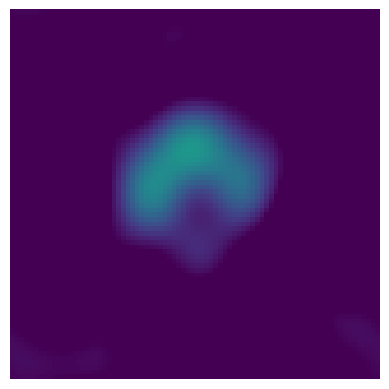

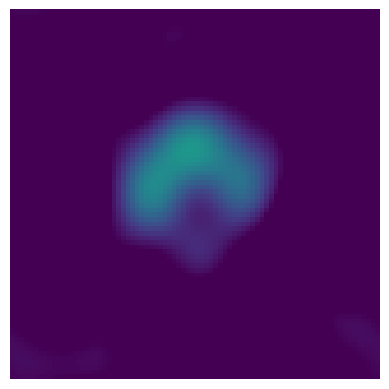

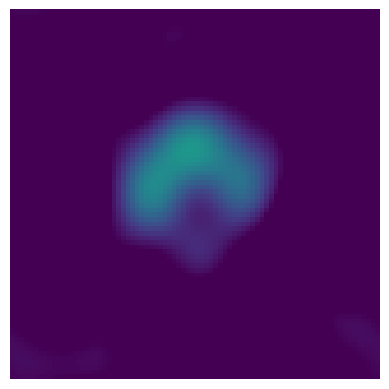

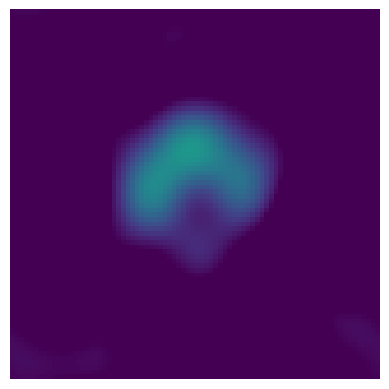

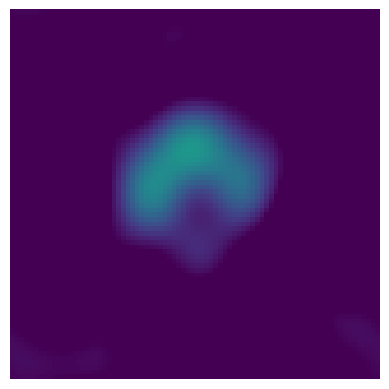

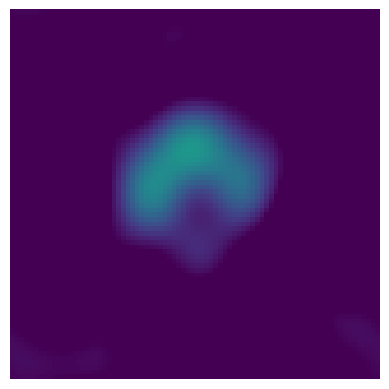

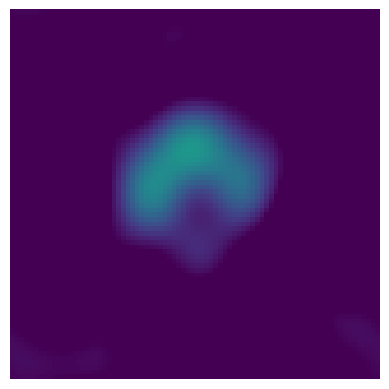

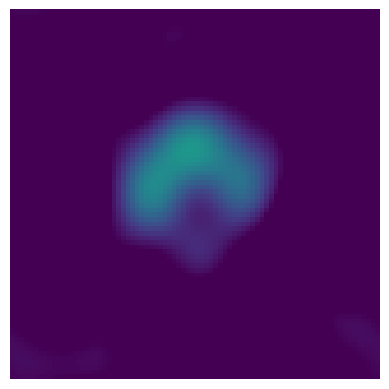

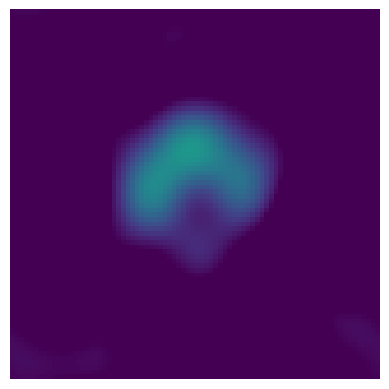

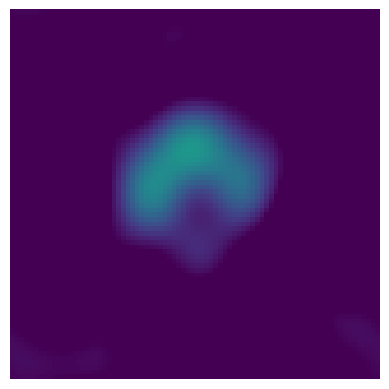

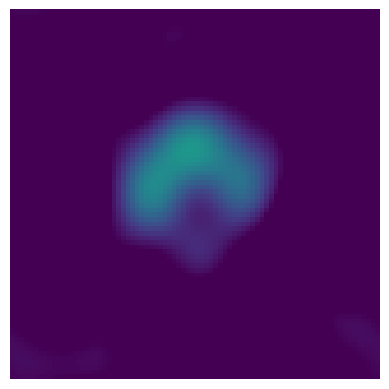

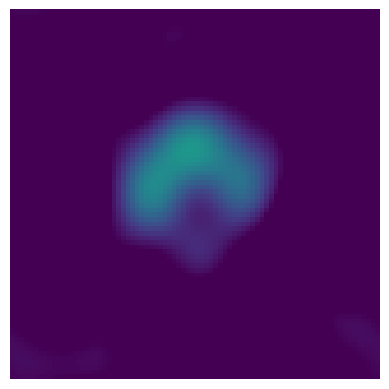

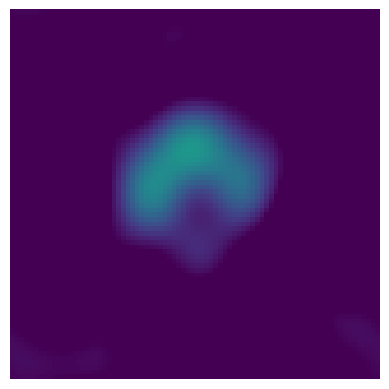

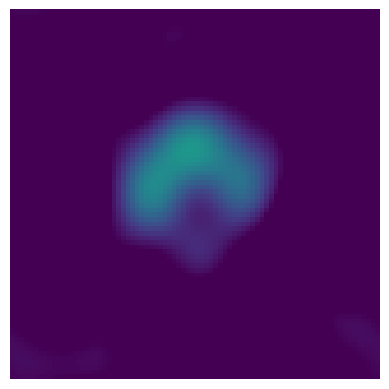

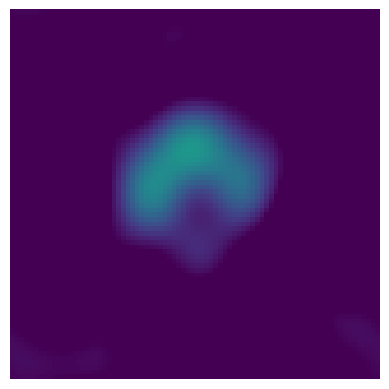

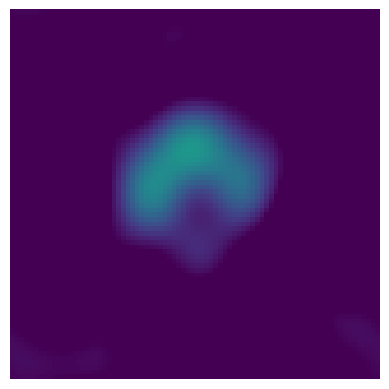

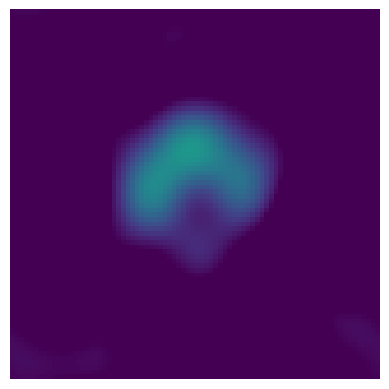

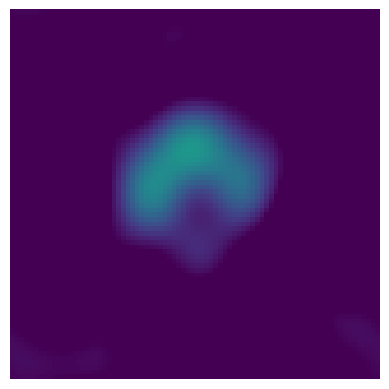

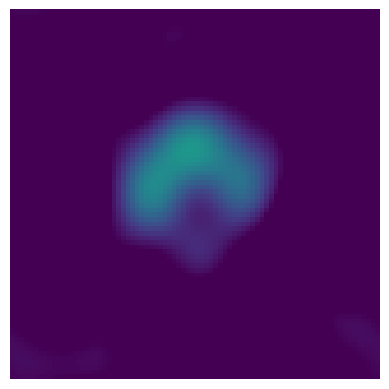

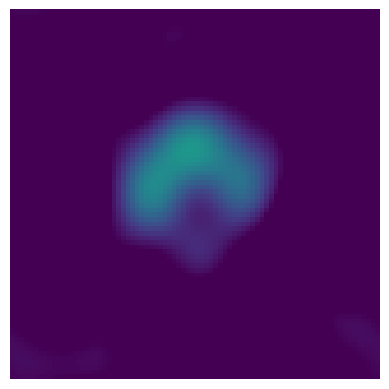

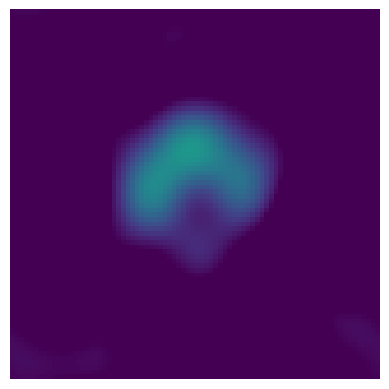

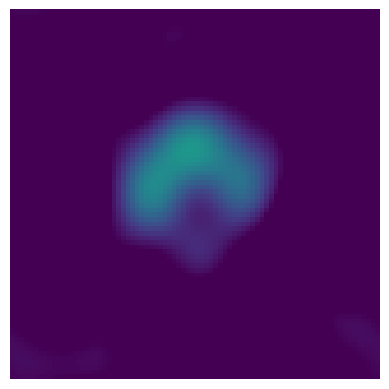

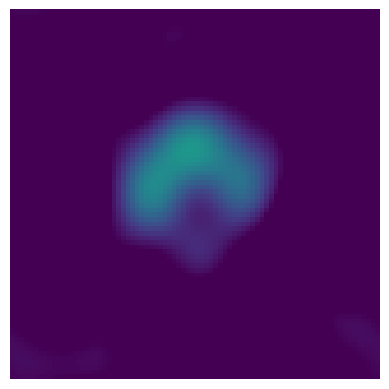

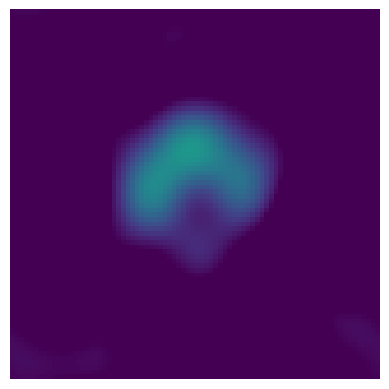

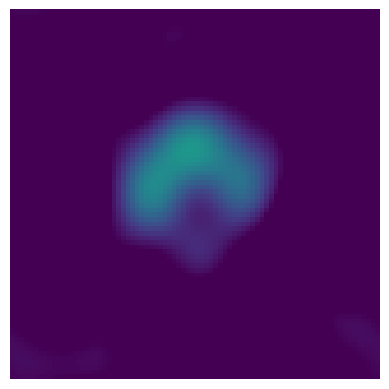

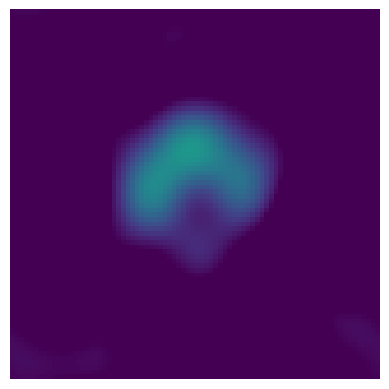

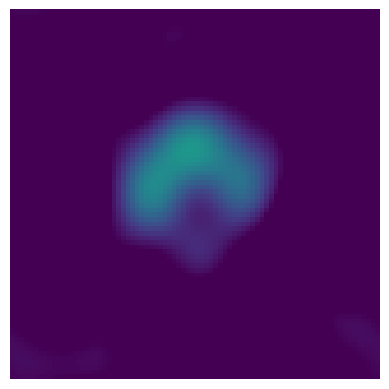

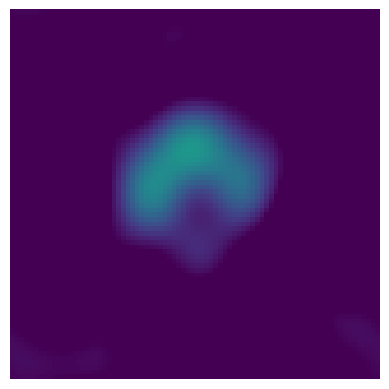

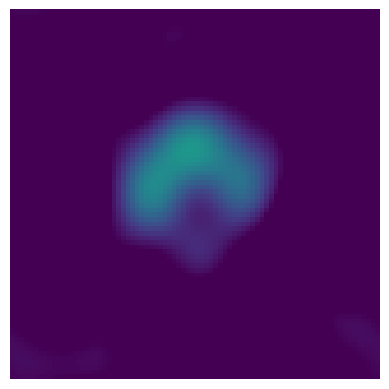

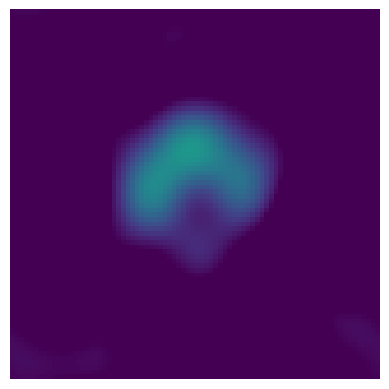

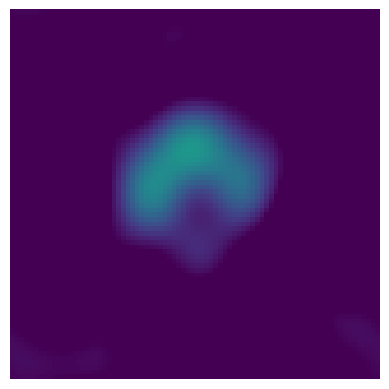

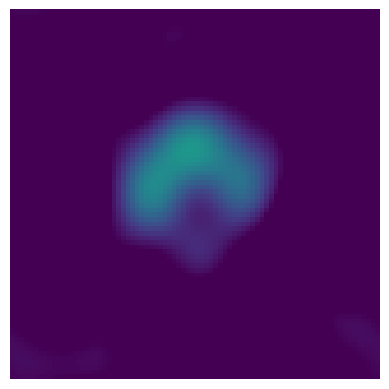

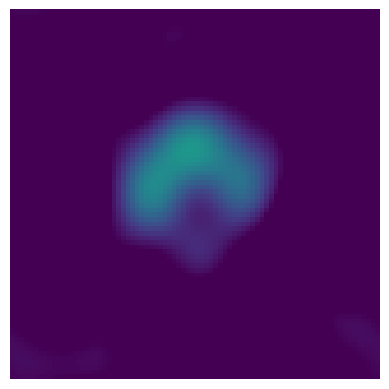

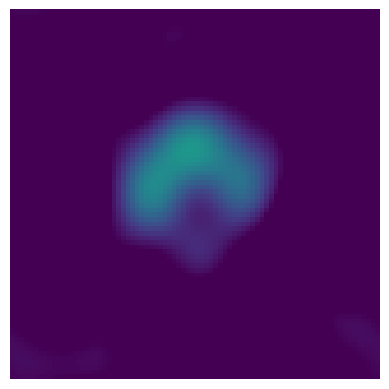

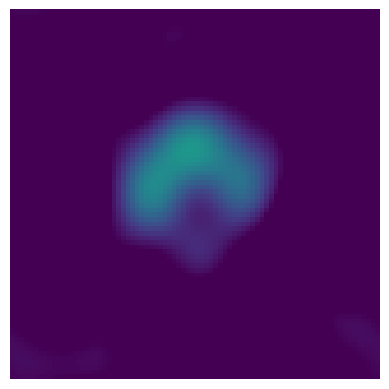

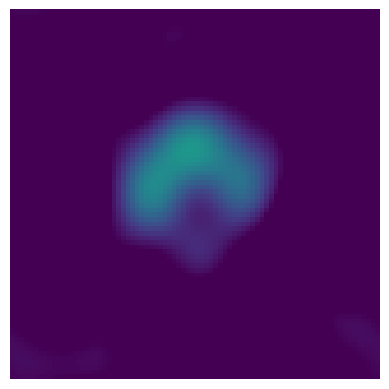

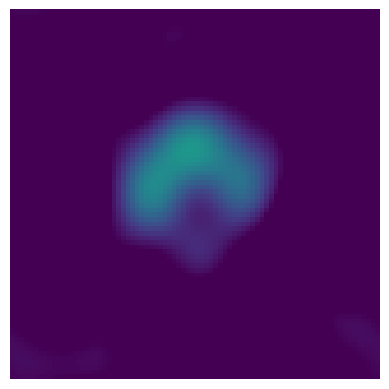

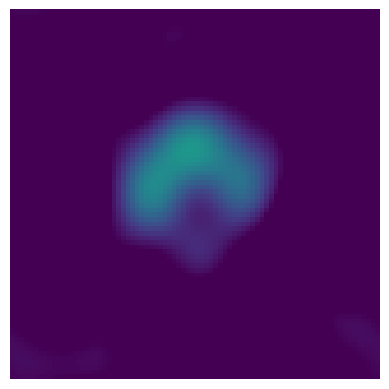

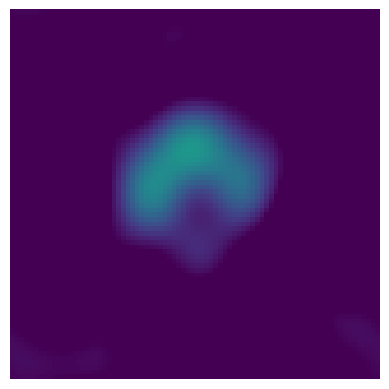

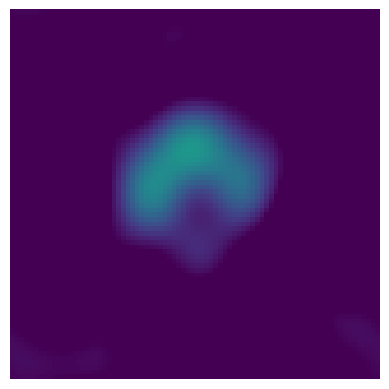

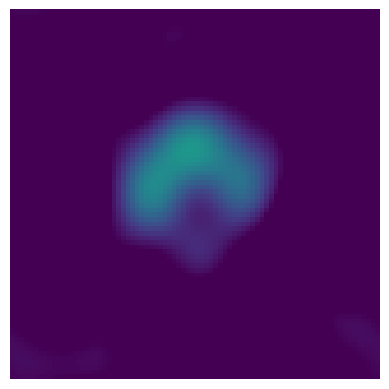

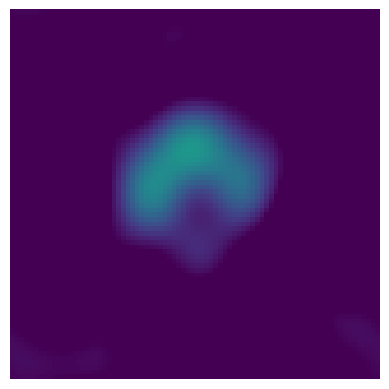

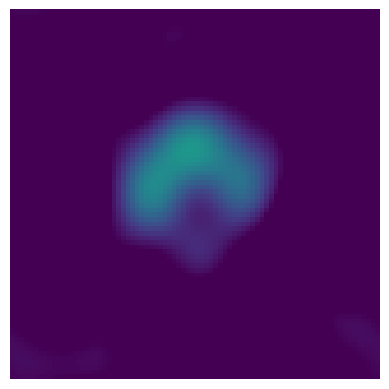

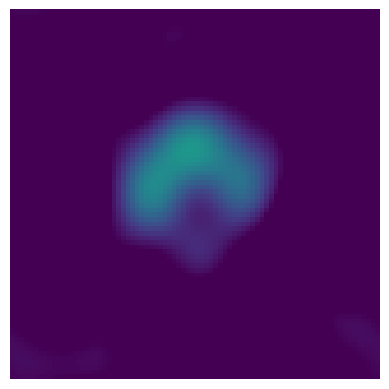

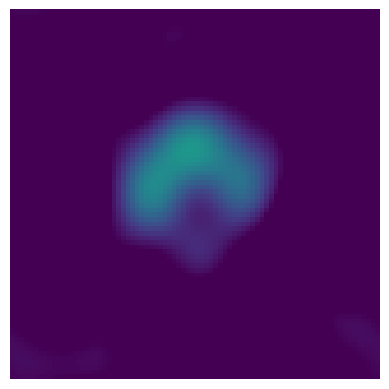

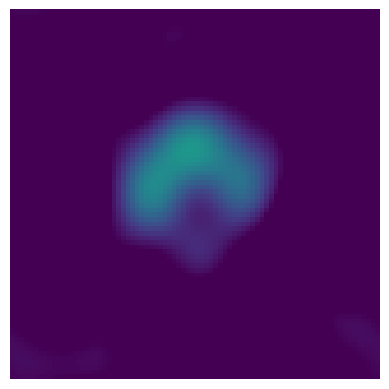

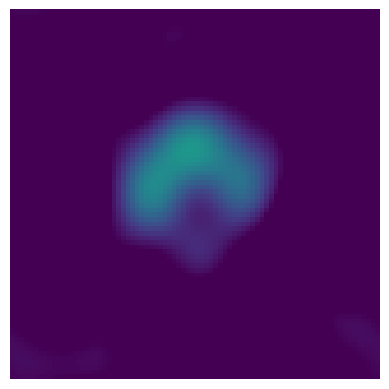

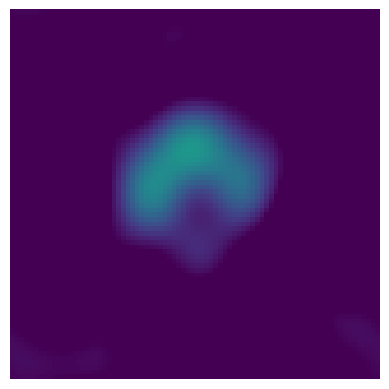

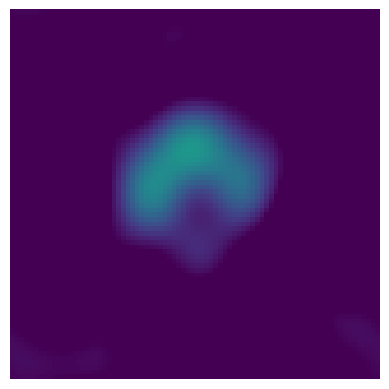

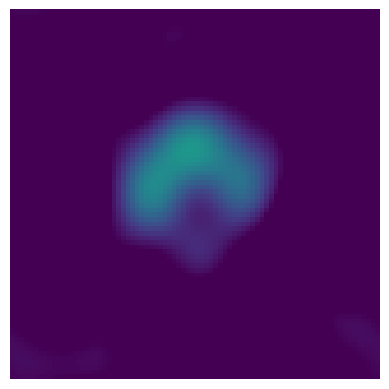

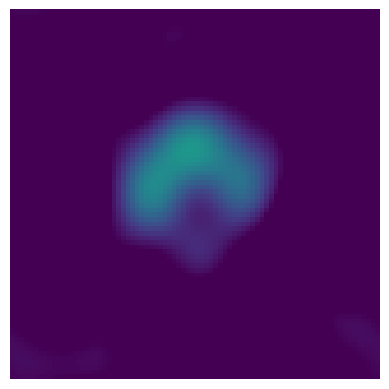

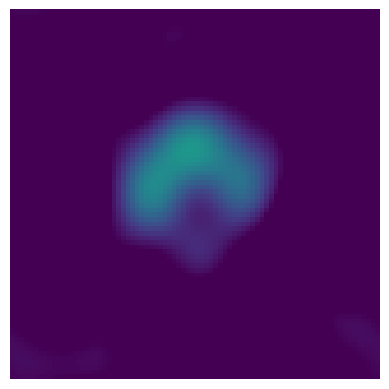

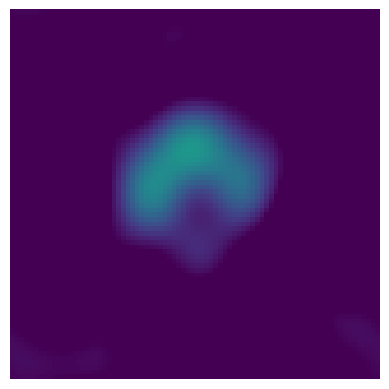

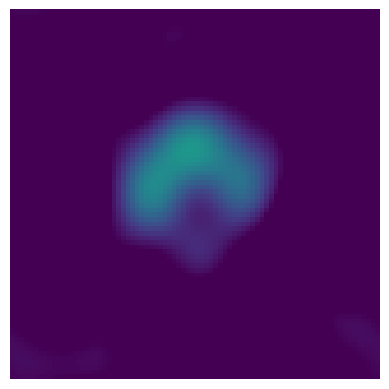

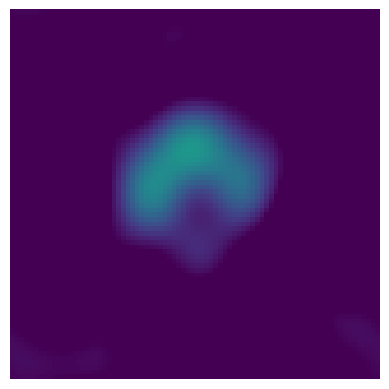

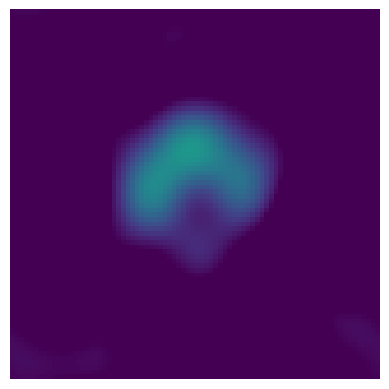

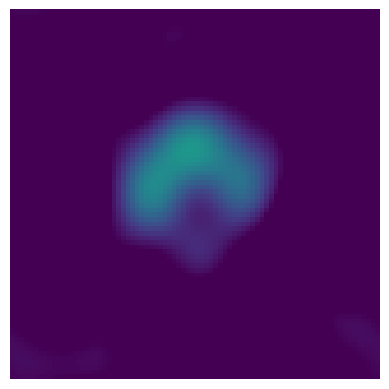

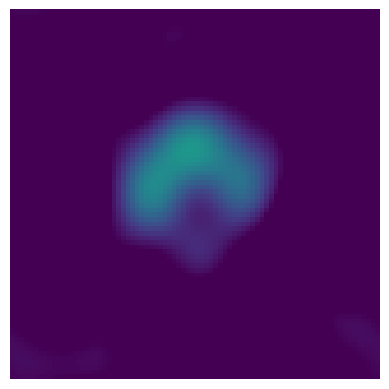

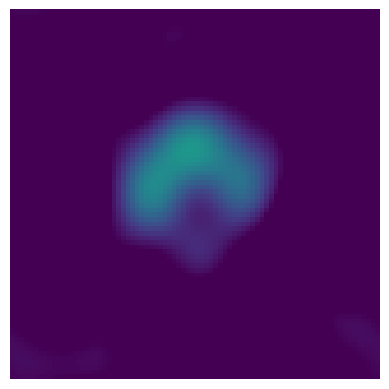

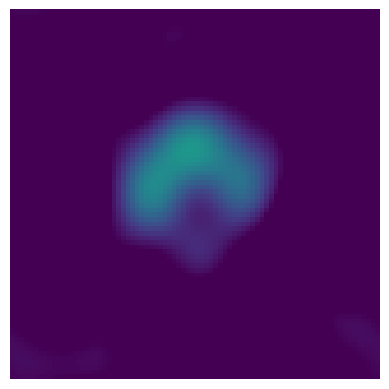

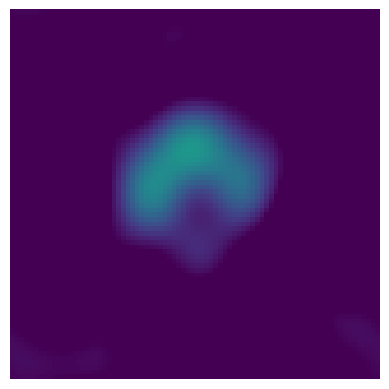

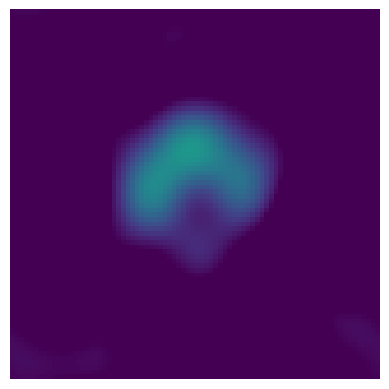

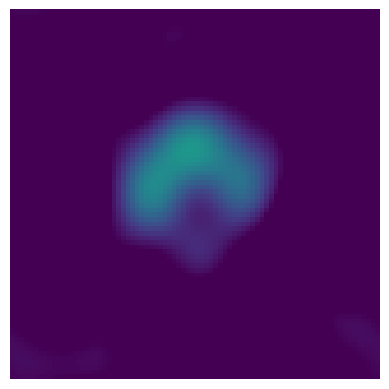

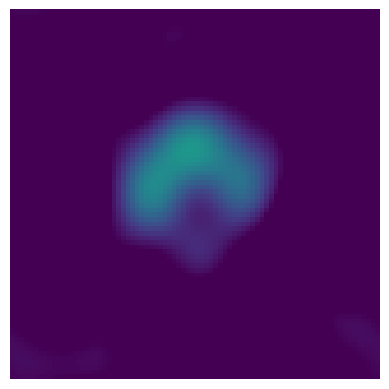

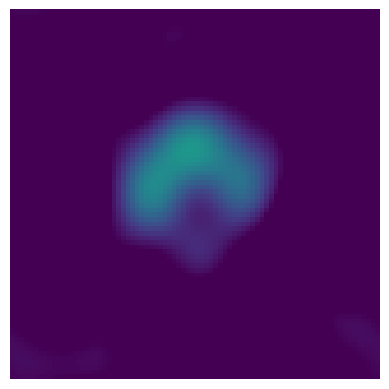

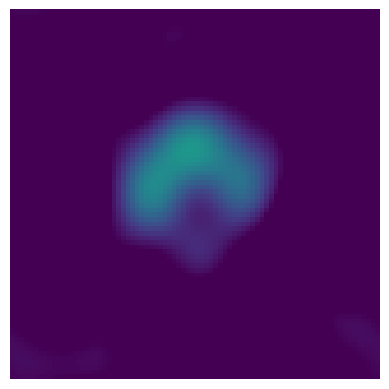

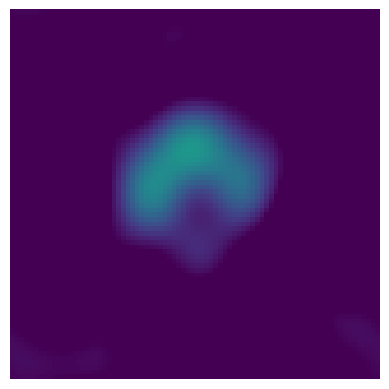

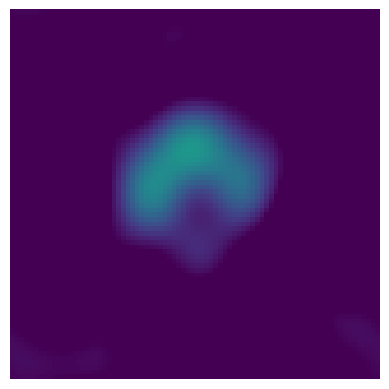

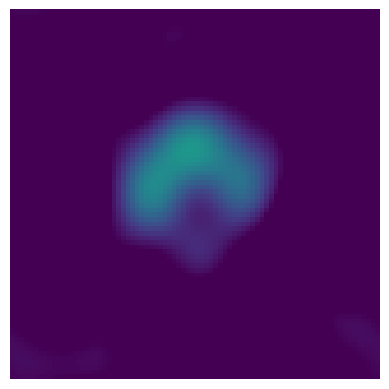

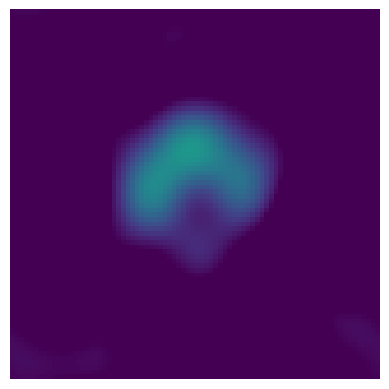

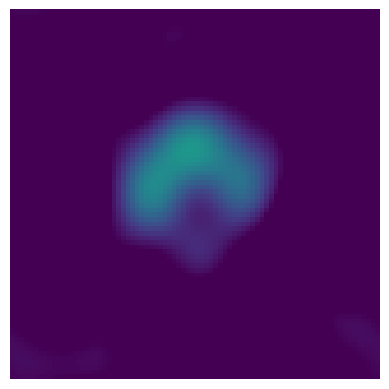

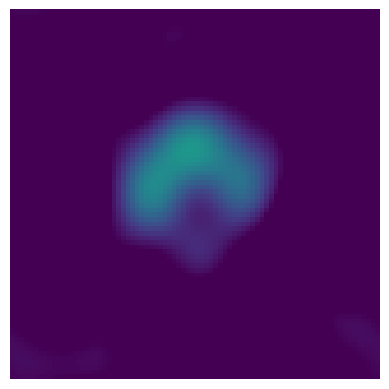

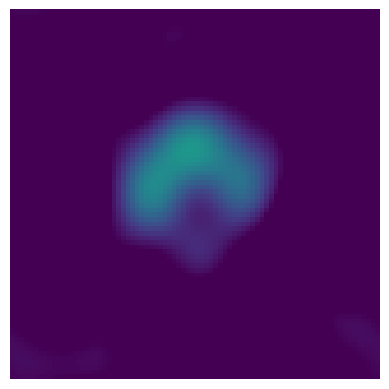

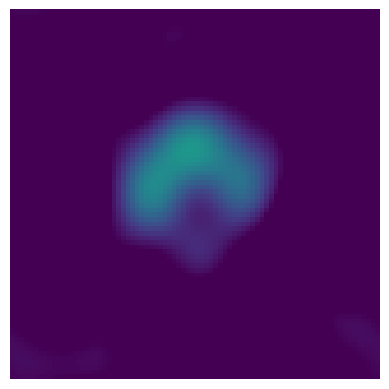

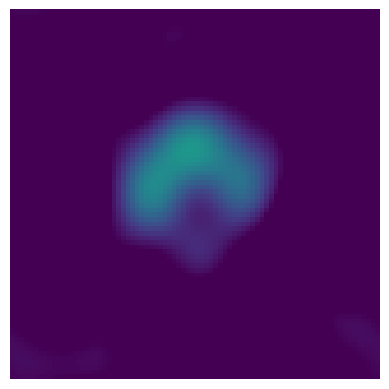

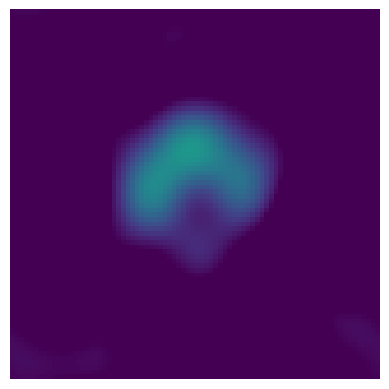

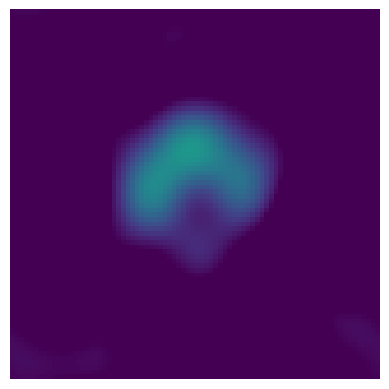

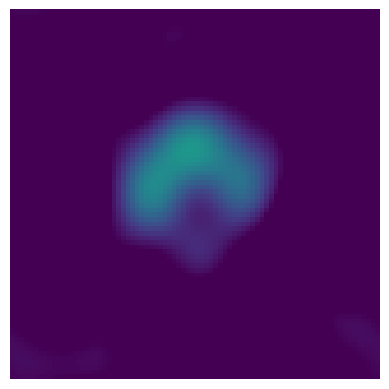

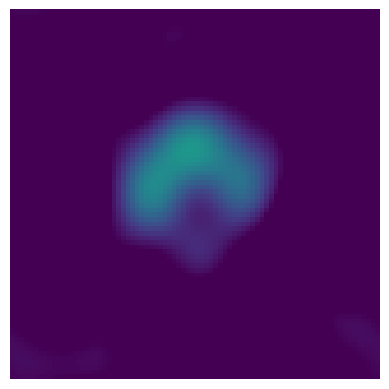

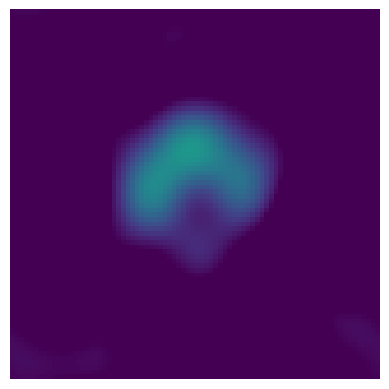

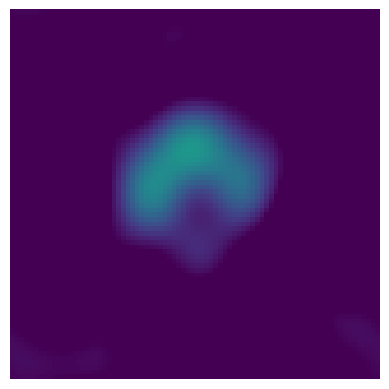

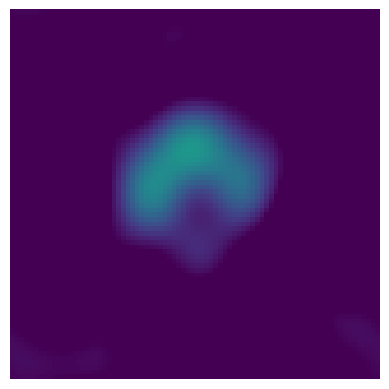

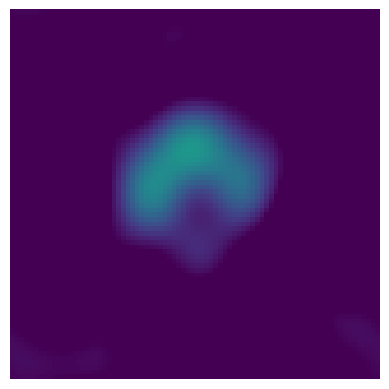

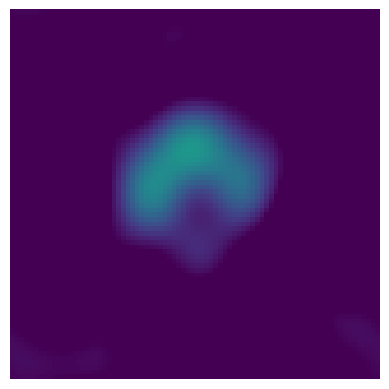

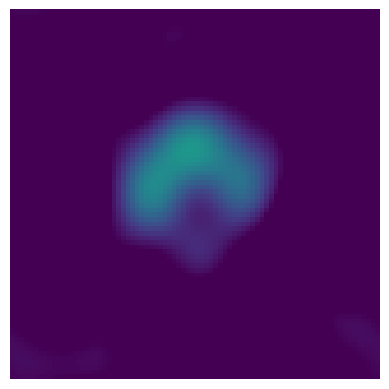

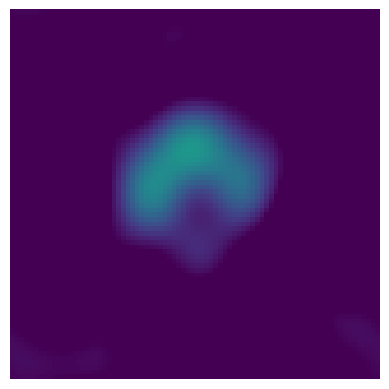

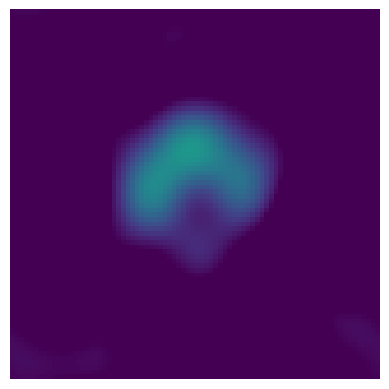

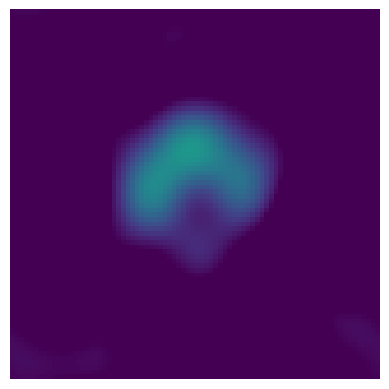

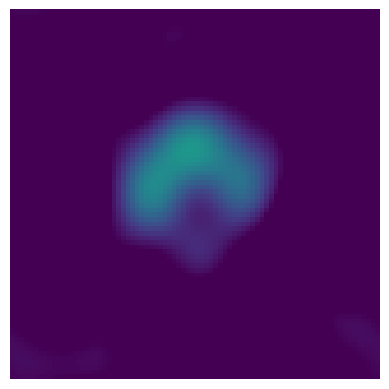

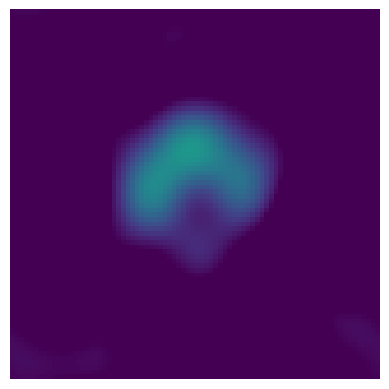

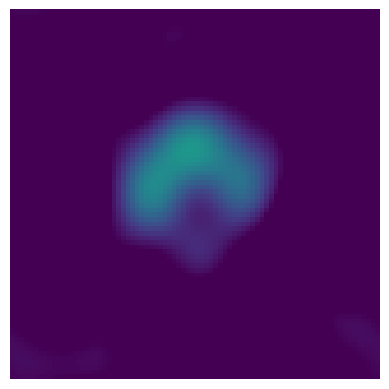

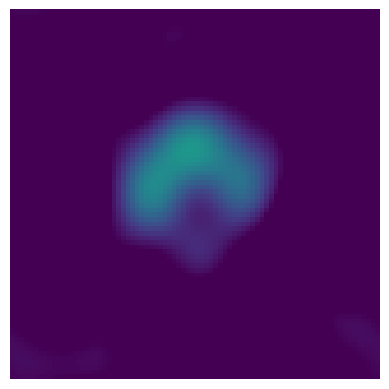

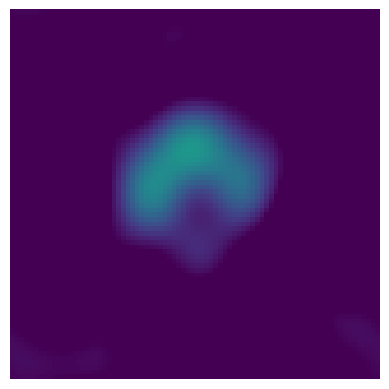

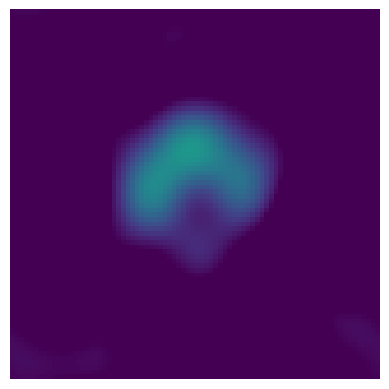

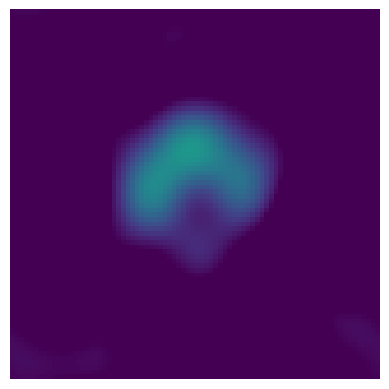

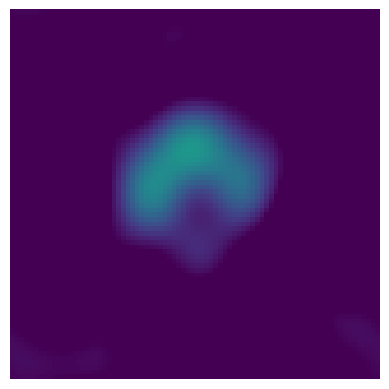

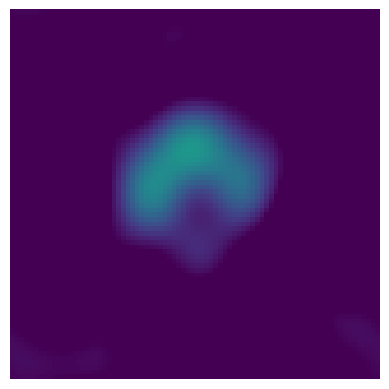

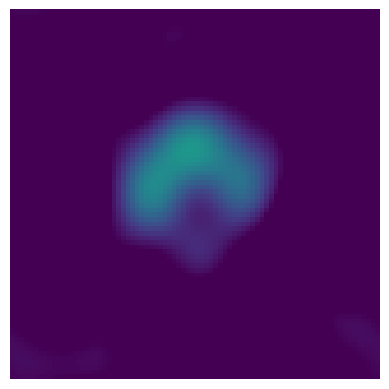

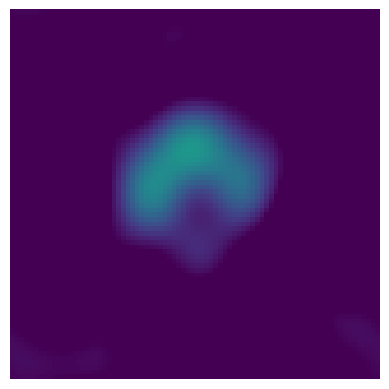

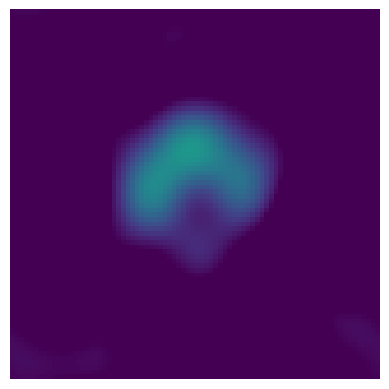

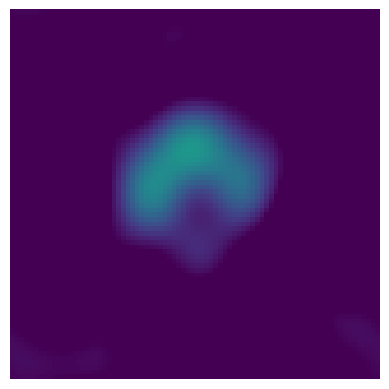

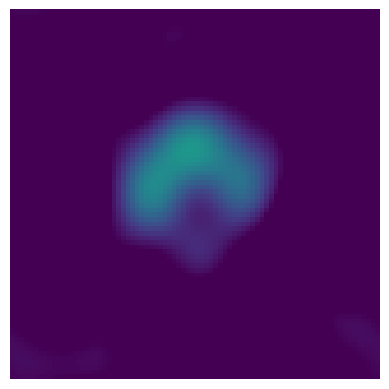

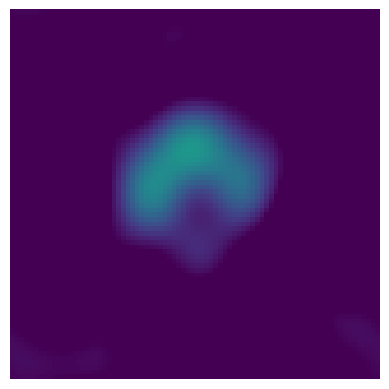

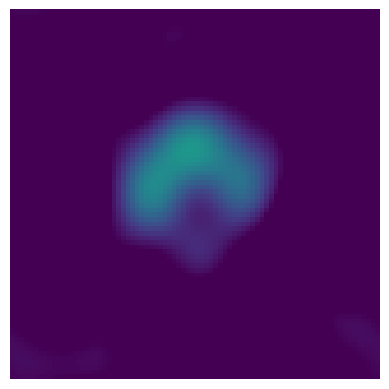

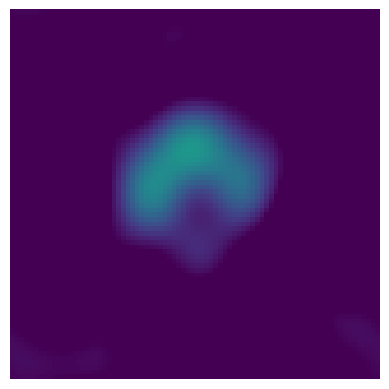

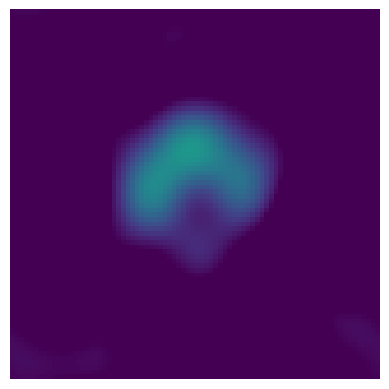

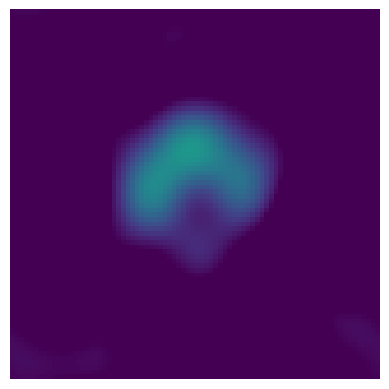

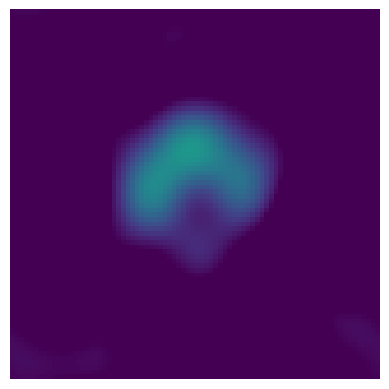

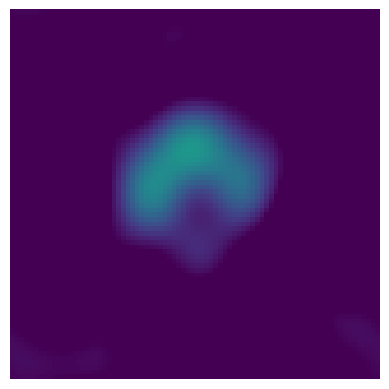

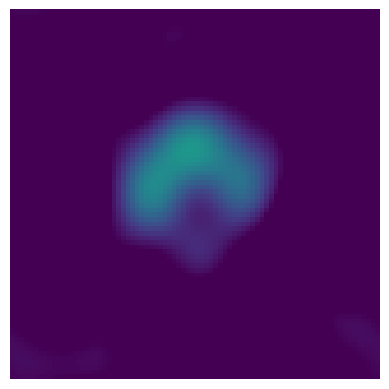

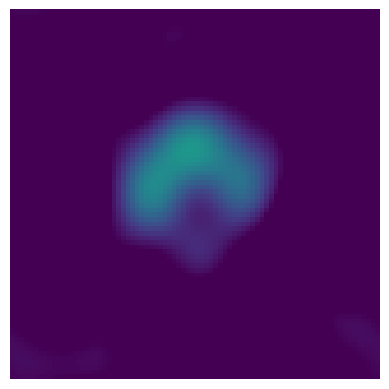

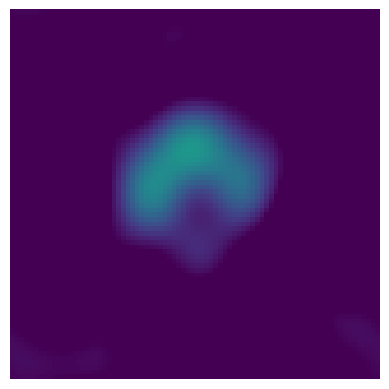

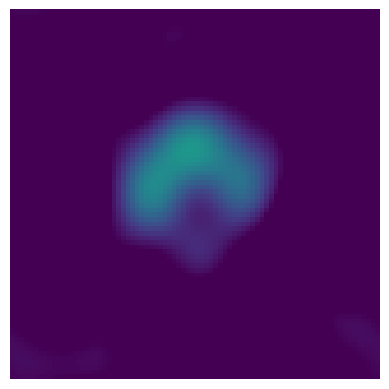

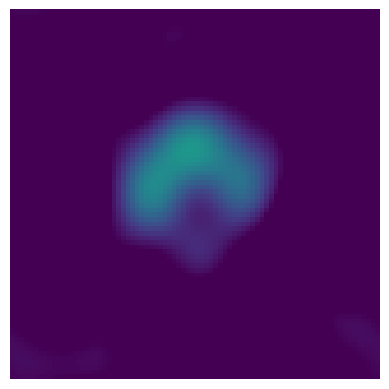

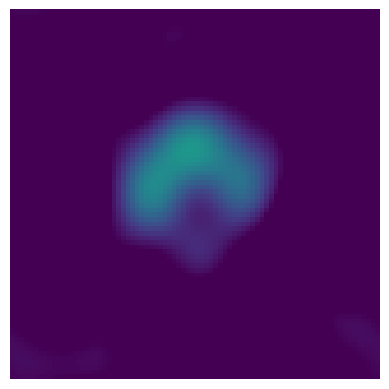

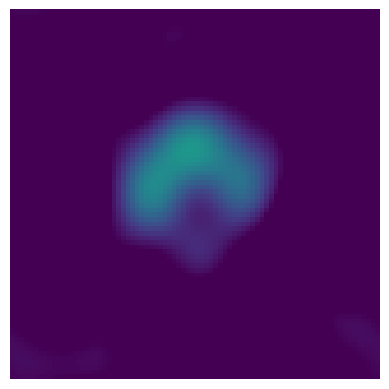

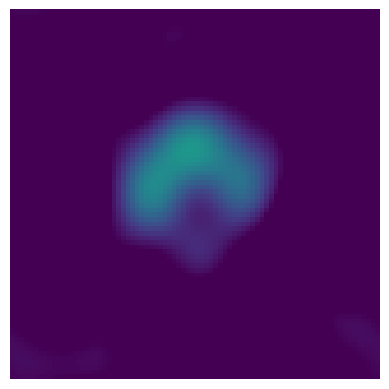

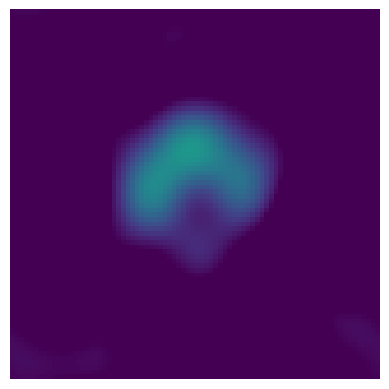

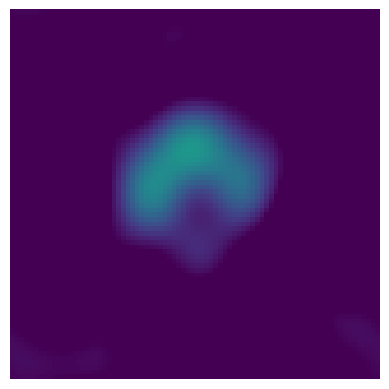

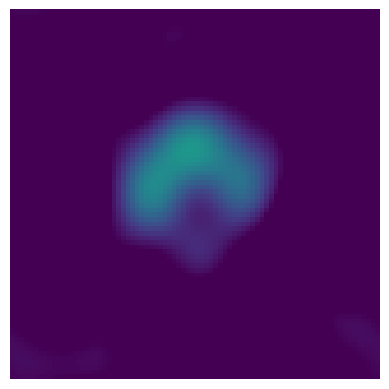

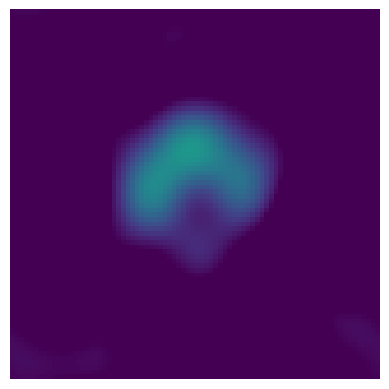

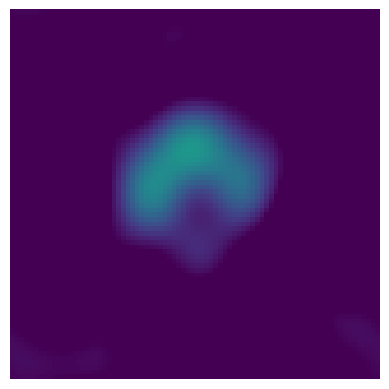

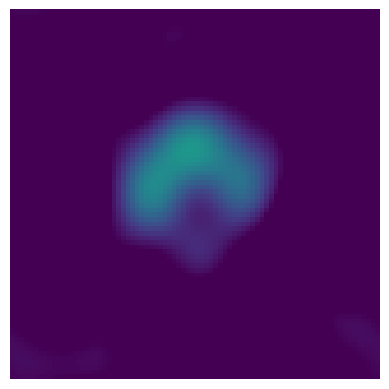

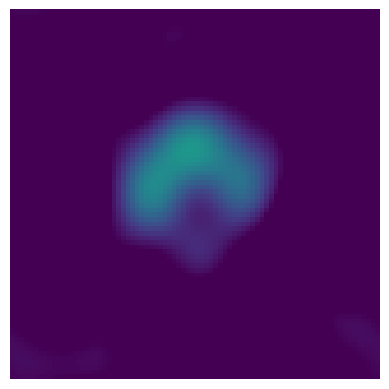

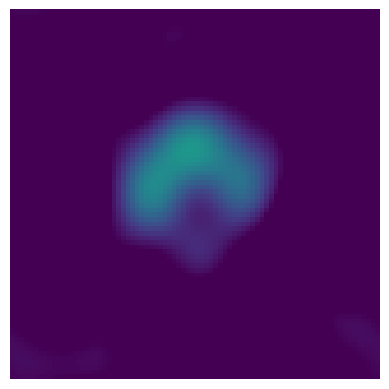

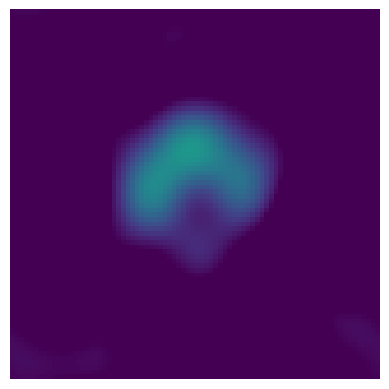

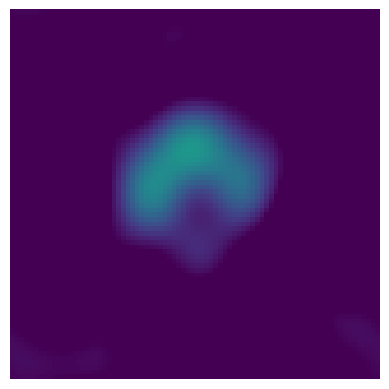

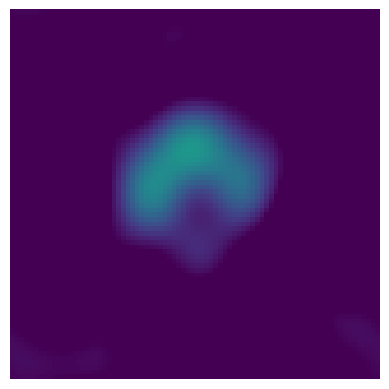

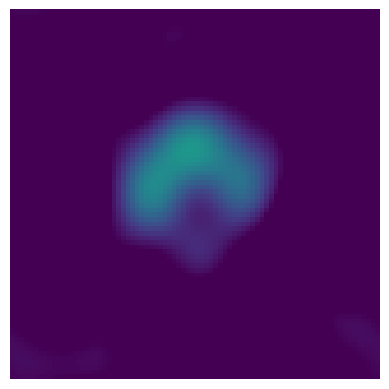

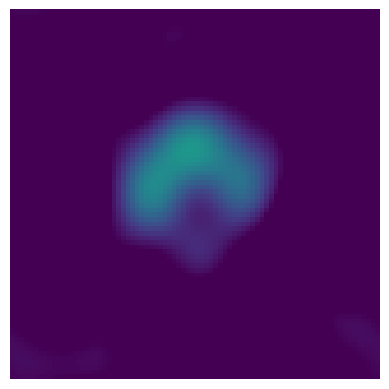

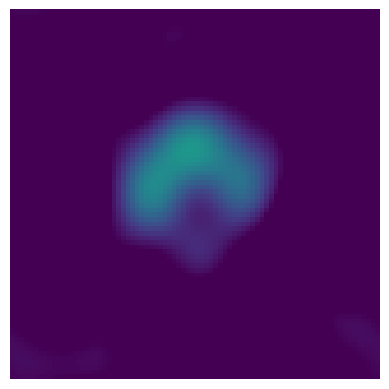

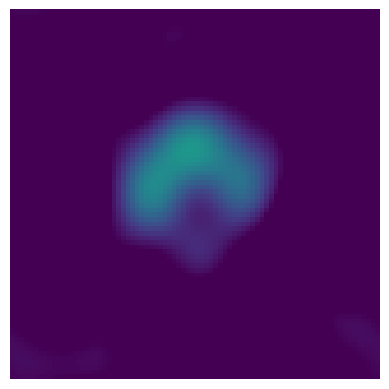

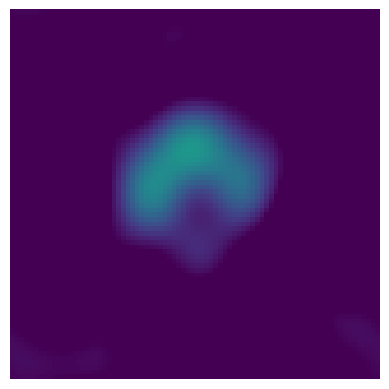

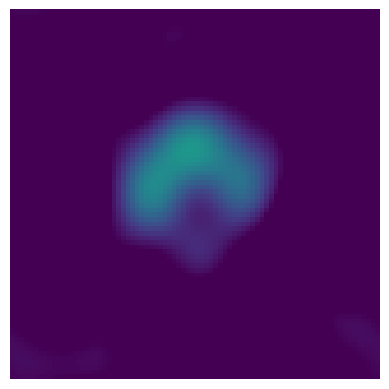

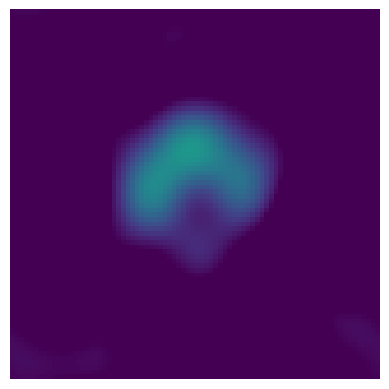

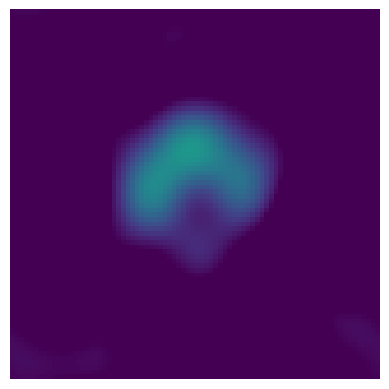

In [34]:
emp = np.zeros((80,80))
gradient_descent(emp, data_list, coords)